In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("synthetic_ehr.db")

tabels_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;",conn)
print(tabels_df)

                                        name
0               DIAGNOSIS_DIM_DIAGNOSIS_CODE
1                         DIM_FLOWSHEET_NAME
2                                DIM_PATIENT
3   ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE
4                    FACT_CLINICAL_DOCUMENTS
5                             FACT_DIAGNOSIS
6                                   FACT_ECG
7                        FACT_ECHOCARDIOGRAM
8                          FACT_ECHO_RESULTS
9                             FACT_ECHO_TEST
10                           FACT_ENCOUNTERS
11                           FACT_FLOWSHEETS
12                             FACT_LAB_TEST
13                          FACT_MEDICATIONS
14                    FACT_MEDS_ADMINISTERED
15                               FACT_ORDERS
16                            FACT_PATHOLOGY
17                           FACT_PROCEDURES
18                            FACT_RADIOLOGY
19                 LAB_SPECIMEN_DIM_LAB_TEST
20                          MAR_DIM_MED_NAME
21        

In [2]:
# Get a cursor
cursor = conn.cursor()

# Get all table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row[0] for row in cursor.fetchall()]
# TABLES = ""
# TABLES = ", ".join(tables) 
# print(TABLES)
# print("📋 Found tables:", tables)

# Build the schema into a string
table_schema = ""
table_schema += "📋 Found tables:\n" + ", ".join(tables) + "\n\n"

# For each table, get the schema
for table in tables:
    # print(f"\n🔍 Schema for table: {table}")
    table_schema += f"\n🔍 Schema for table: {table} \n"
    cursor.execute(f"PRAGMA table_info({table});")
    schema = cursor.fetchall()
    for column in schema:
        col_id, name, col_type, notnull, default_value, pk = column
        # print(f"  - {name} ({col_type}){' PRIMARY KEY' if pk else ''}")
        table_schema += f"  - {name} ({col_type}){' PRIMARY KEY' if pk else ''}\n"
# print("#####################################################################################")
print(table_schema)


📋 Found tables:
DIM_PATIENT, DIAGNOSIS_DIM_DIAGNOSIS_CODE, PROCEDURES_DIM_PROCEDURE_CODE, LAB_SPECIMEN_DIM_LAB_TEST, MAR_DIM_MED_NAME, DIM_FLOWSHEET_NAME, ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE, FACT_DIAGNOSIS, FACT_PROCEDURES, FACT_LAB_TEST, FACT_MEDICATIONS, FACT_FLOWSHEETS, FACT_ECG, FACT_ECHO_TEST, FACT_ECHOCARDIOGRAM, FACT_ECHO_RESULTS, FACT_RADIOLOGY, FACT_PATHOLOGY, FACT_ENCOUNTERS, FACT_ORDERS, FACT_CLINICAL_DOCUMENTS, FACT_MEDS_ADMINISTERED


🔍 Schema for table: DIM_PATIENT 
  - PATIENT_ID (TEXT) PRIMARY KEY
  - PATIENT_BIRTH_DATE (TEXT)
  - PATIENT_GENDER_NAME (TEXT)
  - PATIENT_RACE_NAME (TEXT)
  - PATIENT_DEATH_DATE (TEXT)
  - PATIENT_MERGED_FLAG (TEXT)

🔍 Schema for table: DIAGNOSIS_DIM_DIAGNOSIS_CODE 
  - DIAGNOSIS_CODE_DK (INTEGER) PRIMARY KEY
  - DIAGNOSIS_CODE (TEXT)
  - DIAGNOSIS_DESCRIPTION (TEXT)

🔍 Schema for table: PROCEDURES_DIM_PROCEDURE_CODE 
  - PROCEDURE_CODE_DK (INTEGER) PRIMARY KEY
  - PROCEDURE_CODE (TEXT)
  - PROCEDURE_DESCRIPTION (TEXT)

🔍 Schema for t

### Agentic AI for table Extraction

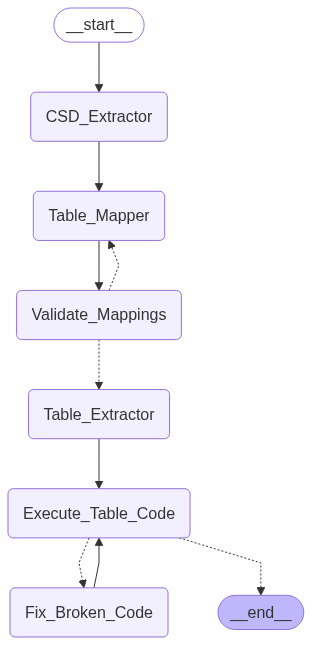


🚀 [CSD_Extractor] Output:
[
  {"csd": "Cohort Creation Steps", "entities": "ICD codes for hypertension, hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, hypertensive encephalopathy\nLab tests for LAVI and LVMI\nProcedure codes for ECHO and ECG\nDrugs for hypertension"},
  {"csd": "Case", "entities": "Lab tests for abnormal LAVI and LVMI\nProcedure codes for ECG and ECHO"},
  {"csd": "Control", "entities": "Lab tests for normal LAVI and LVMI\nICD codes for HHD disease\nProcedure codes for ECG and ECHO"}
]

🚀 [Table_Mapper] Output:
{
  "csd": "ICD codes for hypertension, hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, hypertensive encephalopathy\nLab tests for LAVI and LVMI\nProcedure codes for ECHO and ECG\nDrugs for hypertension",
  "tables": ["DIAGNOSIS_DIM_DIAGNOSIS_CODE", "LAB_SPECIMEN_DIM_LAB_TEST", "PROCEDURES_DIM_PROCEDURE_CODE", "MAR_DIM_MED_NAME"],
  "columns": ["DIAGNOSIS_CODE", "DIAGNOSIS_DESCRIPTION", "LAB_TEST_

In [3]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path


# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Simplify CSD for Extraction ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = /"/"/"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE
/"/"/"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

    

# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "")
    if "# Error:" not in raw_code or "cohort_df = pd.read_sql_query" in raw_code:
        return state


    agent = make_agent(code_fixer_prompt)
    result = agent.invoke({
        "code": raw_code,
        "table_schema": table_schema
    })
    print("\n🛠️ [Code_Fixer] Corrected Code:\n", result.content)
    state["table_fetch_code"] = result.content
    return state





# ---- Execution Agent ----
def clean_code_block(code: str) -> str:
    import re

    # Remove markdown code fences if present
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE)
    code = code.replace("```", "")

    lines = code.strip().splitlines()
    cleaned_lines = []
    found_start = False
    sql_block_open = False

    for i, line in enumerate(lines):
        # Start copying after we hit import/sql/conn
        if not found_start and (line.strip().startswith("import") or line.strip().startswith("conn") or line.strip().startswith("sql_query")):
            found_start = True
        if found_start:
            cleaned_lines.append(line)

        # Track if we are inside the SQL string
        if 'sql_query' in line and '"""' in line:
            sql_block_open = True
        elif sql_block_open and line.strip() == '"""':
            sql_block_open = False
            # Append LIMIT if not present
            if not any("LIMIT" in l.upper() for l in cleaned_lines[-5:]):
                cleaned_lines.insert(len(cleaned_lines) - 1, "LIMIT 1000")

    # Deduplicate trailing execution lines
    seen_exec = set()
    final_lines = []
    for line in cleaned_lines:
        if line.strip() in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if line.strip() in seen_exec:
                continue
            seen_exec.add(line.strip())
        final_lines.append(line)

    # Ensure execution lines exist
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        final_lines.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        final_lines.append("conn.close()")

    code = "\n".join(final_lines).strip()

    # Replace ambiguous DataFrame truth checks (the main fix)
    code = re.sub(
        r"\bif\s*\(?\s*cohort_df\s*\)?\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )

    # Also cover cases with spacing or multiline if statements
    code = re.sub(
        r"\bif\s*\(?\s*cohort_df\s*==\s*True\s*\)?\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )

    # Catch misuse like: `if cohort_df != None:`
    code = re.sub(
        r"\bif\s+cohort_df\s*(!=|==)\s*None\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )
    # At the end of clean_code_block()
    code = "\n".join([line.rstrip() for line in code.splitlines() if line.strip() != ""]).strip()

    return code



def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))

    

def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)

    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    # --- Show numbered code for debugging ---
    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        # repr(line) → shows the Python representation of the string, including quotes and escapes. That means tabs, trailing spaces, and weird characters are visible
        # format the number right-aligned in a field at least 2 characters wide.
        print(f"{i:>2}: {repr(line)}") 
    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {
            "sqlite3": sqlite3,
            "pd": pd,
        }

        # Setup connection
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        # Try executing the code
        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            # ✅ Set error for routing logic
            state["execution_error"] = str(e)
            return state  # 🛑 exit here after catching exec failure

        # Extract resulting DataFrame
        df = local_vars.get("cohort_df")
        if df is None:
            df = global_context.get("cohort_df")

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if df is not None and not df.empty:
                print("✅ DataFrame has data.")
                # state["cohort_df"] = df.copy() 
            elif df is not None and df.empty:
                print("⚠️ Warning: cohort_df is empty.")
            else:
                print("⚠️ DataFrame may not have executed properly.")
                
            state["table_fetch_code"] = code
            state["execution_error"] = ""  # ✅ Clear the error — this signals success
        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"

        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        # ✅ Store error separately — again
        state["execution_error"] = str(e)


    return state


    
    
# ---- Step-wise Validator ----
step_validator_prompt = """
You are validating the output of the step "{step}".
Here is the JSON result:
{output}

Respond with ONLY a JSON object using this format:
{{
  "valid": true or false,
  "errors": ["..."],
  "needs_human": true or false
}}
"""

def make_step_validator(step_key: str, output_key: str):
    def _validate(state):
        retry_count = state.get("retry_count", 0)
        output = state.get(output_key, {})

        print(f"\n🔎 Validation for step: {step_key}")
        print("Output being validated:\n", json.dumps(output, indent=2))

        try:
            result = make_agent(step_validator_prompt).invoke({
                "step": step_key,
                "output": json.dumps(output)
            })
            feedback = json.loads(result.content)
        except json.JSONDecodeError:
            print("❌ Failed to parse validator LLM response. Defaulting to 'valid: false'.")
            feedback = {"valid": False, "errors": ["Invalid JSON from validator"], "needs_human": True}

        if not feedback.get("valid"):
            print(f"\n❌ Validation failed for '{step_key}': {feedback.get('errors')}")
            user_input = input(f"🧑 Do you want to override and proceed anyway? (yes/no): ").strip().lower()
            if user_input in ["yes", "y"]:
                print("✅ Human override accepted. Proceeding to next step.")
                state["retry_count"] = 0
                return {"next_step": None}

            print(f"🔁 Retry #{retry_count + 1} for step '{step_key}'")
            state["last_step"] = step_key
            state["retry_count"] = retry_count + 1
            return {"next_step": step_key}

        state["retry_count"] = 0
        return {"next_step": None}
    return _validate

# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(make_step_validator("Table_Mapper", "mappings")))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))


builder.set_entry_point("CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")
builder.add_conditional_edges("Validate_Mappings", lambda state: state.get("next_step"), {
    "Table_Mapper": "Table_Mapper",
    None: "Table_Extractor"
})
builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda state: "Fix_Broken_Code" if state.get("execution_error") else None,
    {
        "Fix_Broken_Code": "Fix_Broken_Code",
        None: END  # Stop graph if execution_error is empty (i.e., success)
    }
)
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code") 


graph = builder.compile()
# ---- Visualize Graph ----
display(Image(graph.get_graph().draw_mermaid_png()))

# ---- Run Graph ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,
    "simple_csd": [], "mappings": [], "validation": {}, "history": [], "table_fetch_code": "",
    "last_step": "", "retry_count": 0
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])


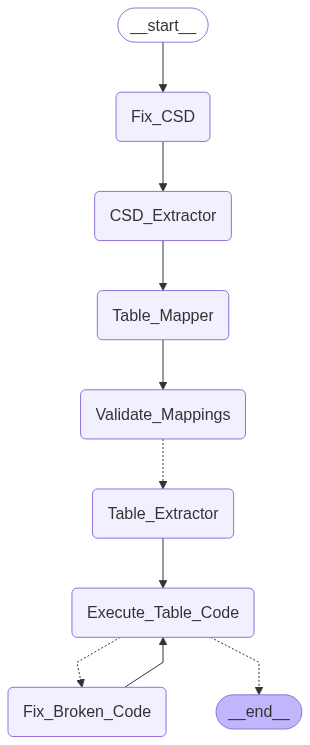

🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.
Case
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
Include patients with LAVI and LVMI available 24 hours from each other
Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
Include patients on treatment for hypertension anytime before to 1 year after the anchor
Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
Ensure that age at the time of ECG ≥ 18 years

Control
Identify patients with disease codes for hypertension or its complications (hyp

In [21]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    csd_fixed: str           #raw multi-line CSD text append initial lines to case and control
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path


# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Expand CSD and put common lines into CASE & CONTROL ----
def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.

    - Keeps text before 'Cohort Creation Steps' as-is
    - Removes the original 'Cohort Creation Steps' block (to avoid duplicates)
    - Rebuilds 'Case' and 'Control' sections with the generic lines prefixed
    - If markers aren't found, returns original CSD unchanged
    """
    if not isinstance(csd, str):
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip()

    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)

    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: dict) -> dict:
    raw = state.get("csd", "")  # dict access, not attribute
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(fixed)
    state["csd_fixed"] = fixed
    state["csd"] = fixed
    return state
    

# ---- Simplify CSD for Extraction ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = /"/"/"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE
/"/"/"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

    

# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "")
    if "# Error:" not in raw_code or "cohort_df = pd.read_sql_query" in raw_code:
        return state


    agent = make_agent(code_fixer_prompt)
    result = agent.invoke({
        "code": raw_code,
        "table_schema": table_schema
    })
    print("\n🛠️ [Code_Fixer] Corrected Code:\n", result.content)
    state["table_fetch_code"] = result.content
    return state





# ---- Execution Agent ----
def clean_code_block(code: str) -> str:
    import re

    # Remove markdown code fences if present
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE)
    code = code.replace("```", "")

    lines = code.strip().splitlines()
    cleaned_lines = []
    found_start = False
    sql_block_open = False

    for i, line in enumerate(lines):
        # Start copying after we hit import/sql/conn
        if not found_start and (line.strip().startswith("import") or line.strip().startswith("conn") or line.strip().startswith("sql_query")):
            found_start = True
        if found_start:
            cleaned_lines.append(line)

        # Track if we are inside the SQL string
        if 'sql_query' in line and '"""' in line:
            sql_block_open = True
        elif sql_block_open and line.strip() == '"""':
            sql_block_open = False
            # Append LIMIT if not present
            if not any("LIMIT" in l.upper() for l in cleaned_lines[-5:]):
                cleaned_lines.insert(len(cleaned_lines) - 1, "LIMIT 1000")

    # Deduplicate trailing execution lines
    seen_exec = set()
    final_lines = []
    for line in cleaned_lines:
        if line.strip() in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if line.strip() in seen_exec:
                continue
            seen_exec.add(line.strip())
        final_lines.append(line)

    # Ensure execution lines exist
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        final_lines.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        final_lines.append("conn.close()")

    code = "\n".join(final_lines).strip()

    # Replace ambiguous DataFrame truth checks (the main fix)
    code = re.sub(
        r"\bif\s*\(?\s*cohort_df\s*\)?\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )

    # Also cover cases with spacing or multiline if statements
    code = re.sub(
        r"\bif\s*\(?\s*cohort_df\s*==\s*True\s*\)?\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )

    # Catch misuse like: `if cohort_df != None:`
    code = re.sub(
        r"\bif\s+cohort_df\s*(!=|==)\s*None\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )
    # At the end of clean_code_block()
    code = "\n".join([line.rstrip() for line in code.splitlines() if line.strip() != ""]).strip()

    return code



def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))

    

def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)

    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    # --- Show numbered code for debugging ---
    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        # repr(line) → shows the Python representation of the string, including quotes and escapes. That means tabs, trailing spaces, and weird characters are visible
        # format the number right-aligned in a field at least 2 characters wide.
        print(f"{i:>2}: {repr(line)}") 
    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {
            "sqlite3": sqlite3,
            "pd": pd,
        }

        # Setup connection
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        # Try executing the code
        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            # ✅ Set error for routing logic
            state["execution_error"] = str(e)
            return state  # 🛑 exit here after catching exec failure

        # Extract resulting DataFrame
        df = local_vars.get("cohort_df")
        if df is None:
            df = global_context.get("cohort_df")

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if df is not None and not df.empty:
                print("✅ DataFrame has data.")
            elif df is not None and df.empty:
                print("⚠️ Warning: cohort_df is empty.")
            else:
                print("⚠️ DataFrame may not have executed properly.")
                
            state["table_fetch_code"] = code
            state["execution_error"] = ""  # ✅ Clear the error — this signals success
        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"

        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        # ✅ Store error separately — again
        state["execution_error"] = str(e)


    return state


#===== Validator ======
def validate_and_dedupe_mappings(state: dict) -> dict:
    raw = state.get("mappings", [])
    good, seen = [], set()
    for m in raw:
        if not isinstance(m, dict):
            continue
        tables  = [t.strip().upper() for t in m.get("tables", []) if isinstance(t, str)]
        columns = [c.strip().upper() for c in m.get("columns", []) if isinstance(c, str)]
        if not tables and not columns:
            continue
        key = json.dumps({"tables":sorted(tables), "columns":sorted(columns)}, sort_keys=True)
        if key in seen:
            continue  # <-- de-dup identical entries (Case vs Control)
        seen.add(key)
        good.append({"csd": m.get("csd",""), "tables":tables, "columns":columns})
    state["mappings"] = good
    state["next_step"] = None  # keep graph happy
    state["retry_count"] = 0
    print("✅ [Validate_Mappings] kept:", json.dumps(good, indent=2))
    return state
    


# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(validate_and_dedupe_mappings))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))


builder.set_entry_point("Fix_CSD")
builder.add_edge("Fix_CSD", "CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges("Validate_Mappings", lambda s: s.get("next_step"), { None: "Table_Extractor" })

builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda state: "Fix_Broken_Code" if state.get("execution_error") else None,
    {
        "Fix_Broken_Code": "Fix_Broken_Code",
        None: END  # Stop graph if execution_error is empty (i.e., success)
    }
)
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code") 


graph = builder.compile()
# ---- Visualize Graph ----
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Mermaid render failed:", e)


# ---- Run Graph ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,
    "simple_csd": [], "mappings": [], "validation": {}, "history": [], "table_fetch_code": "",
    "last_step": "", "retry_count": 0
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])


In [16]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re, inspect
import pandas as pd
import sqlite3

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    csd_fixed: str           #raw multi-line CSD text append initial lines to case and control
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path
    cohort_df_path: str
    cohort_df: Any
    case_df_path: str
    control_df_path: str
    case_filter_log: List[dict]
    control_filter_log: List[dict]
    case_plan: List[dict]
    control_plan: List[dict]




# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Expand CSD and put common lines into CASE & CONTROL ----
def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.

    - Keeps text before 'Cohort Creation Steps' as-is
    - Removes the original 'Cohort Creation Steps' block (to avoid duplicates)
    - Rebuilds 'Case' and 'Control' sections with the generic lines prefixed
    - If markers aren't found, returns original CSD unchanged
    """
    if not isinstance(csd, str):
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip()

    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)

    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: dict) -> dict:
    raw = state.get("csd", "")  # dict access, not attribute
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(fixed)
    state["csd_fixed"] = fixed
    state["csd"] = fixed
    return state
    

# ---- Simplify CSD for Extraction ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = /"/"/"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE
/"/"/"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

    

# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "") or ""
    err = (state.get("execution_error") or "").strip()

    if not raw_code:
        return state

    changed = False

    # Always apply the general cleanup
    patched = clean_code_block(raw_code)
    if patched != raw_code:
        raw_code = patched
        changed = True

    # If the failure was a missing alias/column, try to rewrite the SQL
    m = re.search(r"no such column:\s*([A-Za-z_]\w*)\.([A-Za-z_]\w*)", err, flags=re.I)
    if m:
        bad_alias, bad_col = m.group(1), m.group(2)
        sql, i0, i1 = _pull_sql_string(raw_code)
        if sql:
            # Build alias -> table map (FROM / JOIN with or without AS)
            alias_map = {}
            for t, a in re.findall(r"\bFROM\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t
            for t, a in re.findall(r"\bJOIN\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t

            # Introspect columns for each table
            try:
                conn = sqlite3.connect("synthetic_ehr.db")
                alias_cols = {}
                for a, t in alias_map.items():
                    try:
                        rows = conn.execute(f"PRAGMA table_info('{t}')").fetchall()
                        alias_cols[a] = {r[1].upper() for r in rows}
                    except Exception:
                        alias_cols[a] = set()
                conn.close()
            except Exception:
                alias_cols = {}

            target_alias = next((a for a, cols in alias_cols.items() if bad_col.upper() in cols), None)

            if target_alias:
                # Replace bad_alias.bad_col -> target_alias.bad_col (case-insensitive)
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    f"{target_alias}.{bad_col}",
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Replaced {bad_alias}.{bad_col} → {target_alias}.{bad_col}")
            else:
                # Fallback: unqualify the column so SQLite can resolve if unique
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    bad_col,
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Unqualified {bad_alias}.{bad_col} → {bad_col}")

    if changed:
        state["table_fetch_code"] = raw_code
        # clear the error so the graph re-runs Execute_Table_Code once
        state["execution_error"] = ""
    else:
        print("\nℹ️ [Code_Fixer] No changes applied to code.")
    return state




def _pull_sql_string(code: str) -> tuple[str, int, int]:
    """Return (sql_text, start_idx, end_idx) for the triple-quoted sql_query string inside code."""
    m = re.search(r'sql_query\s*=\s*("""|\'\'\')(.+?)\1', code, flags=re.S)
    if not m:
        return "", -1, -1
    return m.group(2), m.start(2), m.end(2)

# already suggested earlier; keep it if not present
def _truthy_df(x):
    try:
        return (x is not None) and hasattr(x, "empty") and (not x.empty)
    except Exception:
        return bool(x)

def _patch_df_truthiness_anywhere(code: str) -> str:
    candidates = set(re.findall(r"(\w+)\s*=\s*pd\.read_sql_query\(", code))
    candidates |= set(re.findall(r"(\w+)\s*=\s*pd\.DataFrame\(", code))
    candidates |= set(re.findall(r"\b([A-Za-z_]\w*(?:_df|DF))\b", code))
    candidates |= {"df", "cohort_df", "result_df", "joined_df"}

    if not candidates:
        return code

    def _wrap_tokens(cond: str) -> str:
        for v in sorted(candidates, key=len, reverse=True):
            cond = re.sub(
                rf"\b{re.escape(v)}\b(?!\s*(?:\.|\[|\(|is\b|==|!=))",
                f"_truthy_df({v})",
                cond,
            )
        return cond

    def _repl_if(m):
        return f"if {_wrap_tokens(m.group(1))}:"

    code = re.sub(r"^\s*if\s+(.+):\s*$", _repl_if, code, flags=re.MULTILINE)

    for v in sorted(candidates, key=len, reverse=True):
        code = re.sub(
            rf"\band\s+{re.escape(v)}\b(?!\s*(?:\.|\[|\(|is\b|==|!=))",
            f"and _truthy_df({v})",
            code,
        )
        code = re.sub(
            rf"\bor\s+{re.escape(v)}\b(?!\s*(?:\.|\[|\(|is\b|==|!=))",
            f"or _truthy_df({v})",
            code,
        )

    return code


# ---- Execution Agent ----
def clean_code_block(code: str) -> str:
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE).replace("```", "")
    code = "\n".join([ln for ln in code.splitlines() if ln.strip()]).strip()

    # Ensure LIMIT inside SQL
    lines, cleaned, in_sql = code.splitlines(), [], False
    for ln in lines:
        stripped = ln.strip()
        if re.search(r'^\s*sql_query\s*=\s*("""|\'\'\')\s*$', ln):
            in_sql = True; cleaned.append(ln); continue
        if in_sql and stripped in ('"""', "'''"):
            window = cleaned[-12:] if len(cleaned) >= 12 else cleaned[:]
            if not any(" LIMIT " in x.upper() or x.strip().upper().startswith("LIMIT ") for x in window):
                cleaned.append("LIMIT 1000")
            in_sql = False; cleaned.append(ln); continue
        cleaned.append(ln)
    code = "\n".join(cleaned)

    # Greedy patch for ANY bare-DataFrame truthiness
    code = _patch_df_truthiness_anywhere(code)

    # Dedup & ensure execution lines
    seen_exec, out = set(), []
    for ln in code.splitlines():
        s = ln.strip()
        if s in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if s in seen_exec: continue
            seen_exec.add(s)
        out.append(ln)
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        out.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        out.append("conn.close()")
    return "\n".join(out).strip()





def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))


def _first_df(*vals):
    """Return the first value that is a pandas DataFrame, else None."""
    for v in vals:
        if isinstance(v, pd.DataFrame):
            return v
    return None

def _regex_extract_sql_from_code(code: str) -> str:
    """Extract the contents of sql_query = \"\"\"...\"\"\" (or single/double quoted)."""
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    return ""


def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)
    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        print(f"{i:>2}: {repr(line)}")

    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {"sqlite3": sqlite3, "pd": pd}

        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            state["execution_error"] = str(e)
            return state

        df = _first_df(local_vars.get("cohort_df"), global_context.get("cohort_df"))

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if not df.empty:
                print("✅ DataFrame has data.")
            else:
                print("⚠️ Warning: cohort_df is empty.")

            # persist to CSV
            csv_path = "cohort_df.csv"
            try:
                df.to_csv(csv_path, index=False)
                print(f"💾 Saved cohort_df → {csv_path}")
                state["cohort_df_path"] = csv_path
            except Exception as e:
                print(f"⚠️ Could not save cohort_df to CSV: {e}")
                state["cohort_df_path"] = ""

            state["cohort_df"] = df.copy()
            state["table_fetch_code"] = code
            state["execution_error"] = ""

            # --- OPTIONAL: also save the exact SQL that ran ---
            sql_str = local_vars.get("sql_query") or global_context.get("sql_query")
            if not isinstance(sql_str, str) or not sql_str.strip():
                sql_str = _regex_extract_sql_from_code(code)
            if isinstance(sql_str, str) and sql_str.strip():
                try:
                    with open("final_working_query.sql", "w", encoding="utf-8") as f:
                        f.write(sql_str.strip() + "\n")
                    # add these fields to GraphState if you want static typing
                    state["final_sql_query"] = sql_str.strip()
                    state["final_sql_path"]  = "final_working_query.sql"
                    print("💾 Saved final SQL → final_working_query.sql")
                except Exception as e:
                    print(f"⚠️ Could not save final SQL: {e}")

        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"


        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        state["execution_error"] = str(e)

    return state



#===== Validator ======
def validate_and_dedupe_mappings(state: dict) -> dict:
    raw = state.get("mappings", [])
    good, seen = [], set()
    for m in raw:
        if not isinstance(m, dict):
            continue
        tables  = [t.strip().upper() for t in m.get("tables", []) if isinstance(t, str)]
        columns = [c.strip().upper() for c in m.get("columns", []) if isinstance(c, str)]
        if not tables and not columns:
            continue
        key = json.dumps({"tables":sorted(tables), "columns":sorted(columns)}, sort_keys=True)
        if key in seen:
            continue  # <-- de-dup identical entries (Case vs Control)
        seen.add(key)
        good.append({"csd": m.get("csd",""), "tables":tables, "columns":columns})
    state["mappings"] = good
    state["next_step"] = None  # keep graph happy
    state["retry_count"] = 0
    print("✅ [Validate_Mappings] kept:", json.dumps(good, indent=2))
    return state
    


def _split_case_control_lines(csd: str) -> tuple[list[str], list[str]]:
    """Return (case_lines, control_lines) after Fix_CSD has prefixed common lines."""
    txt = (csd or "").replace("\r\n", "\n")
    m_case   = re.search(r'^\s*Case\s*:?\s*$', txt, re.I|re.M)
    m_ctrl   = re.search(r'^\s*Control\s*:?\s*$', txt, re.I|re.M)
    if not (m_case and m_ctrl):  # nothing to split
        return [], []
    case_block = txt[m_case.end():m_ctrl.start()]
    ctrl_block = txt[m_ctrl.end():]
    norm = lambda b: [ln.strip() for ln in b.splitlines() if ln.strip()]
    return norm(case_block), norm(ctrl_block)



# loader for filter funcs
def _load_filter_lib(path: str = "Filter_func.txt") -> dict:
    ns: dict = {}
    try:
        with open(path, "r", encoding="utf-8") as f:
            raw = f.read()
        lines   = raw.splitlines()
        futures = [ln for ln in lines if ln.strip().startswith("from __future__ import ")]
        others  = [ln for ln in lines if not ln.strip().startswith("from __future__ import ")]
        fixed   = "\n".join(futures + [""] + others)
        exec(compile(fixed, path, "exec"), ns)
        # Some helpers reference a global 'log_stats'. Provide a safe default.
        if "log_stats" not in ns:
            ns["log_stats"] = lambda *a, **k: None
    except Exception as e:
        print(f"⚠️ Could not load filter helpers from {path}: {e}")
    return ns



def _strip_code_fences(s: str) -> str:
    s = s.strip()
    if s.startswith("```"):
        s = re.sub(r"^```(?:json|JSON|python)?\s*", "", s)
        s = re.sub(r"\s*```$", "", s)
    return s.strip()

def _coerce_json(s: str) -> dict:
    if not isinstance(s, str):
        return {}
    s0 = _strip_code_fences(s)
    try:
        return json.loads(s0)
    except Exception:
        s1 = (s0.replace("\r", "")
                .replace("\n", " ")
                .replace(" True", " true")
                .replace(" False", " false")
                .replace(" None", " null"))
        try:
            return json.loads(s1)
        except Exception:
            i, j = s0.find("{"), s0.rfind("}")
            if i != -1 and j != -1 and j > i:
                try:
                    return json.loads(s0[i:j+1])
                except Exception:
                    return {}

_QUERY_KWS = {"and","or","not","in","True","False","None"}
def _unknown_tokens_in_expr(df: pd.DataFrame, expr: str) -> list[str]:
    tokens = re.findall(r"[A-Za-z_][A-Za-z0-9_]*", expr or "")
    cols = set(df.columns)
    return [t for t in tokens if t not in cols and t not in _QUERY_KWS]

def _first_present(df: pd.DataFrame, names: list[str]) -> str | None:
    return next((c for c in names if c in df.columns), None)

def _has(df: pd.DataFrame, *cols: str) -> bool:
    return all(c in df.columns for c in cols)

def _find_helper(F: dict, name: str) -> Optional[Callable[..., Any]]:
    fn = F.get(name)
    return fn if callable(fn) else None



def _sanitize_plans(df: pd.DataFrame,
                    case_plan: list[dict],
                    control_plan: list[dict],
                    F: dict) -> tuple[list[dict], list[dict]]:

    # choose an age helper from Filter_func.txt
    age_fn = (_find_helper(F, ["filter_age_gte","age_gte","min_age","agefilter","age"], ["df","event_col","dob_col","min_age"])
              or _find_helper(F, ["filter_age_gte","age_gte","age"], ["df","event_col","dob_col"]))  # softer fallback

    def fix(plan: list[dict]) -> list[dict]:
        out = []
        for st in (plan or []):
            st = dict(st)  # copy
            t  = st.get("type")
            ln = (st.get("line") or "")
            if t == "pandas_query":
                expr = (st.get("expr") or st.get("query") or "").strip()

                # If this CSD line is the AGE requirement, convert to a helper call
                if re.search(r"\bage\b", ln.lower()) and ("18" in ln or "≥" in ln or ">= 18" in ln):
                    event_col = _first_present(df, ["EVENT_DTM","NFER_DTM","TIMESTAMP","TIME"])
                    dob_col   = _first_present(df, ["PATIENT_BIRTH_DATE","DOB","BIRTH_DATE","DATE_OF_BIRTH"])
                    if age_fn and event_col and dob_col:
                        out.append({
                            "type":"call_filter_func",
                            "fn":age_fn,
                            "kwargs":{
                                # pass a *superset*; we'll filter by signature on call
                                "df": None, "df_merged": None,
                                "event_col": event_col, "event_column": event_col, "event_dtm": event_col,
                                "dob_col": dob_col, "birth_date_col": dob_col, "dob_column": dob_col,
                                "min_age": 18, "age": 18, "threshold": 18
                            },
                            "line": ln
                        })
                        continue
                    else:
                        # can't build an age helper; drop unsafe query
                        st["type"] = "noop"
                        st["_skip_reason"] = "no age helper or required columns"
                        st["expr"] = ""
                        out.append(st)
                        continue

                # Otherwise keep query only if all tokens are known
                bad = _unknown_tokens_in_expr(df, expr)
                if bad:
                    st["type"] = "noop"
                    st["_skip_reason"] = f"invalid tokens in expression: {bad}"
                    st["expr"] = ""
                else:
                    st["expr"] = expr
                out.append(st)

            elif t == "temporal_within":
                if st.get("anchor") not in df.columns or st.get("window") not in df.columns:
                    st["type"] = "noop"
                    st["_skip_reason"] = "missing anchor/window columns"
                out.append(st)

            else:
                out.append(st)

        return out

    return fix(case_plan), fix(control_plan)
  

# --- built-in fallback for age rule (if helper file doesn't provide one) ------
def _filter_age_gte(df: pd.DataFrame, event_col: str, dob_col: str, min_age: float) -> pd.DataFrame:
    ev = pd.to_datetime(df[event_col], errors="coerce")
    dob = pd.to_datetime(df[dob_col],   errors="coerce")
    age_years = (ev - dob).dt.days / 365.25
    return df[age_years >= float(min_age)]

def _infer_keys(df: pd.DataFrame) -> List[str]:
    pid = None
    for c in ["PATIENT_ID","NFER_PID","PERSON_ID","PID"]:
        if c in df.columns: pid = c; break
    tcol = None
    for c in ["EVENT_DTM","NFER_DTM","ECG_TIME","ECHO_EVENT_DTM","TIMESTAMP","DTM","TIME"]:
        if c in df.columns: tcol = c; break
    return [k for k in [pid, tcol] if k]

def _safe_query(df: pd.DataFrame, expr: str) -> pd.DataFrame:
    try:
        return df.query(expr, engine="python")
    except Exception as e:
        print(f"⚠️ pandas_query failed ({e}). Expr was: {expr!r}. Skipping step.")
        return df

def _apply_plan(df_in: pd.DataFrame, steps: list[dict], F: dict, cohort_name: str):
    logs: list[dict] = []
    df = df_in.copy()

    for i, st in enumerate(steps or [], 1):
        stype = st.get("type", "noop")
        line  = st.get("line", "")
        before = len(df)
        status = "ok"
        err = ""
        py_cmd = ""

        try:
            if stype == "dedupe":
                keys = [k for k in st.get("keys", []) if k in df.columns]
                if not keys:
                    status = "skipped"
                    py_cmd = "# dedupe skipped (no valid keys)"
                else:
                    py_cmd = f"df = df.drop_duplicates(subset={keys!r}, keep='first')"
                    df = df.drop_duplicates(subset=keys, keep="first")

            elif stype == "call_filter_func":
                fn_name = st.get("fn")
                fn = _find_helper(F, fn_name)
                if not fn:
                    status = "skipped"; py_cmd = f"# function {fn_name} not found"
                else:
                    # filter kwargs to match helper signature
                    sig = inspect.signature(fn)
                    kwargs = dict(st.get("kwargs", {}))
                    # if the helper expects a DataFrame param, ensure we pass it
                    for df_param in ["df", "df_merged", "df_anchor", "df_window"]:
                        if df_param in sig.parameters and df_param not in kwargs:
                            kwargs[df_param] = df
                    # fit kwargs to allowed parameters
                    kwargs = {k: v for k, v in kwargs.items() if k in sig.parameters}
                    py_cmd = f"df = {fn_name}(**{kwargs!r})"
                    df = fn(**kwargs)

            elif stype == "age_gte":
                # Build using your get_age helper
                get_age = _find_helper(F, "get_age")
                event_col = st.get("event_col")
                dob_col   = st.get("dob_col")
                min_age   = int(st.get("min_age", 18))
                if get_age and _has(df, event_col, dob_col):
                    py_cmd = (
                        f"df['__AGE'] = df.apply(lambda r: get_age(r[{dob_col!r}], r[{event_col!r}]), axis=1); "
                        f"df = df[df['__AGE'] >= {min_age}].drop(columns=['__AGE'])"
                    )
                    df["__AGE"] = df.apply(lambda r: get_age(r[dob_col], r[event_col]), axis=1)
                    df = df[df["__AGE"] >= min_age].drop(columns=["__AGE"])
                else:
                    status = "skipped"
                    py_cmd = "# age_gte skipped (get_age or columns missing)"

            else:
                status = "skipped"
                py_cmd = f"# unknown/unsupported step type: {stype}"

        except Exception as e:
            status = "error"
            err = str(e)

        after = len(df)
        logs.append({
            "step": i, "type": stype, "line": line, "status": status, "error": err,
            "rows_before": before, "rows_after": after, "rows_removed": before - after,
            "applied_python": py_cmd
        })

    return df, logs


def _plan_from_csd(df: pd.DataFrame, F: dict, csd_text: str):
    # Candidate columns we know how to use
    pid = _first_present(df, ["PATIENT_ID", "NFER_PID", "PERSON_ID", "PID"])
    echo_id = _first_present(df, ["ECHO_TEST_FPK", "ECHO_ID"])
    # datetimes (only add temporal step if both present)
    echo_time = _first_present(df, ["ECHO_EVENT_DTM", "ECHO_RESULT_EVENT_DTM", "EVENT_DTM"])
    ecg_time  = _first_present(df, ["ECG_EVENT_DTM", "ECG_TIME", "EVENT_DTM"])

    case_steps: list[dict] = []
    ctrl_steps: list[dict] = []

    # 1) dedupe: prefer patient + echo id, else patient only
    dedupe_keys = [c for c in [pid, echo_id] if c]
    if dedupe_keys:
        step = {"type":"dedupe", "keys": dedupe_keys, "line":"Identify unique patients and ECHO tests"}
        case_steps.append(step); ctrl_steps.append(step.copy())

    # 2) +/- 3 month window around anchor (use your helper only if we have two datetime cols)
    if _find_helper(F, "apply_within_temporal_filter") and echo_time and ecg_time and echo_time != ecg_time:
        tstep = {
            "type":"call_filter_func",
            "fn":"apply_within_temporal_filter",
            "kwargs":{
                "df_merged": None,                     # will be injected by _apply_plan
                "anchor_column": echo_time,            # ECHO times as anchor
                "window_column": ecg_time,             # ECG times as windowed events
                "time_window": [-90, 90],
                "time_unit": "days",
                "left_inclusive": True,
                "right_inclusive": True
            },
            "line":"Identify the most recent ECHO with ECGs around it in a +/- 3 month window"
        }
        case_steps.append(tstep); ctrl_steps.append(tstep.copy())

    # 3) one ECG per patient (if helper exists and we have a patient id)
    if _find_helper(F, "filter_one_ecg_per_patient") and pid:
        s = {
            "type":"call_filter_func",
            "fn":"filter_one_ecg_per_patient",
            "kwargs":{"df": None, "pid_col": pid},
            "line":"Keep one ECG per patient if required"
        }
        # This is optional — include only if you want to collapse to one ECG
        # case_steps.append(s); ctrl_steps.append(s.copy())

    # 4) Age ≥ 18 using your get_age (requires DOB + event time)
    dob_col   = _first_present(df, ["PATIENT_BIRTH_DATE","DOB","BIRTH_DATE","DATE_OF_BIRTH"])
    event_col = _first_present(df, ["ECG_EVENT_DTM","EVENT_DTM","ECHO_EVENT_DTM","NFER_DTM","TIMESTAMP","TIME"])
    if _find_helper(F, "get_age") and dob_col and event_col:
        a = {"type":"age_gte", "event_col": event_col, "dob_col": dob_col, "min_age": 18,
             "line":"Ensure that age at the time of ECG ≥ 18 years"}
        case_steps.append(a); ctrl_steps.append(a.copy())

    # NOTE: Lines about LAVI/LVMI, HHD before anchor, etc. are omitted unless the
    # necessary columns exist. You can extend this deterministically once those appear.

    return case_steps, ctrl_steps





# === NEW: CASE/CONTROL filter planning ===
filter_plan_prompt = """
You are planning filters for CASE and CONTROL cohorts based on the CSD.
Use ONLY the columns that actually exist in the input DataFrame: {columns}.

Allowed step types (JSON objects):
- {{ "type":"dedupe", "keys":["..."] }}
- {{ "type":"pandas_query", "expr":"<pandas boolean expression using only existing columns>" }}
- {{ "type":"temporal_within", "anchor":"ANCHOR_EVENT_DTM", "window":"EVENT_DTM",
     "time_window_days":[-90,90], "left_inclusive":true, "right_inclusive":true }}
- {{ "type":"call_filter_func", "fn":"apply_within_temporal_filter",
     "kwargs":{{"anchor_column":"ANCHOR_EVENT_DTM","window_column":"EVENT_DTM",
               "time_window":[-90,90],"time_unit":"days",
               "left_inclusive":true,"right_inclusive":true}} }}

Every step MUST include a "line" field with the CSD sentence it implements.

Rules:
- If a referenced column doesn’t exist, prefer a simpler equivalent that does (or omit the step).
- Start with a dedupe when both patient/time keys exist (e.g., PATIENT_ID+EVENT_DTM or NFER_PID+NFER_DTM).
- Use 'pandas_query' for simple value/flag filters.
- Use the temporal step only if both columns exist.
- Do not invent columns or functions.

Return ONLY JSON:
{{ "case":[{{...}}], "control":[{{...}}] }}

CSD:
{csd}
"""


# === Build CASE/CONTROL cohorts from cohort_df ===
def plan_and_apply_filters(state: dict) -> dict:
    # Prefer CSV written by Execute_Table_Code
    df = None
    csv_path = state.get("cohort_df_path")

    if csv_path:
        try:
            df = pd.read_csv(csv_path)
            print(f"📥 Loaded cohort_df from {csv_path} (shape={df.shape})")
            # best-effort datetime parsing on obvious columns
            for col in [c for c in df.columns if any(k in c.upper() for k in ["DTM", "DATE", "TIME"])]:
                try:
                    df[col] = pd.to_datetime(df[col], errors="ignore")
                except Exception:
                    pass
        except Exception as e:
            print(f"⚠️ Failed to read {csv_path}: {e}. Falling back to in-memory DataFrame.")

    if not isinstance(df, pd.DataFrame):
        df = state.get("cohort_df")

    if not isinstance(df, pd.DataFrame):
        print("⚠️ No cohort_df present — skipping filter agent.")
        state["case_plan"] = []; state["control_plan"] = []
        state["case_filter_log"] = []; state["control_filter_log"] = []
        state["case_df_path"] = ""; state["control_df_path"] = ""
        return state

    F = _load_filter_lib()
    print("have get_age:", callable(F.get("get_age")))
    print("have apply_within_temporal_filter:", callable(F.get("apply_within_temporal_filter")))

    case_plan, ctrl_plan = _plan_from_csd(df, F, state.get("csd",""))

    case_df, case_log = _apply_plan(df, case_plan, F, "CASE")
    ctrl_df, ctrl_log = _apply_plan(df, ctrl_plan, F, "CONTROL")

    # Persist outputs
    case_path, ctrl_path = "case_filtered.parquet", "control_filtered.parquet"
    try:
        case_df.to_parquet(case_path, index=False)
        ctrl_df.to_parquet(ctrl_path, index=False)
    except Exception:
        case_path, ctrl_path = "case_filtered.csv", "control_filtered.csv"
        case_df.to_csv(case_path, index=False)
        ctrl_df.to_csv(ctrl_path, index=False)

    state["case_plan"] = case_plan
    state["control_plan"] = ctrl_plan
    state["case_filter_log"] = case_log
    state["control_filter_log"] = ctrl_log
    state["case_df_path"] = case_path
    state["control_df_path"] = ctrl_path

    def _print(log, name):
        print(f"\n📉 {name} step-wise row changes:")
        for r in log:
            print(f"  • Step {r['step']} ({r['type']}, {r['status']}): -{r['rows_removed']}  "
                  f"[{r['rows_before']} → {r['rows_after']}] — {r.get('line','')[:120]}")
            if r.get("applied_python"):
                print(f"      ↳ {r['applied_python']}")
            if r.get("error"):
                print(f"      ⚠️ {r['error']}")

    _print(case_log, "CASE")
    _print(ctrl_log, "CONTROL")

    return state



    

# === Filter validator ===
filter_validator_prompt = """
You are validating whether the applied filter steps cover the CSD instructions.

Return ONLY JSON:
{{ 
  "case":[{{"line":"...", "matched_step": null, "valid": true, "explanation":"..."}}], 
  "control":[{{"line":"...", "matched_step": null, "valid": true, "explanation":"..."}}]
}}

CSD (lines):
{csd_lines}

CASE plan (steps):
{case_plan}

CASE logs (rows removed etc.):
{case_log}

CONTROL plan (steps):
{control_plan}

CONTROL logs (rows removed etc.):
{control_log}
"""

def validate_filters(state: dict) -> dict:
    def _all_ok(logs: list[dict]) -> bool:
        # valid if there is at least one step and none is 'error'
        return bool(logs) and all(x["status"] == "ok" for x in logs)

    case_ok = _all_ok(state.get("case_filter_log", []))
    ctrl_ok = _all_ok(state.get("control_filter_log", []))

    # If both sides are clean, we're done
    if case_ok and ctrl_ok:
        print("\n✅ Filter validation: OK")
        state["filter_validation"] = {"case":"ok","control":"ok"}
        return state

    # Retry once: prune failing/skipped steps and re-apply
    retry_count = state.get("filter_retry_count", 0)
    if retry_count >= 1:
        print("\n⚠️ Validation still failing after retry. Keeping the best-effort cohorts.")
        state["filter_validation"] = {"case":"retry_failed" if not case_ok else "ok",
                                      "control":"retry_failed" if not ctrl_ok else "ok"}
        return state

    print("\n🔁 Validation failed — retrying with only successful steps…")
    state["filter_retry_count"] = retry_count + 1

    # Keep only steps that ran OK
    def keep_ok(steps: list[dict], logs: list[dict]) -> list[dict]:
        ok_idx = {i for i, lg in enumerate(logs) if lg.get("status") == "ok"}
        return [st for i, st in enumerate(steps) if i in ok_idx]

    case_steps = keep_ok(state.get("case_plan", []), state.get("case_filter_log", []))
    ctrl_steps = keep_ok(state.get("control_plan", []), state.get("control_filter_log", []))

    F = _load_filter_lib()
    base_df = state.get("cohort_df")

    case_df, case_log = _apply_plan(base_df, case_steps, F, "CASE(retry)")
    ctrl_df, ctrl_log = _apply_plan(base_df, ctrl_steps, F, "CONTROL(retry)")

    # Persist
    case_path, ctrl_path = "case_filtered.parquet", "control_filtered.parquet"
    try:
        case_df.to_parquet(case_path, index=False)
        ctrl_df.to_parquet(ctrl_path, index=False)
    except Exception:
        case_path, ctrl_path = "case_filtered.csv", "control_filtered.csv"
        case_df.to_csv(case_path, index=False)
        ctrl_df.to_csv(ctrl_path, index=False)

    state["case_plan"] = case_steps
    state["control_plan"] = ctrl_steps
    state["case_filter_log"] = case_log
    state["control_filter_log"] = ctrl_log
    state["case_df_path"] = case_path
    state["control_df_path"] = ctrl_path

    # Mark validation result
    state["filter_validation"] = {
        "case": "ok" if all(x["status"]=="ok" for x in case_log) else "best_effort",
        "control": "ok" if all(x["status"]=="ok" for x in ctrl_log) else "best_effort",
    }

    return state

def save_table_fetch_code(state: dict, path: str = "final_table_fetch_code.py") -> str | None:
    """Save the LLM-generated Python block from state['table_fetch_code'] to a .py file.
    Strips markdown fences if the model returned them."""
    code = state.get("table_fetch_code", "") or ""
    # strip markdown fences, if your helper exists use it; otherwise do a quick strip here
    try:
        code = _strip_code_fences(code)  # you already defined this in your file
    except NameError:
        import re
        code = re.sub(r"^```(?:python)?\s*", "", code.strip(), flags=re.IGNORECASE)
        code = re.sub(r"\s*```$", "", code)

    if not code.strip():
        print("⚠️ No table_fetch_code to save.")
        return None

    with open(path, "w", encoding="utf-8") as f:
        if not code.endswith("\n"):
            code += "\n"
        f.write(code)

    print(f"💾 Saved table_fetch_code → {path}")
    return path



# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(validate_and_dedupe_mappings))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))
builder.add_node("Plan_And_Apply_Filters", RunnableLambda(plan_and_apply_filters))
builder.add_node("Validate_Filters", RunnableLambda(validate_filters))


builder.set_entry_point("Fix_CSD")
builder.add_edge("Fix_CSD", "CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges("Validate_Mappings", lambda s: s.get("next_step"), { None: "Table_Extractor" })

builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda state: "Fix_Broken_Code" if state.get("execution_error") else "Plan_And_Apply_Filters",
    {"Fix_Broken_Code": "Fix_Broken_Code",
     "Plan_And_Apply_Filters": "Plan_And_Apply_Filters"}
)
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code")   
builder.add_edge("Plan_And_Apply_Filters", "Validate_Filters")
builder.add_edge("Validate_Filters", END)

graph = builder.compile()
# ---- Visualize Graph ----
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Mermaid render failed:", e)


# ---- Run Graph ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,"csd_fixed" :"","execution_error":"",
    "simple_csd": [], "mappings": [], "table_fetch_code": "",
    "last_step": "", "retry_count": 0,"cohort_df": None,"case_df_path": "","control_df_path": "",
    "case_filter_log": [],"control_filter_log": [],"case_plan": [],"control_plan": [],"cohort_df_path": "",
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])

# Save the code to a .py file
save_table_fetch_code(final_state, path="table_fetch_code_final.py")

### Complete DataFetching Agent - Working good

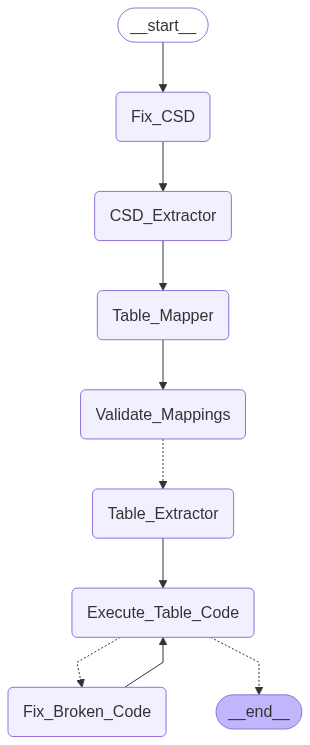

🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.
Case
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
Include patients with LAVI and LVMI available 24 hours from each other
Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
Include patients on treatment for hypertension anytime before to 1 year after the anchor
Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
Ensure that age at the time of ECG ≥ 18 years

Control
Identify patients with disease codes for hypertension or its complications (hyp

'table_fetch_code_final.py'

In [45]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    csd_fixed: str           # raw multi-line CSD text append initial lines to case and control
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path
    final_sql_query: str
    final_sql_path: str
    cohort_df_path: str
    cohort_df: str
    next_step: Optional[str]

# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Expand CSD and put common lines into CASE & CONTROL ----
def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.

    - Keeps text before 'Cohort Creation Steps' as-is
    - Removes the original 'Cohort Creation Steps' block (to avoid duplicates)
    - Rebuilds 'Case' and 'Control' sections with the generic lines prefixed
    - If markers aren't found, returns original CSD unchanged
    """
    if not isinstance(csd, str): #check if csd is a string else return unchanged
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip() #Normalizes newlines; trims leading/trailing whitespace.

    #looks for headers in CSD
    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)
    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure. If either “Case” or “Control” is missing, bail out safely.
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: dict) -> dict:
    raw = state.get("csd", "") 
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(fixed)
    state["csd_fixed"] = fixed
    state["csd"] = fixed
    return state
    

# ---- Simplify CSD for Extraction ignoring temporal logic ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 (synthetic_ehr and pandas) that fetches all relevant data from these tables.

Hard rules:
- JOIN on `PATIENT_ID` or `NFER_PID` when needed. Always use table aliases and refer to columns as <alias>.<col>.
- Do NOT use SELECT *.
- Select exactly ONE ID column and alias it as `patient_id` in the SELECT list:
    Priority to choose from (first present in the joined tables): PATIENT_ID, NFER_PID, PERSON_ID, SUBJECT_ID.
    Example: SELECT a.PATIENT_ID AS patient_id, ...
- Select exactly ONE datetime column that represents the event time and alias it as `event_dtm` in the SELECT list:
    Priority to choose from (first present): EVENT_DTM, MEASUREMENT_DTM, OBSERVATION_DTM, ORDER_DTM, RESULT_DTM, DTTM, DATETIME, EVENT_DATE, OBSERVATION_DATE, MEASUREMENT_DATE.
    Example: SELECT ..., b.EVENT_DTM AS _dtm, ...
- Do NOT include any other ID or *_DTM/*_DATE/*_DATETIME columns in the SELECT list.
- ALWAYS alias every selected column; never reference unaliased table names.
- Use SELECT DISTINCT if your joins can duplicate rows.
- Store final result in a pandas DataFrame called `cohort_df`.
- The code must reference only this schema:
{table_schema}

Return ONLY Python code (no markdown code blocks) properly indented and executable.

Mappings:
{mappings}
"""


def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state




# ======= Helper function for Fixing Error in the Query (if any) =======

def _pull_sql_string(code: str) -> tuple[str, int, int]:
    """
    Return (sql_text, start_index, end_index) for the SQL inside:
      sql_query = \"\"\" ... \"\"\"   OR   sql_query = '...'/\"...\"
    If not found, returns ("", -1, -1).
    """
    # triple quotes first
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body"), m.start("body"), m.end("body")
    # single or double quotes
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body"), m.start("body"), m.end("body")
    return ("", -1, -1)
    
# --- Robust SQL extraction for saving ---
def _regex_extract_sql_from_code(code: str) -> str:
    """
    Pull the SQL contents out of: sql_query = \"\"\" ... \"\"\"  (or single/double quoted).
    Falls back to empty string if not found.
    """
    # triple-quote first
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    # single/double quotes
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    return ""



# ---- Clean Code ----
def clean_code_block(code: str) -> str:
    import re

    # 1) Strip markdown fences
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE)
    code = code.replace("```", "")

    lines = code.strip().splitlines()
    cleaned_lines, final_lines = [], []
    found_start = False
    sql_block_open = False

    # 2) Keep only Python + SQL, starting when imports/connection/sql first appear
    for line in lines:
        s = line.strip()
        if not found_start and (s.startswith("import") or s.startswith("conn") or s.startswith("sql_query")):
            found_start = True
        if not found_start:
            continue
        cleaned_lines.append(line)

        # track triple-quoted SQL body
        if "sql_query" in s and '"""' in s:
            sql_block_open = True
        elif sql_block_open and s == '"""':
            sql_block_open = False
            # ensure a LIMIT within the last few SQL lines
            tail = [l.upper() for l in cleaned_lines[-5:]]
            if not any("LIMIT " in l for l in tail):
                # insert just before the closing triple quotes we just added
                cleaned_lines.insert(len(cleaned_lines) - 1, "LIMIT 1000")

    # 3) Dedup execution lines
    seen_exec = set()
    for line in cleaned_lines:
        s = line.strip()
        if s in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if s in seen_exec:
                continue
            seen_exec.add(s)
        final_lines.append(line)

    # 4) Ensure execution lines exist
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        final_lines.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        final_lines.append("conn.close()")

    # 5) **Hard stop** after the last legit line (prevents trailing prose)
    #    Anything after conn.close() is discarded.
    last_close_idx = max((i for i, l in enumerate(final_lines) if l.strip() == "conn.close()"), default=-1)
    if last_close_idx != -1:
        final_lines = final_lines[: last_close_idx + 1]

    # 6) Defensive: drop any trailing non-code lines if they somehow still exist
    #    (lines that don't start with typical Python or SQL constructs)
    pythonish = re.compile(r"^\s*(#|import|from|conn\.|cursor\.|pd\.|cohort_df\s*=|sql_query\s*=|SELECT|WITH|DROP|CREATE|INSERT|UPDATE|DELETE)", re.I)
    trimmed = []
    for l in final_lines:
        s = l.rstrip()
        if not s:
            continue
        # Keep while before conn.close(); after that we've already truncated.
        if pythonish.match(s) or s == '"""':
            trimmed.append(s)
        else:
            # if it's inside the SQL triple quotes, keep it
            # (allow bare SQL keywords/lines)
            trimmed.append(s)
    code = "\n".join(trimmed).strip()

    # 7) Normalize common bad `if cohort_df` checks
    code = re.sub(r"\bif\s*\(?\s*cohort_df\s*\)?\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.I)
    code = re.sub(r"\bif\s*\(?\s*cohort_df\s*==\s*True\s*\)?\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.I)
    code = re.sub(r"\bif\s+cohort_df\s*(!=|==)\s*None\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.I)

    # 8) Strip trailing spaces/blank lines
    code = "\n".join([l.rstrip() for l in code.splitlines() if l.strip()]).strip()
    return code




# ---- Code Executor + Bug Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "") or ""
    err = (state.get("execution_error") or "").strip()

    if not raw_code:
        return state

    changed = False

    # Always apply the general cleanup
    patched = clean_code_block(raw_code)
    if patched != raw_code:
        raw_code = patched
        changed = True

    # If the failure was a missing alias/column, try to rewrite the SQL
    m = re.search(r"no such column:\s*([A-Za-z_]\w*)\.([A-Za-z_]\w*)", err, flags=re.I)
    if m:
        bad_alias, bad_col = m.group(1), m.group(2)
        sql, i0, i1 = _pull_sql_string(raw_code)
        if sql:
            # Build alias -> table map (FROM / JOIN with or without AS)
            alias_map = {}
            for t, a in re.findall(r"\bFROM\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t
            for t, a in re.findall(r"\bJOIN\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t

            # Introspect columns for each table
            try:
                conn = sqlite3.connect("synthetic_ehr.db")
                alias_cols = {}
                for a, t in alias_map.items():
                    try:
                        rows = conn.execute(f"PRAGMA table_info('{t}')").fetchall()
                        alias_cols[a] = {r[1].upper() for r in rows}
                    except Exception:
                        alias_cols[a] = set()
                conn.close()
            except Exception:
                alias_cols = {}

            target_alias = next((a for a, cols in alias_cols.items() if bad_col.upper() in cols), None)

            if target_alias:
                # Replace bad_alias.bad_col -> target_alias.bad_col (case-insensitive)
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    f"{target_alias}.{bad_col}",
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Replaced {bad_alias}.{bad_col} → {target_alias}.{bad_col}")
            else:
                # Fallback: unqualify the column so SQLite can resolve if unique
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    bad_col,
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Unqualified {bad_alias}.{bad_col} → {bad_col}")

    if changed:
        state["table_fetch_code"] = raw_code
        # clear the error so the graph re-runs Execute_Table_Code once
        state["execution_error"] = ""
    else:
        print("\nℹ️ [Code_Fixer] No changes applied to code.")
    return state


def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))


def _first_df(*vals):
    """Return the first value that is a pandas DataFrame, else None."""
    for v in vals:
        if isinstance(v, pd.DataFrame):
            return v
    return None


def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)

    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    # --- Show numbered code for debugging ---
    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        # repr(line) → shows the Python representation of the string, including quotes and escapes. That means tabs, trailing spaces, and weird characters are visible
        # format the number right-aligned in a field at least 2 characters wide.
        print(f"{i:>2}: {repr(line)}") 
    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {
            "sqlite3": sqlite3,
            "pd": pd,
        }

        # Setup connection
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        # Try executing the code
        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            state["execution_error"] = str(e)
            conn.close()
            return state

       
        df = _first_df(local_vars.get("cohort_df"), global_context.get("cohort_df"))

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if not df.empty:
                print("✅ DataFrame has data.")
            else:
                print("⚠️ Warning: cohort_df is empty.")

            # persist to CSV
            csv_path = "cohort_df.csv"
            try:
                df.to_csv(csv_path, index=False)
                print(f"💾 Saved cohort_df → {csv_path}")
                state["cohort_df_path"] = csv_path
            except Exception as e:
                print(f"⚠️ Could not save cohort_df to CSV: {e}")
                state["cohort_df_path"] = ""

            state["cohort_df"] = df.copy()
            state["table_fetch_code"] = code
            state["execution_error"] = ""

            # --- OPTIONAL: also save the exact SQL that ran ---
            sql_str = local_vars.get("sql_query") or global_context.get("sql_query")
            if not isinstance(sql_str, str) or not sql_str.strip():
                sql_str = _regex_extract_sql_from_code(code)
            if isinstance(sql_str, str) and sql_str.strip():
                try:
                    with open("final_working_query.sql", "w", encoding="utf-8") as f:
                        f.write(sql_str.strip() + "\n")
                    # add these fields to GraphState if you want static typing
                    state["final_sql_query"] = sql_str.strip()
                    state["final_sql_path"]  = "final_working_query.sql"
                    print("💾 Saved final SQL → final_working_query.sql")
                except Exception as e:
                    print(f"⚠️ Could not save final SQL: {e}")

        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"


        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        # ✅ Store error separately — again
        state["execution_error"] = str(e)


    return state


# -------- Cleans up and Deduplicates LLM mapping results ---------
def validate_and_dedupe_mappings(state: dict) -> dict:
    raw = state.get("mappings", [])
    good, seen = [], set()
    for m in raw:
        if not isinstance(m, dict):
            continue
        tables  = [t.strip().upper() for t in m.get("tables", []) if isinstance(t, str)]
        columns = [c.strip().upper() for c in m.get("columns", []) if isinstance(c, str)]
        if not tables and not columns:
            continue
        key = json.dumps({"tables":sorted(tables), "columns":sorted(columns)}, sort_keys=True)
        if key in seen:
            continue  # <-- de-dup identical entries (Case vs Control)
        seen.add(key)
        good.append({"csd": m.get("csd",""), "tables":tables, "columns":columns})
    state["mappings"] = good
    state["next_step"] = None  # keep graph happy
    state["retry_count"] = 0
    print("✅ [Validate_Mappings] kept:", json.dumps(good, indent=2))
    return state


# ---------- Utility function to save Python code block --------------
def save_table_fetch_code(state: dict, path: str = "final_table_fetch_code.py") -> str | None:
    """Save the LLM-generated Python block from state['table_fetch_code'] to a .py file.
    Strips markdown fences if the model returned them."""
    code = state.get("table_fetch_code", "") or ""
    # strip markdown fences, if your helper exists use it; otherwise do a quick strip here
    try:
        code = _strip_code_fences(code)  # you already defined this in your file
    except NameError:
        import re
        code = re.sub(r"^```(?:python)?\s*", "", code.strip(), flags=re.IGNORECASE)
        code = re.sub(r"\s*```$", "", code)

    if not code.strip():
        print("⚠️ No table_fetch_code to save.")
        return None

    with open(path, "w", encoding="utf-8") as f:
        if not code.endswith("\n"):
            code += "\n"
        f.write(code)

    print(f"💾 Saved table_fetch_code → {path}")
    return path


# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(validate_and_dedupe_mappings))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))


builder.set_entry_point("Fix_CSD")
builder.add_edge("Fix_CSD", "CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges("Validate_Mappings", lambda s: s.get("next_step"), { None: "Table_Extractor" })

builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda state: "Fix_Broken_Code" if state.get("execution_error") else None,
    {
        "Fix_Broken_Code": "Fix_Broken_Code",
        None: END  # Stop graph if execution_error is empty (i.e., success)
    }
)
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code") 


graph = builder.compile()
# ---- Visualize Graph ----
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Mermaid render failed:", e)


# ---- Run Graph ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,"csd_fixed": "",
    "simple_csd": [], "mappings": [],  "table_fetch_code": "",
    "last_step": "", "retry_count": 0,"execution_error": "",
    "final_sql_query": "", "final_sql_path": ""
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])
save_table_fetch_code(final_state, path="table_fetch_code_final.py")

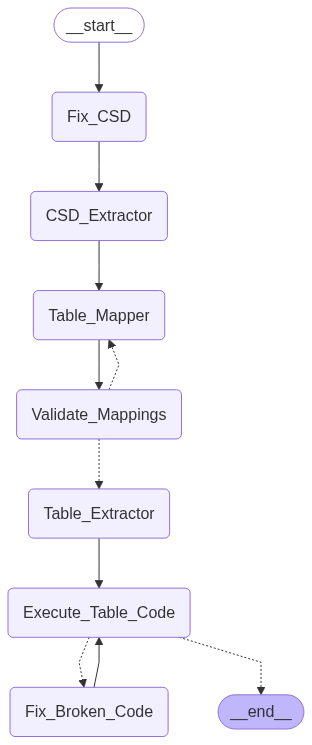

🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.
Case
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
Include patients with LAVI and LVMI available 24 hours from each other
Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
Include patients on treatment for hypertension anytime before to 1 year after the anchor
Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
Ensure that age at the time of ECG ≥ 18 years

Control
Identify patients with disease codes for hypertension or its complications (hyp

'table_fetch_code_final.py'

In [50]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    csd_fixed: str           # raw multi-line CSD text append initial lines to case and control
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path
    final_sql_query: str
    final_sql_path: str
    cohort_df_path: str
    cohort_df: str
    next_step: Optional[str]

# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Expand CSD and put common lines into CASE & CONTROL ----
def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.

    - Keeps text before 'Cohort Creation Steps' as-is
    - Removes the original 'Cohort Creation Steps' block (to avoid duplicates)
    - Rebuilds 'Case' and 'Control' sections with the generic lines prefixed
    - If markers aren't found, returns original CSD unchanged
    """
    if not isinstance(csd, str): #check if csd is a string else return unchanged
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip() #Normalizes newlines; trims leading/trailing whitespace.

    #looks for headers in CSD
    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)
    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure. If either “Case” or “Control” is missing, bail out safely.
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: dict) -> dict:
    raw = state.get("csd", "") 
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(fixed)
    state["csd_fixed"] = fixed
    state["csd"] = fixed
    return state
    

# ---- Simplify CSD for Extraction ignoring temporal logic ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 (synthetic_ehr and pandas) that fetches all relevant data from these tables.

Hard rules:
- JOIN on `PATIENT_ID` or `NFER_PID` when needed. Always use table aliases and refer to columns as <alias>.<col>.
- Do NOT use SELECT *.
- Select exactly ONE ID column and alias it as `patient_id` in the SELECT list:
    Priority to choose from (first present in the joined tables): PATIENT_ID, NFER_PID, PERSON_ID, SUBJECT_ID.
    Example: SELECT a.PATIENT_ID AS patient_id, ...
- Select exactly ONE datetime column that represents the event time and alias it as `event_dtm` in the SELECT list:
    Priority to choose from (first present): EVENT_DTM, MEASUREMENT_DTM, OBSERVATION_DTM, ORDER_DTM, RESULT_DTM, DTTM, DATETIME, EVENT_DATE, OBSERVATION_DATE, MEASUREMENT_DATE.
    Example: SELECT ..., b.EVENT_DTM AS _dtm, ...
- Do NOT include any other ID or *_DTM/*_DATE/*_DATETIME columns in the SELECT list.
- ALWAYS alias every selected column; never reference unaliased table names.
- Use SELECT DISTINCT if your joins can duplicate rows.
- Store final result in a pandas DataFrame called `cohort_df`.
- The code must reference only this schema:
{table_schema}

Return ONLY Python code (no markdown code blocks) properly indented and executable.

Mappings:
{mappings}
"""


def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state




# ======= Helper function for Fixing Error in the Query (if any) =======

def _pull_sql_string(code: str) -> tuple[str, int, int]:
    """
    Return (sql_text, start_index, end_index) for the SQL inside:
      sql_query = \"\"\" ... \"\"\"   OR   sql_query = '...'/\"...\"
    If not found, returns ("", -1, -1).
    """
    # triple quotes first
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body"), m.start("body"), m.end("body")
    # single or double quotes
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body"), m.start("body"), m.end("body")
    return ("", -1, -1)
    
# --- Robust SQL extraction for saving ---
def _regex_extract_sql_from_code(code: str) -> str:
    """
    Pull the SQL contents out of: sql_query = \"\"\" ... \"\"\"  (or single/double quoted).
    Falls back to empty string if not found.
    """
    # triple-quote first
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    # single/double quotes
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    return ""



# ---- Clean Code ----
def clean_code_block(code: str) -> str:
    import re

    # 1) Strip markdown fences
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE)
    code = code.replace("```", "")

    lines = code.strip().splitlines()
    cleaned_lines, final_lines = [], []
    found_start = False
    sql_block_open = False

    # 2) Keep only Python + SQL, starting when imports/connection/sql first appear
    for line in lines:
        s = line.strip()
        if not found_start and (s.startswith("import") or s.startswith("conn") or s.startswith("sql_query")):
            found_start = True
        if not found_start:
            continue
        cleaned_lines.append(line)

        # track triple-quoted SQL body
        if "sql_query" in s and '"""' in s:
            sql_block_open = True
        elif sql_block_open and s == '"""':
            sql_block_open = False
            # ensure a LIMIT within the last few SQL lines
            tail = [l.upper() for l in cleaned_lines[-5:]]
            if not any("LIMIT " in l for l in tail):
                # insert just before the closing triple quotes we just added
                cleaned_lines.insert(len(cleaned_lines) - 1, "LIMIT 1000")

    # 3) Dedup execution lines
    seen_exec = set()
    for line in cleaned_lines:
        s = line.strip()
        if s in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if s in seen_exec:
                continue
            seen_exec.add(s)
        final_lines.append(line)

    # 4) Ensure execution lines exist
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        final_lines.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        final_lines.append("conn.close()")

    # 5) **Hard stop** after the last legit line (prevents trailing prose)
    #    Anything after conn.close() is discarded.
    last_close_idx = max((i for i, l in enumerate(final_lines) if l.strip() == "conn.close()"), default=-1)
    if last_close_idx != -1:
        final_lines = final_lines[: last_close_idx + 1]

    # 6) Defensive: drop any trailing non-code lines if they somehow still exist
    #    (lines that don't start with typical Python or SQL constructs)
    pythonish = re.compile(r"^\s*(#|import|from|conn\.|cursor\.|pd\.|cohort_df\s*=|sql_query\s*=|SELECT|WITH|DROP|CREATE|INSERT|UPDATE|DELETE)", re.I)
    trimmed = []
    for l in final_lines:
        s = l.rstrip()
        if not s:
            continue
        # Keep while before conn.close(); after that we've already truncated.
        if pythonish.match(s) or s == '"""':
            trimmed.append(s)
        else:
            # if it's inside the SQL triple quotes, keep it
            # (allow bare SQL keywords/lines)
            trimmed.append(s)
    code = "\n".join(trimmed).strip()

    # 7) Normalize common bad `if cohort_df` checks
    code = re.sub(r"\bif\s*\(?\s*cohort_df\s*\)?\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.I)
    code = re.sub(r"\bif\s*\(?\s*cohort_df\s*==\s*True\s*\)?\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.I)
    code = re.sub(r"\bif\s+cohort_df\s*(!=|==)\s*None\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.I)

    # 8) Strip trailing spaces/blank lines
    code = "\n".join([l.rstrip() for l in code.splitlines() if l.strip()]).strip()
    return code




# ---- Code Executor + Bug Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "") or ""
    err = (state.get("execution_error") or "").strip()

    if not raw_code:
        return state

    changed = False

    # Always apply the general cleanup
    patched = clean_code_block(raw_code)
    if patched != raw_code:
        raw_code = patched
        changed = True

    # If the failure was a missing alias/column, try to rewrite the SQL
    m = re.search(r"no such column:\s*([A-Za-z_]\w*)\.([A-Za-z_]\w*)", err, flags=re.I)
    if m:
        bad_alias, bad_col = m.group(1), m.group(2)
        sql, i0, i1 = _pull_sql_string(raw_code)
        if sql:
            # Build alias -> table map (FROM / JOIN with or without AS)
            alias_map = {}
            for t, a in re.findall(r"\bFROM\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t
            for t, a in re.findall(r"\bJOIN\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t

            # Introspect columns for each table
            try:
                conn = sqlite3.connect("synthetic_ehr.db")
                alias_cols = {}
                for a, t in alias_map.items():
                    try:
                        rows = conn.execute(f"PRAGMA table_info('{t}')").fetchall()
                        alias_cols[a] = {r[1].upper() for r in rows}
                    except Exception:
                        alias_cols[a] = set()
                conn.close()
            except Exception:
                alias_cols = {}

            target_alias = next((a for a, cols in alias_cols.items() if bad_col.upper() in cols), None)

            if target_alias:
                # Replace bad_alias.bad_col -> target_alias.bad_col (case-insensitive)
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    f"{target_alias}.{bad_col}",
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Replaced {bad_alias}.{bad_col} → {target_alias}.{bad_col}")
            else:
                # Fallback: unqualify the column so SQLite can resolve if unique
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    bad_col,
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Unqualified {bad_alias}.{bad_col} → {bad_col}")

    if changed:
        state["table_fetch_code"] = raw_code
        # clear the error so the graph re-runs Execute_Table_Code once
        state["execution_error"] = ""
    else:
        print("\nℹ️ [Code_Fixer] No changes applied to code.")
    return state


def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))


def _first_df(*vals):
    """Return the first value that is a pandas DataFrame, else None."""
    for v in vals:
        if isinstance(v, pd.DataFrame):
            return v
    return None


def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)

    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    # --- Show numbered code for debugging ---
    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        # repr(line) → shows the Python representation of the string, including quotes and escapes. That means tabs, trailing spaces, and weird characters are visible
        # format the number right-aligned in a field at least 2 characters wide.
        print(f"{i:>2}: {repr(line)}") 
    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {
            "sqlite3": sqlite3,
            "pd": pd,
        }

        # Setup connection
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        # Try executing the code
        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            state["execution_error"] = str(e)
            conn.close()
            return state

       
        df = _first_df(local_vars.get("cohort_df"), global_context.get("cohort_df"))

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if not df.empty:
                print("✅ DataFrame has data.")
            else:
                print("⚠️ Warning: cohort_df is empty.")

            # persist to CSV
            csv_path = "cohort_df.csv"
            try:
                df.to_csv(csv_path, index=False)
                print(f"💾 Saved cohort_df → {csv_path}")
                state["cohort_df_path"] = csv_path
            except Exception as e:
                print(f"⚠️ Could not save cohort_df to CSV: {e}")
                state["cohort_df_path"] = ""

            state["cohort_df"] = df.copy()
            state["table_fetch_code"] = code
            state["execution_error"] = ""

            # --- OPTIONAL: also save the exact SQL that ran ---
            sql_str = local_vars.get("sql_query") or global_context.get("sql_query")
            if not isinstance(sql_str, str) or not sql_str.strip():
                sql_str = _regex_extract_sql_from_code(code)
            if isinstance(sql_str, str) and sql_str.strip():
                try:
                    with open("final_working_query.sql", "w", encoding="utf-8") as f:
                        f.write(sql_str.strip() + "\n")
                    # add these fields to GraphState if you want static typing
                    state["final_sql_query"] = sql_str.strip()
                    state["final_sql_path"]  = "final_working_query.sql"
                    print("💾 Saved final SQL → final_working_query.sql")
                except Exception as e:
                    print(f"⚠️ Could not save final SQL: {e}")

        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"


        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        # ✅ Store error separately — again
        state["execution_error"] = str(e)


    return state


# -------- Cleans up and Deduplicates LLM mapping results ---------
def validate_and_dedupe_mappings(state: dict) -> dict:
    raw = state.get("mappings", [])
    good, seen = [], set()
    for m in raw:
        if not isinstance(m, dict):
            continue
        tables  = [t.strip().upper() for t in m.get("tables", []) if isinstance(t, str)]
        columns = [c.strip().upper() for c in m.get("columns", []) if isinstance(c, str)]
        if not tables and not columns:
            continue
        key = json.dumps({"tables":sorted(tables), "columns":sorted(columns)}, sort_keys=True)
        if key in seen:
            continue  # <-- de-dup identical entries (Case vs Control)
        seen.add(key)
        good.append({"csd": m.get("csd",""), "tables":tables, "columns":columns})
    state["mappings"] = good
     # Validation rule: must have at least 1 mapping and at least 1 table or column in each
    state["validation_ok"] = bool(good) and all((m["tables"] or m["columns"]) for m in good)

    # optional: cap endless mapper↔validator loops
    state["retry_count"] = int(state.get("retry_count") or 0)
    if not state["validation_ok"]:
        state["retry_count"] += 1

    print("✅ [Validate_Mappings] kept:", json.dumps(good, indent=2))
    print(f"➡️  validation_ok={state['validation_ok']}, retry_count={state['retry_count']}")
    return state


# ---------- Utility function to save Python code block --------------
def save_table_fetch_code(state: dict, path: str = "final_table_fetch_code.py") -> str | None:
    """Save the LLM-generated Python block from state['table_fetch_code'] to a .py file.
    Strips markdown fences if the model returned them."""
    code = state.get("table_fetch_code", "") or ""
    # strip markdown fences, if your helper exists use it; otherwise do a quick strip here
    try:
        code = _strip_code_fences(code)  # you already defined this in your file
    except NameError:
        import re
        code = re.sub(r"^```(?:python)?\s*", "", code.strip(), flags=re.IGNORECASE)
        code = re.sub(r"\s*```$", "", code)

    if not code.strip():
        print("⚠️ No table_fetch_code to save.")
        return None

    with open(path, "w", encoding="utf-8") as f:
        if not code.endswith("\n"):
            code += "\n"
        f.write(code)

    print(f"💾 Saved table_fetch_code → {path}")
    return path


# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(validate_and_dedupe_mappings))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))


builder.set_entry_point("Fix_CSD")
builder.add_edge("Fix_CSD", "CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges(
    "Validate_Mappings",
    lambda s: "Table_Extractor" if s.get("validation_ok") else "Table_Mapper",
    {
        "Table_Extractor": "Table_Extractor",   # pass → proceed
        "Table_Mapper": "Table_Mapper",         # fail → loop back
    }
)


builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda state: "Fix_Broken_Code" if state.get("execution_error") else None,
    {
        "Fix_Broken_Code": "Fix_Broken_Code",
        None: END  # Stop graph if execution_error is empty (i.e., success)
    }
)
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code") 


graph = builder.compile()
# ---- Visualize Graph ----
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Mermaid render failed:", e)


# ---- Run Graph ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,"csd_fixed": "",
    "simple_csd": [], "mappings": [],  "table_fetch_code": "",
    "last_step": "", "retry_count": 0,"execution_error": "",
    "final_sql_query": "", "final_sql_path": ""
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])
save_table_fetch_code(final_state, path="table_fetch_code_final.py")

### Table Extrction with Human In Loop

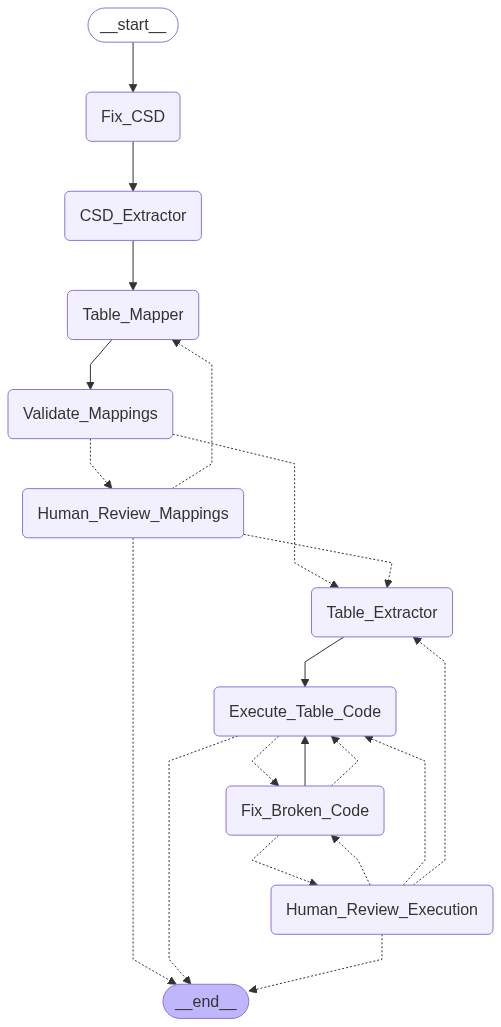

🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.
Case
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
Include patients with LAVI and LVMI available 24 hours from each other
Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
Include patients on treatment for hypertension anytime before to 1 year after the anchor
Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
Ensure that age at the time of ECG ≥ 18 years

Control
Identify patients with disease codes for hypertension or its complications (hyp

'table_fetch_code_final.py'

In [60]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    csd_fixed: str           # raw multi-line CSD text append initial lines to case and control
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path
    final_sql_query: str
    final_sql_path: str
    cohort_df_path: str
    cohort_df: str
    next_step: Optional[str]

# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Expand CSD and put common lines into CASE & CONTROL ----
def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.

    - Keeps text before 'Cohort Creation Steps' as-is
    - Removes the original 'Cohort Creation Steps' block (to avoid duplicates)
    - Rebuilds 'Case' and 'Control' sections with the generic lines prefixed
    - If markers aren't found, returns original CSD unchanged
    """
    if not isinstance(csd, str): #check if csd is a string else return unchanged
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip() #Normalizes newlines; trims leading/trailing whitespace.

    #looks for headers in CSD
    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)
    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure. If either “Case” or “Control” is missing, bail out safely.
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: dict) -> dict:
    raw = state.get("csd", "") 
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(fixed)
    state["csd_fixed"] = fixed
    state["csd"] = fixed
    return state
    

# ---- Simplify CSD for Extraction ignoring temporal logic ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (Python + sqlite3 + pandas) that fetches all relevant data from these tables.

HARD RULES:
- Use table aliases for every table, and ALWAYS reference columns as <alias>.<COLUMN>.
- Do NOT use SELECT *.
- For every mapped column "T.C" in {mappings}, the SELECT item MUST be "<alias_of_T>.C".
  If table T is not yet in FROM/JOIN, you MUST JOIN it (using keys present in {table_schema}).
- If a mapped column is a dimension value (e.g., *_DESCRIPTION), ensure the correct dimension table T is joined and referenced.
- Choose exactly one ID column as `patient_id` and one datetime column as `event_dtm`, per these priorities:
    ID: PATIENT_ID, NFER_PID, PERSON_ID, SUBJECT_ID
    DTM: EVENT_DTM, MEASUREMENT_DTM, OBSERVATION_DTM, ORDER_DTM, RESULT_DTM, DTTM, DATETIME, EVENT_DATE, OBSERVATION_DATE, MEASUREMENT_DATE
- Use SELECT DISTINCT if joins may duplicate rows.
- Return ONLY executable Python code (no markdown, no prose).
- The code must reference only this schema:
{table_schema}

The code should look like:

import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
sql_query = \"\"\"
SELECT DISTINCT
  -- columns here (use correct aliases for the mapped columns)
FROM ...
... JOIN ...
LIMIT 1000
\"\"\"
cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()
"""



def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state




# ======= Helper function for Fixing Error in the Query (if any) =======

def _pull_sql_string(code: str) -> tuple[str, int, int]:
    """
    Return (sql_text, start_index, end_index) for the SQL inside ANY of:
      <var> = \"\"\" ... \"\"\"   OR   <var> = '...'/\"...\"
    Prefers the var named sql_query if present.
    """
    import re

    # try sql_query triple first
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body"), m.start("body"), m.end("body")

    # any var triple
    m = re.search(r'\b\w+\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL)
    if m:
        return m.group("body"), m.start("body"), m.end("body")

    # sql_query single/double
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body"), m.start("body"), m.end("body")

    # any var single/double
    m = re.search(r'\b\w+\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL)
    if m:
        return m.group("body"), m.start("body"), m.end("body")

    return ("", -1, -1)


def _regex_extract_sql_from_code(code: str) -> str:
    # prefer sql_query; else fall back to the first triple-quoted assignment
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    m = re.search(r'\b\w+\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL)
    if m:
        return m.group("body").strip()
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    m = re.search(r'\b\w+\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL)
    if m:
        return m.group("body").strip()
    return ""




# ---- Clean Code ----
def clean_code_block(code: str) -> str:
    import re

    # 0) Strip markdown fences
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE)
    code = code.replace("```", "")

    # 1) Normalize the SQL variable name to 'sql_query'
    #    - If the code uses sql/query/q, rename it.
    #    - Also fix read_sql_query(...) to reference sql_query.
    #    (Do this before other logic so the rest of the pipeline is consistent.)
    code = re.sub(r'^\s*(sql|query|q)\s*=\s*("""|\'\'\'|["\'])', r'sql_query = \2', code, flags=re.IGNORECASE | re.MULTILINE)
    code = re.sub(r'read_sql_query\(\s*(sql|query|q)\s*,', r'read_sql_query(sql_query,', code, flags=re.IGNORECASE)

    lines = code.strip().splitlines()
    cleaned_lines, final_lines = [], []
    found_start = False
    sql_block_open = False

    # 2) Keep only Python + SQL, starting when imports/connection/sql first appear
    for line in lines:
        s = line.strip()
        if not found_start and (s.startswith("import") or s.startswith("conn") or s.startswith("sql_query")):
            found_start = True
        if not found_start:
            continue
        cleaned_lines.append(line)

        # track triple-quoted SQL body for ANY sql_query assignment
        if re.search(r'^\s*sql_query\s*=\s*"""', s, re.IGNORECASE):
            sql_block_open = True
        elif sql_block_open and s == '"""':
            sql_block_open = False
            # ensure LIMIT in last few SQL lines
            tail = [l.upper() for l in cleaned_lines[-8:]]
            if not any("LIMIT " in l for l in tail):
                cleaned_lines.insert(len(cleaned_lines) - 1, "LIMIT 1000")

    # 3) Dedup execution lines
    seen_exec = set()
    for line in cleaned_lines:
        s = line.strip()
        if s in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if s in seen_exec:
                continue
            seen_exec.add(s)
        final_lines.append(line)

    # 4) Ensure execution lines exist
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        final_lines.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        final_lines.append("conn.close()")

    # 5) Hard stop after conn.close() (drop any trailing prose)
    last_close_idx = max((i for i, l in enumerate(final_lines) if l.strip() == "conn.close()"), default=-1)
    if last_close_idx != -1:
        final_lines = final_lines[: last_close_idx + 1]

    code = "\n".join([l.rstrip() for l in final_lines if l.strip()]).strip()

    # 6) As a second safety net, inject LIMIT if a triple-quoted sql_query block lacks it.
    #    Works even if the closing """ is on the same line as content.
    def _inject_limit(m):
        body = m.group(1)
        if "LIMIT" not in body.upper():
            return f'sql_query = """{body}\nLIMIT 1000\n"""'
        return m.group(0)

    code = re.sub(r'sql_query\s*=\s*"""([\s\S]*?)"""', _inject_limit, code, flags=re.IGNORECASE)

    # 7) Normalize common bad `if cohort_df` checks (your original)
    code = re.sub(r"\bif\s*\(?\s*cohort_df\s*\)?\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.IGNORECASE)
    code = re.sub(r"\bif\s*\(?\s*cohort_df\s*==\s*True\s*\)?\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.IGNORECASE)
    code = re.sub(r"\bif\s+cohort_df\s*(!=|==)\s*None\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.IGNORECASE)

   
    # 8) Strip trailing spaces/blank lines
    code = "\n".join([l.rstrip() for l in code.splitlines() if l.strip()]).strip()
    return code




# ---- Code Executor + Bug Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "") or ""
    err = (state.get("execution_error") or "").strip()
    mappings = state.get("mappings") or []

    if not raw_code:
        return state

    changed = False
    patched = clean_code_block(raw_code)
    if patched != raw_code:
        raw_code = patched
        changed = True

    # Try to repair "no such column: alias.col"
    m = re.search(r"no such column:\s*([A-Za-z_]\w*)\.([A-Za-z_]\w*)", err, flags=re.I)
    if m:
        bad_alias, bad_col = m.group(1), m.group(2)
        sql, i0, i1 = _pull_sql_string(raw_code)
        if sql:
            # Build alias -> table map from FROM/JOIN (with or without AS)
            alias_map = {}
            for t, a in re.findall(r"\bFROM\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a.upper()] = t.upper()
            for t, a in re.findall(r"\bJOIN\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a.upper()] = t.upper()

            # 1) Try DB introspection
            target_alias = None
            try:
                import sqlite3 as _sqlite3
                conn = _sqlite3.connect("synthetic_ehr.db")
                # alias -> set(columns)
                alias_cols = {}
                for a, t in alias_map.items():
                    cols = set()
                    try:
                        rows = conn.execute(f"PRAGMA table_info('{t}')").fetchall()
                        cols = {r[1].upper() for r in rows}
                    except Exception:
                        pass
                    alias_cols[a] = cols
                conn.close()
                target_alias = next((a for a, cols in alias_cols.items() if bad_col.upper() in cols), None)
            except Exception:
                target_alias = None

            # 2) Fallback to mappings (TABLE.COL strings) to infer correct table
            if not target_alias:
                # Build col -> expected table from mappings
                expected_table_by_col = {}
                for mobj in mappings:
                    for col in mobj.get("columns", []):
                        if isinstance(col, str) and "." in col:
                            tbl, colname = col.split(".", 1)
                            expected_table_by_col[colname.strip().upper()] = tbl.strip().upper()
                exp_table = expected_table_by_col.get(bad_col.upper())
                if exp_table:
                    # find the alias used for that table in the SQL
                    for a, t in alias_map.items():
                        if t == exp_table:
                            target_alias = a
                            break

            if target_alias and target_alias.lower() != bad_alias.lower():
                # Replace "bad_alias.bad_col" -> "target_alias.bad_col"
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    f"{target_alias}.{bad_col}",
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Replaced {bad_alias}.{bad_col} → {target_alias}.{bad_col}")
            else:
                # As last resort, unqualify to let SQLite resolve (if unique)
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    bad_col,
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Unqualified {bad_alias}.{bad_col} → {bad_col}")

    if changed:
        state["table_fetch_code"] = raw_code
        state["execution_error"] = ""   # re-run Execute_Table_Code
    else:
        print("\nℹ️ [Code_Fixer] No changes applied to code.")
    return state



def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))


def _first_df(*vals):
    """Return the first value that is a pandas DataFrame, else None."""
    for v in vals:
        if isinstance(v, pd.DataFrame):
            return v
    return None


def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)

    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        msg = f"Invalid SQL: unaliased table usage: {invalid_aliases}"
        print(f"❌ {msg}")
        state["last_step"] = "Execute_Table_Code"
        state["execution_error"] = msg     # <-- important
        state["table_fetch_code"] += f"\n# Error: {msg}"
        return state


    # --- Show numbered code for debugging ---
    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        # repr(line) → shows the Python representation of the string, including quotes and escapes. That means tabs, trailing spaces, and weird characters are visible
        # format the number right-aligned in a field at least 2 characters wide.
        print(f"{i:>2}: {repr(line)}") 
    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {
            "sqlite3": sqlite3,
            "pd": pd,
        }

        # Setup connection
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        # Try executing the code
        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            state["execution_error"] = str(e)
            conn.close()
            return state

       
        df = _first_df(local_vars.get("cohort_df"), global_context.get("cohort_df"))

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if not df.empty:
                print("✅ DataFrame has data.")
            else:
                print("⚠️ Warning: cohort_df is empty.")

            # persist to CSV
            csv_path = "cohort_df.csv"
            try:
                df.to_csv(csv_path, index=False)
                print(f"💾 Saved cohort_df → {csv_path}")
                state["cohort_df_path"] = csv_path
            except Exception as e:
                print(f"⚠️ Could not save cohort_df to CSV: {e}")
                state["cohort_df_path"] = ""

            state["cohort_df"] = df.copy()
            state["table_fetch_code"] = code
            state["execution_error"] = ""

            # --- OPTIONAL: also save the exact SQL that ran ---
            sql_str = local_vars.get("sql_query") or global_context.get("sql_query")
            if not isinstance(sql_str, str) or not sql_str.strip():
                sql_str = _regex_extract_sql_from_code(code)
            if isinstance(sql_str, str) and sql_str.strip():
                try:
                    with open("final_working_query.sql", "w", encoding="utf-8") as f:
                        f.write(sql_str.strip() + "\n")
                    # add these fields to GraphState if you want static typing
                    state["final_sql_query"] = sql_str.strip()
                    state["final_sql_path"]  = "final_working_query.sql"
                    print("💾 Saved final SQL → final_working_query.sql")
                except Exception as e:
                    print(f"⚠️ Could not save final SQL: {e}")

        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"


        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        # ✅ Store error separately — again
        state["execution_error"] = str(e)


    return state



def human_review_mappings(state):
    """
    HITL after Validate_Mappings failed.
    Human can:
      M - re-run Table_Mapper
      C - continue to Table_Extractor anyway (override)
      S - stop/hold (sets awaiting_human=True)
    """
    print("\n🧑‍⚖️ HUMAN REVIEW: MAPPINGS VALIDATION FAILED")
    print("Current mappings:")
    print(json.dumps(state.get("mappings", []), indent=2))
    try:
        choice = input("Choose [M]apper / [C]ontinue / [S]top: ").strip().upper()
    except Exception:
        choice = "S"

    state["awaiting_human"] = False
    if choice == "M":
        state["next_step"] = "Table_Mapper"
    elif choice == "C":
        state["validation_ok"] = True
        state["next_step"] = "Table_Extractor"
    else:  # "S"
        state["awaiting_human"] = True
        state["next_step"] = None
    return state


def human_review_execution(state):
    """
    HITL after Execute_Table_Code error.
    Human can:
      F - try Fix_Broken_Code
      R - Retry Execute_Table_Code as-is
      T - go back to Table_Extractor to regenerate code
      S - stop/hold
    """
    print("\n🧑‍⚖️ HUMAN REVIEW: EXECUTION ERROR")
    print("Last error:", state.get("execution_error"))
    print("\n--- Current SQL (best effort) ---")
    print(_regex_extract_sql_from_code(state.get("table_fetch_code","")) or "<none>")
    print("---------------------------------\n")
    try:
        choice = input("Choose [F]ix code / [R]etry execute / [T]able extractor / [S]top: ").strip().upper()
    except Exception:
        choice = "S"

    state["awaiting_human"] = False
    if choice == "F":
        state["next_step"] = "Fix_Broken_Code"
    elif choice == "R":
        state["next_step"] = "Execute_Table_Code"
    elif choice == "T":
        state["next_step"] = "Table_Extractor"
    else:  # "S"
        state["awaiting_human"] = True
        state["next_step"] = None
    return state

# -------- Cleans up and Deduplicates LLM mapping results ---------
def validate_and_dedupe_mappings(state: dict) -> dict:
    raw = state.get("mappings", [])
    good, seen = [], set()
    for m in raw:
        if not isinstance(m, dict):
            continue
        tables  = [t.strip().upper() for t in m.get("tables", []) if isinstance(t, str)]
        columns = [c.strip().upper() for c in m.get("columns", []) if isinstance(c, str)]
        if not tables and not columns:
            continue
        key = json.dumps({"tables":sorted(tables), "columns":sorted(columns)}, sort_keys=True)
        if key in seen:
            continue  # <-- de-dup identical entries (Case vs Control)
        seen.add(key)
        good.append({"csd": m.get("csd",""), "tables":tables, "columns":columns})
    state["mappings"] = good
    state["validation_ok"] = bool(good) and all((m["tables"] or m["columns"]) for m in good)
    state["next_step"] = None
    print("✅ [Validate_Mappings] kept:", json.dumps(good, indent=2))
    print(f"✅  validation_ok={state['validation_ok']}")
    return state


# ---------- Utility function to save Python code block --------------
def save_table_fetch_code(state: dict, path: str = "final_table_fetch_code.py") -> str | None:
    """Save the LLM-generated Python block from state['table_fetch_code'] to a .py file.
    Strips markdown fences if the model returned them."""
    code = state.get("table_fetch_code", "") or ""
    # strip markdown fences, if your helper exists use it; otherwise do a quick strip here
    try:
        code = _strip_code_fences(code)  # you already defined this in your file
    except NameError:
        import re
        code = re.sub(r"^```(?:python)?\s*", "", code.strip(), flags=re.IGNORECASE)
        code = re.sub(r"\s*```$", "", code)

    if not code.strip():
        print("⚠️ No table_fetch_code to save.")
        return None

    with open(path, "w", encoding="utf-8") as f:
        if not code.endswith("\n"):
            code += "\n"
        f.write(code)

    print(f"💾 Saved table_fetch_code → {path}")
    return path


# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(validate_and_dedupe_mappings))
builder.add_node("Human_Review_Mappings", RunnableLambda(human_review_mappings))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Human_Review_Execution", RunnableLambda(human_review_execution))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))


builder.set_entry_point("Fix_CSD")
builder.add_edge("Fix_CSD", "CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges(
    "Validate_Mappings",
    lambda s: "Table_Extractor" if s.get("validation_ok") else "Human_Review_Mappings",
    {
        "Table_Extractor": "Table_Extractor",
        "Human_Review_Mappings": "Human_Review_Mappings",
    }
)

builder.add_conditional_edges(
    "Human_Review_Mappings",
    lambda s: s.get("next_step"),
    {
        "Table_Mapper": "Table_Mapper",         # human chose to re-map
        "Table_Extractor": "Table_Extractor",   # human overrides and proceeds
        None: END                                # human stopped/holding
    }
)

builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda s: "Fix_Broken_Code" if s.get("execution_error") else None,
    {
        "Fix_Broken_Code": "Fix_Broken_Code",
        None: END
    }
)
# If it is still broken after the fixer, THEN go to HITL:
builder.add_conditional_edges(
    "Fix_Broken_Code",
    lambda s: "Human_Review_Execution" if s.get("execution_error") else "Execute_Table_Code",
    {
        "Human_Review_Execution": "Human_Review_Execution",
        "Execute_Table_Code": "Execute_Table_Code",
    }
)


builder.add_conditional_edges(
    "Human_Review_Execution",
    lambda s: s.get("next_step"),
    {
        "Fix_Broken_Code": "Fix_Broken_Code",     # human chose to auto-fix
        "Execute_Table_Code": "Execute_Table_Code", # retry as-is
        "Table_Extractor": "Table_Extractor",     # regenerate code
        None: END                                  # stop/hold
    }
)

# Keep your fix loop:
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code")



graph = builder.compile()
# ---- Visualize Graph ----
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Mermaid render failed:", e)


# ---- Run Graph ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,"csd_fixed": "",
    "simple_csd": [], "mappings": [],  "table_fetch_code": "",
    "last_step": "", "retry_count": 0,"execution_error": "",
    "final_sql_query": "", "final_sql_path": ""
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])
save_table_fetch_code(final_state, path="table_fetch_code_final.py")

### Agentic AI to filter the DF and create cohort

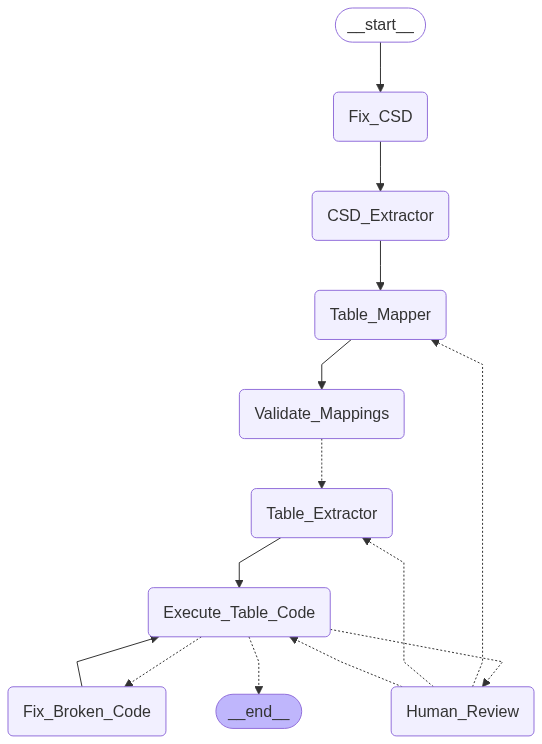

🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.
Case
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
Include patients with LAVI and LVMI available 24 hours from each other
Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
Include patients on treatment for hypertension anytime before to 1 year after the anchor
Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
Ensure that age at the time of ECG ≥ 18 years

Control
Identify patients with disease codes for hypertension or its complications (hyp

Enter A/E/P/S:  E



🚀 [Table_Mapper] Output:
{
  "csd": "ICD codes for hypertension and its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, hypertensive encephalopathy)\nLab tests for LAVI and LVMI\nECHO and ECG tests\nDrugs for hypertension",
  "tables": ["DIAGNOSIS_DIM_DIAGNOSIS_CODE", "FACT_DIAGNOSIS", "LAB_SPECIMEN_DIM_LAB_TEST", "FACT_LAB_TEST", "FACT_ECG", "FACT_ECHO_TEST", "MAR_DIM_MED_NAME", "FACT_MEDICATIONS"],
  "columns": ["DIAGNOSIS_CODE", "DIAGNOSIS_DESCRIPTION", "LAB_TEST_DESCRIPTION", "STANDARD_LAB_TEST_DESCRIPTION", "ECG_INTERPRET_FULL_TEXT", "MED_NAME_DESCRIPTION", "STANDARD_MED_NAME_CODE", "MED_GENERIC_NAME_DESCRIPTION", "STANDARD_MED_GENERIC_NAME_DESCRIPTION"]
}

🚀 [Table_Mapper] Output:
{
  "csd": "ICD codes for hypertension and its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, hypertensive encephalopathy)\nLab tests for LAVI and LVMI\nECHO and ECG tests\nDrugs for hypertension\nICD codes f

Enter A/E/P/S:  P



🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

# Establish a connection to the database
conn = sqlite3.connect('synthetic_ehr.db')

# Create a cursor object
c = conn.cursor()

# Define the SQL query
sql_query = """
SELECT DISTINCT
    d.PATIENT_ID AS patient_id,
    d.EVENT_DTM AS event_dtm,
    dc.DIAGNOSIS_CODE AS diagnosis_code,
    dc.DIAGNOSIS_DESCRIPTION AS diagnosis_description,
    lt.LAB_TEST_DESCRIPTION AS lab_test_description,
    lt.STANDARD_LAB_TEST_DESCRIPTION AS standard_lab_test_description,
    ecg.ECG_INTERPRET_FULL_TEXT AS ecg_interpret_full_text,
    mn.MED_NAME_DESCRIPTION AS med_name_description,
    mn.STANDARD_MED_NAME_CODE AS standard_med_name_code,
    mn.MED_GENERIC_NAME_DESCRIPTION AS med_generic_name_description,
    mn.STANDARD_MED_GENERIC_NAME_DESCRIPTION AS standard_med_generic_name_description
FROM
    FACT_DIAGNOSIS d
JOIN
    DIAGNOSIS_DIM_DIAGNOSIS_CODE dc ON d.DIAGNOSIS_CODE_DK = dc.DIAGNOSIS_CODE_DK
JOIN
    FACT_LAB_TE

Enter A/E/P/S:  E



🚀 [Table_Mapper] Output:
{
  "csd": "ICD codes for hypertension and its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, hypertensive encephalopathy)\nLab tests for LAVI and LVMI\nECHO and ECG tests\nDrugs for hypertension",
  "tables": ["DIAGNOSIS_DIM_DIAGNOSIS_CODE", "FACT_DIAGNOSIS", "LAB_SPECIMEN_DIM_LAB_TEST", "FACT_LAB_TEST", "FACT_ECG", "FACT_ECHO_TEST", "MAR_DIM_MED_NAME", "FACT_MEDICATIONS"],
  "columns": ["DIAGNOSIS_CODE", "DIAGNOSIS_DESCRIPTION", "LAB_TEST_DESCRIPTION", "STANDARD_LAB_TEST_DESCRIPTION", "ECG_INTERPRET_FULL_TEXT", "ECHO_TEST_FPK", "MED_NAME_DESCRIPTION", "STANDARD_MED_NAME_CODE"]
}

🚀 [Table_Mapper] Output:
{
  "csd": "ICD codes for hypertension and its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, hypertensive encephalopathy)\nLab tests for LAVI and LVMI\nECHO and ECG tests\nDrugs for hypertension\nICD codes for HHD disease",
  "tables": ["DIAGNOSIS_DIM_DIAGNOSIS_C

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [48]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    csd_fixed: str           # raw multi-line CSD text append initial lines to case and control
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path
    final_sql_query: str
    final_sql_path: str
    cohort_df_path: str
    cohort_df: str
    next_step: Optional[str]
    retry_limit: int
    awaiting_human: bool

# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Expand CSD and put common lines into CASE & CONTROL ----
def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.

    - Keeps text before 'Cohort Creation Steps' as-is
    - Removes the original 'Cohort Creation Steps' block (to avoid duplicates)
    - Rebuilds 'Case' and 'Control' sections with the generic lines prefixed
    - If markers aren't found, returns original CSD unchanged
    """
    if not isinstance(csd, str): #check if csd is a string else return unchanged
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip() #Normalizes newlines; trims leading/trailing whitespace.

    #looks for headers in CSD
    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)
    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure. If either “Case” or “Control” is missing, bail out safely.
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: dict) -> dict:
    raw = state.get("csd", "") 
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(fixed)
    state["csd_fixed"] = fixed
    state["csd"] = fixed
    return state
    

# ---- Simplify CSD for Extraction ignoring temporal logic ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 (synthetic_ehr and pandas) that fetches all relevant data from these tables.

Hard rules:
- JOIN on `PATIENT_ID` or `NFER_PID` when needed. Always use table aliases and refer to columns as <alias>.<col>.
- Do NOT use SELECT *.
- Select exactly ONE ID column and alias it as `patient_id` in the SELECT list:
    Priority to choose from (first present in the joined tables): PATIENT_ID, NFER_PID, PERSON_ID, SUBJECT_ID.
    Example: SELECT a.PATIENT_ID AS patient_id, ...
- Select exactly ONE datetime column that represents the event time and alias it as `event_dtm` in the SELECT list:
    Priority to choose from (first present): EVENT_DTM, MEASUREMENT_DTM, OBSERVATION_DTM, ORDER_DTM, RESULT_DTM, DTTM, DATETIME, EVENT_DATE, OBSERVATION_DATE, MEASUREMENT_DATE.
    Example: SELECT ..., b.EVENT_DTM AS _dtm, ...
- Do NOT include any other ID or *_DTM/*_DATE/*_DATETIME columns in the SELECT list.
- ALWAYS alias every selected column; never reference unaliased table names.
- Use SELECT DISTINCT if your joins can duplicate rows.
- Store final result in a pandas DataFrame called `cohort_df`.
- The code must reference only this schema:
{table_schema}

Return ONLY Python code (no markdown code blocks) properly indented and executable.

Mappings:
{mappings}
"""


def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state




# ======= Helper function for Fixing Error in the Query (if any) =======

def _pull_sql_string(code: str) -> tuple[str, int, int]:
    """
    Return (sql_text, start_index, end_index) for the SQL inside:
      sql_query = \"\"\" ... \"\"\"   OR   sql_query = '...'/\"...\"
    If not found, returns ("", -1, -1).
    """
    # triple quotes first
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body"), m.start("body"), m.end("body")
    # single or double quotes
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body"), m.start("body"), m.end("body")
    return ("", -1, -1)
    
# --- Robust SQL extraction for saving ---
def _regex_extract_sql_from_code(code: str) -> str:
    """
    Pull the SQL contents out of: sql_query = \"\"\" ... \"\"\"  (or single/double quoted).
    Falls back to empty string if not found.
    """
    # triple-quote first
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    # single/double quotes
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    return ""



# ---- Clean Code ----
def clean_code_block(code: str) -> str:
    import re

    # 1) Strip markdown fences
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE)
    code = code.replace("```", "")

    lines = code.strip().splitlines()
    cleaned_lines, final_lines = [], []
    found_start = False
    sql_block_open = False

    # 2) Keep only Python + SQL, starting when imports/connection/sql first appear
    for line in lines:
        s = line.strip()
        if not found_start and (s.startswith("import") or s.startswith("conn") or s.startswith("sql_query")):
            found_start = True
        if not found_start:
            continue
        cleaned_lines.append(line)

        # track triple-quoted SQL body
        if "sql_query" in s and '"""' in s:
            sql_block_open = True
        elif sql_block_open and s == '"""':
            sql_block_open = False
            # ensure a LIMIT within the last few SQL lines
            tail = [l.upper() for l in cleaned_lines[-5:]]
            if not any("LIMIT " in l for l in tail):
                # insert just before the closing triple quotes we just added
                cleaned_lines.insert(len(cleaned_lines) - 1, "LIMIT 1000")

    # 3) Dedup execution lines
    seen_exec = set()
    for line in cleaned_lines:
        s = line.strip()
        if s in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if s in seen_exec:
                continue
            seen_exec.add(s)
        final_lines.append(line)

    # 4) Ensure execution lines exist
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        final_lines.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        final_lines.append("conn.close()")

    # 5) **Hard stop** after the last legit line (prevents trailing prose)
    #    Anything after conn.close() is discarded.
    last_close_idx = max((i for i, l in enumerate(final_lines) if l.strip() == "conn.close()"), default=-1)
    if last_close_idx != -1:
        final_lines = final_lines[: last_close_idx + 1]

    # 6) Defensive: drop any trailing non-code lines if they somehow still exist
    #    (lines that don't start with typical Python or SQL constructs)
    pythonish = re.compile(r"^\s*(#|import|from|conn\.|cursor\.|pd\.|cohort_df\s*=|sql_query\s*=|SELECT|WITH|DROP|CREATE|INSERT|UPDATE|DELETE)", re.I)
    trimmed = []
    for l in final_lines:
        s = l.rstrip()
        if not s:
            continue
        # Keep while before conn.close(); after that we've already truncated.
        if pythonish.match(s) or s == '"""':
            trimmed.append(s)
        else:
            # if it's inside the SQL triple quotes, keep it
            # (allow bare SQL keywords/lines)
            trimmed.append(s)
    code = "\n".join(trimmed).strip()

    # 7) Normalize common bad `if cohort_df` checks
    code = re.sub(r"\bif\s*\(?\s*cohort_df\s*\)?\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.I)
    code = re.sub(r"\bif\s*\(?\s*cohort_df\s*==\s*True\s*\)?\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.I)
    code = re.sub(r"\bif\s+cohort_df\s*(!=|==)\s*None\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.I)

    # 8) Strip trailing spaces/blank lines
    code = "\n".join([l.rstrip() for l in code.splitlines() if l.strip()]).strip()
    return code




# ---- Code Executor + Bug Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""


def human_review(state):
    print("\n🧑‍⚖️  HUMAN REVIEW REQUIRED")
    print("Last step:", state.get("last_step"))
    print("Error:    ", state.get("execution_error"))
    print("\n--- Current SQL ---")
    print(_regex_extract_sql_from_code(state.get("table_fetch_code","")) or "<none>")
    print("-------------------\n")
    print("Options:")
    print("  [A] Approve current code and continue anyway")
    print("  [E] Edit mappings (manually tweak state['mappings'])")
    print("  [P] Edit the generation prompt(s)")
    print("  [S] Stop here")

    try:
        choice = input("Enter A/E/P/S: ").strip().upper()
    except Exception:
        choice = "S"

    if choice == "A":
        state["execution_error"] = ""        # let it pass
        state["awaiting_human"] = False
        state["next_step"] = None
    elif choice == "E":
        state["awaiting_human"] = True
        # Leave execution_error set; user should mutate state['mappings'] externally, then re-run from Table_Mapper or Validate_Mappings
        state["next_step"] = "Table_Mapper"
    elif choice == "P":
        state["awaiting_human"] = True
        state["next_step"] = "Table_Extractor"  # after you tweak prompts/code, regenerate
    else:  # "S"
        state["awaiting_human"] = True
        # Keep graph from progressing; you can handle this in your driver.
    return state


def fix_broken_sql_code(state):
    state["retry_count"] = int(state.get("retry_count") or 0)
    raw_code = state.get("table_fetch_code", "") or ""
    err = (state.get("execution_error") or "").strip()

    if not raw_code:
        return state

    changed = False

    # Always apply the general cleanup
    patched = clean_code_block(raw_code)
    if patched != raw_code:
        raw_code = patched
        changed = True

    # If the failure was a missing alias/column, try to rewrite the SQL
    m = re.search(r"no such column:\s*([A-Za-z_]\w*)\.([A-Za-z_]\w*)", err, flags=re.I)
    if m:
        bad_alias, bad_col = m.group(1), m.group(2)
        sql, i0, i1 = _pull_sql_string(raw_code)
        if sql:
            # Build alias -> table map (FROM / JOIN with or without AS)
            alias_map = {}
            for t, a in re.findall(r"\bFROM\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t
            for t, a in re.findall(r"\bJOIN\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t

            # Introspect columns for each table
            try:
                conn = sqlite3.connect("synthetic_ehr.db")
                alias_cols = {}
                for a, t in alias_map.items():
                    try:
                        rows = conn.execute(f"PRAGMA table_info('{t}')").fetchall()
                        alias_cols[a] = {r[1].upper() for r in rows}
                    except Exception:
                        alias_cols[a] = set()
                conn.close()
            except Exception:
                alias_cols = {}

            target_alias = next((a for a, cols in alias_cols.items() if bad_col.upper() in cols), None)

            if target_alias:
                # Replace bad_alias.bad_col -> target_alias.bad_col (case-insensitive)
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    f"{target_alias}.{bad_col}",
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Replaced {bad_alias}.{bad_col} → {target_alias}.{bad_col}")
            else:
                # Fallback: unqualify the column so SQLite can resolve if unique
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    bad_col,
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Unqualified {bad_alias}.{bad_col} → {bad_col}")

    if changed:
        state["table_fetch_code"] = raw_code
        # clear the error so the graph re-runs Execute_Table_Code once
        state["execution_error"] = ""
    else:
        print("\nℹ️ [Code_Fixer] No changes applied to code.")
        state["retry_count"] += 1
        if state["retry_count"] >= int(state.get("retry_limit", 2)):
            state["next_step"] = "Human_Review"   # divert to Human in the Loop
    return state


def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))


def _first_df(*vals):
    """Return the first value that is a pandas DataFrame, else None."""
    for v in vals:
        if isinstance(v, pd.DataFrame):
            return v
    return None


def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)

    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        print(f"❌ {msg}")
        state["last_step"] = "Execute_Table_Code"
        state["execution_error"] = msg           # <— was missing
        state["table_fetch_code"] += f"\n# Error: {msg}"
        return state

    # --- Show numbered code for debugging ---
    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        # repr(line) → shows the Python representation of the string, including quotes and escapes. That means tabs, trailing spaces, and weird characters are visible
        # format the number right-aligned in a field at least 2 characters wide.
        print(f"{i:>2}: {repr(line)}") 
    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {
            "sqlite3": sqlite3,
            "pd": pd,
        }

        # Setup connection
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        # Try executing the code
        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            state["execution_error"] = str(e)
            conn.close()
            return state

       
        df = _first_df(local_vars.get("cohort_df"), global_context.get("cohort_df"))

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if not df.empty:
                print("✅ DataFrame has data.")
            else:
                print("⚠️ Warning: cohort_df is empty.")

            # persist to CSV
            csv_path = "cohort_df.csv"
            try:
                df.to_csv(csv_path, index=False)
                print(f"💾 Saved cohort_df → {csv_path}")
                state["cohort_df_path"] = csv_path
            except Exception as e:
                print(f"⚠️ Could not save cohort_df to CSV: {e}")
                state["cohort_df_path"] = ""

            state["cohort_df"] = df.copy()
            state["table_fetch_code"] = code
            state["execution_error"] = ""

            # --- OPTIONAL: also save the exact SQL that ran ---
            sql_str = local_vars.get("sql_query") or global_context.get("sql_query")
            if not isinstance(sql_str, str) or not sql_str.strip():
                sql_str = _regex_extract_sql_from_code(code)
            if isinstance(sql_str, str) and sql_str.strip():
                try:
                    with open("final_working_query.sql", "w", encoding="utf-8") as f:
                        f.write(sql_str.strip() + "\n")
                    # add these fields to GraphState if you want static typing
                    state["final_sql_query"] = sql_str.strip()
                    state["final_sql_path"]  = "final_working_query.sql"
                    print("💾 Saved final SQL → final_working_query.sql")
                except Exception as e:
                    print(f"⚠️ Could not save final SQL: {e}")

        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"


        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        # ✅ Store error separately — again
        state["execution_error"] = str(e)


    return state


# -------- Cleans up and Deduplicates LLM mapping results ---------
def validate_and_dedupe_mappings(state: dict) -> dict:
    raw = state.get("mappings", [])
    good, seen = [], set()
    for m in raw:
        if not isinstance(m, dict):
            continue
        tables  = [t.strip().upper() for t in m.get("tables", []) if isinstance(t, str)]
        columns = [c.strip().upper() for c in m.get("columns", []) if isinstance(c, str)]
        if not tables and not columns:
            continue
        key = json.dumps({"tables":sorted(tables), "columns":sorted(columns)}, sort_keys=True)
        if key in seen:
            continue  # <-- de-dup identical entries (Case vs Control)
        seen.add(key)
        good.append({"csd": m.get("csd",""), "tables":tables, "columns":columns})
    state["mappings"] = good
    state["next_step"] = None  # keep graph happy
    state["retry_count"] = 0
    print("✅ [Validate_Mappings] kept:", json.dumps(good, indent=2))
    return state


# ---------- Utility function to save Python code block --------------
def save_table_fetch_code(state: dict, path: str = "final_table_fetch_code.py") -> str | None:
    """Save the LLM-generated Python block from state['table_fetch_code'] to a .py file.
    Strips markdown fences if the model returned them."""
    code = state.get("table_fetch_code", "") or ""
    # strip markdown fences, if your helper exists use it; otherwise do a quick strip here
    try:
        code = _strip_code_fences(code)  # you already defined this in your file
    except NameError:
        import re
        code = re.sub(r"^```(?:python)?\s*", "", code.strip(), flags=re.IGNORECASE)
        code = re.sub(r"\s*```$", "", code)

    if not code.strip():
        print("⚠️ No table_fetch_code to save.")
        return None

    with open(path, "w", encoding="utf-8") as f:
        if not code.endswith("\n"):
            code += "\n"
        f.write(code)

    print(f"💾 Saved table_fetch_code → {path}")
    return path


# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(validate_and_dedupe_mappings))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))
builder.add_node("Human_Review", RunnableLambda(human_review))

def exec_router(state):
    # if no error → end
    if not state.get("execution_error"):
        return None
    # if we already decided to go to HITL
    if state.get("next_step") == "Human_Review" or state.get("awaiting_human"):
        return "Human_Review"
    # otherwise try auto-fix
    return "Fix_Broken_Code"



builder.set_entry_point("Fix_CSD")
builder.add_edge("Fix_CSD", "CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges("Validate_Mappings", lambda s: s.get("next_step"), { None: "Table_Extractor" })

builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_conditional_edges(
    "Execute_Table_Code",
    exec_router,
    {
        "Fix_Broken_Code": "Fix_Broken_Code",
        "Human_Review": "Human_Review",
        None: END
    }
)

# When Human_Review returns:
builder.add_conditional_edges(
    "Human_Review",
    lambda s: s.get("next_step"),
    {
        "Table_Mapper": "Table_Mapper",
        "Table_Extractor": "Table_Extractor",
        None: "Execute_Table_Code"  # e.g., approved to continue
    }
)

builder.add_edge("Fix_Broken_Code", "Execute_Table_Code") 


graph = builder.compile()
# ---- Visualize Graph ----
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Mermaid render failed:", e)


# ---- Run Graph ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,"csd_fixed": "","simple_csd": [], "mappings": [],  "table_fetch_code": "","last_step": "", 
    "retry_count": 0,"execution_error": "","final_sql_query": "", "final_sql_path": "","retry_limit": 2,
    "awaiting_human": False

}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])
save_table_fetch_code(final_state, path="table_fetch_code_final.py")

In [47]:
cohort_df

,patient_id,event_dtm,diagnosis_code,diagnosis_description,lab_test_description,lab_test_result,ecg_interpretation,medication_name,medication_dk,echo_test_result_description,echo_result_value
0,P000001,1663525800,R53.1,Weakness,4548-4,127.5,ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...,1049630,1,Mitral Valve Gradient,15.18
1,P000001,1663525800,R53.1,Weakness,4548-4,127.5,ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...,1049630,1,Mitral Valve Gradient,15.18
2,P000001,1663525800,R53.1,Weakness,4548-4,127.5,ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...,1049630,1,LV Mass,19.18
3,P000001,1663525800,R53.1,Weakness,4548-4,127.5,ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...,1049630,1,LV Mass,19.18
4,P000001,1663525800,R53.1,Weakness,4548-4,127.5,ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...,1049630,1,TAPSE,21.53
...,...,...,...,...,...,...,...,...,...,...,...
995,P000001,1663525800,R53.1,Weakness,4548-4,155.5,ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...,617344,34,Mitral Valve Gradient,37.82
996,P000001,1663525800,R53.1,Weakness,4548-4,155.5,ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...,617344,34,EF,40.79
997,P000001,1663525800,R53.1,Weakness,4548-4,155.5,ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...,617344,34,EF,40.79
998,P000001,1663525800,R53.1,Weakness,4548-4,155.5,ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...,617344,34,LV Mass,53.13


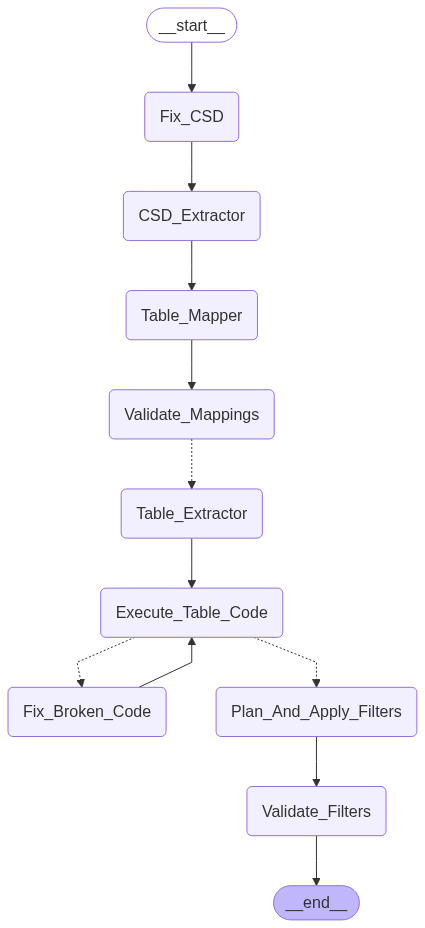

🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.
Case
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
Include patients with LAVI and LVMI available 24 hours from each other
Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
Include patients on treatment for hypertension anytime before to 1 year after the anchor
Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
Ensure that age at the time of ECG ≥ 18 years

Control
Identify patients with disease codes for hypertension or its complications (hyp

In [32]:
from typing import TypedDict, List, Any, Optional, Dict, Callable
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re, inspect
import pandas as pd
import sqlite3

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    csd_fixed: str           #raw multi-line CSD text append initial lines to case and control
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path
    cohort_df_path: str
    cohort_df: Any
    case_df_path: str
    control_df_path: str
    case_filter_log: List[dict]
    control_filter_log: List[dict]
    case_plan: List[dict]
    control_plan: List[dict]




# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Expand CSD and put common lines into CASE & CONTROL ----
def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.

    - Keeps text before 'Cohort Creation Steps' as-is
    - Removes the original 'Cohort Creation Steps' block (to avoid duplicates)
    - Rebuilds 'Case' and 'Control' sections with the generic lines prefixed
    - If markers aren't found, returns original CSD unchanged
    """
    if not isinstance(csd, str):
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip()

    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)

    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: dict) -> dict:
    raw = state.get("csd", "")  # dict access, not attribute
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(fixed)
    state["csd_fixed"] = fixed
    state["csd"] = fixed
    return state
    

# ---- Simplify CSD for Extraction ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = /"/"/"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE
/"/"/"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

    

# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "") or ""
    err = (state.get("execution_error") or "").strip()

    if not raw_code:
        return state

    changed = False

    # Always apply the general cleanup
    patched = clean_code_block(raw_code)
    if patched != raw_code:
        raw_code = patched
        changed = True

    # If the failure was a missing alias/column, try to rewrite the SQL
    m = re.search(r"no such column:\s*([A-Za-z_]\w*)\.([A-Za-z_]\w*)", err, flags=re.I)
    if m:
        bad_alias, bad_col = m.group(1), m.group(2)
        sql, i0, i1 = _pull_sql_string(raw_code)
        if sql:
            # Build alias -> table map (FROM / JOIN with or without AS)
            alias_map = {}
            for t, a in re.findall(r"\bFROM\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t
            for t, a in re.findall(r"\bJOIN\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t

            # Introspect columns for each table
            try:
                conn = sqlite3.connect("synthetic_ehr.db")
                alias_cols = {}
                for a, t in alias_map.items():
                    try:
                        rows = conn.execute(f"PRAGMA table_info('{t}')").fetchall()
                        alias_cols[a] = {r[1].upper() for r in rows}
                    except Exception:
                        alias_cols[a] = set()
                conn.close()
            except Exception:
                alias_cols = {}

            target_alias = next((a for a, cols in alias_cols.items() if bad_col.upper() in cols), None)

            if target_alias:
                # Replace bad_alias.bad_col -> target_alias.bad_col (case-insensitive)
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    f"{target_alias}.{bad_col}",
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Replaced {bad_alias}.{bad_col} → {target_alias}.{bad_col}")
            else:
                # Fallback: unqualify the column so SQLite can resolve if unique
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    bad_col,
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Unqualified {bad_alias}.{bad_col} → {bad_col}")

    if changed:
        state["table_fetch_code"] = raw_code
        # clear the error so the graph re-runs Execute_Table_Code once
        state["execution_error"] = ""
    else:
        print("\nℹ️ [Code_Fixer] No changes applied to code.")
    return state




def _pull_sql_string(code: str) -> tuple[str, int, int]:
    """Return (sql_text, start_idx, end_idx) for the triple-quoted sql_query string inside code."""
    m = re.search(r'sql_query\s*=\s*("""|\'\'\')(.+?)\1', code, flags=re.S)
    if not m:
        return "", -1, -1
    return m.group(2), m.start(2), m.end(2)

# already suggested earlier; keep it if not present
def _truthy_df(x):
    try:
        return (x is not None) and hasattr(x, "empty") and (not x.empty)
    except Exception:
        return bool(x)

def _patch_df_truthiness_anywhere(code: str) -> str:
    candidates = set(re.findall(r"(\w+)\s*=\s*pd\.read_sql_query\(", code))
    candidates |= set(re.findall(r"(\w+)\s*=\s*pd\.DataFrame\(", code))
    candidates |= set(re.findall(r"\b([A-Za-z_]\w*(?:_df|DF))\b", code))
    candidates |= {"df", "cohort_df", "result_df", "joined_df"}

    if not candidates:
        return code

    def _wrap_tokens(cond: str) -> str:
        for v in sorted(candidates, key=len, reverse=True):
            cond = re.sub(
                rf"\b{re.escape(v)}\b(?!\s*(?:\.|\[|\(|is\b|==|!=))",
                f"_truthy_df({v})",
                cond,
            )
        return cond

    def _repl_if(m):
        return f"if {_wrap_tokens(m.group(1))}:"

    code = re.sub(r"^\s*if\s+(.+):\s*$", _repl_if, code, flags=re.MULTILINE)

    for v in sorted(candidates, key=len, reverse=True):
        code = re.sub(
            rf"\band\s+{re.escape(v)}\b(?!\s*(?:\.|\[|\(|is\b|==|!=))",
            f"and _truthy_df({v})",
            code,
        )
        code = re.sub(
            rf"\bor\s+{re.escape(v)}\b(?!\s*(?:\.|\[|\(|is\b|==|!=))",
            f"or _truthy_df({v})",
            code,
        )

    return code


# ---- Execution Agent ----
def clean_code_block(code: str) -> str:
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE).replace("```", "")
    code = "\n".join([ln for ln in code.splitlines() if ln.strip()]).strip()

    # Ensure LIMIT inside SQL
    lines, cleaned, in_sql = code.splitlines(), [], False
    for ln in lines:
        stripped = ln.strip()
        if re.search(r'^\s*sql_query\s*=\s*("""|\'\'\')\s*$', ln):
            in_sql = True; cleaned.append(ln); continue
        if in_sql and stripped in ('"""', "'''"):
            window = cleaned[-12:] if len(cleaned) >= 12 else cleaned[:]
            if not any(" LIMIT " in x.upper() or x.strip().upper().startswith("LIMIT ") for x in window):
                cleaned.append("LIMIT 1000")
            in_sql = False; cleaned.append(ln); continue
        cleaned.append(ln)
    code = "\n".join(cleaned)

    # Greedy patch for ANY bare-DataFrame truthiness
    code = _patch_df_truthiness_anywhere(code)

    # Dedup & ensure execution lines
    seen_exec, out = set(), []
    for ln in code.splitlines():
        s = ln.strip()
        if s in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if s in seen_exec: continue
            seen_exec.add(s)
        out.append(ln)
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        out.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        out.append("conn.close()")
    return "\n".join(out).strip()





def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))


def _first_df(*vals):
    """Return the first value that is a pandas DataFrame, else None."""
    for v in vals:
        if isinstance(v, pd.DataFrame):
            return v
    return None

def _regex_extract_sql_from_code(code: str) -> str:
    """Extract the contents of sql_query = \"\"\"...\"\"\" (or single/double quoted)."""
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    return ""


def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)
    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        print(f"{i:>2}: {repr(line)}")

    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {"sqlite3": sqlite3, "pd": pd}

        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            state["execution_error"] = str(e)
            return state

        df = _first_df(local_vars.get("cohort_df"), global_context.get("cohort_df"))

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if not df.empty:
                print("✅ DataFrame has data.")
            else:
                print("⚠️ Warning: cohort_df is empty.")

            # persist to CSV
            csv_path = "cohort_df.csv"
            try:
                df.to_csv(csv_path, index=False)
                print(f"💾 Saved cohort_df → {csv_path}")
                state["cohort_df_path"] = csv_path
            except Exception as e:
                print(f"⚠️ Could not save cohort_df to CSV: {e}")
                state["cohort_df_path"] = ""

            state["cohort_df"] = df.copy()
            state["table_fetch_code"] = code
            state["execution_error"] = ""

            # --- OPTIONAL: also save the exact SQL that ran ---
            sql_str = local_vars.get("sql_query") or global_context.get("sql_query")
            if not isinstance(sql_str, str) or not sql_str.strip():
                sql_str = _regex_extract_sql_from_code(code)
            if isinstance(sql_str, str) and sql_str.strip():
                try:
                    with open("final_working_query.sql", "w", encoding="utf-8") as f:
                        f.write(sql_str.strip() + "\n")
                    # add these fields to GraphState if you want static typing
                    state["final_sql_query"] = sql_str.strip()
                    state["final_sql_path"]  = "final_working_query.sql"
                    print("💾 Saved final SQL → final_working_query.sql")
                except Exception as e:
                    print(f"⚠️ Could not save final SQL: {e}")

        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"


        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        state["execution_error"] = str(e)

    return state



#===== Validator ======
def validate_and_dedupe_mappings(state: dict) -> dict:
    raw = state.get("mappings", [])
    good, seen = [], set()
    for m in raw:
        if not isinstance(m, dict):
            continue
        tables  = [t.strip().upper() for t in m.get("tables", []) if isinstance(t, str)]
        columns = [c.strip().upper() for c in m.get("columns", []) if isinstance(c, str)]
        if not tables and not columns:
            continue
        key = json.dumps({"tables":sorted(tables), "columns":sorted(columns)}, sort_keys=True)
        if key in seen:
            continue  # <-- de-dup identical entries (Case vs Control)
        seen.add(key)
        good.append({"csd": m.get("csd",""), "tables":tables, "columns":columns})
    state["mappings"] = good
    state["next_step"] = None  # keep graph happy
    state["retry_count"] = 0
    print("✅ [Validate_Mappings] kept:", json.dumps(good, indent=2))
    return state
    


def _split_case_control_lines(csd: str) -> tuple[list[str], list[str]]:
    """Return (case_lines, control_lines) after Fix_CSD has prefixed common lines."""
    txt = (csd or "").replace("\r\n", "\n")
    m_case   = re.search(r'^\s*Case\s*:?\s*$', txt, re.I|re.M)
    m_ctrl   = re.search(r'^\s*Control\s*:?\s*$', txt, re.I|re.M)
    if not (m_case and m_ctrl):  # nothing to split
        return [], []
    case_block = txt[m_case.end():m_ctrl.start()]
    ctrl_block = txt[m_ctrl.end():]
    norm = lambda b: [ln.strip() for ln in b.splitlines() if ln.strip()]
    return norm(case_block), norm(ctrl_block)



# loader for filter funcs
def _load_filter_lib(path: str = "Filter_func.txt") -> dict:
    ns: dict = {}
    try:
        with open(path, "r", encoding="utf-8") as f:
            raw = f.read()
        lines   = raw.splitlines()
        futures = [ln for ln in lines if ln.strip().startswith("from __future__ import ")]
        others  = [ln for ln in lines if not ln.strip().startswith("from __future__ import ")]
        fixed   = "\n".join(futures + [""] + others)
        exec(compile(fixed, path, "exec"), ns)
        # Some helpers reference a global 'log_stats'. Provide a safe default.
        if "log_stats" not in ns:
            ns["log_stats"] = lambda *a, **k: None
    except Exception as e:
        print(f"⚠️ Could not load filter helpers from {path}: {e}")
    return ns



def _strip_code_fences(s: str) -> str:
    s = s.strip()
    if s.startswith("```"):
        s = re.sub(r"^```(?:json|JSON|python)?\s*", "", s)
        s = re.sub(r"\s*```$", "", s)
    return s.strip()

def _coerce_json(s: str) -> dict:
    if not isinstance(s, str):
        return {}
    s0 = _strip_code_fences(s)
    try:
        return json.loads(s0)
    except Exception:
        s1 = (s0.replace("\r", "")
                .replace("\n", " ")
                .replace(" True", " true")
                .replace(" False", " false")
                .replace(" None", " null"))
        try:
            return json.loads(s1)
        except Exception:
            i, j = s0.find("{"), s0.rfind("}")
            if i != -1 and j != -1 and j > i:
                try:
                    return json.loads(s0[i:j+1])
                except Exception:
                    return {}

_QUERY_KWS = {"and","or","not","in","True","False","None"}
def _unknown_tokens_in_expr(df: pd.DataFrame, expr: str) -> list[str]:
    tokens = re.findall(r"[A-Za-z_][A-Za-z0-9_]*", expr or "")
    cols = set(df.columns)
    return [t for t in tokens if t not in cols and t not in _QUERY_KWS]

def _first_present(df: pd.DataFrame, names: list[str]) -> str | None:
    return next((c for c in names if c in df.columns), None)

def _has(df: pd.DataFrame, *cols: str) -> bool:
    return all(c in df.columns for c in cols)

def _find_helper(F: dict, name: str) -> Optional[Callable[..., Any]]:
    fn = F.get(name)
    return fn if callable(fn) else None



def _sanitize_plans(df: pd.DataFrame,
                    case_plan: list[dict],
                    control_plan: list[dict],
                    F: dict) -> tuple[list[dict], list[dict]]:

    # choose an age helper from Filter_func.txt
    age_fn = (_find_helper(F, ["filter_age_gte","age_gte","min_age","agefilter","age"], ["df","event_col","dob_col","min_age"])
              or _find_helper(F, ["filter_age_gte","age_gte","age"], ["df","event_col","dob_col"]))  # softer fallback

    def fix(plan: list[dict]) -> list[dict]:
        out = []
        for st in (plan or []):
            st = dict(st)  # copy
            t  = st.get("type")
            ln = (st.get("line") or "")
            if t == "pandas_query":
                expr = (st.get("expr") or st.get("query") or "").strip()

                # If this CSD line is the AGE requirement, convert to a helper call
                if re.search(r"\bage\b", ln.lower()) and ("18" in ln or "≥" in ln or ">= 18" in ln):
                    event_col = _first_present(df, ["EVENT_DTM","NFER_DTM","TIMESTAMP","TIME"])
                    dob_col   = _first_present(df, ["PATIENT_BIRTH_DATE","DOB","BIRTH_DATE","DATE_OF_BIRTH"])
                    if age_fn and event_col and dob_col:
                        out.append({
                            "type":"call_filter_func",
                            "fn":age_fn,
                            "kwargs":{
                                # pass a *superset*; we'll filter by signature on call
                                "df": None, "df_merged": None,
                                "event_col": event_col, "event_column": event_col, "event_dtm": event_col,
                                "dob_col": dob_col, "birth_date_col": dob_col, "dob_column": dob_col,
                                "min_age": 18, "age": 18, "threshold": 18
                            },
                            "line": ln
                        })
                        continue
                    else:
                        # can't build an age helper; drop unsafe query
                        st["type"] = "noop"
                        st["_skip_reason"] = "no age helper or required columns"
                        st["expr"] = ""
                        out.append(st)
                        continue

                # Otherwise keep query only if all tokens are known
                bad = _unknown_tokens_in_expr(df, expr)
                if bad:
                    st["type"] = "noop"
                    st["_skip_reason"] = f"invalid tokens in expression: {bad}"
                    st["expr"] = ""
                else:
                    st["expr"] = expr
                out.append(st)

            elif t == "temporal_within":
                if st.get("anchor") not in df.columns or st.get("window") not in df.columns:
                    st["type"] = "noop"
                    st["_skip_reason"] = "missing anchor/window columns"
                out.append(st)

            else:
                out.append(st)

        return out

    return fix(case_plan), fix(control_plan)
  

# --- built-in fallback for age rule (if helper file doesn't provide one) ------
def _filter_age_gte(df: pd.DataFrame, event_col: str, dob_col: str, min_age: float) -> pd.DataFrame:
    ev = pd.to_datetime(df[event_col], errors="coerce")
    dob = pd.to_datetime(df[dob_col],   errors="coerce")
    age_years = (ev - dob).dt.days / 365.25
    return df[age_years >= float(min_age)]

def _infer_keys(df: pd.DataFrame) -> List[str]:
    pid = None
    for c in ["PATIENT_ID","NFER_PID","PERSON_ID","PID"]:
        if c in df.columns: pid = c; break
    tcol = None
    for c in ["EVENT_DTM","NFER_DTM","ECG_TIME","ECHO_EVENT_DTM","TIMESTAMP","DTM","TIME"]:
        if c in df.columns: tcol = c; break
    return [k for k in [pid, tcol] if k]

def _safe_query(df: pd.DataFrame, expr: str) -> pd.DataFrame:
    try:
        return df.query(expr, engine="python")
    except Exception as e:
        print(f"⚠️ pandas_query failed ({e}). Expr was: {expr!r}. Skipping step.")
        return df

def _apply_plan(df_in: pd.DataFrame, steps: list[dict], F: dict, cohort_name: str):
    logs: list[dict] = []
    df = df_in.copy()

    for i, st in enumerate(steps or [], 1):
        stype = st.get("type", "noop")
        line  = st.get("line", "")
        before = len(df)
        status = "ok"
        err = ""
        py_cmd = ""

        try:
            if stype == "dedupe":
                keys = [k for k in st.get("keys", []) if k in df.columns]
                if not keys:
                    status = "skipped"
                    py_cmd = "# dedupe skipped (no valid keys)"
                else:
                    py_cmd = f"df = df.drop_duplicates(subset={keys!r}, keep='first')"
                    df = df.drop_duplicates(subset=keys, keep="first")

            elif stype == "call_filter_func":
                fn_name = st.get("fn")
                fn = _find_helper(F, fn_name)
                if not fn:
                    status = "skipped"; py_cmd = f"# function {fn_name} not found"
                else:
                    # filter kwargs to match helper signature
                    sig = inspect.signature(fn)
                    kwargs = dict(st.get("kwargs", {}))
                    # if the helper expects a DataFrame param, ensure we pass it
                    for df_param in ["df", "df_merged", "df_anchor", "df_window"]:
                        if df_param in sig.parameters and df_param not in kwargs:
                            kwargs[df_param] = df
                    # fit kwargs to allowed parameters
                    kwargs = {k: v for k, v in kwargs.items() if k in sig.parameters}
                    py_cmd = f"df = {fn_name}(**{kwargs!r})"
                    df = fn(**kwargs)

            elif stype == "age_gte":
                # Build using your get_age helper
                get_age = _find_helper(F, "get_age")
                event_col = st.get("event_col")
                dob_col   = st.get("dob_col")
                min_age   = int(st.get("min_age", 18))
                if get_age and _has(df, event_col, dob_col):
                    py_cmd = (
                        f"df['__AGE'] = df.apply(lambda r: get_age(r[{dob_col!r}], r[{event_col!r}]), axis=1); "
                        f"df = df[df['__AGE'] >= {min_age}].drop(columns=['__AGE'])"
                    )
                    df["__AGE"] = df.apply(lambda r: get_age(r[dob_col], r[event_col]), axis=1)
                    df = df[df["__AGE"] >= min_age].drop(columns=["__AGE"])
                else:
                    status = "skipped"
                    py_cmd = "# age_gte skipped (get_age or columns missing)"

            else:
                status = "skipped"
                py_cmd = f"# unknown/unsupported step type: {stype}"

        except Exception as e:
            status = "error"
            err = str(e)

        after = len(df)
        logs.append({
            "step": i, "type": stype, "line": line, "status": status, "error": err,
            "rows_before": before, "rows_after": after, "rows_removed": before - after,
            "applied_python": py_cmd
        })

    return df, logs


def _plan_from_csd(df: pd.DataFrame, F: dict, csd_text: str):
    # Candidate columns we know how to use
    pid = _first_present(df, ["PATIENT_ID", "NFER_PID", "PERSON_ID", "PID"])
    echo_id = _first_present(df, ["ECHO_TEST_FPK", "ECHO_ID"])
    # datetimes (only add temporal step if both present)
    echo_time = _first_present(df, ["ECHO_EVENT_DTM", "ECHO_RESULT_EVENT_DTM", "EVENT_DTM"])
    ecg_time  = _first_present(df, ["ECG_EVENT_DTM", "ECG_TIME", "EVENT_DTM"])

    case_steps: list[dict] = []
    ctrl_steps: list[dict] = []

    # 1) dedupe: prefer patient + echo id, else patient only
    dedupe_keys = [c for c in [pid, echo_id] if c]
    if dedupe_keys:
        step = {"type":"dedupe", "keys": dedupe_keys, "line":"Identify unique patients and ECHO tests"}
        case_steps.append(step); ctrl_steps.append(step.copy())

    # 2) +/- 3 month window around anchor (use your helper only if we have two datetime cols)
    if _find_helper(F, "apply_within_temporal_filter") and echo_time and ecg_time and echo_time != ecg_time:
        tstep = {
            "type":"call_filter_func",
            "fn":"apply_within_temporal_filter",
            "kwargs":{
                "df_merged": None,                     # will be injected by _apply_plan
                "anchor_column": echo_time,            # ECHO times as anchor
                "window_column": ecg_time,             # ECG times as windowed events
                "time_window": [-90, 90],
                "time_unit": "days",
                "left_inclusive": True,
                "right_inclusive": True
            },
            "line":"Identify the most recent ECHO with ECGs around it in a +/- 3 month window"
        }
        case_steps.append(tstep); ctrl_steps.append(tstep.copy())

    # 3) one ECG per patient (if helper exists and we have a patient id)
    if _find_helper(F, "filter_one_ecg_per_patient") and pid:
        s = {
            "type":"call_filter_func",
            "fn":"filter_one_ecg_per_patient",
            "kwargs":{"df": None, "pid_col": pid},
            "line":"Keep one ECG per patient if required"
        }
        # This is optional — include only if you want to collapse to one ECG
        # case_steps.append(s); ctrl_steps.append(s.copy())

    # 4) Age ≥ 18 using your get_age (requires DOB + event time)
    dob_col   = _first_present(df, ["PATIENT_BIRTH_DATE","DOB","BIRTH_DATE","DATE_OF_BIRTH"])
    event_col = _first_present(df, ["ECG_EVENT_DTM","EVENT_DTM","ECHO_EVENT_DTM","NFER_DTM","TIMESTAMP","TIME"])
    if _find_helper(F, "get_age") and dob_col and event_col:
        a = {"type":"age_gte", "event_col": event_col, "dob_col": dob_col, "min_age": 18,
             "line":"Ensure that age at the time of ECG ≥ 18 years"}
        case_steps.append(a); ctrl_steps.append(a.copy())

    # NOTE: Lines about LAVI/LVMI, HHD before anchor, etc. are omitted unless the
    # necessary columns exist. You can extend this deterministically once those appear.

    return case_steps, ctrl_steps





# === NEW: CASE/CONTROL filter planning ===
filter_plan_prompt = """
You are planning filters for CASE and CONTROL cohorts based on the CSD.
Use ONLY the columns that actually exist in the input DataFrame: {columns}.

Allowed step types (JSON objects):
- {{ "type":"dedupe", "keys":["..."] }}
- {{ "type":"pandas_query", "expr":"<pandas boolean expression using only existing columns>" }}
- {{ "type":"temporal_within", "anchor":"ANCHOR_EVENT_DTM", "window":"EVENT_DTM",
     "time_window_days":[-90,90], "left_inclusive":true, "right_inclusive":true }}
- {{ "type":"call_filter_func", "fn":"apply_within_temporal_filter",
     "kwargs":{{"anchor_column":"ANCHOR_EVENT_DTM","window_column":"EVENT_DTM",
               "time_window":[-90,90],"time_unit":"days",
               "left_inclusive":true,"right_inclusive":true}} }}

Every step MUST include a "line" field with the CSD sentence it implements.

Rules:
- If a referenced column doesn’t exist, prefer a simpler equivalent that does (or omit the step).
- Start with a dedupe when both patient/time keys exist (e.g., PATIENT_ID+EVENT_DTM or NFER_PID+NFER_DTM).
- Use 'pandas_query' for simple value/flag filters.
- Use the temporal step only if both columns exist.
- Do not invent columns or functions.

Return ONLY JSON:
{{ "case":[{{...}}], "control":[{{...}}] }}

CSD:
{csd}
"""


# === Build CASE/CONTROL cohorts from cohort_df ===
def plan_and_apply_filters(state: dict) -> dict:
    # Prefer CSV written by Execute_Table_Code
    df = None
    csv_path = state.get("cohort_df_path")

    if csv_path:
        try:
            df = pd.read_csv(csv_path)
            print(f"📥 Loaded cohort_df from {csv_path} (shape={df.shape})")
            # best-effort datetime parsing on obvious columns
            for col in [c for c in df.columns if any(k in c.upper() for k in ["DTM", "DATE", "TIME"])]:
                try:
                    df[col] = pd.to_datetime(df[col], errors="ignore")
                except Exception:
                    pass
        except Exception as e:
            print(f"⚠️ Failed to read {csv_path}: {e}. Falling back to in-memory DataFrame.")

    if not isinstance(df, pd.DataFrame):
        df = state.get("cohort_df")

    if not isinstance(df, pd.DataFrame):
        print("⚠️ No cohort_df present — skipping filter agent.")
        state["case_plan"] = []; state["control_plan"] = []
        state["case_filter_log"] = []; state["control_filter_log"] = []
        state["case_df_path"] = ""; state["control_df_path"] = ""
        return state

    F = _load_filter_lib()
    print("have get_age:", callable(F.get("get_age")))
    print("have apply_within_temporal_filter:", callable(F.get("apply_within_temporal_filter")))

    case_plan, ctrl_plan = _plan_from_csd(df, F, state.get("csd",""))

    case_df, case_log = _apply_plan(df, case_plan, F, "CASE")
    ctrl_df, ctrl_log = _apply_plan(df, ctrl_plan, F, "CONTROL")

    # Persist outputs
    case_path, ctrl_path = "case_filtered.parquet", "control_filtered.parquet"
    try:
        case_df.to_parquet(case_path, index=False)
        ctrl_df.to_parquet(ctrl_path, index=False)
    except Exception:
        case_path, ctrl_path = "case_filtered.csv", "control_filtered.csv"
        case_df.to_csv(case_path, index=False)
        ctrl_df.to_csv(ctrl_path, index=False)

    state["case_plan"] = case_plan
    state["control_plan"] = ctrl_plan
    state["case_filter_log"] = case_log
    state["control_filter_log"] = ctrl_log
    state["case_df_path"] = case_path
    state["control_df_path"] = ctrl_path

    def _print(log, name):
        print(f"\n📉 {name} step-wise row changes:")
        for r in log:
            print(f"  • Step {r['step']} ({r['type']}, {r['status']}): -{r['rows_removed']}  "
                  f"[{r['rows_before']} → {r['rows_after']}] — {r.get('line','')[:120]}")
            if r.get("applied_python"):
                print(f"      ↳ {r['applied_python']}")
            if r.get("error"):
                print(f"      ⚠️ {r['error']}")

    _print(case_log, "CASE")
    _print(ctrl_log, "CONTROL")

    return state



    

# === Filter validator ===
filter_validator_prompt = """
You are validating whether the applied filter steps cover the CSD instructions.

Return ONLY JSON:
{{ 
  "case":[{{"line":"...", "matched_step": null, "valid": true, "explanation":"..."}}], 
  "control":[{{"line":"...", "matched_step": null, "valid": true, "explanation":"..."}}]
}}

CSD (lines):
{csd_lines}

CASE plan (steps):
{case_plan}

CASE logs (rows removed etc.):
{case_log}

CONTROL plan (steps):
{control_plan}

CONTROL logs (rows removed etc.):
{control_log}
"""

def validate_filters(state: dict) -> dict:
    def _all_ok(logs: list[dict]) -> bool:
        # valid if there is at least one step and none is 'error'
        return bool(logs) and all(x["status"] == "ok" for x in logs)

    case_ok = _all_ok(state.get("case_filter_log", []))
    ctrl_ok = _all_ok(state.get("control_filter_log", []))

    # If both sides are clean, we're done
    if case_ok and ctrl_ok:
        print("\n✅ Filter validation: OK")
        state["filter_validation"] = {"case":"ok","control":"ok"}
        return state

    # Retry once: prune failing/skipped steps and re-apply
    retry_count = state.get("filter_retry_count", 0)
    if retry_count >= 1:
        print("\n⚠️ Validation still failing after retry. Keeping the best-effort cohorts.")
        state["filter_validation"] = {"case":"retry_failed" if not case_ok else "ok",
                                      "control":"retry_failed" if not ctrl_ok else "ok"}
        return state

    print("\n🔁 Validation failed — retrying with only successful steps…")
    state["filter_retry_count"] = retry_count + 1

    # Keep only steps that ran OK
    def keep_ok(steps: list[dict], logs: list[dict]) -> list[dict]:
        ok_idx = {i for i, lg in enumerate(logs) if lg.get("status") == "ok"}
        return [st for i, st in enumerate(steps) if i in ok_idx]

    case_steps = keep_ok(state.get("case_plan", []), state.get("case_filter_log", []))
    ctrl_steps = keep_ok(state.get("control_plan", []), state.get("control_filter_log", []))

    F = _load_filter_lib()
    base_df = state.get("cohort_df")

    case_df, case_log = _apply_plan(base_df, case_steps, F, "CASE(retry)")
    ctrl_df, ctrl_log = _apply_plan(base_df, ctrl_steps, F, "CONTROL(retry)")

    # Persist
    case_path, ctrl_path = "case_filtered.parquet", "control_filtered.parquet"
    try:
        case_df.to_parquet(case_path, index=False)
        ctrl_df.to_parquet(ctrl_path, index=False)
    except Exception:
        case_path, ctrl_path = "case_filtered.csv", "control_filtered.csv"
        case_df.to_csv(case_path, index=False)
        ctrl_df.to_csv(ctrl_path, index=False)

    state["case_plan"] = case_steps
    state["control_plan"] = ctrl_steps
    state["case_filter_log"] = case_log
    state["control_filter_log"] = ctrl_log
    state["case_df_path"] = case_path
    state["control_df_path"] = ctrl_path

    # Mark validation result
    state["filter_validation"] = {
        "case": "ok" if all(x["status"]=="ok" for x in case_log) else "best_effort",
        "control": "ok" if all(x["status"]=="ok" for x in ctrl_log) else "best_effort",
    }

    return state




# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(validate_and_dedupe_mappings))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))
builder.add_node("Plan_And_Apply_Filters", RunnableLambda(plan_and_apply_filters))
builder.add_node("Validate_Filters", RunnableLambda(validate_filters))


builder.set_entry_point("Fix_CSD")
builder.add_edge("Fix_CSD", "CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges("Validate_Mappings", lambda s: s.get("next_step"), { None: "Table_Extractor" })

builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda state: "Fix_Broken_Code" if state.get("execution_error") else "Plan_And_Apply_Filters",
    {"Fix_Broken_Code": "Fix_Broken_Code",
     "Plan_And_Apply_Filters": "Plan_And_Apply_Filters"}
)
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code")   
builder.add_edge("Plan_And_Apply_Filters", "Validate_Filters")
builder.add_edge("Validate_Filters", END)

graph = builder.compile()
# ---- Visualize Graph ----
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Mermaid render failed:", e)


# ---- Run Graph ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,"csd_fixed" :"","execution_error":"",
    "simple_csd": [], "mappings": [], "table_fetch_code": "",
    "last_step": "", "retry_count": 0,"cohort_df": None,"case_df_path": "","control_df_path": "",
    "case_filter_log": [],"control_filter_log": [],"case_plan": [],"control_plan": [],"cohort_df_path": "",
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])


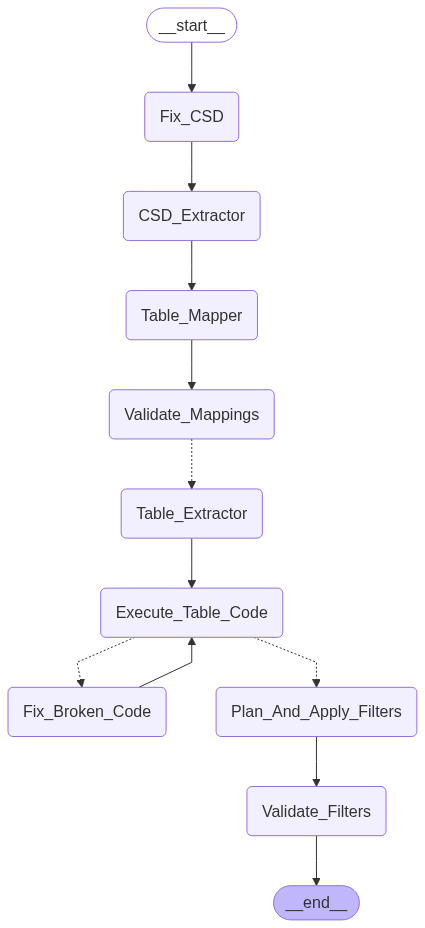

🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.
Case
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
Include patients with LAVI and LVMI available 24 hours from each other
Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
Include patients on treatment for hypertension anytime before to 1 year after the anchor
Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
Ensure that age at the time of ECG ≥ 18 years

Control
Identify patients with disease codes for hypertension or its complications (hyp

/var/folders/jf/pbld57ps1vs4h5vbgyt19mk80000gs/T/ipykernel_67690/177060238.py:908: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_datetime(df[col], errors="ignore")
/var/folders/jf/pbld57ps1vs4h5vbgyt19mk80000gs/T/ipykernel_67690/177060238.py:908: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_datetime(df[col], errors="ignore")


'table_fetch_code_final.py'

In [33]:
from typing import TypedDict, List, Any, Optional, Dict, Callable
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re, inspect
import pandas as pd
import sqlite3

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    csd_fixed: str           #raw multi-line CSD text append initial lines to case and control
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path
    cohort_df_path: str
    cohort_df: Any
    case_df_path: str
    control_df_path: str
    case_filter_log: List[dict]
    control_filter_log: List[dict]
    case_plan: List[dict]
    control_plan: List[dict]




# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Expand CSD and put common lines into CASE & CONTROL ----
def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.

    - Keeps text before 'Cohort Creation Steps' as-is
    - Removes the original 'Cohort Creation Steps' block (to avoid duplicates)
    - Rebuilds 'Case' and 'Control' sections with the generic lines prefixed
    - If markers aren't found, returns original CSD unchanged
    """
    if not isinstance(csd, str):
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip()

    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)

    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: dict) -> dict:
    raw = state.get("csd", "")  # dict access, not attribute
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(fixed)
    state["csd_fixed"] = fixed
    state["csd"] = fixed
    return state
    

# ---- Simplify CSD for Extraction ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = /"/"/"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE
/"/"/"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

    

# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "") or ""
    err = (state.get("execution_error") or "").strip()

    if not raw_code:
        return state

    changed = False

    # Always apply the general cleanup
    patched = clean_code_block(raw_code)
    if patched != raw_code:
        raw_code = patched
        changed = True

    # If the failure was a missing alias/column, try to rewrite the SQL
    m = re.search(r"no such column:\s*([A-Za-z_]\w*)\.([A-Za-z_]\w*)", err, flags=re.I)
    if m:
        bad_alias, bad_col = m.group(1), m.group(2)
        sql, i0, i1 = _pull_sql_string(raw_code)
        if sql:
            # Build alias -> table map (FROM / JOIN with or without AS)
            alias_map = {}
            for t, a in re.findall(r"\bFROM\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t
            for t, a in re.findall(r"\bJOIN\s+(\w+)\s+(?:AS\s+)?(\w+)", sql, flags=re.I):
                alias_map[a] = t

            # Introspect columns for each table
            try:
                conn = sqlite3.connect("synthetic_ehr.db")
                alias_cols = {}
                for a, t in alias_map.items():
                    try:
                        rows = conn.execute(f"PRAGMA table_info('{t}')").fetchall()
                        alias_cols[a] = {r[1].upper() for r in rows}
                    except Exception:
                        alias_cols[a] = set()
                conn.close()
            except Exception:
                alias_cols = {}

            target_alias = next((a for a, cols in alias_cols.items() if bad_col.upper() in cols), None)

            if target_alias:
                # Replace bad_alias.bad_col -> target_alias.bad_col (case-insensitive)
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    f"{target_alias}.{bad_col}",
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Replaced {bad_alias}.{bad_col} → {target_alias}.{bad_col}")
            else:
                # Fallback: unqualify the column so SQLite can resolve if unique
                sql_fixed = re.sub(
                    rf"\b{re.escape(bad_alias)}\.{re.escape(bad_col)}\b",
                    bad_col,
                    sql,
                    flags=re.I,
                )
                raw_code = raw_code[:i0] + sql_fixed + raw_code[i1:]
                changed = True
                print(f"\n🛠️ [Code_Fixer] Unqualified {bad_alias}.{bad_col} → {bad_col}")

    if changed:
        state["table_fetch_code"] = raw_code
        # clear the error so the graph re-runs Execute_Table_Code once
        state["execution_error"] = ""
    else:
        print("\nℹ️ [Code_Fixer] No changes applied to code.")
    return state




def _pull_sql_string(code: str) -> tuple[str, int, int]:
    """Return (sql_text, start_idx, end_idx) for the triple-quoted sql_query string inside code."""
    m = re.search(r'sql_query\s*=\s*("""|\'\'\')(.+?)\1', code, flags=re.S)
    if not m:
        return "", -1, -1
    return m.group(2), m.start(2), m.end(2)

# already suggested earlier; keep it if not present
def _truthy_df(x):
    try:
        return (x is not None) and hasattr(x, "empty") and (not x.empty)
    except Exception:
        return bool(x)

def _patch_df_truthiness_anywhere(code: str) -> str:
    candidates = set(re.findall(r"(\w+)\s*=\s*pd\.read_sql_query\(", code))
    candidates |= set(re.findall(r"(\w+)\s*=\s*pd\.DataFrame\(", code))
    candidates |= set(re.findall(r"\b([A-Za-z_]\w*(?:_df|DF))\b", code))
    candidates |= {"df", "cohort_df", "result_df", "joined_df"}

    if not candidates:
        return code

    def _wrap_tokens(cond: str) -> str:
        for v in sorted(candidates, key=len, reverse=True):
            cond = re.sub(
                rf"\b{re.escape(v)}\b(?!\s*(?:\.|\[|\(|is\b|==|!=))",
                f"_truthy_df({v})",
                cond,
            )
        return cond

    def _repl_if(m):
        return f"if {_wrap_tokens(m.group(1))}:"

    code = re.sub(r"^\s*if\s+(.+):\s*$", _repl_if, code, flags=re.MULTILINE)

    for v in sorted(candidates, key=len, reverse=True):
        code = re.sub(
            rf"\band\s+{re.escape(v)}\b(?!\s*(?:\.|\[|\(|is\b|==|!=))",
            f"and _truthy_df({v})",
            code,
        )
        code = re.sub(
            rf"\bor\s+{re.escape(v)}\b(?!\s*(?:\.|\[|\(|is\b|==|!=))",
            f"or _truthy_df({v})",
            code,
        )

    return code


# ---- Execution Agent ----
def clean_code_block(code: str) -> str:
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE).replace("```", "")
    code = "\n".join([ln for ln in code.splitlines() if ln.strip()]).strip()

    # Ensure LIMIT inside SQL
    lines, cleaned, in_sql = code.splitlines(), [], False
    for ln in lines:
        stripped = ln.strip()
        if re.search(r'^\s*sql_query\s*=\s*("""|\'\'\')\s*$', ln):
            in_sql = True; cleaned.append(ln); continue
        if in_sql and stripped in ('"""', "'''"):
            window = cleaned[-12:] if len(cleaned) >= 12 else cleaned[:]
            if not any(" LIMIT " in x.upper() or x.strip().upper().startswith("LIMIT ") for x in window):
                cleaned.append("LIMIT 1000")
            in_sql = False; cleaned.append(ln); continue
        cleaned.append(ln)
    code = "\n".join(cleaned)

    # Greedy patch for ANY bare-DataFrame truthiness
    code = _patch_df_truthiness_anywhere(code)

    # Dedup & ensure execution lines
    seen_exec, out = set(), []
    for ln in code.splitlines():
        s = ln.strip()
        if s in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if s in seen_exec: continue
            seen_exec.add(s)
        out.append(ln)
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        out.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        out.append("conn.close()")
    return "\n".join(out).strip()





def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))


def _first_df(*vals):
    """Return the first value that is a pandas DataFrame, else None."""
    for v in vals:
        if isinstance(v, pd.DataFrame):
            return v
    return None

def _regex_extract_sql_from_code(code: str) -> str:
    """Extract the contents of sql_query = \"\"\"...\"\"\" (or single/double quoted)."""
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    return ""


def project_needed_columns(df: pd.DataFrame) -> pd.DataFrame:
    # 1) Coalesce patient id into a single PATIENT_ID
    pid_candidates = [c for c in df.columns if re.fullmatch(r'(?:FD|FLT|FET|FEC|FM)_PATIENT_ID|PATIENT_ID|NFER_PID', c)]
    if pid_candidates and 'PATIENT_ID' not in df.columns:
        df['PATIENT_ID'] = df[pid_candidates].bfill(axis=1).iloc[:, 0]
    for c in pid_candidates:
        if c != 'PATIENT_ID':
            df.drop(columns=c, inplace=True, errors='ignore')

    # 2) Normalize/rename DTM columns you care about
    rename_map = {
        'FET_EVENT_DTM': 'ECHO_EVENT_DTM',
        'FEC_EVENT_DTM': 'ECG_EVENT_DTM',
        'EVENT_DTM': 'EVENT_DTM',   # keep generic if present
    }
    df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}, inplace=True)

    # 3) Optionally drop all other *_DTM columns you don’t want
    keep_dtms = {'ECHO_EVENT_DTM', 'ECG_EVENT_DTM', 'EVENT_DTM'}
    extra_dtms = [c for c in df.columns if c.endswith('_DTM') and c not in keep_dtms]
    df.drop(columns=extra_dtms, inplace=True, errors='ignore')

    # 4) Final projection to only the needed columns that exist
    needed = [
        'PATIENT_ID',
        'DIAGNOSIS_CODE', 'DIAGNOSIS_DESCRIPTION',
        'LAB_TEST_DESCRIPTION',
        'MED_NAME_DESCRIPTION',
        'ECHO_EVENT_DTM', 'ECG_EVENT_DTM'
    ]
    keep = [c for c in needed if c in df.columns]
    return df[keep]


def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)
    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        print(f"{i:>2}: {repr(line)}")

    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {"sqlite3": sqlite3, "pd": pd}

        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            state["execution_error"] = str(e)
            return state

        df = _first_df(local_vars.get("cohort_df"), global_context.get("cohort_df"))

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if not df.empty:
                print("✅ DataFrame has data.")
            else:
                print("⚠️ Warning: cohort_df is empty.")

            # persist to CSV
            csv_path = "cohort_df.csv"
            try:
                df.to_csv(csv_path, index=False)
                print(f"💾 Saved cohort_df → {csv_path}")
                state["cohort_df_path"] = csv_path
            except Exception as e:
                print(f"⚠️ Could not save cohort_df to CSV: {e}")
                state["cohort_df_path"] = ""

            state["cohort_df"] = df.copy()
            state["table_fetch_code"] = code
            state["execution_error"] = ""

            # --- OPTIONAL: also save the exact SQL that ran ---
            sql_str = local_vars.get("sql_query") or global_context.get("sql_query")
            if not isinstance(sql_str, str) or not sql_str.strip():
                sql_str = _regex_extract_sql_from_code(code)
            if isinstance(sql_str, str) and sql_str.strip():
                try:
                    with open("final_working_query.sql", "w", encoding="utf-8") as f:
                        f.write(sql_str.strip() + "\n")
                    # add these fields to GraphState if you want static typing
                    state["final_sql_query"] = sql_str.strip()
                    state["final_sql_path"]  = "final_working_query.sql"
                    print("💾 Saved final SQL → final_working_query.sql")
                except Exception as e:
                    print(f"⚠️ Could not save final SQL: {e}")

        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"


        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        state["execution_error"] = str(e)

    return state



#===== Validator ======
def validate_and_dedupe_mappings(state: dict) -> dict:
    raw = state.get("mappings", [])
    good, seen = [], set()
    for m in raw:
        if not isinstance(m, dict):
            continue
        tables  = [t.strip().upper() for t in m.get("tables", []) if isinstance(t, str)]
        columns = [c.strip().upper() for c in m.get("columns", []) if isinstance(c, str)]
        if not tables and not columns:
            continue
        key = json.dumps({"tables":sorted(tables), "columns":sorted(columns)}, sort_keys=True)
        if key in seen:
            continue  # <-- de-dup identical entries (Case vs Control)
        seen.add(key)
        good.append({"csd": m.get("csd",""), "tables":tables, "columns":columns})
    state["mappings"] = good
    state["next_step"] = None  # keep graph happy
    state["retry_count"] = 0
    print("✅ [Validate_Mappings] kept:", json.dumps(good, indent=2))
    return state
    


def _split_case_control_lines(csd: str) -> tuple[list[str], list[str]]:
    """Return (case_lines, control_lines) after Fix_CSD has prefixed common lines."""
    txt = (csd or "").replace("\r\n", "\n")
    m_case   = re.search(r'^\s*Case\s*:?\s*$', txt, re.I|re.M)
    m_ctrl   = re.search(r'^\s*Control\s*:?\s*$', txt, re.I|re.M)
    if not (m_case and m_ctrl):  # nothing to split
        return [], []
    case_block = txt[m_case.end():m_ctrl.start()]
    ctrl_block = txt[m_ctrl.end():]
    norm = lambda b: [ln.strip() for ln in b.splitlines() if ln.strip()]
    return norm(case_block), norm(ctrl_block)



# loader for filter funcs
def _load_filter_lib(path: str = "Filter_func.txt") -> dict:
    ns: dict = {}
    try:
        with open(path, "r", encoding="utf-8") as f:
            raw = f.read()
        lines   = raw.splitlines()
        futures = [ln for ln in lines if ln.strip().startswith("from __future__ import ")]
        others  = [ln for ln in lines if not ln.strip().startswith("from __future__ import ")]
        fixed   = "\n".join(futures + [""] + others)
        exec(compile(fixed, path, "exec"), ns)
        # Some helpers reference a global 'log_stats'. Provide a safe default.
        if "log_stats" not in ns:
            ns["log_stats"] = lambda *a, **k: None
    except Exception as e:
        print(f"⚠️ Could not load filter helpers from {path}: {e}")
    return ns



def _strip_code_fences(s: str) -> str:
    s = s.strip()
    if s.startswith("```"):
        s = re.sub(r"^```(?:json|JSON|python)?\s*", "", s)
        s = re.sub(r"\s*```$", "", s)
    return s.strip()

def _coerce_json(s: str) -> dict:
    if not isinstance(s, str):
        return {}
    s0 = _strip_code_fences(s)
    try:
        return json.loads(s0)
    except Exception:
        s1 = (s0.replace("\r", "")
                .replace("\n", " ")
                .replace(" True", " true")
                .replace(" False", " false")
                .replace(" None", " null"))
        try:
            return json.loads(s1)
        except Exception:
            i, j = s0.find("{"), s0.rfind("}")
            if i != -1 and j != -1 and j > i:
                try:
                    return json.loads(s0[i:j+1])
                except Exception:
                    return {}

_QUERY_KWS = {"and","or","not","in","True","False","None"}
def _unknown_tokens_in_expr(df: pd.DataFrame, expr: str) -> list[str]:
    tokens = re.findall(r"[A-Za-z_][A-Za-z0-9_]*", expr or "")
    cols = set(df.columns)
    return [t for t in tokens if t not in cols and t not in _QUERY_KWS]

def _first_present(df: pd.DataFrame, names: list[str]) -> str | None:
    return next((c for c in names if c in df.columns), None)

def _has(df: pd.DataFrame, *cols: str) -> bool:
    return all(c in df.columns for c in cols)

def _find_helper(F: dict, name: str) -> Optional[Callable[..., Any]]:
    fn = F.get(name)
    return fn if callable(fn) else None



def _sanitize_plans(df: pd.DataFrame,
                    case_plan: list[dict],
                    control_plan: list[dict],
                    F: dict) -> tuple[list[dict], list[dict]]:

    # choose an age helper from Filter_func.txt
    age_fn = (_find_helper(F, ["filter_age_gte","age_gte","min_age","agefilter","age"], ["df","event_col","dob_col","min_age"])
              or _find_helper(F, ["filter_age_gte","age_gte","age"], ["df","event_col","dob_col"]))  # softer fallback

    def fix(plan: list[dict]) -> list[dict]:
        out = []
        for st in (plan or []):
            st = dict(st)  # copy
            t  = st.get("type")
            ln = (st.get("line") or "")
            if t == "pandas_query":
                expr = (st.get("expr") or st.get("query") or "").strip()

                # If this CSD line is the AGE requirement, convert to a helper call
                if re.search(r"\bage\b", ln.lower()) and ("18" in ln or "≥" in ln or ">= 18" in ln):
                    event_col = _first_present(df, ["EVENT_DTM","NFER_DTM","TIMESTAMP","TIME"])
                    dob_col   = _first_present(df, ["PATIENT_BIRTH_DATE","DOB","BIRTH_DATE","DATE_OF_BIRTH"])
                    if age_fn and event_col and dob_col:
                        out.append({
                            "type":"call_filter_func",
                            "fn":age_fn,
                            "kwargs":{
                                # pass a *superset*; we'll filter by signature on call
                                "df": None, "df_merged": None,
                                "event_col": event_col, "event_column": event_col, "event_dtm": event_col,
                                "dob_col": dob_col, "birth_date_col": dob_col, "dob_column": dob_col,
                                "min_age": 18, "age": 18, "threshold": 18
                            },
                            "line": ln
                        })
                        continue
                    else:
                        # can't build an age helper; drop unsafe query
                        st["type"] = "noop"
                        st["_skip_reason"] = "no age helper or required columns"
                        st["expr"] = ""
                        out.append(st)
                        continue

                # Otherwise keep query only if all tokens are known
                bad = _unknown_tokens_in_expr(df, expr)
                if bad:
                    st["type"] = "noop"
                    st["_skip_reason"] = f"invalid tokens in expression: {bad}"
                    st["expr"] = ""
                else:
                    st["expr"] = expr
                out.append(st)

            elif t == "temporal_within":
                if st.get("anchor") not in df.columns or st.get("window") not in df.columns:
                    st["type"] = "noop"
                    st["_skip_reason"] = "missing anchor/window columns"
                out.append(st)

            else:
                out.append(st)

        return out

    return fix(case_plan), fix(control_plan)
  

# --- built-in fallback for age rule (if helper file doesn't provide one) ------
def _filter_age_gte(df: pd.DataFrame, event_col: str, dob_col: str, min_age: float) -> pd.DataFrame:
    ev = pd.to_datetime(df[event_col], errors="coerce")
    dob = pd.to_datetime(df[dob_col],   errors="coerce")
    age_years = (ev - dob).dt.days / 365.25
    return df[age_years >= float(min_age)]

def _infer_keys(df: pd.DataFrame) -> List[str]:
    pid = None
    for c in ["PATIENT_ID","NFER_PID","PERSON_ID","PID"]:
        if c in df.columns: pid = c; break
    tcol = None
    for c in ["EVENT_DTM","NFER_DTM","ECG_TIME","ECHO_EVENT_DTM","TIMESTAMP","DTM","TIME"]:
        if c in df.columns: tcol = c; break
    return [k for k in [pid, tcol] if k]

def _safe_query(df: pd.DataFrame, expr: str) -> pd.DataFrame:
    try:
        return df.query(expr, engine="python")
    except Exception as e:
        print(f"⚠️ pandas_query failed ({e}). Expr was: {expr!r}. Skipping step.")
        return df

def _apply_plan(df_in: pd.DataFrame, steps: list[dict], F: dict, cohort_name: str):
    logs: list[dict] = []
    df = df_in.copy()

    for i, st in enumerate(steps or [], 1):
        stype = st.get("type", "noop")
        line  = st.get("line", "")
        before = len(df)
        status = "ok"
        err = ""
        py_cmd = ""

        try:
            if stype == "dedupe":
                keys = [k for k in st.get("keys", []) if k in df.columns]
                if not keys:
                    status = "skipped"
                    py_cmd = "# dedupe skipped (no valid keys)"
                else:
                    py_cmd = f"df = df.drop_duplicates(subset={keys!r}, keep='first')"
                    df = df.drop_duplicates(subset=keys, keep="first")

            elif stype == "call_filter_func":
                fn_name = st.get("fn")
                fn = _find_helper(F, fn_name)
                if not fn:
                    status = "skipped"; py_cmd = f"# function {fn_name} not found"
                else:
                    # filter kwargs to match helper signature
                    sig = inspect.signature(fn)
                    kwargs = dict(st.get("kwargs", {}))
                    # if the helper expects a DataFrame param, ensure we pass it
                    for df_param in ["df", "df_merged", "df_anchor", "df_window"]:
                        if df_param in sig.parameters and df_param not in kwargs:
                            kwargs[df_param] = df
                    # fit kwargs to allowed parameters
                    kwargs = {k: v for k, v in kwargs.items() if k in sig.parameters}
                    py_cmd = f"df = {fn_name}(**{kwargs!r})"
                    df = fn(**kwargs)

            elif stype == "age_gte":
                # Build using your get_age helper
                get_age = _find_helper(F, "get_age")
                event_col = st.get("event_col")
                dob_col   = st.get("dob_col")
                min_age   = int(st.get("min_age", 18))
                if get_age and _has(df, event_col, dob_col):
                    py_cmd = (
                        f"df['__AGE'] = df.apply(lambda r: get_age(r[{dob_col!r}], r[{event_col!r}]), axis=1); "
                        f"df = df[df['__AGE'] >= {min_age}].drop(columns=['__AGE'])"
                    )
                    df["__AGE"] = df.apply(lambda r: get_age(r[dob_col], r[event_col]), axis=1)
                    df = df[df["__AGE"] >= min_age].drop(columns=["__AGE"])
                else:
                    status = "skipped"
                    py_cmd = "# age_gte skipped (get_age or columns missing)"

            else:
                status = "skipped"
                py_cmd = f"# unknown/unsupported step type: {stype}"

        except Exception as e:
            status = "error"
            err = str(e)

        after = len(df)
        logs.append({
            "step": i, "type": stype, "line": line, "status": status, "error": err,
            "rows_before": before, "rows_after": after, "rows_removed": before - after,
            "applied_python": py_cmd
        })

    return df, logs


def _plan_from_csd(df: pd.DataFrame, F: dict, csd_text: str):
    # Candidate columns we know how to use
    pid = _first_present(df, ["PATIENT_ID", "NFER_PID", "PERSON_ID", "PID"])
    echo_id = _first_present(df, ["ECHO_TEST_FPK", "ECHO_ID"])
    # datetimes (only add temporal step if both present)
    echo_time = _first_present(df, ["ECHO_EVENT_DTM", "ECHO_RESULT_EVENT_DTM", "EVENT_DTM"])
    ecg_time  = _first_present(df, ["ECG_EVENT_DTM", "ECG_TIME", "EVENT_DTM"])

    case_steps: list[dict] = []
    ctrl_steps: list[dict] = []

    # 1) dedupe: prefer patient + echo id, else patient only
    dedupe_keys = [c for c in [pid, echo_id] if c]
    if dedupe_keys:
        step = {"type":"dedupe", "keys": dedupe_keys, "line":"Identify unique patients and ECHO tests"}
        case_steps.append(step); ctrl_steps.append(step.copy())

    # 2) +/- 3 month window around anchor (use your helper only if we have two datetime cols)
    if _find_helper(F, "apply_within_temporal_filter") and echo_time and ecg_time and echo_time != ecg_time:
        tstep = {
            "type":"call_filter_func",
            "fn":"apply_within_temporal_filter",
            "kwargs":{
                "df_merged": None,                     # will be injected by _apply_plan
                "anchor_column": echo_time,            # ECHO times as anchor
                "window_column": ecg_time,             # ECG times as windowed events
                "time_window": [-90, 90],
                "time_unit": "days",
                "left_inclusive": True,
                "right_inclusive": True
            },
            "line":"Identify the most recent ECHO with ECGs around it in a +/- 3 month window"
        }
        case_steps.append(tstep); ctrl_steps.append(tstep.copy())

    # 3) one ECG per patient (if helper exists and we have a patient id)
    if _find_helper(F, "filter_one_ecg_per_patient") and pid:
        s = {
            "type":"call_filter_func",
            "fn":"filter_one_ecg_per_patient",
            "kwargs":{"df": None, "pid_col": pid},
            "line":"Keep one ECG per patient if required"
        }
        # This is optional — include only if you want to collapse to one ECG
        # case_steps.append(s); ctrl_steps.append(s.copy())

    # 4) Age ≥ 18 using your get_age (requires DOB + event time)
    dob_col   = _first_present(df, ["PATIENT_BIRTH_DATE","DOB","BIRTH_DATE","DATE_OF_BIRTH"])
    event_col = _first_present(df, ["ECG_EVENT_DTM","EVENT_DTM","ECHO_EVENT_DTM","NFER_DTM","TIMESTAMP","TIME"])
    if _find_helper(F, "get_age") and dob_col and event_col:
        a = {"type":"age_gte", "event_col": event_col, "dob_col": dob_col, "min_age": 18,
             "line":"Ensure that age at the time of ECG ≥ 18 years"}
        case_steps.append(a); ctrl_steps.append(a.copy())

    # NOTE: Lines about LAVI/LVMI, HHD before anchor, etc. are omitted unless the
    # necessary columns exist. You can extend this deterministically once those appear.

    return case_steps, ctrl_steps





# === NEW: CASE/CONTROL filter planning ===
filter_plan_prompt = """
You are planning filters for CASE and CONTROL cohorts based on the CSD.
Use ONLY the columns that actually exist in the input DataFrame: {columns}.

Allowed step types (JSON objects):
- {{ "type":"dedupe", "keys":["..."] }}
- {{ "type":"pandas_query", "expr":"<pandas boolean expression using only existing columns>" }}
- {{ "type":"temporal_within", "anchor":"ANCHOR_EVENT_DTM", "window":"EVENT_DTM",
     "time_window_days":[-90,90], "left_inclusive":true, "right_inclusive":true }}
- {{ "type":"call_filter_func", "fn":"apply_within_temporal_filter",
     "kwargs":{{"anchor_column":"ANCHOR_EVENT_DTM","window_column":"EVENT_DTM",
               "time_window":[-90,90],"time_unit":"days",
               "left_inclusive":true,"right_inclusive":true}} }}

Every step MUST include a "line" field with the CSD sentence it implements.

Rules:
- If a referenced column doesn’t exist, prefer a simpler equivalent that does (or omit the step).
- Start with a dedupe when both patient/time keys exist (e.g., PATIENT_ID+EVENT_DTM or NFER_PID+NFER_DTM).
- Use 'pandas_query' for simple value/flag filters.
- Use the temporal step only if both columns exist.
- Do not invent columns or functions.

Return ONLY JSON:
{{ "case":[{{...}}], "control":[{{...}}] }}

CSD:
{csd}
"""


# === Build CASE/CONTROL cohorts from cohort_df ===
def plan_and_apply_filters(state: dict) -> dict:
    # Prefer CSV written by Execute_Table_Code
    df = None
    csv_path = state.get("cohort_df_path")

    if csv_path:
        try:
            df = pd.read_csv(csv_path)
            print(f"📥 Loaded cohort_df from {csv_path} (shape={df.shape})")
            # best-effort datetime parsing on obvious columns
            for col in [c for c in df.columns if any(k in c.upper() for k in ["DTM", "DATE", "TIME"])]:
                try:
                    df[col] = pd.to_datetime(df[col], errors="ignore")
                except Exception:
                    pass
        except Exception as e:
            print(f"⚠️ Failed to read {csv_path}: {e}. Falling back to in-memory DataFrame.")

    if not isinstance(df, pd.DataFrame):
        df = state.get("cohort_df")

    if not isinstance(df, pd.DataFrame):
        print("⚠️ No cohort_df present — skipping filter agent.")
        state["case_plan"] = []; state["control_plan"] = []
        state["case_filter_log"] = []; state["control_filter_log"] = []
        state["case_df_path"] = ""; state["control_df_path"] = ""
        return state

    F = _load_filter_lib()
    print("have get_age:", callable(F.get("get_age")))
    print("have apply_within_temporal_filter:", callable(F.get("apply_within_temporal_filter")))

    case_plan, ctrl_plan = _plan_from_csd(df, F, state.get("csd",""))

    case_df, case_log = _apply_plan(df, case_plan, F, "CASE")
    ctrl_df, ctrl_log = _apply_plan(df, ctrl_plan, F, "CONTROL")

    # Persist outputs
    case_path, ctrl_path = "case_filtered.parquet", "control_filtered.parquet"
    try:
        case_df.to_parquet(case_path, index=False)
        ctrl_df.to_parquet(ctrl_path, index=False)
    except Exception:
        case_path, ctrl_path = "case_filtered.csv", "control_filtered.csv"
        case_df.to_csv(case_path, index=False)
        ctrl_df.to_csv(ctrl_path, index=False)

    state["case_plan"] = case_plan
    state["control_plan"] = ctrl_plan
    state["case_filter_log"] = case_log
    state["control_filter_log"] = ctrl_log
    state["case_df_path"] = case_path
    state["control_df_path"] = ctrl_path

    def _print(log, name):
        print(f"\n📉 {name} step-wise row changes:")
        for r in log:
            print(f"  • Step {r['step']} ({r['type']}, {r['status']}): -{r['rows_removed']}  "
                  f"[{r['rows_before']} → {r['rows_after']}] — {r.get('line','')[:120]}")
            if r.get("applied_python"):
                print(f"      ↳ {r['applied_python']}")
            if r.get("error"):
                print(f"      ⚠️ {r['error']}")

    _print(case_log, "CASE")
    _print(ctrl_log, "CONTROL")

    return state



    

# === Filter validator ===
filter_validator_prompt = """
You are validating whether the applied filter steps cover the CSD instructions.

Return ONLY JSON:
{{ 
  "case":[{{"line":"...", "matched_step": null, "valid": true, "explanation":"..."}}], 
  "control":[{{"line":"...", "matched_step": null, "valid": true, "explanation":"..."}}]
}}

CSD (lines):
{csd_lines}

CASE plan (steps):
{case_plan}

CASE logs (rows removed etc.):
{case_log}

CONTROL plan (steps):
{control_plan}

CONTROL logs (rows removed etc.):
{control_log}
"""

def validate_filters(state: dict) -> dict:
    def _all_ok(logs: list[dict]) -> bool:
        # valid if there is at least one step and none is 'error'
        return bool(logs) and all(x["status"] == "ok" for x in logs)

    case_ok = _all_ok(state.get("case_filter_log", []))
    ctrl_ok = _all_ok(state.get("control_filter_log", []))

    # If both sides are clean, we're done
    if case_ok and ctrl_ok:
        print("\n✅ Filter validation: OK")
        state["filter_validation"] = {"case":"ok","control":"ok"}
        return state

    # Retry once: prune failing/skipped steps and re-apply
    retry_count = state.get("filter_retry_count", 0)
    if retry_count >= 1:
        print("\n⚠️ Validation still failing after retry. Keeping the best-effort cohorts.")
        state["filter_validation"] = {"case":"retry_failed" if not case_ok else "ok",
                                      "control":"retry_failed" if not ctrl_ok else "ok"}
        return state

    print("\n🔁 Validation failed — retrying with only successful steps…")
    state["filter_retry_count"] = retry_count + 1

    # Keep only steps that ran OK
    def keep_ok(steps: list[dict], logs: list[dict]) -> list[dict]:
        ok_idx = {i for i, lg in enumerate(logs) if lg.get("status") == "ok"}
        return [st for i, st in enumerate(steps) if i in ok_idx]

    case_steps = keep_ok(state.get("case_plan", []), state.get("case_filter_log", []))
    ctrl_steps = keep_ok(state.get("control_plan", []), state.get("control_filter_log", []))

    F = _load_filter_lib()
    base_df = state.get("cohort_df")

    case_df, case_log = _apply_plan(base_df, case_steps, F, "CASE(retry)")
    ctrl_df, ctrl_log = _apply_plan(base_df, ctrl_steps, F, "CONTROL(retry)")

    # Persist
    case_path, ctrl_path = "case_filtered.parquet", "control_filtered.parquet"
    try:
        case_df.to_parquet(case_path, index=False)
        ctrl_df.to_parquet(ctrl_path, index=False)
    except Exception:
        case_path, ctrl_path = "case_filtered.csv", "control_filtered.csv"
        case_df.to_csv(case_path, index=False)
        ctrl_df.to_csv(ctrl_path, index=False)

    state["case_plan"] = case_steps
    state["control_plan"] = ctrl_steps
    state["case_filter_log"] = case_log
    state["control_filter_log"] = ctrl_log
    state["case_df_path"] = case_path
    state["control_df_path"] = ctrl_path

    # Mark validation result
    state["filter_validation"] = {
        "case": "ok" if all(x["status"]=="ok" for x in case_log) else "best_effort",
        "control": "ok" if all(x["status"]=="ok" for x in ctrl_log) else "best_effort",
    }

    return state

def save_table_fetch_code(state: dict, path: str = "final_table_fetch_code.py") -> str | None:
    """Save the LLM-generated Python block from state['table_fetch_code'] to a .py file.
    Strips markdown fences if the model returned them."""
    code = state.get("table_fetch_code", "") or ""
    # strip markdown fences, if your helper exists use it; otherwise do a quick strip here
    try:
        code = _strip_code_fences(code)  # you already defined this in your file
    except NameError:
        import re
        code = re.sub(r"^```(?:python)?\s*", "", code.strip(), flags=re.IGNORECASE)
        code = re.sub(r"\s*```$", "", code)

    if not code.strip():
        print("⚠️ No table_fetch_code to save.")
        return None

    with open(path, "w", encoding="utf-8") as f:
        if not code.endswith("\n"):
            code += "\n"
        f.write(code)

    print(f"💾 Saved table_fetch_code → {path}")
    return path






# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(validate_and_dedupe_mappings))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))
builder.add_node("Plan_And_Apply_Filters", RunnableLambda(plan_and_apply_filters))
builder.add_node("Validate_Filters", RunnableLambda(validate_filters))


builder.set_entry_point("Fix_CSD")
builder.add_edge("Fix_CSD", "CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges("Validate_Mappings", lambda s: s.get("next_step"), { None: "Table_Extractor" })

builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda state: "Fix_Broken_Code" if state.get("execution_error") else "Plan_And_Apply_Filters",
    {"Fix_Broken_Code": "Fix_Broken_Code",
     "Plan_And_Apply_Filters": "Plan_And_Apply_Filters"}
)
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code")   
builder.add_edge("Plan_And_Apply_Filters", "Validate_Filters")
builder.add_edge("Validate_Filters", END)

graph = builder.compile()
# ---- Visualize Graph ----
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Mermaid render failed:", e)


# ---- Run Graph ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,"csd_fixed" :"","execution_error":"",
    "simple_csd": [], "mappings": [], "table_fetch_code": "",
    "last_step": "", "retry_count": 0,"cohort_df": None,"case_df_path": "","control_df_path": "",
    "case_filter_log": [],"control_filter_log": [],"case_plan": [],"control_plan": [],"cohort_df_path": "",
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])

# Save the code to a .py file
save_table_fetch_code(final_state, path="table_fetch_code_final.py")


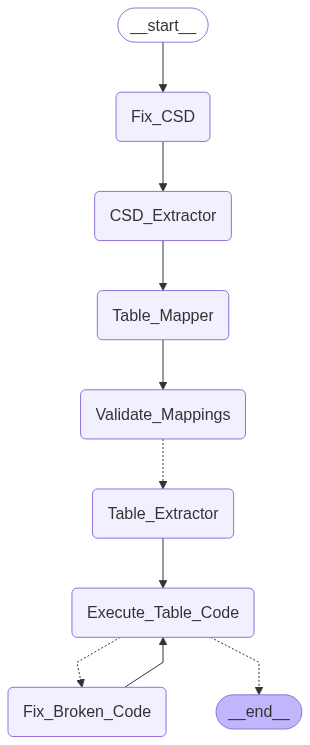

🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.
Case
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
Include patients with LAVI and LVMI available 24 hours from each other
Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
Include patients on treatment for hypertension anytime before to 1 year after the anchor
Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
Ensure that age at the time of ECG ≥ 18 years

Control
Identify patients with disease codes for hypertension or its complications (hyp

KeyError: 'Input to ChatPromptTemplate is missing variables {\'"csd"\'}.  Expected: [\'"csd"\', \'csd\'] Received: [\'csd\']\nNote: if you intended {"csd"} to be part of the string and not a variable, please escape it with double curly braces like: \'{{"csd"}}\'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT '

In [20]:
# ===================== PATCHED SCRIPT (key changes marked) =====================

from typing import TypedDict, List, Optional  # [MOD] add Optional
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re
import sqlite3                     # [NEW]
import pandas as pd                # [NEW]

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    csd_fixed: str           # raw multi-line CSD text append initial lines to case and control
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path
    final_sql_query: str
    final_sql_path: str
    cohort_df_path: str
    cohort_df: str
    next_step: Optional[str]

# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Expand CSD and put common lines into CASE & CONTROL ----
def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.
    ...
    """
    if not isinstance(csd, str): #check if csd is a string else return unchanged
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip() #Normalizes newlines; trims leading/trailing whitespace.

    #looks for headers in CSD
    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)
    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure. If either “Case” or “Control” is missing, bail out safely.
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: dict) -> dict:
    raw = state.get("csd", "") 
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(fixed)
    state["csd_fixed"] = fixed
    state["csd"] = fixed
    return state
    

# ---- Simplify CSD for Extraction ignoring temporal logic ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"},
  {"csd": "...", "entities": "Lab tests for dyslipidemia"}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments
- Critically, ensure the SELECT list includes:
  * Exactly one patient identifier column named `PATIENT_ID` sourced from the primary (FROM) alias:
      - If that table has `PATIENT_ID`, select `<FROM_ALIAS>.PATIENT_ID AS PATIENT_ID`
      - Else if it has `NFER_PID`, select `<FROM_ALIAS>.NFER_PID AS PATIENT_ID`
  * All columns whose names end with `_DTM` from ANY joined table; alias them as `<ALIAS>_<COL>`

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = \"\"\"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE
\"\"\"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""  # [MOD] prompt strengthened to include ID + *_DTM columns

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state


# ======= Helper function for Fixing Error in the Query (if any) =======

def _pull_sql_string(code: str) -> tuple[str, int, int]:
    """
    Return (sql_text, start_index, end_index) for the SQL inside:
      sql_query = \"\"\" ... \"\"\"   OR   sql_query = '...'/\"...\"
    If not found, returns ("", -1, -1).
    """
    # triple quotes first
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body"), m.start("body"), m.end("body")
    # single or double quotes
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body"), m.start("body"), m.end("body")
    return ("", -1, -1)
    
# --- Robust SQL extraction for saving ---
def _regex_extract_sql_from_code(code: str) -> str:
    """
    Pull the SQL contents out of: sql_query = \"\"\" ... \"\"\"  (or single/double quoted).
    Falls back to empty string if not found.
    """
    # triple-quote first
    m = re.search(r'sql_query\s*=\s*(?P<q>"""|\'\'\')(?P<body>.*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    # single/double quotes
    m = re.search(r'sql_query\s*=\s*(?P<q>"|\')(?P<body>(?:\\.|(?!\1).)*?)(?P=q)', code, re.DOTALL | re.IGNORECASE)
    if m:
        return m.group("body").strip()
    return ""


# ===================== ENFORCER: ensure PATIENT_ID and *_DTM =====================

def _parse_aliases(sql: str) -> tuple[Optional[str], dict]:
    """
    Returns (primary_alias, alias_map) where alias_map maps alias -> table.
    If alias is omitted in SQL, we treat alias == table.
    """
    alias_map = {}
    primary_alias = None

    m_from = re.search(r'\bFROM\s+(\w+)(?:\s+(?:AS\s+)?(\w+))?', sql, flags=re.IGNORECASE)
    if m_from:
        table = m_from.group(1)
        alias = m_from.group(2) or table
        alias_map[alias] = table
        primary_alias = alias

    for t, a in re.findall(r'\bJOIN\s+(\w+)(?:\s+(?:AS\s+)?(\w+))?', sql, flags=re.IGNORECASE):
        alias_map[a or t] = t

    return primary_alias, alias_map

def _select_has_token(select_part: str, alias: str, col: str) -> bool:
    """
    Rough check if select_part already references the given column
    (qualified or unqualified). Case-insensitive, word-boundary aware.
    """
    patt_qual = rf'\b{re.escape(alias)}\s*\.\s*{re.escape(col)}\b'
    patt_unq  = rf'\b{re.escape(col)}\b'
    return re.search(patt_qual, select_part, flags=re.IGNORECASE) or \
           re.search(patt_unq,  select_part, flags=re.IGNORECASE)

def _ensure_id_and_dtm_in_sql(sql: str, conn: sqlite3.Connection) -> tuple[str, list]:
    """
    If SELECT does not contain '*', append:
      - Exactly one PATIENT_ID (prefer PATIENT_ID, else NFER_PID) from primary alias,
        aliased as PATIENT_ID.
      - All *_DTM columns from all aliases, aliased as <ALIAS>_<COL>.
    Returns (patched_sql, additions_list_for_logging)
    """
    # Split SELECT ... FROM ...
    m = re.search(r'(?is)^\s*SELECT\s+(?P<select>.*?)\s+FROM\s+(?P<rest>.+)$', sql, flags=re.DOTALL)
    if not m:
        return sql, []

    select_part = m.group('select').strip()
    rest_part   = m.group('rest')

    # If star present, we assume all columns already included
    if '*' in select_part:
        return sql, []

    primary_alias, alias_map = _parse_aliases(sql)
    if not alias_map:
        return sql, []

    additions = []

    # Introspect columns for each table
    alias_cols_upper = {}
    for a, t in alias_map.items():
        try:
            rows = conn.execute(f"PRAGMA table_info('{t}')").fetchall()
            alias_cols_upper[a] = {r[1].upper() for r in rows}
        except Exception:
            alias_cols_upper[a] = set()

    # Ensure one patient identifier from primary alias
    if primary_alias:
        cols = alias_cols_upper.get(primary_alias, set())
        id_col = None
        if 'PATIENT_ID' in cols:
            id_col = 'PATIENT_ID'
        elif 'NFER_PID' in cols:
            id_col = 'NFER_PID'

        if id_col:
            # If not already present, add <alias>.ID_COL AS PATIENT_ID
            if not (_select_has_token(select_part, primary_alias, 'PATIENT_ID') or
                    _select_has_token(select_part, primary_alias, 'NFER_PID') or
                    re.search(r'\bPATIENT_ID\b', select_part, flags=re.IGNORECASE)):
                additions.append(f"{primary_alias}.{id_col} AS PATIENT_ID")

    # Ensure all *_DTM columns from all aliases
    for a, cols in alias_cols_upper.items():
        for col in sorted(c for c in cols if c.endswith('_DTM')):
            if not _select_has_token(select_part, a, col):
                additions.append(f"{a}.{col} AS {a}_{col}")

    if not additions:
        return sql, []

    new_select = select_part + ", " + ", ".join(additions)
    patched_sql = f"SELECT {new_select} FROM {rest_part}"
    return patched_sql, additions


# ---- Clean Code ----
def clean_code_block(code: str) -> str:
    import re
    ...
    return code



# ---- Code Executor + Bug Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
...
"""

def fix_broken_sql_code(state):
    ...
    return state


def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))


def _first_df(*vals):
    """Return the first value that is a pandas DataFrame, else None."""
    for v in vals:
        if isinstance(v, pd.DataFrame):
            return v
    return None


def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)

    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    # --- Show numbered code for debugging ---
    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        print(f"{i:>2}: {repr(line)}") 

    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {
            "sqlite3": sqlite3,
            "pd": pd,
        }

        # Setup connection
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        # [NEW] BEFORE executing, enforce presence of PATIENT_ID and *_DTM
        sql_text, i0, i1 = _pull_sql_string(code)
        if sql_text and i0 >= 0 and i1 >= 0:
            patched_sql, added = _ensure_id_and_dtm_in_sql(sql_text, conn)
            if patched_sql != sql_text:
                code = code[:i0] + patched_sql + code[i1:]
                print("🧩 [Enforcer] Injected columns:", ", ".join(added))

        # Try executing the (possibly patched) code
        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            state["execution_error"] = str(e)
            conn.close()
            return state

        df = _first_df(local_vars.get("cohort_df"), global_context.get("cohort_df"))

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if not df.empty:
                print("✅ DataFrame has data.")
            else:
                print("⚠️ Warning: cohort_df is empty.")

            # persist to CSV
            csv_path = "cohort_df.csv"
            try:
                df.to_csv(csv_path, index=False)
                print(f"💾 Saved cohort_df → {csv_path}")
                state["cohort_df_path"] = csv_path
            except Exception as e:
                print(f"⚠️ Could not save cohort_df to CSV: {e}")
                state["cohort_df_path"] = ""

            state["cohort_df"] = df.copy()
            state["table_fetch_code"] = code
            state["execution_error"] = ""

            # --- OPTIONAL: also save the exact SQL that ran ---
            sql_str = local_vars.get("sql_query") or global_context.get("sql_query")
            if not isinstance(sql_str, str) or not sql_str.strip():
                sql_str = _regex_extract_sql_from_code(code)
            if isinstance(sql_str, str) and sql_str.strip():
                try:
                    with open("final_working_query.sql", "w", encoding="utf-8") as f:
                        f.write(sql_str.strip() + "\n")
                    state["final_sql_query"] = sql_str.strip()
                    state["final_sql_path"]  = "final_working_query.sql"
                    print("💾 Saved final SQL → final_working_query.sql")
                except Exception as e:
                    print(f"⚠️ Could not save final SQL: {e}")

        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"

        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        state["execution_error"] = str(e)

    return state


# -------- Cleans up and Deduplicates LLM mapping results ---------
def validate_and_dedupe_mappings(state: dict) -> dict:
    raw = state.get("mappings", [])
    good, seen = [], set()
    for m in raw:
        if not isinstance(m, dict):
            continue
        tables  = [t.strip().upper() for t in m.get("tables", []) if isinstance(t, str)]
        columns = [c.strip().upper() for c in m.get("columns", []) if isinstance(c, str)]
        if not tables and not columns:
            continue
        key = json.dumps({"tables":sorted(tables), "columns":sorted(columns)}, sort_keys=True)
        if key in seen:
            continue  # <-- de-dup identical entries (Case vs Control)
        seen.add(key)
        good.append({"csd": m.get("csd",""), "tables":tables, "columns":columns})
    state["mappings"] = good
    state["next_step"] = None  # keep graph happy
    state["retry_count"] = 0
    print("✅ [Validate_Mappings] kept:", json.dumps(good, indent=2))
    return state


# ---------- Utility function to save Python code block --------------
def save_table_fetch_code(state: dict, path: str = "final_table_fetch_code.py") -> str | None:
    """Save the LLM-generated Python block from state['table_fetch_code'] to a .py file.
    Strips markdown fences if the model returned them."""
    code = state.get("table_fetch_code", "") or ""
    # strip markdown fences, if your helper exists use it; otherwise do a quick strip here
    try:
        code = _strip_code_fences(code)  # you already defined this in your file
    except NameError:
        import re
        code = re.sub(r"^```(?:python)?\s*", "", code.strip(), flags=re.IGNORECASE)
        code = re.sub(r"\s*```$", "", code)

    if not code.strip():
        print("⚠️ No table_fetch_code to save.")
        return None

    with open(path, "w", encoding="utf-8") as f:
        if not code.endswith("\n"):
            code += "\n"
        f.write(code)

    print(f"💾 Saved table_fetch_code → {path}")
    return path


# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(validate_and_dedupe_mappings))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))

builder.set_entry_point("Fix_CSD")
builder.add_edge("Fix_CSD", "CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges("Validate_Mappings", lambda s: s.get("next_step"), { None: "Table_Extractor" })

builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda state: "Fix_Broken_Code" if state.get("execution_error") else None,
    {
        "Fix_Broken_Code": "Fix_Broken_Code",
        None: END  # Stop graph if execution_error is empty (i.e., success)
    }
)
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code") 

graph = builder.compile()

# ---- Visualize Graph ----
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Mermaid render failed:", e)

# ---- Run Graph (example) ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,"csd_fixed": "",
    "simple_csd": [], "mappings": [],  "table_fetch_code": "",
    "last_step": "", "retry_count": 0,"execution_error": "",
    "final_sql_query": "", "final_sql_path": ""
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])
save_table_fetch_code(final_state, path="table_fetch_code_final.py")
# ===================== END PATCH =====================


In [4]:
# Filter Functions

import pandas as pd
from typing import List, Any, Tuple
from __future__ import annotations
import numpy as np
from typing import List, Tuple
from tqdm import tqdm



ONE_DAY_SECONDS = 60 * 60 * 24
ONE_HOUR_SECONDS = 60 * 60

def get_age(
    df_event: pd.DataFrame,
    df_birth: pd.DataFrame,
    event_column: str,
    birth_column: str,
    age_column: str,
    pid_column: str="NFER_PID",
):
    """
    Calculate the age of patients at the time of the event.

    This function calculates the age of patients at the time of the event by subtracting their birth year from the event year.

    Parameters:

    - df_event (pd.DataFrame): The DataFrame containing the event data.
    - df_birth (pd.DataFrame): The DataFrame containing the birth year of patients.
    - event_column (str): The name of the column in `df_event` containing the event year.
    - age_column (str): The name of the column to store the calculated age.

    Returns:

    - pd.DataFrame: The DataFrame containing the calculated age of patients at the time of the event.

    """
    df_merged = pd.merge(
        df_event, 
        df_birth,
        how="left",
        on=pid_column,
    )
    df_merged[age_column] = (df_merged[event_column] - df_merged[birth_column])/(60*60*24*365.25)
    df_merged[age_column] = df_merged[age_column].round(4)
    df_merged = df_merged.drop(columns=[birth_column], axis=1)
    return df_merged



def filter_one_ecg_per_patient(
        df_ecg: pd.DataFrame,
        dtm_col: str = "ECG_TIME",
        random_state: int = 42,
)-> pd.DataFrame:
    """
    Filter DataFrame to retain only one record per patient while excluding rows with missing ECG timestamps. 

    Parameters

    - df_ecg (pd.DataFrame): The DataFrame containing ECG data.
    - dtm_col (str, optional): The name of the column with ECG timestamps. Defaults to "ECG_TIME".

    Returns:
    
    - pd.DataFrame: DataFrame with only one ECG record per patient, excluding rows with NaN in dtm_col.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import filter_one_ecg_per_patient
        >>> data = {
        ...     "NFER_PID": [101, 101, 102, 103, 103],
        ...     "ECG_VALUE": [0.8, 0.9, 1.2, 0.7, 1.0],
        ...     "NFER_DTM": [1679851600, 1679853000, 1679854200, 1679854600, 1679938200]
        ... }
        >>> df = pd.DataFrame(data)
        >>> filtered_df = filter_one_ecg_per_patient(df, dtm_col="NFER_DTM")
        >>> print(filtered_df)
           NFER_PID  ECG_VALUE    NFER_DTM
        1       101        0.9  1679853000
        4       103        1.0  1679938200
        2       102        1.2  1679854200
    """
    df_ecg = df_ecg.sample(frac=1, random_state=random_state)
    df_one_ecg_per_patient = df_ecg.drop_duplicates(subset=["NFER_PID"])
    df_one_ecg_per_patient.dropna(subset=[dtm_col], inplace=True)
    return df_one_ecg_per_patient





def perform_within_event_merge(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    bound_columns: List[str],
    filter_column: str,
    left_inclusive: bool = True,
    right_inclusive: bool = True,
) -> pd.DataFrame:
    """
    This function merges two  DataFrames, df_anchor and df_window, using a common NFER_PID column.
    It utilizes two timestamp columns specified in bound_columns to define separate time intervals for two different events in the dataframes. 
    It then selects rows from the merged DataFrame where the timestamp in the filter_column falls within both the defined time intervals in the bound_columns.
    This feature allows for the identification and analysis of events that occur within the specified time ranges for different events from two dataframe.

    Parameters:

    - df_anchor (pd.DataFrame): The anchor DataFrame.
    - df_window (pd.DataFrame): The window DataFrame.
    - bound_columns (List[str]): A list of column names for bounds.
    - filter_column (str): The column to filter on.
    - left_inclusive (bool): Whether the left comparison is inclusive (default is True).
    - right_inclusive (bool): Whether the right comparison is inclusive (default is True).

    Returns:

    - pd.DataFrame: A DataFrame containing the merged and filtered data.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import perform_within_event_merge
        >>> df_anchor = pd.DataFrame({'NFER_PID': [1, 2, 3], 'DRUG_A':[1668902400, 1651708800, 1664496000] ,'DRUG_A_date':["2022-11-20", "2022-05-05", "2022-09-30"], 'DISEASE_DTM':[1685577600, 1676332800, 1697760000],'DISEASE_date':["2023-06-01", "2023-02-14", "2023-10-20"]})
        >>> df_window = pd.DataFrame({'NFER_PID': [2, 3, 1], 'DRUG_B':[1681516800, 1692921600, 1702166400] ,'DRUG_B_date':["2023-04-15", "2023-08-25", "2023-12-10"]})
        >>> bound_columns = ['DRUG_A', 'DRUG_B']
        >>> filter_column = 'DISEASE_DTM'
        >>> perform_within_event_merge(
                df_anchor=df_anchor, 
                df_window=df_window, 
                bound_columns=bound_columns, 
                filter_column=filter_column
            )
        	NFER_PID	DRUG_A	DRUG_A_date	DISEASE_DTM	DISEASE_date	DRUG_B	DRUG_B_date
            0	1	1668902400	2022-11-20	1685577600	2023-06-01	1702166400	2023-12-10
            1	2	1651708800	2022-05-05	1676332800	2023-02-14	1681516800	2023-04-15
            
    """

    df_merged = pd.merge(df_anchor, df_window, how="inner", on="NFER_PID").drop_duplicates()

    if bound_columns[0] == filter_column:
        bound_columns[0] = bound_columns[0] + "_x"
        filter_column = filter_column + "_y"
    if bound_columns[1] == filter_column:
        bound_columns[0] = bound_columns[0] + "_x"
        filter_column = filter_column + "_y"
    
    if left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] >= df_merged[bound_columns[0]]) &
            (df_merged[filter_column] <= df_merged[bound_columns[1]])
        ]
    elif left_inclusive and not right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] >= df_merged[bound_columns[0]]) &
            (df_merged[filter_column] < df_merged[bound_columns[1]])
        ]
    elif not left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] > df_merged[bound_columns[0]]) &
            (df_merged[filter_column] <= df_merged[bound_columns[1]])
        ]
    else:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] > df_merged[bound_columns[0]]) &
            (df_merged[filter_column] < df_merged[bound_columns[1]])
        ]
    
    return df_merged_filtered




def perform_outside_event_merge(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    bound_columns: List[str],
    filter_column: str,
    left_inclusive: bool = True,
    right_inclusive: bool = True,
) -> pd.DataFrame:
    """
    This function merges two  DataFrames, df_anchor and df_window, using a common NFER_PID column.
    It utilizes two timestamp columns specified in bound_columns to define separate time intervals for two different events in the dataframes. 
    It then selects rows from the merged DataFrame where the timestamp in the filter_column falls outside both the defined time intervals in the bound_columns.
    This feature allows for the identification and analysis of events that occur outside the specified time ranges for different events from two dataframe.

    Parameters:

    - df_anchor (pd.DataFrame): The anchor DataFrame.
    - df_window (pd.DataFrame): The window DataFrame.
    - bound_columns (List[str]): A list of column names for bounds.
    - filter_column (str): The column to filter on.
    - left_inclusive (bool): Whether the left comparison is inclusive (default is True).
    - right_inclusive (bool): Whether the right comparison is inclusive (default is True).

    Returns:

    - pd.DataFrame: A DataFrame containing the merged and filtered data.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import perform_outside_event_merge
        >>> df_anchor = pd.DataFrame({'NFER_PID': [1, 2, 3], 'DRUG_A':[1668902400, 1651708800, 1664496000] ,'DRUG_A_date':["2022-11-20", "2022-05-05", "2022-09-30"], 'DISEASE_DTM':[1685577600, 1676332800, 1697760000],'DISEASE_date':["2023-06-01", "2023-02-14", "2023-10-20"]})
        >>> df_window = pd.DataFrame({'NFER_PID': [2, 3, 1], 'DRUG_B':[1681516800, 1692921600, 1702166400] ,'DRUG_B_date':["2023-04-15", "2023-08-25", "2023-12-10"]})
        >>> bound_columns = ['DRUG_A', 'DRUG_B']
        >>> filter_column = 'DISEASE_DTM'
        >>> perform_outside_event_merge(
                df_anchor=df_anchor, 
                df_window=df_window, 
                bound_columns=bound_columns, 
                filter_column=filter_column
            )
        	NFER_PID	DRUG_A	DRUG_A_date	DISEASE_DTM	DISEASE_date	DRUG_B	DRUG_B_date
            2	3	1664496000	2022-09-30	1697760000	2023-10-20	1692921600	2023-08-25

    """

    df_merged = pd.merge(df_anchor, df_window, how="inner", on="NFER_PID").drop_duplicates()

    if bound_columns[0] == filter_column:
        bound_columns[0] = bound_columns[0] + "_x"
        filter_column = filter_column + "_y"
    if bound_columns[1] == filter_column:
        bound_columns[0] = bound_columns[0] + "_x"
        filter_column = filter_column + "_y"
    
    if left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] <= df_merged[bound_columns[0]]) |
            (df_merged[filter_column] >= df_merged[bound_columns[1]])
        ]
    elif left_inclusive and not right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] <= df_merged[bound_columns[0]]) |
            (df_merged[filter_column] > df_merged[bound_columns[1]])
        ]
    elif not left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] < df_merged[bound_columns[0]]) |
            (df_merged[filter_column] >= df_merged[bound_columns[1]])
        ]
    else:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] < df_merged[bound_columns[0]]) |
            (df_merged[filter_column] > df_merged[bound_columns[1]])
        ]
    
    return df_merged_filtered




def accumulate_window_patients(
        df_windows : List[pd.DataFrame],
        operation: str,
)-> pd.DataFrame:
    """
    Accumulate patients from the list of DataFrames based on the specified operation.

    This function takes a list of DataFrames `df_windows`, each containing ECG data for a specific window.
    It performs an accumulation of patient IDs based on the specified `operation`. The operation can be either "or" or "and".

    The "or" operation merges the patient IDs present in all DataFrames, resulting in a union of all patients.
    The "and" operation finds the common patient IDs across all DataFrames, resulting in an intersection.

    Parameters:
    
    - df_windows (List[pd.DataFrame]): A list of DataFrames, each containing ECG data for a specific window.
    - operation (str): The operation to perform for accumulating patients. Valid values are "or" and "and".

    Returns:
        
    - set: A set containing the accumulated patient IDs based on the specified operation.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import accumulate_window_patients
        >>> data1 = {
        ...     "NFER_PID": [101, 102, 103],
        ...     "LABTEST_A": [0.8, 0.9, 1.2]
        ... }
        >>> data2 = {
        ...     "NFER_PID": [102, 103, 104],
        ...     "LABTEST_B": [1.1, 0.7, 1.0]
        ... }
        >>> df1 = pd.DataFrame(data1)
        >>> df2 = pd.DataFrame(data2)
        >>> window_patients = accumulate_window_patients([df1, df2], "or")
        >>> print(window_patients)
        {101, 102, 103, 104}
        >>> window_patients = accumulate_window_patients([df1, df2], "and")
        >>> print(window_patients)
        {102, 103}
    """

    window_patients = set()
    if operation == "or":
        for df_window in df_windows:
            window_patients = window_patients | set(df_window["NFER_PID"])
    elif operation == "and":
        set_pids = [set(df_window["NFER_PID"]) for df_window in df_windows]
        window_patients = set.intersection(*set_pids)
    return window_patients






def filter_patients(
        df_anchor: pd.DataFrame,      
        *df_windows : List[pd.DataFrame],
        operation: str = "or",
)-> pd.DataFrame:
    """
    Filter patients in df_anchor from df_windows based on the specified operation.

    This function filters patients in the DataFrame `df_anchor` based on the patient IDs accumulated from multiple
    DataFrames provided in `df_windows`. The accumulation of patient IDs is performed based on the specified
    `operation`, which can be either "or" or "and".

    The "or" operation includes patients that are present in any of the DataFrames in `df_windows`.
    The "and" operation includes patients that are common across all DataFrames in `df_windows`.

    Parameters:

    - df_anchor (pd.DataFrame): The DataFrame containing ECG data for the anchor group of patients.
    - *df_windows (List[pd.DataFrame]): Variable-length argument list of DataFrames, each containing patient ID ("NFER_PID") and timestamp ("NFER_DTM").
    - operation (str, optional): The operation to perform for filtering patients. Defaults to "or".

    Returns:

    - pd.DataFrame: A new DataFrame containing only the patients present in `df_anchor` that match the accumulated patient IDs from `df_windows`.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import filter_patients
        >>> data_anchor = {
        ...     "NFER_PID": [101, 102, 103, 104],
        ...     "NFER_DTM": [1679851600, 1679853000, 1679854200, 1679854600]
        ... }
        >>> data_window1 = {
        ...     "NFER_PID": [102, 103, 104, 105],
        ...     "NFER_DTM": [1679853000, 1679854200, 1679854600, 1679856000]
        ... }
        >>> data_window2 = {
        ...     "NFER_PID": [101, 103, 105, 106],
        ...     "NFER_DTM": [1679851600, 1679854200, 1679856000, 1679858000]
        ... }
        >>> df_anchor = pd.DataFrame(data_anchor)
        >>> df_window1 = pd.DataFrame(data_window1)
        >>> df_window2 = pd.DataFrame(data_window2)
        >>> filtered_df = filter_patients(df_anchor, df_window1, df_window2, operation="or")
        >>> print(filtered_df)
           NFER_PID    NFER_DTM
        0       101  1679851600
        1       102  1679853000
        2       103  1679854200
        3       104  1679854600
        >>> filtered_df = filter_patients(df_anchor, df_window1, df_window2, operation="and")
        >>> print(filtered_df)
           NFER_PID    NFER_DTM
        0       103  1679854200

    """
    window_patients = accumulate_window_patients(df_windows, operation)
    df_anchor_filtered = df_anchor[df_anchor["NFER_PID"].isin(window_patients)]
    return df_anchor_filtered



def remove_patients(
        df_anchor: pd.DataFrame,
        *df_windows : List[pd.DataFrame],
        operation: str = "or",
)-> pd.DataFrame:
    """
    Remove patients in df_anchor based on the specified operation.
    
    This function removes patients from the DataFrame `df_anchor` based on the patient IDs accumulated from multiple
    DataFrames provided in `df_windows`. The accumulation of patient IDs is performed based on the specified
    `operation`, which can be either "or" or "and".

    The "or" operation includes patients that are present in any of the DataFrames in `df_windows`.
    The "and" operation includes patients that are common across all DataFrames in `df_windows`.

    Parameters:

    - df_anchor (pd.DataFrame): The DataFrame containing patient data for the anchor group of patients.
    - *df_windows (List[pd.DataFrame]): Variable-length argument list of DataFrames, each containing patient ID ("NFER_PID") and timestamp ("NFER_DTM").
    - operation (str, optional): The operation to perform for removing patients. Defaults to "or".

    Returns:

    - pd.DataFrame: A new DataFrame containing the remaining patients in `df_anchor` after removing the ones that match the accumulated patient IDs from `df_windows`.

    Examples:

        >>> import pandas as pd
        >>> from from kedrokit.data_utils import remove_patients
        >>> data_anchor = {
        ...     "NFER_PID": [101, 102, 103, 104, 107],
        ...     "NFER_DTM": [1679851600, 1679853000, 1679854200, 1679854600, 1679858000]
        ... }
        >>> data_window1 = {
        ...     "NFER_PID": [102, 103, 104, 105],
        ...     "NFER_DTM": [1679853000, 1679854200, 1679854600, 1679856000]
        ... }
        >>> data_window2 = {
        ...     "NFER_PID": [101, 103, 105, 106],
        ...     "NFER_DTM": [1679851600, 1679854200, 1679856000, 1679858000]
        ... }
        >>> df_anchor = pd.DataFrame(data_anchor)
        >>> df_window1 = pd.DataFrame(data_window1)
        >>> df_window2 = pd.DataFrame(data_window2)
        >>> filtered_df_or = remove_patients(df_anchor, df_window1, df_window2, operation="or")
        >>> print("Filtered DataFrame using 'or' operation:")
        >>> print(filtered_df_or)
           NFER_PID    NFER_DTM
        4       107  1679858000
        >>> filtered_df_and = remove_patients(df_anchor, df_window1, df_window2, operation="and")
        >>> print("Filtered DataFrame using 'and' operation:")
        >>> print(filtered_df_and)
           NFER_PID    NFER_DTM
        0       101  1679851600
        1       102  1679853000
        3       104  1679854600
        4       107  1679858000
    
    """
    window_patients = accumulate_window_patients(df_windows, operation)
    df_anchor_filtered = df_anchor[~df_anchor["NFER_PID"].isin(window_patients)]
    return df_anchor_filtered




def filter_with_window_patients_intersected(
        df_anchor: pd.DataFrame,
        *df_windows : List[pd.DataFrame],
)-> pd.DataFrame:
    
    return filter_patients(df_anchor, *df_windows, operation="and")



	


def remove_with_window_patients_intersected(
        df_anchor: pd.DataFrame,
        *df_windows : List[pd.DataFrame],
)-> pd.DataFrame:
    
    return remove_patients(df_anchor, *df_windows, operation="and")


def format_time_window(
    time_window: List[int | float], time_unit: str
) -> Tuple[float | int, float | int]:
    """
    Format a time window specified as a list of two values.

    Parameters:
        
    - time_window (List[int | float]): A list containing two values representing the time window.
    - time_unit (str): The unit of time for the window. Should be 'days' or 'hours'.

    Returns:
        
    - Tuple[float | int, float | int]: A tuple containing the formatted time window boundaries.

    Raises:

    - ValueError: If the time_unit is not 'days' or 'hours'.
    - ValueError: If the time_window is not a list with a length of 2.
    - ValueError: If left_window or right_window is not a valid number or '-inf'/'inf'.

    """

    conversions = {"days": ONE_DAY_SECONDS, "hours": ONE_HOUR_SECONDS}

    if time_unit not in conversions:
        raise ValueError(
            f"Invalid time_unit '{time_unit}'. Expected 'days' or 'hours'."
        )

    if not isinstance(time_window, list) or len(time_window) != 2:
        raise ValueError("The time_window must be a list with a length of 2.")

    left_window, right_window = time_window[0], time_window[1]

    if not (isinstance(left_window, (int, float)) or left_window == "-inf"):
        raise ValueError(
            "The left_window must be an integer, float, or the string '-inf'."
        )

    if not (isinstance(right_window, (int, float)) or right_window == "inf"):
        raise ValueError(
            "The right_window must be an integer, float, or the string 'inf'."
        )

    # inf str to numpy inf
    if left_window == "-inf":
        left_window = -np.inf
    if right_window == "inf":
        right_window = np.inf

    # convert window in seconds
    if time_unit == "days":
        left_window = left_window * ONE_DAY_SECONDS
        right_window = right_window * ONE_DAY_SECONDS
    elif time_unit == "hours":
        left_window = left_window * ONE_HOUR_SECONDS
        right_window = right_window * ONE_HOUR_SECONDS

    return left_window, right_window


def apply_within_temporal_filter(
    df_merged: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = True,
) -> pd.DataFrame:

    """
    Apply a temporal filter to a DataFrame based on anchor and window columns.

    This function filters rows in the input DataFrame `df_merged` based on the difference between
    the `window_column` and the `anchor_column`. Rows whose time difference falls within the specified
    time window between `anchor_column` and `window_column` are included in the result.

    Parameters:
        
    - df_merged (pd.DataFrame): The DataFrame to be filtered.
    - anchor_column (str): The name of the column representing the anchor timestamp.
    - window_column (str): The name of the column representing the timestamp to compare with the anchor.
    - time_window (List[int]): The time window for filtering. Should be a list with two elements,specifying the lower and upper bounds.
    - left_inclusive (bool): Whether the left boundary of the time window is inclusive. Default is True.
    - right_inclusive (bool): Whether the right boundary of the time window is inclusive. Default is True.
    - time_unit (str): The unit of time for the window. Should be 'days' or 'hours'. Default is 'days'.
    - print_stat (bool): Whether to print statistics about the filtering. Default is True.

    Returns:
    
    - pd.DataFrame: The filtered DataFrame containing rows whose time difference is within the time window.

    Examples:
        >>> import pandas as pd
        >>> from kedrokit.data_utils import apply_within_temporal_filter
        >>> df = pd.DataFrame({
        ... 'NFER_PID': [1, 2, 3, 4, 5],
        ... 'NFER_DTM': [1627442400, 1627443000, 1627443600, 1627444200, 1627444800],
        ... 'NFER_DTM_date': ['2021-07-28 03:20:00', '2021-07-28 03:30:00', '2021-07-28 03:40:00', '2021-07-28 03:50:00', '2021-07-28 04:00:00'],
        ... 'DISEASE_DTM': [1627532400, 1627512000, 1627488000, 1627490400, 1627471200],
        ... 'DISEASE_DTM_date':['2021-07-29 04:20:00','2021-07-28 22:40:00','2021-07-28 16:00:00','2021-07-28 16:40:00','2021-07-28 11:20:00']})
        >>> time_window = [-1, 1]  # Filtering rows with time difference between -1 and 1 days.
        >>> filtered_df = apply_within_temporal_filter(
                df_merged=df, 
                anchor_column='NFER_DTM', 
                window_column='DISEASE_DTM', 
                time_window=time_window,
                print_stat=False
            )
        >>> filtered_df
        	NFER_PID	NFER_DTM	NFER_DTM_date	DISEASE_DTM	DISEASE_DTM_date
            1	2	1627443000	2021-07-28 03:30:00	1627512000	2021-07-28 22:40:00
            2	3	1627443600	2021-07-28 03:40:00	1627488000	2021-07-28 16:00:00
            3	4	1627444200	2021-07-28 03:50:00	1627490400	2021-07-28 16:40:00
            4	5	1627444800	2021-07-28 04:00:00	1627471200	2021-07-28 11:20:00
        
    """

    left_window, right_window = format_time_window(time_window, time_unit)

    df_merged["time_diff"] = df_merged[window_column] - df_merged[anchor_column]

    if left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] >= left_window)
            & (df_merged["time_diff"] <= right_window)
        ]
    elif left_inclusive and not right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] >= left_window)
            & (df_merged["time_diff"] < right_window)
        ]
    elif not left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] > left_window)
            & (df_merged["time_diff"] <= right_window)
        ]
    else:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] > left_window)
            & (df_merged["time_diff"] < right_window)
        ]

    df_merged_filtered.drop(["time_diff"], axis=1, inplace=True)

    if print_stat:
        log_stats(df_merged_filtered)

    return df_merged_filtered



def apply_outside_temporal_filter(
    df_merged: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int] = ["-inf", "inf"],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = True,
) -> pd.DataFrame:

    """
    Apply a temporal filter to a DataFrame based on anchor and window columns.

    This function filters rows in the input DataFrame `df_merged` based on the difference between
    the `window_column` and the `anchor_column`. Rows whose time difference falls outside
    the specified time window between `window_column` and `anchor_column` are included in the result.

    Parameters:
    
    - df_merged (pd.DataFrame): The DataFrame to be filtered.
    - anchor_column (str): The name of the column representing the anchor timestamp.
    - window_column (str): The name of the column representing the timestamp to compare with the anchor.
    - time_window (List[float]): The time window for filtering. Should be a list with two elements,specifying the lower and upper bounds. Default is [-inf, inf].
    - left_inclusive (bool): Whether the left boundary of the time window is inclusive. Default is True.
    - right_inclusive (bool): Whether the right boundary of the time window is inclusive. Default is True.
    - time_unit (str): The unit of time for the window. Should be 'days' or 'hours'. Default is 'days'.
    - print_stat (bool): Whether to print statistics about the filtering. Default is True.

    Returns:

    - pd.DataFrame: The filtered DataFrame containing rows whose time difference is outside the time window.

    Examples:
        >>> import pandas as pd
        >>> from kedrokit.data_utils import apply_outside_temporal_filter
        >>> df = pd.DataFrame({
        ... 'NFER_PID': [1, 2, 3, 4, 5],
        ... 'NFER_DTM': [1627442400, 1627443000, 1627443600, 1627444200, 1627444800],
        ... 'NFER_DTM_date': ['2021-07-28 03:20:00', '2021-07-28 03:30:00', '2021-07-28 03:40:00', '2021-07-28 03:50:00', '2021-07-28 04:00:00'],
        ... 'DISEASE_DTM': [1627532400, 1627512000, 1627488000, 1627490400, 1627471200],
        ... 'DISEASE_DTM_date':['2021-07-29 04:20:00','2021-07-28 22:40:00','2021-07-28 16:00:00','2021-07-28 16:40:00','2021-07-28 11:20:00']})
        >>> time_window = [-1, 1]  # Filtering rows with time difference between -1 and 1 days.
        >>> filtered_df = apply_outside_temporal_filter(
                df_merged=df, 
                anchor_column='NFER_DTM', 
                window_column'DISEASE_DTM', 
                time_window=time_window,
                print_stat=False
            )
        >>> filtered_df
        	NFER_PID	NFER_DTM	NFER_DTM_date	DISEASE_DTM	DISEASE_DTM_date
            0	1	1627442400	2021-07-28 03:20:00	1627532400	2021-07-29 04:20:00
    """
        

    left_window, right_window = format_time_window(time_window, time_unit)

    df_merged["time_diff"] = df_merged[window_column] - df_merged[anchor_column]

    if left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] <= left_window)
            | (df_merged["time_diff"] >= right_window)
        ]
    elif left_inclusive and not right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] <= left_window)
            | (df_merged["time_diff"] > right_window)
        ]
    elif not left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] < left_window)
            | (df_merged["time_diff"] >= right_window)
        ]
    else:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] < left_window)
            | (df_merged["time_diff"] > right_window)
        ]

    df_merged_filtered.drop(["time_diff"], axis=1, inplace=True)

    if print_stat:
        log_stats(df_merged_filtered)

    return df_merged_filtered


def perform_within_temporal_merge(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int] = ["-inf", "inf"],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = True,
) -> pd.DataFrame:
    """
    Perform a temporal merge between two dataframes and apply within temporal filter.

    This function performs an inner merge between the two input DataFrames `df_anchor` and `df_window`
    based on the common column 'NFER_PID'. Then, it applies a temporal filter to the merged DataFrame
    using the `apply_within_temporal_filter` function, which filters rows based on the difference between
    the `window_column` and the `anchor_column`. Rows whose time difference falls within the specified
    time window are included in the result.

    Parameters:
        
    - df_anchor (pd.DataFrame): The DataFrame which contains anchor timestamp.
    - df_window (pd.DataFrame): The DataFrame which contains window timestamp.
    - anchor_column (str): The column in `df_anchor` to apply temporal merge on.
    - window_column (str): The column in `df_window` to apply temporal merge on.
    - time_window (List[int]): The time window for the temporal filter. Should be a list with two elements,
                                 specifying the lower and upper bounds. Default is ["-inf", "inf"].
    - left_inclusive (bool): Whether the left boundary of the time window is inclusive. Default is True.
    - right_inclusive (bool): Whether the right boundary of the time window is inclusive. Default is True.
    - time_unit (str): The unit of time for the window. Should be 'days' or 'hours'. Default is 'days'.
    - print_stat (bool): Whether to print statistics about the filtering. Default is True.

    Returns:

    - pd.DataFrame: The merged and filtered DataFrame containing rows whose time difference is within the time window.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import perform_within_temporal_merge
        >>> df_anchor = pd.DataFrame({
        ...     'NFER_PID': [1, 2, 3, 4, 5],
        ...     'NFER_DTM': [1627442400, 1627443000, 1627443600, 1627444200, 1627444800],
        ...     'NFER_DTM_date':['2021-07-28 03:20:00', '2021-07-28 03:30:00', '2021-07-28 03:40:00', '2021-07-28 03:50:00', '2021-07-28 04:00:00']
        ... })
        >>> df_window = pd.DataFrame({
        ...     'NFER_PID': [2, 3, 4, 5, 6],
        ...     'DISEASE_DTM': [1627443300, 1627443900, 1627444100, 1627444900, 1627445400],
        ...     'DISEASE_DTM_date' :   ['2021-07-29 03:35:00', '2021-07-28 03:45:00', '2021-08-28 03:48:20', '2021-07-28 04:01:40', '2022-07-28 04:10:00']
        ... })
        >>> time_window = [-1, 1] 
        >>> merged_and_filtered_df = perform_within_temporal_merge(
                df_anchor=df_anchor, 
                df_window=df_window, 
                anchor_column='NFER_DTM', 
                window_column='DISEASE_DTM', 
                time_window=time_window,
                print_stat=False
            )
        >>> merged_and_filtered_df
        	NFER_PID	NFER_DTM	NFER_DTM_date	DISEASE_DTM	DISEASE_DTM_date
            1	3	1627443600	2021-07-28 03:40:00	1627443900	2021-07-28 03:45:00
            3	5	1627444800	2021-07-28 04:00:00	1627444900	2021-07-28 04:01:40
            """

    assert df_anchor[anchor_column].dtype in [
        "int",
        "float",
    ], "Anchor column must be of type int or float"
    assert df_window[window_column].dtype in [
        "int",
        "float",
    ], "Window column must be of type int or float"

    df_merged = pd.merge(
        df_anchor, df_window, how="inner", on="NFER_PID"
    ).drop_duplicates()

    if anchor_column == window_column:
        anchor_column = anchor_column + "_x"
        window_column = window_column + "_y"

    df_merged_filtered = apply_within_temporal_filter(
        df_merged=df_merged,
        anchor_column=anchor_column,
        window_column=window_column,
        time_window=time_window,
        left_inclusive=left_inclusive,
        right_inclusive=right_inclusive,
        time_unit=time_unit,
        print_stat=print_stat,
    )

    return df_merged_filtered

def perform_outside_temporal_merge(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = True,
) -> pd.DataFrame:
    """

    This function performs an inner merge between the two input DataFrames `df_anchor` and `df_window`
    based on the common column 'NFER_PID'. Then, it applies a temporal filter to the merged DataFrame
    using the `apply_outside_temporal_filter` function, which filters rows based on the difference between
    the `window_column` and the `anchor_column`. Rows whose time difference falls outside the specified
    time window are included in the result.

    Parameters:

    - df_anchor (pd.DataFrame): The DataFrame which contains anchor timestamp.
    - df_window (pd.DataFrame): The DataFrame which contains window timestamp.
    - anchor_column (str): The column in `df_anchor` to apply temporal merge on.
    - window_column (str): The column in `df_window` to apply temporal merge on.
    - time_window (List[int]): The time window for the outside temporal filter. Should be a list with two elements,specifying the lower and upper bounds.
    - left_inclusive (bool): Whether the left boundary of the time window is inclusive. Default is True.
    - right_inclusive (bool): Whether the right boundary of the time window is inclusive. Default is True.
    - time_unit (str): The unit of time for the window. Should be 'days' or 'hours'. Default is 'days'.
    - print_stat (bool): Whether to print statistics about the filtering. Default is True.

    Returns:

    - pd.DataFrame: The merged and filtered DataFrame containing rows whose time difference is outside the time window.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import perform_outside_temporal_merge
        >>> df_anchor = pd.DataFrame({
        ... 'NFER_PID': [1, 2, 3, 4, 5],
        ... 'NFER_DTM': [1627442400, 1627443000, 1627443600, 1627444200, 1627444800],
        ... 'NFER_DTM_date':['2021-07-28 03:20:00', '2021-07-28 03:30:00', '2021-07-28 03:40:00', '2021-07-28 03:50:00', '2021-07-28 04:00:00'],    })
        >>> df_window = pd.DataFrame({
        ... 'NFER_PID': [2, 3, 4, 5, 6],
        ... 'DISEASE_DTM': [1627532400, 1627512000, 1627488000, 1627490400, 1627471200],
        ... 'DISEASE_DTM_date': ['2021-07-29 04:20:00','2021-07-28 22:40:00','2021-07-28 16:00:00','2021-07-28 16:40:00','2021-07-28 11:20:00']})
        >>> time_window = ["-inf", 1]
        >>> merged_and_filtered_df = perform_outside_temporal_merge(
                df_anchor=df_anchor, 
                df_window=df_window, 
                anchor_column='NFER_DTM', 
                window_column='DISEASE_DTM', 
                time_window=time_window,
                print_stat=False
            )
        >>> merged_and_filtered_df
        	NFER_PID	NFER_DTM	NFER_DTM_date	DISEASE_DTM	DISEASE_DTM_date
            0	2	1627443000	2021-07-28 03:30:00	1627532400	2021-07-29 04:20:00
    """

    assert df_anchor[anchor_column].dtype in [
        "int",
        "float",
    ], "Anchor column must be of type int or float"
    assert df_window[window_column].dtype in [
        "int",
        "float",
    ], "Window column must be of type int or float"

    df_merged = pd.merge(
        df_anchor, df_window, how="inner", on="NFER_PID"
    ).drop_duplicates()

    if anchor_column == window_column:
        anchor_column = anchor_column + "_x"
        window_column = window_column + "_y"

    df_merged_filtered = apply_outside_temporal_filter(
        df_merged=df_merged,
        anchor_column=anchor_column,
        window_column=window_column,
        time_window=time_window,
        left_inclusive=left_inclusive,
        right_inclusive=right_inclusive,
        time_unit=time_unit,
        print_stat=print_stat,
    )

    return df_merged_filtered



def chunk_dataframe(dataframe, chunk_size=100000):
    """
    Chunk a DataFrame into smaller dataframes of a specified size.

    Parameters:
        
    - dataframe (pd.DataFrame): The input DataFrame to be chunked.
    - chunk_size (int, optional): The size of each chunk (default is 100,000).

    Returns:
        
    - List[pd.DataFrame]: A list of smaller DataFrames, each containing a chunk of the original data.

    Raises:
        
    - ValueError: If chunk_size is not a positive integer.
    """
    chunks = []
    for i in range(0, len(dataframe), chunk_size):
        chunks.append(dataframe[i : i + chunk_size])
    return chunks



def perform_within_temporal_merge_by_chunk(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int] = ["-inf", "inf"],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = False,
) -> pd.DataFrame:
    """
    This function performs perform_within_temporal_merge after chunking the dataframe and result will be concatenated.
    This is done for big dataframes to avoid memory issues.

    """
    df_window = df_window[df_window["NFER_PID"].isin(df_anchor["NFER_PID"])]
    df_chunks = chunk_dataframe(df_window)
    df_merged_filtered = []
    for df_chunk in tqdm(df_chunks):
        df_chunk_merged_filtered = perform_within_temporal_merge(
            df_anchor=df_anchor,
            df_window=df_chunk,
            anchor_column=anchor_column,
            window_column=window_column,
            time_window=time_window,
            left_inclusive=left_inclusive,
            right_inclusive=right_inclusive,
            time_unit=time_unit,
            print_stat=print_stat,
        )
        df_merged_filtered.append(df_chunk_merged_filtered)
    df_merged_filtered = pd.concat(df_merged_filtered)

    log_stats(df_merged_filtered)

    return df_merged_filtered



def perform_outside_temporal_merge_by_chunk(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = False,
) -> pd.DataFrame:
    """
    This function performs perform_outside_temporal_merge after chunking the dataframe and result will be concatenated
    This is done for big dataframes to avoid memory issues.
    """

    df_window = df_window[df_window["NFER_PID"].isin(df_anchor["NFER_PID"])]
    df_chunks = chunk_dataframe(df_window)
    df_merged_filtered = []
    for df_chunk in tqdm(df_chunks):
        df_chunk_merged_filtered = perform_outside_temporal_merge(
            df_anchor=df_anchor,
            df_window=df_chunk,
            anchor_column=anchor_column,
            window_column=window_column,
            time_window=time_window,
            left_inclusive=left_inclusive,
            right_inclusive=right_inclusive,
            time_unit=time_unit,
            print_stat=print_stat,
        )
        df_merged_filtered.append(df_chunk_merged_filtered)
    df_merged_filtered = pd.concat(df_merged_filtered)

    log_stats(df_merged_filtered)

    return df_merged_filtered




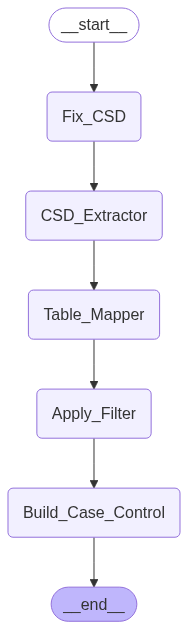

🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.
Case
Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

Control
Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

🚀 [CSD_Extractor] Output:
```json
[
  {
    "section": "Case",
    "csd_line": "Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI",
    "entities": "Lab tests for LAVI and LVMI"
  },
  {
    "section": "Control",
    "csd_line": "Patien

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Cohort builder following your final_flow:

__start__ → CSD_Extractor → Table_Mapper → Apply_Filter → Build_Case_Control → __end__

Features
- Deterministic executor for steps: fetch, filter, dedupe, anchor, window, merge, temporal_merge
- Safe SQL compilation with aliasing to avoid undeclared-table-alias bugs
- LLM prompts (can be bypassed with --no-llm and a steps JSON)
- Outputs case/control artifacts (parquet with CSV fallback)

Usage
------
LLM (end-to-end from CSD file):
  python cohort_final_flow.py --csd_file CSD.txt --db synthetic_ehr.db

No LLM (deterministic re-run with planned steps):
  python cohort_final_flow.py --steps_json my_steps.json --db synthetic_ehr.db --no-llm

Outputs
-------
  case_df.parquet (or CSV)
  control_df.parquet (or CSV)
"""

from __future__ import annotations
import argparse
import json
import re
import sqlite3
from dataclasses import dataclass
from datetime import datetime
from typing import Dict, List, Optional, Tuple
from IPython.display import display, Image
import os
import pandas as pd

# ──────────────────────────────────────────────────────────────────────────────
# Optional LLM imports are gated by a flag (so --no-llm runs fine without them)
# ──────────────────────────────────────────────────────────────────────────────
_llm_available = True
try:
    from langgraph.graph import StateGraph, END
    from langchain_openai import ChatOpenAI
    from langchain_core.prompts import ChatPromptTemplate
    from langchain_core.runnables import RunnableLambda
except Exception:
    _llm_available = False


# ──────────────────────────────────────────────────────────────────────────────
# Config
# ──────────────────────────────────────────────────────────────────────────────
DEFAULT_DB_PATH = "synthetic_ehr.db"

# ──────────────────────────────────────────────────────────────────────────────
# State definition (used only when LLM mode is on)
# ──────────────────────────────────────────────────────────────────────────────
@dataclass
class GraphState:
    csd: str = ""
    csd_fixed: str = ""
    simple_csd: List[str] = None
    mappings: List[dict] = None
    steps_case: List[dict] = None
    steps_control: List[dict] = None
    case_df_path: str = ""
    control_df_path: str = ""
    execution_error: str = ""


# ──────────────────────────────────────────────────────────────────────────────
# Helpers
# ──────────────────────────────────────────────────────────────────────────────
def _complement_op(op: str) -> str:
    op = (op or "").strip()
    return {">=": "<", ">": "<=", "<=": ">", "<": ">="}.get(op, "<")

def _metric_from_text(txt: str) -> str:
    t = (txt or "").upper()
    return "LVMI" if "LVMI" in t else "LAVI"

def _metric_threshold(metric: str) -> float:
    return 115.0 if (metric or "").upper() == "LVMI" else 34.0  # defaults to LAVI 34


def _strip_md_fences(s: str) -> str:
    s = str(s).strip()
    m = re.search(r"```(?:json|js|javascript|python)?\s*([\s\S]*?)\s*```", s, flags=re.IGNORECASE)
    return m.group(1).strip() if m else s

def _first_json_slice(s: str) -> str:
    """Return the first JSON object/array slice by bracket matching (ignores markdown)."""
    s = _strip_md_fences(s)
    # choose earliest of { or [
    i_obj = s.find("{")
    i_arr = s.find("[")
    if i_obj == -1 and i_arr == -1:
        raise ValueError("No JSON start character found")
    start = min(x for x in (i_obj, i_arr) if x != -1)

    stack, in_str, esc = [], False, False
    for i, ch in enumerate(s[start:], start=start):
        if in_str:
            if esc:
                esc = False
            elif ch == "\\":
                esc = True
            elif ch == '"':
                in_str = False
            continue
        if ch == '"':
            in_str = True
        elif ch in "{[":
            stack.append("}" if ch == "{" else "]")
        elif ch in "}]":
            if not stack or ch != stack[-1]:
                raise ValueError("Mismatched brackets while scanning JSON")
            stack.pop()
            if not stack:
                return s[start:i+1]
    # if we get here, fallback to whole tail (may still parse if complete)
    return s[start:]

def _parse_json_safely(text, default):
    try:
        payload = _first_json_slice(text)
        return json.loads(payload)
    except Exception as e:
        print("❌ JSON parse failed:", e)
        print("   Raw (clipped):", _clip(text))
        return default

def _clip(s: str, n: int = 2000) -> str:
    s = str(s)
    return s if len(s) <= n else s[:n] + " … [truncated]"

def _jdump(obj) -> str:
    try:
        return json.dumps(obj, indent=2, ensure_ascii=False)
    except Exception:
        return repr(obj)

def _safe_ident(name: str) -> str:
    if not isinstance(name, str) or not re.fullmatch(r"[A-Z_]+", name):
        raise ValueError(f"Unsafe identifier: {name}")
    return name

def _alias_map(tables: List[str]) -> Dict[str, str]:
    used, out = set(), {}
    for t in tables:
        t = _safe_ident(t)
        base = "".join(x[0] for x in t.split("_"))[:3] or "T"
        alias, idx = base, 2
        while alias in used:
            alias = f"{base}{idx}"
            idx += 1
        used.add(alias); out[t] = alias
    return out

def _read_sql(conn: sqlite3.Connection, sql: str) -> pd.DataFrame:
    # Light safety: ensure aliases if table-qualified columns appear
    bad = re.findall(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|EVENT_DTM|[A-Z_]+_DK)\b", sql)
    if bad and not re.search(r"\bAS\b", sql, flags=re.IGNORECASE):
        raise ValueError(f"Unaliased table usage detected: {sorted(set(b[0] for b in bad))}")
    return pd.read_sql_query(sql, conn)

def get_age(dob: str, event_dtm: str) -> float:
    try:
        d0 = datetime.fromisoformat(str(dob).split(" ")[0])
        d1 = datetime.fromisoformat(str(event_dtm).split(" ")[0])
        return (d1 - d0).days / 365.25
    except Exception:
        return float("nan")

def apply_within_temporal_filter(
    df_merged: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int],  # e.g., [-90, 90]
    left_inclusive: bool = True,
    right_inclusive: bool = True,
) -> pd.DataFrame:
    a = pd.to_datetime(df_merged[anchor_column], errors="coerce")
    w = pd.to_datetime(df_merged[window_column], errors="coerce")
    delta = (w - a).dt.days
    lo, hi = time_window
    mask = (delta >= lo if left_inclusive else delta > lo) & \
           (delta <= hi if right_inclusive else delta < hi)
    return df_merged[mask].copy()

# ──────────────────────────────────────────────────────────────────────────────
# Deterministic compiler for common fetches
# Extend to your full coverage as needed
# ──────────────────────────────────────────────────────────────────────────────
def compile_fetch_sql(entities: dict, limit: int = 500000) -> Tuple[str, List[str]]:
    src = _safe_ident(entities["source"])

    # FACT_DIAGNOSIS by ICD
    if src == "FACT_DIAGNOSIS" and entities.get("by") == "ICD":
        dim = _safe_ident(entities.get("dim", "DIAGNOSIS_DIM_DIAGNOSIS_CODE"))
        aliases = _alias_map([src, dim]); s, d = aliases[src], aliases[dim]
        codes = entities.get("codes", [])
        codes = entities.get("codes", [])
        safe_codes_items = [f"'{re.sub(r'[^A-Za-z0-9.]', '', str(c))}'" for c in codes]
        safe_codes = ", ".join(safe_codes_items) if safe_codes_items else "''"
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID",
            f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{d}.DIAGNOSIS_CODE AS DIAGNOSIS_CODE",
            f"{d}.DIAGNOSIS_DESCRIPTION AS DIAGNOSIS_DESCRIPTION",
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            JOIN {dim} AS {d} ON {s}.DIAGNOSIS_CODE_DK = {d}.DIAGNOSIS_CODE_DK
            WHERE {d}.DIAGNOSIS_CODE IN ({safe_codes})
            LIMIT {limit}
        """
        return _compact(sql), [c.split(" AS ")[-1] for c in select_cols]

    # FACT_ECHO_RESULTS by result_type_description  (robust LIKE match)
    if src == "FACT_ECHO_RESULTS" and entities.get("result_type_description"):
        dim = "ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE"
        aliases = _alias_map([src, dim]); s, d = aliases[src], aliases[dim]
        # allow fuzzy match like "%LAVI%" or "%LVMI%"
        desc = re.sub(r"[^A-Za-z0-9 _%-]", "", str(entities["result_type_description"])).upper()
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID",
            f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECHO_TEST_FPK AS ECHO_TEST_FPK",
            f"{s}.ECHO_RESULT_VALUE AS ECHO_RESULT_VALUE",
            f"{s}.ECHO_RESULTS_VALUE_UNIT_OF_MEASURE AS UNIT",
            f"{d}.ECHO_TEST_RESULT_DESCRIPTION AS RESULT_TYPE",
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            JOIN {dim} AS {d} ON {s}.ECHO_TEST_RESULT_TYPE_DK = {d}.ECHO_TEST_RESULT_TYPE_DK
            WHERE UPPER({d}.ECHO_TEST_RESULT_DESCRIPTION) LIKE '%{desc}%'
            LIMIT {limit}
        """
        return _compact(sql), [c.split(" AS ")[-1] for c in select_cols]


    # Generic ECHO events
    if src == "FACT_ECHO_RESULTS":
        aliases = _alias_map([src]); s = aliases[src]
        sql = f"""
            SELECT {s}.PATIENT_ID AS PATIENT_ID, {s}.EVENT_DTM AS EVENT_DTM, {s}.ECHO_TEST_FPK AS ECHO_TEST_FPK
            FROM {src} AS {s}
            LIMIT {limit}
        """
        return _compact(sql), ["PATIENT_ID", "EVENT_DTM", "ECHO_TEST_FPK"]

    # Generic ECG events
    if src == "FACT_ECG":
        aliases = _alias_map([src]); s = aliases[src]
        sql = f"""
            SELECT {s}.PATIENT_ID AS PATIENT_ID, {s}.EVENT_DTM AS EVENT_DTM, {s}.ECG_INTERPRET_FULL_TEXT AS ECG_INTERPRET_FULL_TEXT
            FROM {src} AS {s}
            LIMIT {limit}
        """
        return _compact(sql), ["PATIENT_ID", "EVENT_DTM", "ECG_INTERPRET_FULL_TEXT"]

    raise NotImplementedError(f"Fetch compiler missing for source={src} with entities={entities}")

def _compact(sql: str) -> str:
    return "\n".join(l.strip() for l in sql.splitlines() if l.strip())

# ──────────────────────────────────────────────────────────────────────────────
# Step executor
# ──────────────────────────────────────────────────────────────────────────────
def _apply_step(
    df: Optional[pd.DataFrame],
    step: dict,
    conn: sqlite3.Connection,
    anchor: dict
) -> Tuple[pd.DataFrame, dict]:

    stype = step.get("type")

    if stype == "fetch":
        sql, _ = compile_fetch_sql(step["entities"])
        fetched = _read_sql(conn, sql)
        if df is None:
            return fetched, anchor
        return pd.merge(df, fetched, on=["PATIENT_ID"], how=step.get("how", "inner")), anchor

    if stype == "filter":
        if df is None:
            return pd.DataFrame(columns=["PATIENT_ID", "EVENT_DTM"]), anchor
        rule = step.get("rule", {})
        # age filter (requires PATIENT_BIRTH_DATE column to be present)
        if "age_gte" in rule:
            if "PATIENT_BIRTH_DATE" not in df.columns:
                return df, anchor
            tmp = df.copy()
            tmp["AGE"] = tmp.apply(lambda r: get_age(r["PATIENT_BIRTH_DATE"], r["EVENT_DTM"]), axis=1)
            return tmp[tmp["AGE"] >= float(rule["age_gte"])], anchor

        # generic numeric echo value filter
        if "echo_value" in rule and "field" in rule["echo_value"]:
            f, op, val = rule["echo_value"]["field"], rule["echo_value"]["op"], rule["echo_value"]["value"]
            if f not in df.columns:
                return df, anchor
            x = pd.to_numeric(df[f], errors="coerce")
            if   op == ">":  return df[x >  float(val)], anchor
            elif op == ">=": return df[x >= float(val)], anchor
            elif op == "<":  return df[x <  float(val)], anchor
            elif op == "<=": return df[x <= float(val)], anchor
            elif op == "==": return df[x == float(val)], anchor
            else:            return df, anchor

        # substring/regex filter on text fields
        if "text_contains" in rule and "field" in rule:
            f = rule["field"]; substr = str(rule["text_contains"])
            if f in df.columns:
                return df[df[f].astype(str).str.contains(substr, case=False, na=False, regex=False)], anchor
            return df, anchor

        return df, anchor

    if stype == "dedupe":
        if df is None:
            return pd.DataFrame(), anchor
        return df.drop_duplicates(subset=step.get("keys", ["PATIENT_ID", "EVENT_DTM"]), keep="first"), anchor

    if stype == "anchor":
        # Most recent ECHO per patient (common anchor)
        try:
            sql, _ = compile_fetch_sql({"source": "FACT_ECHO_RESULTS"})
        except NotImplementedError:
            aliases = _alias_map(["FACT_ECHO_RESULTS"])
            s = aliases["FACT_ECHO_RESULTS"]
            sql = _compact(f"""
                SELECT {s}.PATIENT_ID AS PATIENT_ID, {s}.EVENT_DTM AS EVENT_DTM, {s}.ECHO_TEST_FPK AS ECHO_TEST_FPK
                FROM FACT_ECHO_RESULTS AS {s}
            """)
        echo = _read_sql(conn, sql)
        if echo.empty:
            return (df if df is not None else pd.DataFrame()), anchor
    
        # 🔧 If we already have a filtered patient set, restrict anchors to it
        if df is not None and not df.empty and "PATIENT_ID" in df.columns:
            keep = set(df["PATIENT_ID"].astype(str))
            echo = echo[echo["PATIENT_ID"].astype(str).isin(keep)]
            if echo.empty:
                return pd.DataFrame(columns=["PATIENT_ID","EVENT_DTM","ECHO_TEST_FPK"]), anchor
    
        echo = echo.sort_values(["PATIENT_ID", "EVENT_DTM"])
        anchor_rows = echo.groupby("PATIENT_ID").tail(1)
        anchor_map = anchor_rows.set_index("PATIENT_ID")["EVENT_DTM"].to_dict()
        return anchor_rows, {"EVENT_DTM": anchor_map}



    if stype == "window":
        if df is None:
            return pd.DataFrame(), anchor
        anchor_map = (anchor or {}).get("EVENT_DTM", {})
        if not anchor_map:
            return df, anchor
        anchor_df = pd.DataFrame({"PATIENT_ID": list(anchor_map.keys()),
                                  "ANCHOR_EVENT_DTM": list(anchor_map.values())})
        delta = int(step.get("delta_days", 90))
        target = (step.get("target", "ECG") or "ECG").upper()
        if target == "ECG":
            events_sql, _ = compile_fetch_sql({"source": "FACT_ECG"})
        else:
            events_sql, _ = compile_fetch_sql({"source": "FACT_ECHO_RESULTS"})
        events = _read_sql(conn, events_sql)
        if events.empty:
            return events, anchor
        events = events.merge(anchor_df, on="PATIENT_ID", how="inner")
        filtered = apply_within_temporal_filter(
            df_merged=events,
            anchor_column="ANCHOR_EVENT_DTM",
            window_column="EVENT_DTM",
            time_window=[-delta, delta],
            left_inclusive=True,
            right_inclusive=True,
        )
        return filtered, anchor

    if stype == "merge":
        side_sql, _ = compile_fetch_sql(step["side_fetch"])
        side = _read_sql(conn, side_sql)
        if df is None:
            return side, anchor
        return pd.merge(df, side, on=["PATIENT_ID"], how=step.get("how", "inner")), anchor

    if stype == "temporal_merge":
        # hook for future specialized temporal collapsing logic; current impl is pass-through
        return df, anchor

    raise NotImplementedError(f"Unknown step type: {stype}")

def normalize_steps(raw) -> List[dict]:
    STEP_TYPES = {"fetch","filter","dedupe","anchor","window","merge","temporal_merge"}
    out: List[dict] = []
    if not isinstance(raw, list):
        return out
    for st in raw:
        if not isinstance(st, dict):
            continue
        if "type" not in st and len(st) == 1:
            k = next(iter(st))
            if k in STEP_TYPES:
                payload = st[k] if isinstance(st[k], dict) else {}
                st = {"type": k, **payload}
        if st.get("type") in STEP_TYPES:
            out.append(st)
    return out

def run_pipeline(steps: List[dict], db_path: str) -> pd.DataFrame:
    conn = sqlite3.connect(db_path)
    df, anchor = None, {}
    try:
        for idx, st in enumerate(steps, 1):
            stype = st.get("type")
            print(f"\n➡️  Step {idx:02d}: {stype}\n{_jdump(st)}")
            df, anchor = _apply_step(df, st, conn, anchor)
            shape = None if df is None else df.shape
            print(f"   ✅ shape: {shape}")
            # if df is None or df.empty:
            #     print("   🔎 preview: <empty>")
            # else:
            #     try:
            #         print("   🔎 preview (top 5):")
            #         print(df.head(5).to_string(index=False))
            #     except Exception:
            #         print("   🔎 preview unavailable (non-stringifiable rows).")
        return pd.DataFrame() if df is None else df
    finally:
        conn.close()



# ──────────────────────────────────────────────────────────────────────────────
# LLM nodes + prompts (used only when --no-llm is not set)
# ──────────────────────────────────────────────────────────────────────────────

import re

def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.

    - Keeps text before 'Cohort Creation Steps' as-is
    - Removes the original 'Cohort Creation Steps' block (to avoid duplicates)
    - Rebuilds 'Case' and 'Control' sections with the generic lines prefixed
    - If markers aren't found, returns original CSD unchanged
    """
    if not isinstance(csd, str):
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip()

    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)

    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: GraphState) -> GraphState:
    raw = state.csd or ""
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(_clip(fixed))
    state.csd_fixed = fixed
    state.csd = fixed
    return state


# CSD_Extractor — turns free-text CSD into a simple list of “entity intents”
CSD_EXTRACTOR_PROMPT = """You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return ONLY JSON: a list of objects with:
- "section": which block the line belongs to (e.g., "Cohort Creation Steps", "Case", "Control")
- "csd_line": the raw CSD line (verbatim or lightly trimmed)
- "entities": a normalized, schema-aware paraphrase of what to fetch (ICD codes, labs, procedures, drugs, etc.)

Example:
[
  {{"section":"Cohort Creation Steps","csd_line":"Identify patients with disease codes for hypertension...","entities":"ICD codes for hypertension and complications"}},
  {{"section":"Case","csd_line":"Patients whose anchor ECHO has abnormal LAVI or LVMI","entities":"Lab tests for LAVI and LVMI"}},
  {{"section":"Control","csd_line":"Patients whose anchor ECHO has normal LAVI and LVMI","entities":"Lab tests for LAVI and LVMI"}}
]

CSD:
{csd}
"""



# Table_Mapper — maps each entity intent to warehouse objects & parameters
TABLE_MAPPER_PROMPT = """You are a precise schema mapper.
Given a SINGLE normalized entity plus the original CSD line and the warehouse schema,
return ONLY a JSON object describing which tables/columns/sources to use.

Output schema:
{{
  "tables": ["FACT_...","..."],
  "columns": ["..."],
  "source": "FACT_...",
  "by": "ICD" | null,
  "codes": ["I48","I48.0"] | [],
  "result_type_description": "LAVI" | null
}}

Constraints:
- Map using ONLY tables/columns present in the provided schema.
- For echo metrics (e.g., LAVI/LVMI), set source="FACT_ECHO_RESULTS" and fill result_type_description.
- For diagnosis by ICD, set source="FACT_DIAGNOSIS", by="ICD", and include codes.

Schema:
{table_schema}

Normalized entity (from extractor):
{entity}

Original CSD line (context, do NOT echo back verbatim unless helpful):
{csd_line}
"""



# Apply_Filter — plans concrete steps for case/control as an executable step list
APPLY_FILTER_PLANNER_PROMPT = """Plan executable steps to build CASE and CONTROL cohorts.

Return ONLY JSON with this structure:
{{
  "case": [ {{ "type": "...", ... }} ],
  "control": [ {{ "type": "...", ... }} ]
}}

Allowed sources (MUST use only these):
- FACT_DIAGNOSIS  (use with "by":"ICD" and "codes":[...])
- FACT_ECHO_RESULTS (use with "result_type_description":"LAVI" or "LVMI")
- FACT_ECG

Step types and fields:
- fetch:  {{ "type":"fetch", "entities":{{ "source":"FACT_DIAGNOSIS"|"FACT_ECHO_RESULTS"|"FACT_ECG", "by":"ICD"?, "codes":[...], "result_type_description":"LAVI"|"LVMI"? }}, "how":"inner"|"left" }}
- filter: {{ "type":"filter", "rule":{{ "age_gte": 18 }} }}  OR  {{ "rule":{{ "echo_value":{{"field":"ECHO_RESULT_VALUE","op":">=","value":34}} }} }}
- anchor: {{ "type":"anchor", "signal":"ECHO", "strategy":"most_recent" }}
- window: {{ "type":"window", "target":"ECG"|"ECHO", "delta_days": 90 }}
- dedupe: {{ "type":"dedupe", "keys":["PATIENT_ID","EVENT_DTM"] }}
- merge:  {{ "type":"merge", "side_fetch":{{...}} , "how":"inner" }}

Guidance:
- Typical pattern: anchor (most recent ECHO) → window (ECG within ±90d) → fetch echo metric → filter by value.
- CASE: positive condition (e.g., LAVI ≥ 34). CONTROL: complementary (e.g., LAVI < 34).
- Do NOT invent sources not listed above.

CSD:
{csd}
"""



def _require_llm():
    if not _llm_available:
        raise RuntimeError("LLM components not installed. Run with --no-llm or install langgraph/langchain_openai.")

def _make_agent(prompt_tmpl: str):
    _require_llm()
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)
    return ChatPromptTemplate.from_template(prompt_tmpl) | llm


def _state_get(st, key, default=None):
    # Works for dataclass, dict, and AddableValuesDict
    if isinstance(st, dict):
        return st.get(key, default)
    return getattr(st, key, default)

def _state_set(st, key, value):
    # Works for dataclass and dict/AddableValuesDict
    if isinstance(st, dict):
        st[key] = value
    else:
        setattr(st, key, value)
    return st


def CSD_Extractor(state: GraphState) -> GraphState:
    agent = _make_agent(CSD_EXTRACTOR_PROMPT)
    out = agent.invoke({"csd": state.csd}).content
    print("\n🚀 [CSD_Extractor] Output:\n" + _clip(out))

    parsed = _parse_json_safely(out, [])
    items = []
    if isinstance(parsed, list):
        for it in parsed:
            if isinstance(it, dict):
                items.append({
                    "section": it.get("section", ""),
                    "csd_line": it.get("csd_line", ""),
                    "entities": it.get("entities", it.get("entity", "")),
                })
            else:
                items.append({"section": "", "csd_line": "", "entities": str(it)})
    state.simple_csd = items
    return state



def Table_Mapper(state: GraphState) -> GraphState:
    mapper = _make_agent(TABLE_MAPPER_PROMPT)
    mappings: List[dict] = []

    for entry in (state.simple_csd or []):
        ent = (entry or {}).get("entities", "")
        csd_line = (entry or {}).get("csd_line", "")
        section = (entry or {}).get("section", "")

        # show the inputs you asked for
        print("\n🔖 [Table_Mapper] Context")
        print("  CSD line:     ", _clip(csd_line))
        print("  Extracted ent:", _clip(ent))

        raw = mapper.invoke({"table_schema": table_schema, "entity": ent, "csd_line": csd_line}).content
        print("\n🚀 [Table_Mapper] LLM Output (raw):\n" + _clip(raw))

        mapped = _parse_json_safely(raw, {"error": "mapper_parse_error", "raw": _clip(raw)})
        if isinstance(mapped, dict):
            mapped["_provenance"] = {"section": section, "csd_line": csd_line, "extracted": ent}
        else:
            mapped = {"error": "mapper_parse_error", "raw": _clip(raw),
                      "_provenance": {"section": section, "csd_line": csd_line, "extracted": ent}}

        # final pretty dump with both lines present
        print("\n🧾 [Table_Mapper] Final Mapping (with provenance):\n" + _jdump(mapped))

        mappings.append(mapped)

    state.mappings = mappings
    return state

    
ALLOWED_SOURCES = {"FACT_DIAGNOSIS", "FACT_ECHO_RESULTS", "FACT_ECG"}

def _sanitize_plan(plan: dict, csd_hint: str = "") -> dict:
    """
    Normalize to:
      [DX fetches ...] → anchor → window(ECG) → fetch ECHO(metric) → filter by metric
      (+ age filter if present) → dedupe
    - Choose a single metric (LVMI if mentioned, else LAVI).
    - CONTROL filter is the complement of CASE.
    """
    metric = _metric_from_text(csd_hint)          # "LVMI" if present in CSD, else "LAVI"
    thr = _metric_threshold(metric)               # 115 for LVMI, 34 for LAVI

    def _fix_fetch(st: dict) -> dict:
        ent = st.get("entities", {}) or {}
        src = str(ent.get("source", "")).upper()
        txt = json.dumps(ent).upper()
        if src not in ALLOWED_SOURCES:
            if ent.get("by") == "ICD" or "ICD" in txt or "DIAGNOSIS" in txt:
                src = "FACT_DIAGNOSIS"
            elif "ECG" in txt:
                src = "FACT_ECG"
            else:
                src = "FACT_ECHO_RESULTS"
        ent["source"] = src
        st["entities"] = ent
        return st

    def _is_echo_fetch(s: dict) -> bool:
        if not isinstance(s, dict) or s.get("type") != "fetch":
            return False
        ent = (s.get("entities") or {})
        src = str(ent.get("source", "")).upper()
        txt = json.dumps(ent).upper()
        return src == "FACT_ECHO_RESULTS" or "ECHO" in txt or "LAVI" in txt or "LVMI" in txt

    def _is_echo_filter(s: dict) -> bool:
        if not isinstance(s, dict) or s.get("type") != "filter":
            return False
        ev = (s.get("rule", {}) or {}).get("echo_value")
        return isinstance(ev, dict) and {"field","op","value"} <= set(ev.keys())

    def _is_anchor_or_window(s: dict) -> bool:
        return isinstance(s, dict) and s.get("type") in ("anchor", "window")

    def _rebuild(side: str, steps: List[dict]) -> List[dict]:
        # 1) normalize sources
        norm = [_fix_fetch(st.copy()) if isinstance(st, dict) and st.get("type") == "fetch" else st for st in (steps or [])]

        # 2) remove ALL echo fetches & echo filters; we will inject one of each
        base = [s for s in norm if not (_is_echo_fetch(s) or _is_echo_filter(s))]

        # 3) find insert position = after the last anchor/window
        insert_pos = 0
        for i, s in enumerate(base):
            if _is_anchor_or_window(s):
                insert_pos = i + 1

        # 4) canonical echo fetch + filter
        echo_fetch = {
            "type": "fetch",
            "entities": {"source": "FACT_ECHO_RESULTS", "result_type_description": metric},
            "how": "inner"
        }
        echo_filter = {
            "type": "filter",
            "rule": {"echo_value": {"field": "ECHO_RESULT_VALUE",
                                    "op": ">=" if side == "case" else "<",
                                    "value": thr}}
        }

        # 5) inject [echo_fetch, echo_filter] right after anchor/window
        base[insert_pos:insert_pos] = [echo_fetch, echo_filter]

        # 6) ensure dedupe at the end
        if not any((s.get("type") == "dedupe") for s in base if isinstance(s, dict)):
            base.append({"type": "dedupe", "keys": ["PATIENT_ID", "EVENT_DTM"]})

        return base

    fixed = {"case": _rebuild("case", plan.get("case", [])),
             "control": _rebuild("control", plan.get("control", []))}
    return fixed





def Apply_Filter(state: GraphState) -> GraphState:
    planner = _make_agent(APPLY_FILTER_PLANNER_PROMPT)
    raw = planner.invoke({"csd": state.csd}).content
    print("\n🧭 [Apply_Filter] Output:\n" + _clip(raw))

    plan = _parse_json_safely(raw, {"case": [], "control": []})
    if not isinstance(plan, dict):
        plan = {"case": [], "control": []}

    plan = _sanitize_plan(plan, csd_hint=state.csd)  # ← pass the CSD text
    state.steps_case = plan.get("case", [])
    state.steps_control = plan.get("control", [])
    return state




def _enforce_difference(case_df: pd.DataFrame, ctrl_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Remove overlaps by (PATIENT_ID, EVENT_DTM) from CONTROL first
    try:
        keys = [k for k in ("PATIENT_ID","EVENT_DTM") if k in case_df.columns and k in ctrl_df.columns]
        if keys:
            inter = pd.merge(case_df[keys].drop_duplicates(), ctrl_df[keys].drop_duplicates(),
                             on=keys, how="inner")
            if not inter.empty:
                n_overlap = len(inter)
                ctrl_df = ctrl_df.merge(inter.assign(__dup=1), on=keys, how="left")
                ctrl_df = ctrl_df[ctrl_df["__dup"].isna()].drop(columns="__dup")
                print(f"🔧 removed {n_overlap} overlapping rows from CONTROL based on {keys}")

        # If still byte-for-byte equal structure/rows, split by ECHO_RESULT_VALUE (>=thr vs <thr)
        same = False
        if set(case_df.columns) == set(ctrl_df.columns) and len(case_df) == len(ctrl_df):
            same = case_df.equals(ctrl_df)
        if same:
            print("⚠️ CASE and CONTROL still identical; applying fallback split by ECHO_RESULT_VALUE.")
            if "ECHO_RESULT_VALUE" in case_df.columns:
                vals = pd.to_numeric(case_df["ECHO_RESULT_VALUE"], errors="coerce")
                thr = _metric_threshold(_metric_from_text(""))  # default 34
                case_df = case_df[vals >= thr]
                ctrl_df = ctrl_df[vals < thr]
                print(f"   → fallback split done: CASE {case_df.shape}, CONTROL {ctrl_df.shape}")
            else:
                print("   → fallback skipped: ECHO_RESULT_VALUE not available.")
    except Exception as e:
        print("⚠️ enforce_difference failed:", e)
    return case_df, ctrl_df

def _save_replay_bundle(state: GraphState, db_path: str, out_dir: str = "replay_bundle") -> str:
    """
    Writes a deterministic, no-LLM 'replay' runner plus artifacts that reproduce the
    exact planned cohort build from this LLM run.

    Creates:
      - <out_dir>/cohort_replay_YYYYmmdd_HHMMSS.py  (self-contained Python)
      - <out_dir>/steps.json                        (the plan used)
      - <out_dir>/csd_fixed.txt                     (the normalized CSD used)
    Returns the path of the generated replay .py file.
    """
    os.makedirs(out_dir, exist_ok=True)

    plan = {
        "case": _state_get(state, "steps_case", []) or [],
        "control": _state_get(state, "steps_control", []) or [],
    }
    csd_fixed = _state_get(state, "csd_fixed", _state_get(state, "csd", "")) or ""
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    replay_name = f"cohort_replay_{ts}.py"
    replay_path = os.path.join(out_dir, replay_name)

    # Save plan + CSD for reference
    with open(os.path.join(out_dir, "steps.json"), "w", encoding="utf-8") as f:
        json.dump(plan, f, indent=2, ensure_ascii=False)
    with open(os.path.join(out_dir, "csd_fixed.txt"), "w", encoding="utf-8") as f:
        f.write(str(csd_fixed))

    # Self-contained replay runner (no LLM). PLAN is embedded inline.
    REPLAY_TEMPLATE = r'''#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Reproducible cohort build (no-LLM).
This file was generated automatically from an LLM run.

Usage:
  python {replay_name} --db path/to/synthetic_ehr.db
Outputs:
  case_df.parquet, control_df.parquet
"""
import argparse, json, sqlite3
from datetime import datetime
from typing import List, Tuple, Optional
import pandas as pd

PLAN = __PLAN_JSON__
DEFAULT_DB_PATH = "__DEFAULT_DB__"

def _safe_ident(name: str) -> str:
    import re
    if not isinstance(name, str) or not re.fullmatch(r"[A-Z_]+", name):
        raise ValueError(f"Unsafe identifier: {name}")
    return name

def _alias_map(tables: List[str]):
    used, out = set(), {}
    for t in tables:
        t = _safe_ident(t)
        base = "".join(x[0] for x in t.split("_"))[:3] or "T"
        alias, idx = base, 2
        while alias in used:
            alias = f"{base}{idx}"; idx += 1
        used.add(alias); out[t] = alias
    return out

def _compact(sql: str) -> str:
    return "\n".join(l.strip() for l in str(sql).splitlines() if l.strip())

def _read_sql(conn: sqlite3.Connection, sql: str) -> pd.DataFrame:
    import re
    bad = re.findall(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|EVENT_DTM|[A-Z_]+_DK)\b", sql)
    if bad and not re.search(r"\bAS\b", sql, flags=re.IGNORECASE):
        raise ValueError(f"Unaliased table usage detected: {sorted(set(b[0] for b in bad))}")
    return pd.read_sql_query(sql, conn)

def get_age(dob: str, event_dtm: str) -> float:
    try:
        d0 = datetime.fromisoformat(str(dob).split(" ")[0])
        d1 = datetime.fromisoformat(str(event_dtm).split(" ")[0])
        return (d1 - d0).days / 365.25
    except Exception:
        return float("nan")

def apply_within_temporal_filter(df_merged: pd.DataFrame, anchor_column: str, window_column: str,
                                 time_window: List[int], left_inclusive: bool=True, right_inclusive: bool=True) -> pd.DataFrame:
    a = pd.to_datetime(df_merged[anchor_column], errors="coerce")
    w = pd.to_datetime(df_merged[window_column], errors="coerce")
    delta = (w - a).dt.days
    lo, hi = time_window
    mask = (delta >= lo if left_inclusive else delta > lo) & (delta <= hi if right_inclusive else delta < hi)
    return df_merged[mask].copy()

def compile_fetch_sql(entities: dict, limit: int = 500000) -> Tuple[str, List[str]]:
    src = _safe_ident(entities["source"])
    if src == "FACT_DIAGNOSIS" and entities.get("by") == "ICD":
        dim = _safe_ident(entities.get("dim", "DIAGNOSIS_DIM_DIAGNOSIS_CODE"))
        aliases = _alias_map([src, dim]); s, d = aliases[src], aliases[dim]
        codes = entities.get("codes", []) or []
        safe_codes_items = [f"'{__import__('re').sub(r'[^A-Za-z0-9.]','',str(c))}'" for c in codes]
        safe_codes = ", ".join(safe_codes_items) if safe_codes_items else "''"
        select_cols = [f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM",
                       f"{d}.DIAGNOSIS_CODE AS DIAGNOSIS_CODE", f"{d}.DIAGNOSIS_DESCRIPTION AS DIAGNOSIS_DESCRIPTION"]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            JOIN {dim} AS {d} ON {s}.DIAGNOSIS_CODE_DK = {d}.DIAGNOSIS_CODE_DK
            WHERE {d}.DIAGNOSIS_CODE IN ({safe_codes})
            LIMIT {limit}
        """
        return _compact(sql), [c.split(" AS ")[-1] for c in select_cols]
    if src == "FACT_ECHO_RESULTS" and entities.get("result_type_description"):
        dim = "ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE"
        aliases = _alias_map([src, dim]); s, d = aliases[src], aliases[dim]
        desc = __import__('re').sub(r"[^A-Za-z0-9 _-]", "", entities["result_type_description"])
        select_cols = [f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM",
                       f"{s}.ECHO_RESULT_VALUE AS ECHO_RESULT_VALUE", f"{s}.ECHO_RESULTS_VALUE_UNIT_OF_MEASURE AS UNIT",
                       f"{d}.ECHO_TEST_RESULT_DESCRIPTION AS RESULT_TYPE"]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            JOIN {dim} AS {d} ON {s}.ECHO_TEST_RESULT_TYPE_DK = {d}.ECHO_TEST_RESULT_TYPE_DK
            WHERE {d}.ECHO_TEST_RESULT_DESCRIPTION = '{desc}'
            LIMIT {limit}
        """
        return _compact(sql), [c.split(" AS ")[-1] for c in select_cols]
    if src == "FACT_ECHO_RESULTS":
        aliases = _alias_map([src]); s = aliases[src]
        sql = f"""
            SELECT {s}.PATIENT_ID AS PATIENT_ID, {s}.EVENT_DTM AS EVENT_DTM, {s}.ECHO_TEST_FPK AS ECHO_TEST_FPK
            FROM {src} AS {s}
            LIMIT {limit}
        """
        return _compact(sql), ["PATIENT_ID", "EVENT_DTM", "ECHO_TEST_FPK"]
    if src == "FACT_ECG":
        aliases = _alias_map([src]); s = aliases[src]
        sql = f"""
            SELECT {s}.PATIENT_ID AS PATIENT_ID, {s}.EVENT_DTM AS EVENT_DTM, {s}.ECG_INTERPRET_FULL_TEXT AS ECG_INTERPRET_FULL_TEXT
            FROM {src} AS {s}
            LIMIT {limit}
        """
        return _compact(sql), ["PATIENT_ID", "EVENT_DTM", "ECG_INTERPRET_FULL_TEXT"]
    raise NotImplementedError(f"Fetch compiler missing for source={src} with entities={entities}")

def _apply_step(df: Optional[pd.DataFrame], step: dict, conn: sqlite3.Connection, anchor: dict) -> Tuple[pd.DataFrame, dict]:
    stype = step.get("type")
    if stype == "fetch":
        sql, _ = compile_fetch_sql(step["entities"])
        fetched = _read_sql(conn, sql)
        if df is None: return fetched, anchor
        return pd.merge(df, fetched, on=["PATIENT_ID"], how=step.get("how", "inner")), anchor
    if stype == "filter":
        if df is None: return pd.DataFrame(columns=["PATIENT_ID","EVENT_DTM"]), anchor
        rule = step.get("rule", {})
        if "age_gte" in rule:
            if "PATIENT_BIRTH_DATE" not in df.columns: return df, anchor
            tmp = df.copy()
            tmp["AGE"] = tmp.apply(lambda r: get_age(r["PATIENT_BIRTH_DATE"], r["EVENT_DTM"]), axis=1)
            return tmp[tmp["AGE"] >= float(rule["age_gte"])], anchor
        if "echo_value" in rule and "field" in rule["echo_value"]:
            f, op, val = rule["echo_value"]["field"], rule["echo_value"]["op"], rule["echo_value"]["value"]
            if f not in df.columns: return df, anchor
            x = pd.to_numeric(df[f], errors="coerce")
            if   op == ">":  return df[x >  float(val)], anchor
            elif op == ">=": return df[x >= float(val)], anchor
            elif op == "<":  return df[x <  float(val)], anchor
            elif op == "<=": return df[x <= float(val)], anchor
            elif op == "==": return df[x == float(val)], anchor
            else:            return df, anchor
        return df, anchor
    if stype == "dedupe":
        if df is None: return pd.DataFrame(), anchor
        return df.drop_duplicates(subset=step.get("keys", ["PATIENT_ID","EVENT_DTM"]), keep="first"), anchor
    if stype == "anchor":
        try:
            sql, _ = compile_fetch_sql({"source": "FACT_ECHO_RESULTS"})
        except NotImplementedError:
            aliases = _alias_map(["FACT_ECHO_RESULTS"]); s = aliases["FACT_ECHO_RESULTS"]
            sql = _compact(f"SELECT {s}.PATIENT_ID AS PATIENT_ID, {s}.EVENT_DTM AS EVENT_DTM FROM FACT_ECHO_RESULTS AS {s}")
        echo = _read_sql(conn, sql)
        if echo.empty: return df if df is not None else pd.DataFrame(), anchor
        echo = echo.sort_values(["PATIENT_ID","EVENT_DTM"])
        anchor_rows = echo.groupby("PATIENT_ID").tail(1)
        anchor_map = anchor_rows.set_index("PATIENT_ID")["EVENT_DTM"].to_dict()
        return anchor_rows, {"EVENT_DTM": anchor_map}
    if stype == "window":
        if df is None: return pd.DataFrame(), anchor
        anchor_map = (anchor or {}).get("EVENT_DTM", {})
        if not anchor_map: return df, anchor
        anchor_df = pd.DataFrame({"PATIENT_ID": list(anchor_map.keys()), "ANCHOR_EVENT_DTM": list(anchor_map.values())})
        delta = int(step.get("delta_days", 90))
        target = (step.get("target", "ECG") or "ECG").upper()
        events_sql, _ = compile_fetch_sql({"source": "FACT_ECG" if target=="ECG" else "FACT_ECHO_RESULTS"})
        events = _read_sql(conn, events_sql)
        if events.empty: return events, anchor
        events = events.merge(anchor_df, on="PATIENT_ID", how="inner")
        filtered = apply_within_temporal_filter(events, "ANCHOR_EVENT_DTM", "EVENT_DTM", [-delta, delta], True, True)
        return filtered, anchor
    if stype == "merge":
        side_sql, _ = compile_fetch_sql(step["side_fetch"])
        side = _read_sql(conn, side_sql)
        if df is None: return side, anchor
        return pd.merge(df, side, on=["PATIENT_ID"], how=step.get("how","inner")), anchor
    if stype == "temporal_merge":
        return df, anchor
    raise NotImplementedError(f"Unknown step type: {stype}")

def normalize_steps(raw) -> List[dict]:
    STEP_TYPES = {"fetch","filter","dedupe","anchor","window","merge","temporal_merge"}
    out = []
    if not isinstance(raw, list): return out
    for st in raw:
        if not isinstance(st, dict): continue
        if "type" not in st and len(st)==1:
            k = next(iter(st))
            if k in STEP_TYPES:
                payload = st[k] if isinstance(st[k], dict) else {}
                st = {"type": k, **payload}
        if st.get("type") in STEP_TYPES: out.append(st)
    return out

def _enforce_difference(case_df: pd.DataFrame, ctrl_df: pd.DataFrame):
    try:
        keys = [k for k in ("PATIENT_ID","EVENT_DTM") if k in case_df.columns and k in ctrl_df.columns]
        if keys:
            inter = pd.merge(case_df[keys].drop_duplicates(), ctrl_df[keys].drop_duplicates(), on=keys, how="inner")
            if not inter.empty:
                ctrl_df = ctrl_df.merge(inter.assign(__dup=1), on=keys, how="left")
                ctrl_df = ctrl_df[ctrl_df["__dup"].isna()].drop(columns="__dup")
        if set(case_df.columns)==set(ctrl_df.columns) and len(case_df)==len(ctrl_df) and case_df.equals(ctrl_df):
            if "ECHO_RESULT_VALUE" in case_df.columns:
                vals = pd.to_numeric(case_df["ECHO_RESULT_VALUE"], errors="coerce")
                thr = 34.0
                case_df = case_df[vals >= thr]
                ctrl_df = ctrl_df[vals < thr]
    except Exception:
        pass
    return case_df, ctrl_df

def run_pipeline(steps: List[dict], db_path: str) -> pd.DataFrame:
    conn = sqlite3.connect(db_path)
    df, anchor = None, {}
    try:
        for st in steps:
            df, anchor = _apply_step(df, st, conn, anchor)
        return pd.DataFrame() if df is None else df
    finally:
        conn.close()

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--db", default=DEFAULT_DB_PATH)
    args = ap.parse_args()
    case_steps = normalize_steps(PLAN.get("case", []))
    ctrl_steps = normalize_steps(PLAN.get("control", []))
    case_df = run_pipeline(case_steps, args.db)
    ctrl_df = run_pipeline(ctrl_steps, args.db)
    case_df, ctrl_df = _enforce_difference(case_df, ctrl_df)
    case_df.to_parquet("case_df.parquet", index=False)
    ctrl_df.to_parquet("control_df.parquet", index=False)
    print("CASE", case_df.shape, "CONTROL", ctrl_df.shape)

if __name__ == "__main__":
    main()
'''
    content = REPLAY_TEMPLATE.replace("__PLAN_JSON__", json.dumps(plan, indent=2, ensure_ascii=False)) \
                             .replace("__DEFAULT_DB__", str(db_path)) \
                             .replace("{replay_name}", replay_name)

    with open(replay_path, "w", encoding="utf-8") as f:
        f.write(content)

    print(f"\n🧰 Saved replay bundle → {os.path.abspath(out_dir)}")
    print(f"   ├─ {replay_name}")
    print( "   ├─ steps.json")
    print( "   └─ csd_fixed.txt")
    return replay_path


def Build_Case_Control(state: GraphState, db_path: str) -> GraphState:
    print("\n🏁 Running CASE pipeline")
    case_steps = normalize_steps(state.steps_case or [])
    case_df = run_pipeline(case_steps, db_path)

    print("\n🏁 Running CONTROL pipeline")
    ctrl_steps = normalize_steps(state.steps_control or [])
    ctrl_df = run_pipeline(ctrl_steps, db_path)

    # make sure they diverge
    case_df, ctrl_df = _enforce_difference(case_df, ctrl_df)

    case_path, ctrl_path = "case_df.parquet", "control_df.parquet"
    try:
        case_df.to_parquet(case_path, index=False)
        ctrl_df.to_parquet(ctrl_path, index=False)
    except Exception:
        case_path, ctrl_path = "case_df.csv", "control_df.csv"
        case_df.to_csv(case_path, index=False)
        ctrl_df.to_csv(ctrl_path, index=False)

    print("\n📦 Final artifacts")
    print(f"   CASE:    {case_df.shape if isinstance(case_df, pd.DataFrame) else None}  → {case_path}")
    if isinstance(case_df, pd.DataFrame) and not case_df.empty:
        print(case_df.head(5).to_string(index=False))
    print(f"   CONTROL: {ctrl_df.shape if isinstance(ctrl_df, pd.DataFrame) else None}  → {ctrl_path}")
    if isinstance(ctrl_df, pd.DataFrame) and not ctrl_df.empty:
        print(ctrl_df.head(5).to_string(index=False))

    _state_set(state, "case_df_path", case_path)
    _state_set(state, "control_df_path", ctrl_path)
    return state





# ──────────────────────────────────────────────────────────────────────────────
# Orchestration
# ──────────────────────────────────────────────────────────────────────────────
def run_with_llm(csd_text: str, db_path: str):
    _require_llm()

    builder = StateGraph(GraphState)
    builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
    builder.add_node("CSD_Extractor", RunnableLambda(CSD_Extractor))
    builder.add_node("Table_Mapper", RunnableLambda(Table_Mapper))
    builder.add_node("Apply_Filter", RunnableLambda(Apply_Filter))
    builder.add_node("Build_Case_Control", RunnableLambda(lambda st: Build_Case_Control(st, db_path)))

    builder.set_entry_point("Fix_CSD")
    builder.add_edge("Fix_CSD", "CSD_Extractor")
    builder.add_edge("CSD_Extractor", "Table_Mapper")
    builder.add_edge("Table_Mapper", "Apply_Filter")
    builder.add_edge("Apply_Filter", "Build_Case_Control")
    builder.add_edge("Build_Case_Control", END)

    # 🔎 Compile and visualize
    graph = builder.compile()
    if display is not None:
        try:
            gg = graph.get_graph()
            png = gg.draw_mermaid_png() if hasattr(gg, "draw_mermaid_png") else (
                  gg.draw_png() if hasattr(gg, "draw_png") else None)
            if png:
                display(Image(png))
            else:
                print("⚠️ This langgraph version cannot render a PNG.")
        except Exception as e:
            print("⚠️ Could not render graph:", e)

    # ▶️ Run
    state = GraphState(csd=csd_text)
    final_state = graph.invoke(state)
    # ⤵️ emit a deterministic replay script + plan
    _replay_file = _save_replay_bundle(final_state, db_path, out_dir="replay_bundle")
    print(f"\n▶️  To rerun later without LLM:\n    python {_replay_file} --db {db_path}")


    print("\nArtifacts:")
    print("  CASE   ->", _state_get(final_state, "case_df_path"))
    print("  CONTROL->", _state_get(final_state, "control_df_path"))





# ──────────────────────────────────────────────────────────────────────────────
# CLI
# ──────────────────────────────────────────────────────────────────────────────
def main(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument("--db", default=DEFAULT_DB_PATH, help="Path to SQLite DB (default: synthetic_ehr.db)")
    ap.add_argument("--csd_file", required=True, help="Path to a text file containing the CSD (LLM mode only)")
    ap.add_argument("--outdir", default="replay_bundle", help="Where to save the generated replay script and plan")
    # In notebooks, IPython injects -f <kernel.json>; ignore unknowns
    if argv is None:
        args, _unknown = ap.parse_known_args()
    else:
        args = ap.parse_args(argv)

    with open(args.csd_file, "r", encoding="utf-8") as f:
        csd_text = f.read().strip()
    run_with_llm(csd_text, args.db)



if __name__ == "__main__":
    main(["--db", "synthetic_ehr.db", "--csd_file", "csd.txt"])


In [10]:
import pandas as pd

def df_equal_parquet(a, b):
    A = pd.read_parquet(a)
    B = pd.read_parquet(b)
    # align column order and types if needed
    A = A.reindex(sorted(A.columns), axis=1)
    B = B.reindex(sorted(B.columns), axis=1)
    # sort to ignore row order
    A = A.sort_values(list(A.columns)).reset_index(drop=True)
    B = B.sort_values(list(B.columns)).reset_index(drop=True)
    return A.equals(B)   # treats NaNs in the same position as equal

print("same data (pandas):", df_equal_parquet("case_df.parquet", "control_df.parquet"))


same data (pandas): True


### Agentic AI for Cohort Creation. Line by Line Extraction & Filtering ( Like humans)

In [15]:
from typing import TypedDict, List, Tuple, Dict, Optional
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda 
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image, Markdown
import json
import re
import sqlite3
import pandas as pd


class GraphState(TypedDict):
    csd: str                  #raw multi-line CSD text
    csd_fixed: str           #raw multi-line CSD text append initial lines to case and control
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path

    # NEW for case/control
    steps_case: List[dict]
    steps_control: List[dict]
    case_df_path: str
    control_df_path: str
    fetch_steps: List[dict]


# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

def _fix_csd_text(csd: str) -> str:
    """
    Move the generic statements (between 'Cohort Creation Steps' and 'Case')
    in front of BOTH the Case and Control sections.

    - Keeps text before 'Cohort Creation Steps' as-is
    - Removes the original 'Cohort Creation Steps' block (to avoid duplicates)
    - Rebuilds 'Case' and 'Control' sections with the generic lines prefixed
    - If markers aren't found, returns original CSD unchanged
    """
    if not isinstance(csd, str):
        return csd

    text = csd.replace("\r\n", "\n").replace("\r", "\n").strip()

    cohort_re  = re.compile(r'^\s*Cohort\s*Creation\s*Steps\s*:?\s*$', re.IGNORECASE | re.MULTILINE)
    case_re    = re.compile(r'^\s*Case\s*:?\s*$',                     re.IGNORECASE | re.MULTILINE)
    control_re = re.compile(r'^\s*Control\s*:?\s*$',                  re.IGNORECASE | re.MULTILINE)

    m_cohort = cohort_re.search(text)
    m_case   = case_re.search(text)
    m_ctrl   = control_re.search(text)

    # Need at least Case and Control markers to safely restructure
    if not (m_case and m_ctrl):
        return text

    # Prefix = everything before 'Cohort Creation Steps' (if present), else before 'Case'
    prefix = text[:m_case.start()].rstrip()
    generic = ""

    if m_cohort and m_cohort.end() <= m_case.start():
        prefix  = text[:m_cohort.start()].rstrip()
        generic = text[m_cohort.end(): m_case.start()].strip()

    # Bodies (strip heading lines)
    case_body = text[m_case.end(): m_ctrl.start()].strip()
    ctrl_body = text[m_ctrl.end():].strip()

    # Rebuild sections with generic lines prefixed
    section_case = "Case\n"    + (generic + "\n" if generic else "") + case_body
    section_ctrl = "Control\n" + (generic + "\n" if generic else "") + ctrl_body

    rebuilt = "\n\n".join([t for t in [prefix.strip(), section_case.strip(), section_ctrl.strip()] if t])
    return rebuilt.strip()


def fix_csd_agent(state: dict) -> dict:
    raw = state.get("csd", "")  # dict access, not attribute
    fixed = _fix_csd_text(raw)
    if fixed != raw:
        print("🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.")
    else:
        print("ℹ️ [Fix_CSD] No structural changes made to CSD.")
    print(fixed)
    state["csd_fixed"] = fixed
    state["csd"] = fixed
    return state


    
# ---- Update CSD  ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state

# ---- Simplify CSD for Extraction ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]})
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    try:
        items = [entry["entities"] for entry in json.loads(result.content)]
        # keep order but remove duplicates (Case & Control are identical here)
        state["simple_csd"] = list(dict.fromkeys(items))
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state


# RECOGNIZED_SOURCES = {"FACT_DIAGNOSIS", "FACT_ECG", "FACT_ECHO_RESULTS"}

fetch_steps_planner_prompt = """
You are designing the MINIMAL set of fetch steps from the Table_Mapper results.
Input is a list of objects with shape: {{ "csd": "...", "tables": [...], "columns": [...] }}.

Rules:
- Use ONLY tables present in the provided mappings (do NOT invent tables).
- Each step MUST be of the form: {{ "type":"fetch", "entities":{{...}} }}.
- The "entities.source" must be one of these sources ONLY: FACT_DIAGNOSIS, FACT_ECG, FACT_ECHO_RESULTS.
- If DIAGNOSIS_DIM_DIAGNOSIS_CODE appears in mappings together with FACT_DIAGNOSIS, set:
  {{ "source":"FACT_DIAGNOSIS","by":"ICD","dim":"DIAGNOSIS_DIM_DIAGNOSIS_CODE","codes":[] }}
  (Leave "codes" empty if codes are not provided by mappings; we'll fill later.)
- If ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE appears, you may include a FACT_ECHO_RESULTS step.
- Emit a DEDUPED list under key "fetch_steps".

Return ONLY valid JSON like:
{{ "fetch_steps": [ {{ "type":"fetch", "entities":{{ "source":"FACT_ECG" }} }} ] }}
"""


RECOGNIZED_SOURCES = {"FACT_DIAGNOSIS", "FACT_ECG", "FACT_ECHO_RESULTS"}

def _tables_from_mappings(mappings: List[dict]) -> set:
    t = set()
    for m in mappings or []:
        for tbl in m.get("tables", []):
            if isinstance(tbl, str):
                t.add(tbl.strip().upper())
    return t

def _dedupe_steps(steps: List[dict]) -> List[dict]:
    out, seen = [], set()
    for st in steps or []:
        if not isinstance(st, dict) or st.get("type") != "fetch":
            continue
        ent = st.get("entities") or {}
        ent["source"] = str(ent.get("source","")).upper()
        key = json.dumps({"type":"fetch","entities":ent}, sort_keys=True)
        if key not in seen:
            seen.add(key); out.append({"type":"fetch","entities":ent})
    return out

def _fallback_fetch_steps(allowed_tables: set) -> List[dict]:
    steps = []
    # If we saw the diagnosis dim, include a FACT_DIAGNOSIS fetch (we can compile this).
    if "DIAGNOSIS_DIM_DIAGNOSIS_CODE" in allowed_tables:
        steps.append({
            "type":"fetch",
            "entities":{"source":"FACT_DIAGNOSIS","by":"ICD","dim":"DIAGNOSIS_DIM_DIAGNOSIS_CODE","codes":[]}
        })
    # If procedures are present, it hints at ECG/ECHO activity → include generic ECG/ECHO fetches.
    if "PROCEDURES_DIM_PROCEDURE_CODE" in allowed_tables:
        steps.append({"type":"fetch","entities":{"source":"FACT_ECG"}})
        steps.append({"type":"fetch","entities":{"source":"FACT_ECHO_RESULTS"}})
    # If echo result type dim is present, include ECHO_RESULTS explicitly.
    if "ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE" in allowed_tables:
        steps.append({"type":"fetch","entities":{"source":"FACT_ECHO_RESULTS"}})
    # Ensure at least one fetch step so downstream can run
    if not steps:
        steps.append({"type":"fetch","entities":{"source":"FACT_ECG"}})
    return _dedupe_steps([s for s in steps if s["entities"]["source"] in RECOGNIZED_SOURCES])

def build_fetch_steps(state: dict) -> dict:
    mappings = state.get("mappings", [])
    allowed = _tables_from_mappings(mappings)

    # Try the agent first
    agent = make_agent(fetch_steps_planner_prompt)
    try:
        res = agent.invoke({"mappings": json.dumps(mappings)})
        agent_steps = json.loads(res.content).get("fetch_steps", [])
    except Exception:
        agent_steps = []

    # Keep only recognized sources and only when compatible with allowed tables
    kept = []
    for st in agent_steps:
        if not isinstance(st, dict) or st.get("type") != "fetch":
            continue
        ent = st.get("entities") or {}
        src = str(ent.get("source","")).upper()
        dim = str(ent.get("dim","")).upper()
        if src not in RECOGNIZED_SOURCES:
            continue
        if src == "FACT_DIAGNOSIS" and dim and dim not in allowed:
            continue
        kept.append({"type":"fetch","entities":{**ent, "source":src}})

    kept = _dedupe_steps(kept)

    # Fallback if the agent produced nothing usable (common when mappings only have dims)
    if not kept:
        kept = _fallback_fetch_steps(allowed)

    state["fetch_steps"] = kept
    print("📦 [Build_Fetch_Steps] →", json.dumps(kept, indent=2))
    return state

   

csd_filter_planner_prompt = """
You will produce CASE and CONTROL step lists.
You MUST start each list with the EXACT fetch_steps provided.
Then you MAY append only non-fetch steps: "filter", "dedupe", "anchor", "window", "exclude", "merge", "temporal_merge".

Hard rules:
- Do NOT invent any new fetch steps or sources.
- Refer only to columns that exist in the union of the provided mapped columns.
- Keep steps schema-aware (use PATIENT_ID/EVENT_DTM, etc.).
- Prefer generic anchors/windows around ECHO/ECG when needed.

Return ONLY valid JSON:
{{ "case":[...], "control":[...] }}

Context CSD (for business logic, not for tables):
{csd}

Allowed columns (union across mappings):
{allowed_columns}

Fixed fetch_steps (must be the first steps in both lists, unchanged):
{fetch_steps}
"""



def _parse_rule_from_line(line: str) -> dict:
    """Best-effort parser that turns plain English into a rule dict."""
    if not isinstance(line, str):
        return {}
    s = line.lower().strip()

    # age ≥ N
    m = re.search(r'age[^0-9]*(>=|≥|at least|min(?:imum)?)\s*([0-9]+)', s)
    if m:
        return {"age_gte": int(m.group(2))}

    # LAVI/LVMI numeric thresholds (very rough)
    m = re.search(r'\b(lavi|lvmi)\b[^0-9]*(>=|>|<=|<|=)\s*([0-9]+(?:\.[0-9]+)?)', s)
    if m:
        op = m.group(2)
        if op == "=": op = "=="
        return {"echo_value": {"field": m.group(1).upper(), "op": op, "value": float(m.group(3))}}

    return {}

def _sanitize_non_fetch_steps(steps: List[dict]) -> List[dict]:
    out = []
    for st in steps or []:
        if not isinstance(st, dict):
            continue
        t = st.get("type")
        if t == "filter":
            rule = st.get("rule")
            if not isinstance(rule, dict) or not rule:
                st["rule"] = _parse_rule_from_line(st.get("line", "")) or {}
        out.append(st)
    return out


def _columns_from_mappings(mappings: List[dict]) -> List[str]:
    cols = set()
    for m in mappings or []:
        for c in m.get("columns", []):
            if isinstance(c, str):
                cols.add(c.strip().upper())
    # Always make sure key columns are available to express steps
    cols.update({"PATIENT_ID", "EVENT_DTM"})
    return sorted(cols)

def plan_steps(state):
    fetch_steps = state.get("fetch_steps", [])
    if not fetch_steps:
        print("⚠️ No fetch_steps present. Did Build_Fetch_Steps run?")
        state["steps_case"], state["steps_control"] = [], []
        return state

    allowed_cols = _columns_from_mappings(state.get("mappings", []))
    agent = make_agent(csd_filter_planner_prompt)
    res = agent.invoke({
        "csd": state.get("csd",""),
        "allowed_columns": ", ".join(allowed_cols),
        "fetch_steps": json.dumps(fetch_steps, indent=2)
    })

    print("\n🧭 [Plan_Steps] Output:\n", res.content)
    try:
        planned = json.loads(res.content)
        case_extra    = [s for s in planned.get("case", [])    if isinstance(s, dict) and s.get("type") != "fetch"]
        control_extra = [s for s in planned.get("control", []) if isinstance(s, dict) and s.get("type") != "fetch"]
    except json.JSONDecodeError:
        case_extra, control_extra = [], []

    # 🔧 sanitize non-fetch steps so they always have the expected shape
    case_extra    = _sanitize_non_fetch_steps(case_extra)
    control_extra = _sanitize_non_fetch_steps(control_extra)

    state["steps_case"]    = list(fetch_steps) + case_extra
    state["steps_control"] = list(fetch_steps) + control_extra

    print("✅ [Plan_Steps] CASE:", json.dumps(state["steps_case"], indent=2))
    print("✅ [Plan_Steps] CTRL:", json.dumps(state["steps_control"], indent=2))
    return state




# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = /"/"/"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE
/"/"/"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

    

# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "")
    if "# Error:" not in raw_code or "cohort_df = pd.read_sql_query" in raw_code:
        return state


    agent = make_agent(code_fixer_prompt)
    result = agent.invoke({
        "code": raw_code,
        "table_schema": table_schema
    })
    print("\n🛠️ [Code_Fixer] Corrected Code:\n", result.content)
    state["table_fetch_code"] = result.content
    return state





# ---- Execution Agent ----
def clean_code_block(code: str) -> str:
    import re

    # Remove markdown code fences if present
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE)
    code = code.replace("```", "")

    lines = code.strip().splitlines()
    cleaned_lines = []
    found_start = False
    sql_block_open = False

    for i, line in enumerate(lines):
        # Start copying after we hit import/sql/conn
        if not found_start and (line.strip().startswith("import") or line.strip().startswith("conn") or line.strip().startswith("sql_query")):
            found_start = True
        if found_start:
            cleaned_lines.append(line)

        # Track if we are inside the SQL string
        if 'sql_query' in line and '"""' in line:
            sql_block_open = True
        elif sql_block_open and line.strip() == '"""':
            sql_block_open = False
            # Append LIMIT if not present
            if not any("LIMIT" in l.upper() for l in cleaned_lines[-5:]):
                cleaned_lines.insert(len(cleaned_lines) - 1, "LIMIT 1000")

    # Deduplicate trailing execution lines
    seen_exec = set()
    final_lines = []
    for line in cleaned_lines:
        if line.strip() in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if line.strip() in seen_exec:
                continue
            seen_exec.add(line.strip())
        final_lines.append(line)

    # Ensure execution lines exist
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        final_lines.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        final_lines.append("conn.close()")

    code = "\n".join(final_lines).strip()

    # Replace ambiguous DataFrame truth checks (the main fix)
    code = re.sub(
        r"\bif\s*\(?\s*cohort_df\s*\)?\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )

    # Also cover cases with spacing or multiline if statements
    code = re.sub(
        r"\bif\s*\(?\s*cohort_df\s*==\s*True\s*\)?\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )

    # Catch misuse like: `if cohort_df != None:`
    code = re.sub(
        r"\bif\s+cohort_df\s*(!=|==)\s*None\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )
    # At the end of clean_code_block()
    code = "\n".join([line.rstrip() for line in code.splitlines() if line.strip() != ""]).strip()

    return code



def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))

    

def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)

    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    # --- Show numbered code for debugging ---
    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        # repr(line) → shows the Python representation of the string, including quotes and escapes. That means tabs, trailing spaces, and weird characters are visible
        # format the number right-aligned in a field at least 2 characters wide.
        print(f"{i:>2}: {repr(line)}") 
    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {
            "sqlite3": sqlite3,
            "pd": pd,
        }

        # Setup connection
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        # Try executing the code
        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            # ✅ Set error for routing logic
            state["execution_error"] = str(e)
            return state  # 🛑 exit here after catching exec failure

        # Extract resulting DataFrame
        df = local_vars.get("cohort_df")
        if df is None:
            df = global_context.get("cohort_df")

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if df is not None and not df.empty:
                print("✅ DataFrame has data.")
            elif df is not None and df.empty:
                print("⚠️ Warning: cohort_df is empty.")
            else:
                print("⚠️ DataFrame may not have executed properly.")
                
            state["table_fetch_code"] = code
            state["execution_error"] = ""  # ✅ Clear the error — this signals success
        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"

        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        # ✅ Store error separately — again
        state["execution_error"] = str(e)


    return state


def validate_and_dedupe_mappings(state: dict) -> dict:
    raw = state.get("mappings", [])
    good, seen = [], set()
    for m in raw:
        if not isinstance(m, dict):
            continue
        tables  = [t.strip().upper() for t in m.get("tables", []) if isinstance(t, str)]
        columns = [c.strip().upper() for c in m.get("columns", []) if isinstance(c, str)]
        if not tables and not columns:
            continue
        key = json.dumps({"tables":sorted(tables), "columns":sorted(columns)}, sort_keys=True)
        if key in seen:
            continue  # <-- de-dup identical entries (Case vs Control)
        seen.add(key)
        good.append({"csd": m.get("csd",""), "tables":tables, "columns":columns})
    state["mappings"] = good
    state["next_step"] = None  # keep graph happy
    state["retry_count"] = 0
    print("✅ [Validate_Mappings] kept:", json.dumps(good, indent=2))
    return state
  
    

# ===== Case/Control deterministic executor =====

ALLOWED_TABLES = {
    "DIM_PATIENT", "DIAGNOSIS_DIM_DIAGNOSIS_CODE", "PROCEDURES_DIM_PROCEDURE_CODE",
    "LAB_SPECIMEN_DIM_LAB_TEST", "MAR_DIM_MED_NAME", "DIM_FLOWSHEET_NAME",
    "ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE", "FACT_DIAGNOSIS", "FACT_PROCEDURES",
    "FACT_LAB_TEST", "FACT_MEDICATIONS", "FACT_FLOWSHEETS", "FACT_ECG", "FACT_ECHO_TEST",
    "FACT_ECHOCARDIOGRAM", "FACT_ECHO_RESULTS", "FACT_RADIOLOGY", "FACT_PATHOLOGY",
    "FACT_ENCOUNTERS", "FACT_ORDERS", "FACT_CLINICAL_DOCUMENTS", "FACT_MEDS_ADMINISTERED"
}

def _safe_ident(name: str) -> str:
    if not re.fullmatch(r"[A-Z_]+", name):
        raise ValueError(f"Unsafe identifier: {name}")
    return name

def _alias_map(tables: List[str]) -> dict:
    aliases, used = {}, set()
    for t in tables:
        t = _safe_ident(t)
        base = "".join([w[0] for w in t.split("_")])[:3] or "T"
        a, i = base, 2
        while a in used:
            a = f"{base}{i}"; i += 1
        aliases[t] = a; used.add(a)
    return aliases

def _detect_unaliased(sql: str):
    pat = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|EVENT_DTM|[A-Z_]+_DK)\b")
    declared = set(re.findall(r"(?:FROM|JOIN)\s+(\w+)\s+AS\s+(\w+)", sql, re.IGNORECASE))
    declared_tables = {t for t, _ in declared}
    bad = []
    for full, _ in pat.findall(sql):
        if full not in declared_tables:
            bad.append(full)
    if bad:
        raise ValueError(f"Unaliased table usage: {sorted(set(bad))}")

def _read_sql(conn, sql: str) -> pd.DataFrame:
    _detect_unaliased(sql)
    return pd.read_sql_query(sql, conn)


def _compact(sql: str) -> str:
    """Minify a SQL string for cleaner debugging."""
    return "\n".join(line.strip() for line in str(sql).splitlines() if line.strip())


    
def _compile_fetch_sql(entities: dict, limit: int = 500_000) -> Tuple[str, List[str]]:
    """
    Deterministic SQL compiler for common sources.
    All optional fields are safely defaulted so we never hit NameError.
    Returns: (sql, selected_column_names)
    """
    if not isinstance(entities, dict):
        raise ValueError("compile_fetch_sql: 'entities' must be a dict")

    # --- source (required) ---
    src_raw = str(entities.get("source", "")).strip()
    if not src_raw:
        raise ValueError("compile_fetch_sql: 'source' not provided in entities")
    src = _safe_ident(src_raw.upper())

    # =======================
    # FACT_DIAGNOSIS by ICD
    # =======================
    if src == "FACT_DIAGNOSIS" and str(entities.get("by", "")).upper() == "ICD":
        dim = _safe_ident(str(entities.get("dim", "DIAGNOSIS_DIM_DIAGNOSIS_CODE")).upper())

        aliases = _alias_map([src, dim])
        s, d = aliases[src], aliases[dim]

        # Safely get code list
        codes_val = entities.get("codes", [])
        codes = codes_val if isinstance(codes_val, list) else []
        # Sanitize each code (letters, digits, dot)
        safe_codes_items = [f"'{re.sub(r'[^A-Za-z0-9.]', '', str(c))}'" for c in codes]
        safe_codes = ", ".join(safe_codes_items) if safe_codes_items else "''"

        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID",
            f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{d}.DIAGNOSIS_CODE AS DIAGNOSIS_CODE",
            f"{d}.DIAGNOSIS_DESCRIPTION AS DIAGNOSIS_DESCRIPTION",
        ]

        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            JOIN {dim} AS {d}
                ON {s}.DIAGNOSIS_CODE_DK = {d}.DIAGNOSIS_CODE_DK
            WHERE {d}.DIAGNOSIS_CODE IN ({safe_codes})
            LIMIT {int(limit)}
        """
        return _compact(sql), [c.split(" AS ")[-1] for c in select_cols]

    # ==========================================
    # FACT_ECHO_RESULTS by result type (e.g. LAVI)
    # ==========================================
    if src == "FACT_ECHO_RESULTS" and entities.get("result_type_description"):
        dim = "ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE"
        dim = _safe_ident(dim)

        aliases = _alias_map([src, dim])
        s, d = aliases[src], aliases[dim]

        desc_raw = entities.get("result_type_description")
        desc = re.sub(r"[^A-Za-z0-9 _-]", "", str(desc_raw)) if desc_raw is not None else ""

        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID",
            f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECHO_RESULT_VALUE AS ECHO_RESULT_VALUE",
            f"{s}.ECHO_RESULTS_VALUE_UNIT_OF_MEASURE AS UNIT",
            f"{d}.ECHO_TEST_RESULT_DESCRIPTION AS RESULT_TYPE",
        ]

        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            JOIN {dim} AS {d}
                ON {s}.ECHO_TEST_RESULT_TYPE_DK = {d}.ECHO_TEST_RESULT_TYPE_DK
            WHERE {d}.ECHO_TEST_RESULT_DESCRIPTION = '{desc}'
            LIMIT {int(limit)}
        """
        return _compact(sql), [c.split(" AS ")[-1] for c in select_cols]

    # ==========================
    # FACT_ECHO_RESULTS (generic)
    # ==========================
    if src == "FACT_ECHO_RESULTS":
        aliases = _alias_map([src])
        s = aliases[src]
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID",
            f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECHO_TEST_FPK AS ECHO_TEST_FPK",
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            LIMIT {int(limit)}
        """
        return _compact(sql), [c.split(" AS ")[-1] for c in select_cols]

    # ==================
    # FACT_ECG (generic)
    # ==================
    if src == "FACT_ECG":
        aliases = _alias_map([src])
        s = aliases[src]
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID",
            f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECG_INTERPRET_FULL_TEXT AS ECG_INTERPRET_FULL_TEXT",
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            LIMIT {int(limit)}
        """
        return _compact(sql), [c.split(" AS ")[-1] for c in select_cols]

    # If you have more sources, add them here with the same pattern:
    # - Guard every optional value (use .get with defaults)
    # - Sanitize strings before interpolating
    # - Always define variables (no bare names)

    raise NotImplementedError(f"Fetch compiler missing for source={src}")


def _apply_step(df: Optional[pd.DataFrame],
                step: dict,
                conn,
                table_schema: str,
                anchor: dict) -> Tuple[pd.DataFrame, dict]:
    stype = step.get("type")
    if not stype:
        raise ValueError(f"Step missing 'type': {step}")

    if stype == "fetch":
        sql, _ = _compile_fetch_sql(step["entities"])
        fetched = _read_sql(conn, sql)
        if df is None:
            return fetched, anchor
        how = step.get("how","inner")
        return pd.merge(df, fetched, on=["PATIENT_ID"], how=how), anchor

    if stype == "filter":
        if df is None:
            return pd.DataFrame(columns=["PATIENT_ID","EVENT_DTM"]), anchor
    
        # be robust to missing or non-dict "rule"
        rule = step.get("rule")
        if not isinstance(rule, dict) or not rule:
            # fallback: try to parse from free text "line"
            rule = _parse_rule_from_line(step.get("line", "")) or {}
            if not rule:
                print("ℹ️ [filter] No usable rule found; skipping this filter step.")
                return df, anchor
    
        if "age_gte" in rule:
            if "PATIENT_BIRTH_DATE" not in df.columns:
                # You may want to join DIM_PATIENT earlier; for now we can't filter by age
                print("ℹ️ [filter] PATIENT_BIRTH_DATE not present; skipping age filter.")
                return df, anchor
            tmp = df.copy()
            tmp["AGE"] = tmp.apply(lambda r: get_age(r["PATIENT_BIRTH_DATE"], r["EVENT_DTM"]), axis=1)
            return tmp[tmp["AGE"] >= int(rule["age_gte"])], anchor
    
        ev = rule.get("echo_value")
        if isinstance(ev, dict) and "field" in ev and "op" in ev and "value" in ev:
            f, op, val = ev["field"], ev["op"], ev["value"]
            if f not in df.columns:
                print(f"ℹ️ [filter] Field {f} not in df; skipping echo_value filter.")
                return df, anchor
            x = pd.to_numeric(df[f], errors="coerce")
            if op == ">":   return df[x >  float(val)], anchor
            if op == ">=":  return df[x >= float(val)], anchor
            if op == "<":   return df[x <  float(val)], anchor
            if op == "<=":  return df[x <= float(val)], anchor
            if op == "==":  return df[x == float(val)], anchor
            print(f"ℹ️ [filter] Unsupported op {op}; skipping.")
            return df, anchor
    
        # nothing matched → no-op
        return df, anchor


    if stype == "dedupe":
        if df is None: return pd.DataFrame(), anchor
        return df.drop_duplicates(subset=step.get("keys", ["PATIENT_ID","EVENT_DTM"]), keep="first"), anchor

    if stype == "anchor":
        try:
            sql, _ = _compile_fetch_sql({"source": "FACT_ECHO_RESULTS"})
        except NotImplementedError:
            a = _alias_map(["FACT_ECHO_RESULTS"])["FACT_ECHO_RESULTS"]
            sql = f"SELECT {a}.PATIENT_ID AS PATIENT_ID, {a}.EVENT_DTM AS EVENT_DTM FROM FACT_ECHO_RESULTS AS {a} LIMIT 500000"
    
        echo = _read_sql(conn, sql)
        if echo.empty:
            return (df if df is not None else pd.DataFrame()), anchor
    
        echo = echo.sort_values(["PATIENT_ID", "EVENT_DTM"])
        anchor_rows = echo.groupby("PATIENT_ID").tail(1).rename(columns={"EVENT_DTM":"ANCHOR_EVENT_DTM"})[
            ["PATIENT_ID","ANCHOR_EVENT_DTM"]
        ]
        anchor_map = dict(anchor_rows.values)
    
        if df is None or df.empty:
            return anchor_rows, {"EVENT_DTM": anchor_map}
    
        out = df.copy()
        out["ANCHOR_EVENT_DTM"] = out["PATIENT_ID"].map(anchor_map)
        out = out[~out["ANCHOR_EVENT_DTM"].isna()]
        return out, {"EVENT_DTM": anchor_map}



    if stype == "window":
        if df is None:
            return pd.DataFrame(), anchor
        anchor_map = (anchor or {}).get("EVENT_DTM", {})
        if not anchor_map:
            print("⚠️ Window step skipped: no anchor map present.")
            return df, anchor
    
        anchor_df = pd.DataFrame({"PATIENT_ID": list(anchor_map.keys()),
                                  "ANCHOR_EVENT_DTM": list(anchor_map.values())})
        delta = int(step.get("delta_days", 90))
        target = (step.get("target", "ECG") or "ECG").upper()
    
        events_sql, _ = _compile_fetch_sql({"source": "FACT_ECG" if target == "ECG" else "FACT_ECHO_RESULTS"})
        events = _read_sql(conn, events_sql)
        if events.empty:
            return events, anchor
    
        events = events.merge(anchor_df, on="PATIENT_ID", how="inner")
    
        # minimal temporal filter
        a = pd.to_datetime(events["ANCHOR_EVENT_DTM"], errors="coerce")
        w = pd.to_datetime(events["EVENT_DTM"], errors="coerce")
        delta_days = (w - a).dt.days
        filtered = events[(delta_days >= -delta) & (delta_days <= delta)].copy()
    
        # keep earlier columns (e.g., ECHO_RESULT_VALUE)
        filtered = filtered.merge(df.drop(columns=[c for c in df.columns if c in filtered.columns and c != "PATIENT_ID"]),
                                  on="PATIENT_ID", how="inner")
        return filtered, anchor



    if stype == "exclude":
        if df is None: return pd.DataFrame(), anchor
        flag = step.get("flag_col","EXCLUDE_FLAG")
        if flag in df.columns:
            return df[df[flag] != True], anchor
        return df, anchor

    if stype == "merge":
        side_sql, _ = _compile_fetch_sql(step["side_fetch"])
        side = _read_sql(conn, side_sql)
        if df is None: return side, anchor
        return pd.merge(df, side, on=["PATIENT_ID"], how=step.get("how","inner")), anchor

    if stype == "temporal_merge":
        if df is None: return pd.DataFrame(), anchor
        mode = step.get("mode","within")
        window = int(step.get("window_days", 1))
        if mode == "within":
            return perform_within_temporal_merge(df, window_days=window), anchor
        else:
            return perform_outside_temporal_merge(df, window_days=window), anchor

    raise NotImplementedError(f"Unknown step type: {stype}")

def run_pipeline(steps: List[dict], table_schema: str, limit_dev: int = 5000) -> pd.DataFrame:
    conn = sqlite3.connect("synthetic_ehr.db")
    df, anchor = None, {}
    try:
        for i, step in enumerate(steps, 1):
            stype = step.get("type", "<missing>")
            line  = step.get("line", "")
            print(f"\n➡️  Step {i}: {stype} — {line}")
            if stype == "<missing>":
                print(f"   ⚠️ Skipping step without 'type': {step}")
                continue
            df, anchor = _apply_step(df, step, conn, table_schema, anchor)
            print("   shape:", (0,0) if df is None else df.shape)
        return pd.DataFrame() if df is None else df
    finally:
        conn.close()


STEP_TYPES = {"fetch","filter","dedupe","anchor","window","exclude","merge","temporal_merge"}

def normalize_steps(raw):
    """Make sure every step is a dict with 'type', and flatten shapes like {'fetch': {...}}."""
    norm = []
    if not isinstance(raw, list):
        print("⚠️ steps not a list:", type(raw))
        return norm

    for idx, st in enumerate(raw, 1):
        if not isinstance(st, dict):
            print(f"⚠️ Step {idx} is not a dict -> {st!r}")
            continue

        if "type" not in st:
            # Try to lift a single-key form: {"fetch": {...}}
            if len(st) == 1:
                k = next(iter(st))
                if k in STEP_TYPES:
                    payload = st[k]
                    if not isinstance(payload, dict):
                        payload = {}
                    st = {"type": k, **payload}
                else:
                    print(f"⚠️ Step {idx} unknown single-key form -> {st}")
                    continue
            else:
                print(f"⚠️ Step {idx} missing 'type' -> {st}")
                continue

        # Final sanity
        if st["type"] not in STEP_TYPES:
            print(f"⚠️ Step {idx} has invalid type '{st['type']}' -> {st}")
            continue

        norm.append(st)
    return norm


def execute_case_control(state):
    raw_case = state.get("steps_case", [])
    raw_ctrl = state.get("steps_control", [])

    steps_case = normalize_steps(raw_case)
    steps_control = normalize_steps(raw_ctrl)

    if not steps_case:
        print("❌ No valid CASE steps. Raw:", raw_case)
    if not steps_control:
        print("❌ No valid CONTROL steps. Raw:", raw_ctrl)

    print("\n🏁 Running CASE pipeline")
    case_df = run_pipeline(steps_case, table_schema)
    print("\n🏁 Running CONTROL pipeline")
    control_df = run_pipeline(steps_control, table_schema)

    # Optional post-processing hooks:
    # case_df = filter_one_ecg_per_patient(case_df)
    # control_df = filter_one_ecg_per_patient(control_df)

    case_path, ctrl_path = "case_df.parquet", "control_df.parquet"
    try:
        case_df.to_parquet(case_path, index=False)
        control_df.to_parquet(ctrl_path, index=False)
    except Exception:
        case_path, ctrl_path = "case_df.csv", "control_df.csv"
        case_df.to_csv(case_path, index=False)
        control_df.to_csv(ctrl_path, index=False)

    state["case_df_path"] = case_path
    state["control_df_path"] = ctrl_path
    return state



# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("Fix_CSD", RunnableLambda(fix_csd_agent))
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(validate_and_dedupe_mappings))
builder.add_node("Build_Fetch_Steps", RunnableLambda(build_fetch_steps))
builder.add_node("Plan_Steps", RunnableLambda(plan_steps))
builder.add_node("Execute_Case_Control", RunnableLambda(execute_case_control))

builder.set_entry_point("Fix_CSD")
builder.add_edge("Fix_CSD", "CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges("Validate_Mappings", lambda s: s.get("next_step"), { None: "Build_Fetch_Steps" })

builder.add_edge("Build_Fetch_Steps", "Plan_Steps")
builder.add_edge("Plan_Steps", "Execute_Case_Control")
builder.add_edge("Execute_Case_Control", END)


graph = builder.compile()
# ---- Visualize Graph ----
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("⚠️ Mermaid render failed:", e)


# ---- Run Graph ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,
    "simple_csd": [],
    "mappings": [],
    "validation": {},
    "history": [],
    "table_fetch_code": "",
    "last_step": "",
    "retry_count": 0,
    "execution_error": "",
    "steps_case": [],
    "steps_control": [],
    "case_df_path": "",
    "control_df_path": "",
    "fetch_steps":[]
}


final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])
print("\n📦 Artifacts:")
print("Case at:", final_state.get("case_df_path"))
print("Control at:", final_state.get("control_df_path"))



⚠️ Mermaid render failed: Failed to render the graph using the Mermaid.INK API. Status code: 502.
🧹 [Fix_CSD] Updated CSD by prefixing generic steps to Case & Control.
Case
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
Include patients with LAVI and LVMI available 24 hours from each other
Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
Include patients on treatment for hypertension anytime before to 1 year after the anchor
Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
Ensure that age at the time of ECG ≥

### Create Python file that can be run to recreate cohorts  

In [14]:

# make_case_control.py
# Auto-generated runner to build case_df.parquet and control_df.parquet from frozen steps.

import re
import sqlite3
import pandas as pd
import numpy as np

DB_PATH = "synthetic_ehr.db"
CASE_OUT = "case_df.parquet"
CTRL_OUT = "control_df.parquet"

CASE_STEPS_JSON = [
  {
    "fetch": {
      "entities": {
        "source": "FACT_DIAGNOSIS",
        "by": "ICD",
        "codes": [
          "I10",
          "I11",
          "I12",
          "I13",
          "I15"
        ],
        "dim": "DIAGNOSIS_DIM_DIAGNOSIS_CODE"
      },
      "line": "Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)"
    }
  },
  {
    "filter": {
      "rule": {
        "LAVI": "available",
        "LVMI": "available"
      },
      "line": "Include patients with LAVI and LVMI available 24 hours from each other"
    }
  },
  {
    "anchor": {
      "signal": "ECHO",
      "strategy": "most_recent",
      "line": "Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)"
    }
  },
  {
    "exclude": {
      "flag_col": "EXCLUDE_FLAG",
      "line": "Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp"
    }
  },
  {
    "filter": {
      "rule": {
        "treatment": "hypertension"
      },
      "line": "Include patients on treatment for hypertension anytime before to 1 year after the anchor"
    }
  },
  {
    "filter": {
      "rule": {
        "LAVI": "abnormal",
        "LVMI": "abnormal"
      },
      "line": "Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI"
    }
  },
  {
    "window": {
      "target": "ECG",
      "delta_days": 90,
      "mode": "around",
      "line": "Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance"
    }
  },
  {
    "exclude": {
      "flag_col": "EXCLUDE_FLAG",
      "line": "Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval"
    }
  },
  {
    "filter": {
      "rule": {
        "age": ">= 18"
      },
      "line": "Ensure that age at the time of ECG \u2265 18 years"
    }
  }
]
CONTROL_STEPS_JSON = [
  {
    "fetch": {
      "entities": {
        "source": "FACT_DIAGNOSIS",
        "by": "ICD",
        "codes": [
          "I10",
          "I11",
          "I12",
          "I13",
          "I15"
        ],
        "dim": "DIAGNOSIS_DIM_DIAGNOSIS_CODE"
      },
      "line": "Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)"
    }
  },
  {
    "filter": {
      "rule": {
        "LAVI": "normal",
        "LVMI": "normal"
      },
      "line": "Patients whose anchor ECHO has normal LAVI and normal LVMI"
    }
  },
  {
    "exclude": {
      "flag_col": "EXCLUDE_FLAG",
      "line": "Exclude patients with HHD disease codes before the anchor"
    }
  },
  {
    "window": {
      "target": "ECG",
      "delta_days": 90,
      "mode": "around",
      "line": "Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance"
    }
  },
  {
    "exclude": {
      "flag_col": "EXCLUDE_FLAG",
      "line": "Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval"
    }
  },
  {
    "filter": {
      "rule": {
        "age": ">= 18"
      },
      "line": "Ensure that age at the time of ECG \u2265 18 years"
    }
  }
]

def _safe_ident(name: str) -> str:
    if not isinstance(name, str) or not re.fullmatch(r"[A-Z_]+", name):
        raise ValueError(f"Unsafe identifier: {name}")
    return name

def _alias_map(tables):
    aliases, used = {}, set()
    for t in tables:
        t = _safe_ident(t)
        base = "".join([w[0] for w in t.split("_")])[:3] or "T"
        a, i = base, 2
        while a in used:
            a = f"{base}{i}"; i += 1
        aliases[t] = a; used.add(a)
    return aliases

def _detect_unaliased(sql: str):
    pat = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|EVENT_DTM|[A-Z_]+_DK)\b")
    declared = set(re.findall(r"(?:FROM|JOIN)\s+(\w+)\s+AS\s+(\w+)", sql, re.IGNORECASE))
    declared_tables = {t for t, _ in declared}
    bad = []
    for full, _ in pat.findall(sql):
        if full not in declared_tables:
            bad.append(full)
    if bad:
        raise ValueError(f"Unaliased table usage: {sorted(set(bad))}")

def _read_sql(conn, sql: str) -> pd.DataFrame:
    _detect_unaliased(sql)
    return pd.read_sql_query(sql, conn)

def _squash(sql: str) -> str:
    return "\n".join(l.strip() for l in sql.splitlines() if l.strip())

def _compile_fetch_sql(entities: dict, limit: int = 500000) -> tuple[str, list[str]]:
    src = _safe_ident(entities["source"])
    tables = [src]
    joins, where = [], []

    if src == "FACT_DIAGNOSIS" and entities.get("by") == "ICD":
        dim = _safe_ident(entities.get("dim", "DIAGNOSIS_DIM_DIAGNOSIS_CODE"))
        tables.append(dim)
        aliases = _alias_map(tables)
        s, d = aliases[src], aliases[dim]
        joins.append(f"JOIN {dim} AS {d} ON {s}.DIAGNOSIS_CODE_DK = {d}.DIAGNOSIS_CODE_DK")
        pattern = r"[^A-Za-z0-9.]"
        safe_codes = ", ".join([f"'{re.sub(pattern, '', c)}'" for c in entities.get("codes", [])])
        if safe_codes:
            where.append(f"{d}.DIAGNOSIS_CODE IN ({safe_codes})")
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{d}.DIAGNOSIS_CODE AS DIAGNOSIS_CODE", f"{d}.DIAGNOSIS_DESCRIPTION AS DIAGNOSIS_DESCRIPTION"
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s} {' '.join(joins)}
            {('WHERE ' + ' AND '.join(where)) if where else ''}
            LIMIT {limit}
        """
        return _squash(sql), ["PATIENT_ID","EVENT_DTM","DIAGNOSIS_CODE","DIAGNOSIS_DESCRIPTION"]

    if src == "FACT_ECHO_RESULTS" and entities.get("result_type_description"):
        dim = "ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE"
        tables.append(dim)
        aliases = _alias_map(tables)
        s, d = aliases[src], aliases[dim]
        joins.append(f"JOIN {dim} AS {d} ON {s}.ECHO_TEST_RESULT_TYPE_DK = {d}.ECHO_TEST_RESULT_TYPE_DK")
        desc = re.sub(r"[^A-Za-z0-9 _-]", "", entities["result_type_description"])
        where.append(f"{d}.ECHO_TEST_RESULT_DESCRIPTION = '{desc}'")
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECHO_RESULT_VALUE AS ECHO_RESULT_VALUE",
            f"{s}.ECHO_RESULTS_VALUE_UNIT_OF_MEASURE AS UNIT",
            f"{d}.ECHO_TEST_RESULT_DESCRIPTION AS RESULT_TYPE"
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s} {' '.join(joins)}
            WHERE {' AND '.join(where)}
            LIMIT {limit}
        """
        return _squash(sql), ["PATIENT_ID","EVENT_DTM","ECHO_RESULT_VALUE","UNIT","RESULT_TYPE"]

    if src == "FACT_ECHO_RESULTS" and not entities.get("result_type_description"):
        aliases = _alias_map([src]); s = aliases[src]
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECHO_TEST_FPK AS ECHO_TEST_FPK"
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            LIMIT {limit}
        """
        return _squash(sql), ["PATIENT_ID","EVENT_DTM","ECHO_TEST_FPK"]

    if src == "FACT_ECG":
        aliases = _alias_map([src]); s = aliases[src]
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECG_INTERPRET_FULL_TEXT AS ECG_INTERPRET_FULL_TEXT"
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            LIMIT {limit}
        """
        return _squash(sql), ["PATIENT_ID","EVENT_DTM","ECG_INTERPRET_FULL_TEXT"]

    raise NotImplementedError(f"Fetch compiler missing for source={src} with entities={entities}")

STEP_TYPES = {"fetch","filter","dedupe","anchor","window","exclude","merge","temporal_merge"}

def _normalize_steps(raw):
    norm = []
    if not isinstance(raw, list):
        return norm
    for st in raw:
        if not isinstance(st, dict):
            continue
        if "type" not in st:
            if len(st) == 1:
                k = next(iter(st))
                if k in STEP_TYPES:
                    payload = st[k] if isinstance(st[k], dict) else {}
                    st = {"type": k, **payload}
                else:
                    continue
            else:
                continue
        if st["type"] not in STEP_TYPES:
            continue
        norm.append(st)
    return norm

def _to_datetime(s):
    return pd.to_datetime(s, errors="coerce", utc=True)

def get_age(birth, event):
    b = _to_datetime(birth); e = _to_datetime(event)
    if pd.isna(b) or pd.isna(e): return np.nan
    return int((e.date() - b.date()).days // 365.25)

def apply_within_temporal_filter(
    df_merged: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window=(-90, 90),
    left_inclusive=True,
    right_inclusive=True,
    time_unit="days",
    print_stat=False,
):
    if time_unit != "days": raise ValueError("Only 'days' supported.")
    df = df_merged.copy()
    df[anchor_column] = _to_datetime(df[anchor_column])
    df[window_column] = _to_datetime(df[window_column])
    delta = (df[window_column] - df[anchor_column]).dt.total_seconds() / 86400.0
    left, right = float(time_window[0]), float(time_window[1])
    cond_left = delta >= left if left_inclusive else delta > left
    cond_right = delta <= right if right_inclusive else delta < right
    out = df[cond_left & cond_right].copy()
    if print_stat: print(f"[within] kept {len(out)}/{len(df)} rows")
    return out

def apply_outside_temporal_filter(
    df_merged: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window=(-90, 90),
    left_inclusive=True,
    right_inclusive=True,
    time_unit="days",
    print_stat=False,
):
    if time_unit != "days": raise ValueError("Only 'days' supported.")
    df = df_merged.copy()
    df[anchor_column] = _to_datetime(df[anchor_column])
    df[window_column] = _to_datetime(df[window_column])
    delta = (df[window_column] - df[anchor_column]).dt.total_seconds() / 86400.0
    left, right = float(time_window[0]), float(time_window[1])
    cond_left = delta <= left if left_inclusive else delta < left
    cond_right = delta >= right if right_inclusive else delta > right
    out = df[cond_left | cond_right].copy()
    if print_stat: print(f"[outside] kept {len(out)}/{len(df)} rows")
    return out

def perform_within_temporal_merge(df: pd.DataFrame, window_days: int = 1) -> pd.DataFrame:
    if df.empty: return df
    tmp = df.copy()
    tmp["EVENT_DTM"] = _to_datetime(tmp["EVENT_DTM"])
    tmp.sort_values(["PATIENT_ID","EVENT_DTM"], inplace=True)
    tmp["DIFF_DAYS"] = tmp.groupby("PATIENT_ID")["EVENT_DTM"].diff().dt.total_seconds().div(86400)
    keep = tmp["DIFF_DAYS"].isna() | (tmp["DIFF_DAYS"] <= window_days)
    return tmp.loc[keep].drop(columns=["DIFF_DAYS"])

def perform_outside_temporal_merge(df: pd.DataFrame, window_days: int = 1) -> pd.DataFrame:
    if df.empty: return df
    tmp = df.copy()
    tmp["EVENT_DTM"] = _to_datetime(tmp["EVENT_DTM"])
    tmp.sort_values(["PATIENT_ID","EVENT_DTM"], inplace=True)
    tmp["DIFF_DAYS"] = tmp.groupby("PATIENT_ID")["EVENT_DTM"].diff().dt.total_seconds().div(86400)
    keep = tmp["DIFF_DAYS"].isna() | (tmp["DIFF_DAYS"] > window_days)
    return tmp.loc[keep].drop(columns=["DIFF_DAYS"])

def _apply_step(df: pd.DataFrame | None, step: dict, conn, anchor: dict):
    stype = step.get("type")
    if stype == "fetch":
        sql, _ = _compile_fetch_sql(step["entities"])
        fetched = _read_sql(conn, sql)
        if df is None: return fetched, anchor
        how = step.get("how","inner")
        return pd.merge(df, fetched, on=["PATIENT_ID"], how=how), anchor

    if stype == "filter":
        if df is None: return pd.DataFrame(columns=["PATIENT_ID","EVENT_DTM"]), anchor
        rule = step.get("rule", {})
        if "age_gte" in rule:
            tmp = df.copy()
            if "PATIENT_BIRTH_DATE" not in tmp.columns:
                return tmp, anchor
            tmp["AGE"] = tmp.apply(lambda r: get_age(r["PATIENT_BIRTH_DATE"], r["EVENT_DTM"]), axis=1)
            return tmp[tmp["AGE"] >= int(rule["age_gte"])], anchor
        ev = rule.get("echo_value")
        if ev and "field" in ev:
            f, op, val = ev["field"], ev.get("op", ">="), float(ev.get("value", 0))
            if f in df.columns:
                x = pd.to_numeric(df[f], errors="coerce")
                if   op == ">":  return df[x >  val], anchor
                elif op == ">=": return df[x >= val], anchor
                elif op == "<":  return df[x <  val], anchor
                elif op == "<=": return df[x <= val], anchor
                elif op == "==": return df[x == val], anchor
        return df, anchor

    if stype == "dedupe":
        if df is None: return pd.DataFrame(), anchor
        return df.drop_duplicates(subset=step.get("keys", ["PATIENT_ID","EVENT_DTM"]), keep="first"), anchor

    if stype == "anchor":
        signal = (step.get("signal", "ECHO") or "ECHO").upper()
        strategy = (step.get("strategy", "most_recent") or "most_recent").lower()
        if signal in ("ECHO", "ECHO_RESULTS"):
            sql, _ = _compile_fetch_sql({"source": "FACT_ECHO_RESULTS"})
            echo = _read_sql(conn, sql)
            if echo.empty: return (df if df is not None else pd.DataFrame()), anchor
            echo = echo.sort_values(["PATIENT_ID", "EVENT_DTM"])
            anchor_rows = echo.groupby("PATIENT_ID").tail(1) if strategy == "most_recent" else echo.groupby("PATIENT_ID").head(1)
            anchor_map = anchor_rows.set_index("PATIENT_ID")["EVENT_DTM"].to_dict()
            return anchor_rows, {"EVENT_DTM": anchor_map}
        if df is None: return pd.DataFrame(), anchor
        tmp = df.sort_values(["PATIENT_ID","EVENT_DTM"]).groupby("PATIENT_ID").tail(1)
        anchor_map = tmp.set_index("PATIENT_ID")["EVENT_DTM"].to_dict()
        return tmp, {"EVENT_DTM": anchor_map}

    if stype == "window":
        if df is None: return pd.DataFrame(), anchor
        anchor_map = (anchor or {}).get("EVENT_DTM", {})
        if not anchor_map: return df, anchor
        anchor_df = pd.DataFrame({"PATIENT_ID": list(anchor_map.keys()), "ANCHOR_EVENT_DTM": list(anchor_map.values())})
        delta = int(step.get("delta_days", 90))
        target = (step.get("target", "ECG") or "ECG").upper()
        mode = (step.get("mode", "around") or "around").lower()
        if target == "ECG":
            events_sql, _ = _compile_fetch_sql({"source": "FACT_ECG"})
        elif target in ("ECHO", "ECHO_RESULTS"):
            events_sql, _ = _compile_fetch_sql({"source": "FACT_ECHO_RESULTS"})
        else:
            raise NotImplementedError(f"window target not supported: {target}")
        events = _read_sql(conn, events_sql)
        if events.empty: return events, anchor
        events = events.merge(anchor_df, on="PATIENT_ID", how="inner")
        if mode in ("around","within"):
            filtered = apply_within_temporal_filter(
                df_merged=events, anchor_column="ANCHOR_EVENT_DTM", window_column="EVENT_DTM",
                time_window=[-delta, delta], left_inclusive=True, right_inclusive=True, time_unit="days", print_stat=False)
        else:
            filtered = apply_outside_temporal_filter(
                df_merged=events, anchor_column="ANCHOR_EVENT_DTM", window_column="EVENT_DTM",
                time_window=[-delta, delta], left_inclusive=True, right_inclusive=True, time_unit="days", print_stat=False)
        return filtered, anchor

    if stype == "exclude":
        if df is None: return pd.DataFrame(), anchor
        flag = step.get("flag_col","EXCLUDE_FLAG")
        if flag in df.columns: return df[df[flag] != True], anchor
        return df, anchor

    if stype == "merge":
        side_sql, _ = _compile_fetch_sql(step["side_fetch"])
        side = _read_sql(conn, side_sql)
        if df is None: return side, anchor
        return pd.merge(df, side, on=["PATIENT_ID"], how=step.get("how","inner")), anchor

    if stype == "temporal_merge":
        if df is None: return pd.DataFrame(), anchor
        mode = step.get("mode","within")
        window = int(step.get("window_days", 1))
        if mode == "within":
            return perform_within_temporal_merge(df, window_days=window), anchor
        else:
            return perform_outside_temporal_merge(df, window_days=window), anchor

    raise NotImplementedError(f"Unknown step type: {stype}")

def run_pipeline(steps, db_path=DB_PATH) -> pd.DataFrame:
    steps = _normalize_steps(steps)
    conn = sqlite3.connect(db_path)
    try:
        df, anchor = None, {}
        for i, step in enumerate(steps, 1):
            stype = step.get("type", "<missing>")
            line  = step.get("line", "")
            print(f"➡️  Step {i}: {stype} — {line}")
            df, anchor = _apply_step(df, step, conn, anchor)
            print("   shape:", (0,0) if df is None else df.shape)
        return pd.DataFrame() if df is None else df
    finally:
        conn.close()

def main():
    case_df = run_pipeline(CASE_STEPS_JSON)
    ctrl_df = run_pipeline(CONTROL_STEPS_JSON)
    try:
        case_df.to_parquet(CASE_OUT, index=False)
        ctrl_df.to_parquet(CTRL_OUT, index=False)
        print(f"✅ wrote {CASE_OUT} and {CTRL_OUT}")
    except Exception as e:
        print(f"ℹ️ parquet unavailable ({e}); writing CSV instead.")
        case_csv, ctrl_csv = "case_df.csv", "control_df.csv"
        case_df.to_csv(case_csv, index=False)
        ctrl_df.to_csv(ctrl_csv, index=False)
        print(f"✅ wrote {case_csv} and {ctrl_csv}")

if __name__ == "__main__":
    main()


➡️  Step 1: fetch — Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
   shape: (506, 4)
➡️  Step 2: filter — Include patients with LAVI and LVMI available 24 hours from each other
   shape: (506, 4)
➡️  Step 3: anchor — Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
   shape: (4999, 3)
➡️  Step 4: exclude — Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
   shape: (4999, 3)
➡️  Step 5: filter — Include patients on treatment for hypertension anytime before to 1 year after the anchor
   shape: (4999, 3)
➡️  Step 6: filter — Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
   shape: (4999, 3)
➡️  Step 7: window — Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
   shape: (9938, 4)
➡️  Step

### Execute the python file save in previous cell

In [28]:

# make_case_control.py
# Auto-generated runner to build case_df.parquet and control_df.parquet from frozen steps.

import re
import sqlite3
import pandas as pd
import numpy as np

DB_PATH = "synthetic_ehr.db"
CASE_OUT = "case_df.parquet"
CTRL_OUT = "control_df.parquet"

CASE_STEPS_JSON = [
  {
    "fetch": {
      "entities": {
        "source": "FACT_DIAGNOSIS",
        "by": "ICD",
        "codes": [
          "I10",
          "I11"
        ],
        "dim": "DIAGNOSIS_DIM_DIAGNOSIS_CODE"
      },
      "line": "Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)"
    }
  },
  {
    "filter": {
      "rule": {
        "LAVI": "available",
        "LVMI": "available"
      },
      "line": "Include patients with LAVI and LVMI available 24 hours from each other"
    }
  },
  {
    "anchor": {
      "signal": "ECHO",
      "strategy": "most_recent",
      "line": "Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)"
    }
  },
  {
    "exclude": {
      "flag_col": "EXCLUDE_FLAG",
      "line": "Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp"
    }
  },
  {
    "filter": {
      "rule": {
        "treatment": "hypertension"
      },
      "line": "Include patients on treatment for hypertension anytime before to 1 year after the anchor"
    }
  },
  {
    "filter": {
      "rule": {
        "LAVI": "abnormal",
        "LVMI": "abnormal"
      },
      "line": "Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI"
    }
  },
  {
    "window": {
      "target": "ECG",
      "delta_days": 90,
      "mode": "around",
      "line": "Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance"
    }
  },
  {
    "exclude": {
      "flag_col": "EXCLUDE_FLAG",
      "line": "Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval"
    }
  },
  {
    "filter": {
      "rule": {
        "age": ">= 18"
      },
      "line": "Ensure that age at the time of ECG \u2265 18 years"
    }
  }
]
CONTROL_STEPS_JSON = [
  {
    "fetch": {
      "entities": {
        "source": "FACT_DIAGNOSIS",
        "by": "ICD",
        "codes": [
          "I10",
          "I11"
        ],
        "dim": "DIAGNOSIS_DIM_DIAGNOSIS_CODE"
      },
      "line": "Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)"
    }
  },
  {
    "filter": {
      "rule": {
        "LAVI": "normal",
        "LVMI": "normal"
      },
      "line": "Patients whose anchor ECHO has normal LAVI and normal LVMI"
    }
  },
  {
    "exclude": {
      "flag_col": "EXCLUDE_FLAG",
      "line": "Exclude patients with HHD disease codes before the anchor"
    }
  },
  {
    "window": {
      "target": "ECG",
      "delta_days": 90,
      "mode": "around",
      "line": "Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance"
    }
  },
  {
    "exclude": {
      "flag_col": "EXCLUDE_FLAG",
      "line": "Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval"
    }
  },
  {
    "filter": {
      "rule": {
        "age": ">= 18"
      },
      "line": "Ensure that age at the time of ECG \u2265 18 years"
    }
  }
]

def _safe_ident(name: str) -> str:
    if not isinstance(name, str) or not re.fullmatch(r"[A-Z_]+", name):
        raise ValueError(f"Unsafe identifier: {name}")
    return name

def _alias_map(tables):
    aliases, used = {}, set()
    for t in tables:
        t = _safe_ident(t)
        base = "".join([w[0] for w in t.split("_")])[:3] or "T"
        a, i = base, 2
        while a in used:
            a = f"{base}{i}"; i += 1
        aliases[t] = a; used.add(a)
    return aliases

def _detect_unaliased(sql: str):
    pat = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|EVENT_DTM|[A-Z_]+_DK)\b")
    declared = set(re.findall(r"(?:FROM|JOIN)\s+(\w+)\s+AS\s+(\w+)", sql, re.IGNORECASE))
    declared_tables = {t for t, _ in declared}
    bad = []
    for full, _ in pat.findall(sql):
        if full not in declared_tables:
            bad.append(full)
    if bad:
        raise ValueError(f"Unaliased table usage: {sorted(set(bad))}")

def _read_sql(conn, sql: str) -> pd.DataFrame:
    _detect_unaliased(sql)
    return pd.read_sql_query(sql, conn)

def _squash(sql: str) -> str:
    return "\n".join(l.strip() for l in sql.splitlines() if l.strip())

def _compile_fetch_sql(entities: dict, limit: int = 500000) -> tuple[str, list[str]]:
    src = _safe_ident(entities["source"])
    tables = [src]
    joins, where = [], []

    if src == "FACT_DIAGNOSIS" and entities.get("by") == "ICD":
        dim = _safe_ident(entities.get("dim", "DIAGNOSIS_DIM_DIAGNOSIS_CODE"))
        tables.append(dim)
        aliases = _alias_map(tables)
        s, d = aliases[src], aliases[dim]
        joins.append(f"JOIN {dim} AS {d} ON {s}.DIAGNOSIS_CODE_DK = {d}.DIAGNOSIS_CODE_DK")
        pattern = r"[^A-Za-z0-9.]"
        safe_codes = ", ".join([f"'{re.sub(pattern, '', c)}'" for c in entities.get("codes", [])])
        if safe_codes:
            where.append(f"{d}.DIAGNOSIS_CODE IN ({safe_codes})")
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{d}.DIAGNOSIS_CODE AS DIAGNOSIS_CODE", f"{d}.DIAGNOSIS_DESCRIPTION AS DIAGNOSIS_DESCRIPTION"
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s} {' '.join(joins)}
            {('WHERE ' + ' AND '.join(where)) if where else ''}
            LIMIT {limit}
        """
        return _squash(sql), ["PATIENT_ID","EVENT_DTM","DIAGNOSIS_CODE","DIAGNOSIS_DESCRIPTION"]

    if src == "FACT_ECHO_RESULTS" and entities.get("result_type_description"):
        dim = "ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE"
        tables.append(dim)
        aliases = _alias_map(tables)
        s, d = aliases[src], aliases[dim]
        joins.append(f"JOIN {dim} AS {d} ON {s}.ECHO_TEST_RESULT_TYPE_DK = {d}.ECHO_TEST_RESULT_TYPE_DK")
        desc = re.sub(r"[^A-Za-z0-9 _-]", "", entities["result_type_description"])
        where.append(f"{d}.ECHO_TEST_RESULT_DESCRIPTION = '{desc}'")
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECHO_RESULT_VALUE AS ECHO_RESULT_VALUE",
            f"{s}.ECHO_RESULTS_VALUE_UNIT_OF_MEASURE AS UNIT",
            f"{d}.ECHO_TEST_RESULT_DESCRIPTION AS RESULT_TYPE"
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s} {' '.join(joins)}
            WHERE {' AND '.join(where)}
            LIMIT {limit}
        """
        return _squash(sql), ["PATIENT_ID","EVENT_DTM","ECHO_RESULT_VALUE","UNIT","RESULT_TYPE"]

    if src == "FACT_ECHO_RESULTS" and not entities.get("result_type_description"):
        aliases = _alias_map([src]); s = aliases[src]
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECHO_TEST_FPK AS ECHO_TEST_FPK"
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            LIMIT {limit}
        """
        return _squash(sql), ["PATIENT_ID","EVENT_DTM","ECHO_TEST_FPK"]

    if src == "FACT_ECG":
        aliases = _alias_map([src]); s = aliases[src]
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECG_INTERPRET_FULL_TEXT AS ECG_INTERPRET_FULL_TEXT"
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            LIMIT {limit}
        """
        return _squash(sql), ["PATIENT_ID","EVENT_DTM","ECG_INTERPRET_FULL_TEXT"]

    raise NotImplementedError(f"Fetch compiler missing for source={src} with entities={entities}")

STEP_TYPES = {"fetch","filter","dedupe","anchor","window","exclude","merge","temporal_merge"}

def _normalize_steps(raw):
    norm = []
    if not isinstance(raw, list):
        return norm
    for st in raw:
        if not isinstance(st, dict):
            continue
        if "type" not in st:
            if len(st) == 1:
                k = next(iter(st))
                if k in STEP_TYPES:
                    payload = st[k] if isinstance(st[k], dict) else {}
                    st = {"type": k, **payload}
                else:
                    continue
            else:
                continue
        if st["type"] not in STEP_TYPES:
            continue
        norm.append(st)
    return norm

def _to_datetime(s):
    return pd.to_datetime(s, errors="coerce", utc=True)

def get_age(birth, event):
    b = _to_datetime(birth); e = _to_datetime(event)
    if pd.isna(b) or pd.isna(e): return np.nan
    return int((e.date() - b.date()).days // 365.25)

def apply_within_temporal_filter(
    df_merged: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window=(-90, 90),
    left_inclusive=True,
    right_inclusive=True,
    time_unit="days",
    print_stat=False,
):
    if time_unit != "days": raise ValueError("Only 'days' supported.")
    df = df_merged.copy()
    df[anchor_column] = _to_datetime(df[anchor_column])
    df[window_column] = _to_datetime(df[window_column])
    delta = (df[window_column] - df[anchor_column]).dt.total_seconds() / 86400.0
    left, right = float(time_window[0]), float(time_window[1])
    cond_left = delta >= left if left_inclusive else delta > left
    cond_right = delta <= right if right_inclusive else delta < right
    out = df[cond_left & cond_right].copy()
    if print_stat: print(f"[within] kept {len(out)}/{len(df)} rows")
    return out

def apply_outside_temporal_filter(
    df_merged: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window=(-90, 90),
    left_inclusive=True,
    right_inclusive=True,
    time_unit="days",
    print_stat=False,
):
    if time_unit != "days": raise ValueError("Only 'days' supported.")
    df = df_merged.copy()
    df[anchor_column] = _to_datetime(df[anchor_column])
    df[window_column] = _to_datetime(df[window_column])
    delta = (df[window_column] - df[anchor_column]).dt.total_seconds() / 86400.0
    left, right = float(time_window[0]), float(time_window[1])
    cond_left = delta <= left if left_inclusive else delta < left
    cond_right = delta >= right if right_inclusive else delta > right
    out = df[cond_left | cond_right].copy()
    if print_stat: print(f"[outside] kept {len(out)}/{len(df)} rows")
    return out

def perform_within_temporal_merge(df: pd.DataFrame, window_days: int = 1) -> pd.DataFrame:
    if df.empty: return df
    tmp = df.copy()
    tmp["EVENT_DTM"] = _to_datetime(tmp["EVENT_DTM"])
    tmp.sort_values(["PATIENT_ID","EVENT_DTM"], inplace=True)
    tmp["DIFF_DAYS"] = tmp.groupby("PATIENT_ID")["EVENT_DTM"].diff().dt.total_seconds().div(86400)
    keep = tmp["DIFF_DAYS"].isna() | (tmp["DIFF_DAYS"] <= window_days)
    return tmp.loc[keep].drop(columns=["DIFF_DAYS"])

def perform_outside_temporal_merge(df: pd.DataFrame, window_days: int = 1) -> pd.DataFrame:
    if df.empty: return df
    tmp = df.copy()
    tmp["EVENT_DTM"] = _to_datetime(tmp["EVENT_DTM"])
    tmp.sort_values(["PATIENT_ID","EVENT_DTM"], inplace=True)
    tmp["DIFF_DAYS"] = tmp.groupby("PATIENT_ID")["EVENT_DTM"].diff().dt.total_seconds().div(86400)
    keep = tmp["DIFF_DAYS"].isna() | (tmp["DIFF_DAYS"] > window_days)
    return tmp.loc[keep].drop(columns=["DIFF_DAYS"])

def _apply_step(df: pd.DataFrame | None, step: dict, conn, anchor: dict):
    stype = step.get("type")
    if stype == "fetch":
        sql, _ = _compile_fetch_sql(step["entities"])
        fetched = _read_sql(conn, sql)
        if df is None: return fetched, anchor
        how = step.get("how","inner")
        return pd.merge(df, fetched, on=["PATIENT_ID"], how=how), anchor

    if stype == "filter":
        if df is None: return pd.DataFrame(columns=["PATIENT_ID","EVENT_DTM"]), anchor
        rule = step.get("rule", {})
        if "age_gte" in rule:
            tmp = df.copy()
            if "PATIENT_BIRTH_DATE" not in tmp.columns:
                return tmp, anchor
            tmp["AGE"] = tmp.apply(lambda r: get_age(r["PATIENT_BIRTH_DATE"], r["EVENT_DTM"]), axis=1)
            return tmp[tmp["AGE"] >= int(rule["age_gte"])], anchor
        ev = rule.get("echo_value")
        if ev and "field" in ev:
            f, op, val = ev["field"], ev.get("op", ">="), float(ev.get("value", 0))
            if f in df.columns:
                x = pd.to_numeric(df[f], errors="coerce")
                if   op == ">":  return df[x >  val], anchor
                elif op == ">=": return df[x >= val], anchor
                elif op == "<":  return df[x <  val], anchor
                elif op == "<=": return df[x <= val], anchor
                elif op == "==": return df[x == val], anchor
        return df, anchor

    if stype == "dedupe":
        if df is None: return pd.DataFrame(), anchor
        return df.drop_duplicates(subset=step.get("keys", ["PATIENT_ID","EVENT_DTM"]), keep="first"), anchor

    if stype == "anchor":
        signal = (step.get("signal", "ECHO") or "ECHO").upper()
        strategy = (step.get("strategy", "most_recent") or "most_recent").lower()
        if signal in ("ECHO", "ECHO_RESULTS"):
            sql, _ = _compile_fetch_sql({"source": "FACT_ECHO_RESULTS"})
            echo = _read_sql(conn, sql)
            if echo.empty: return (df if df is not None else pd.DataFrame()), anchor
            echo = echo.sort_values(["PATIENT_ID", "EVENT_DTM"])
            anchor_rows = echo.groupby("PATIENT_ID").tail(1) if strategy == "most_recent" else echo.groupby("PATIENT_ID").head(1)
            anchor_map = anchor_rows.set_index("PATIENT_ID")["EVENT_DTM"].to_dict()
            return anchor_rows, {"EVENT_DTM": anchor_map}
        if df is None: return pd.DataFrame(), anchor
        tmp = df.sort_values(["PATIENT_ID","EVENT_DTM"]).groupby("PATIENT_ID").tail(1)
        anchor_map = tmp.set_index("PATIENT_ID")["EVENT_DTM"].to_dict()
        return tmp, {"EVENT_DTM": anchor_map}

    if stype == "window":
        if df is None: return pd.DataFrame(), anchor
        anchor_map = (anchor or {}).get("EVENT_DTM", {})
        if not anchor_map: return df, anchor
        anchor_df = pd.DataFrame({"PATIENT_ID": list(anchor_map.keys()), "ANCHOR_EVENT_DTM": list(anchor_map.values())})
        delta = int(step.get("delta_days", 90))
        target = (step.get("target", "ECG") or "ECG").upper()
        mode = (step.get("mode", "around") or "around").lower()
        if target == "ECG":
            events_sql, _ = _compile_fetch_sql({"source": "FACT_ECG"})
        elif target in ("ECHO", "ECHO_RESULTS"):
            events_sql, _ = _compile_fetch_sql({"source": "FACT_ECHO_RESULTS"})
        else:
            raise NotImplementedError(f"window target not supported: {target}")
        events = _read_sql(conn, events_sql)
        if events.empty: return events, anchor
        events = events.merge(anchor_df, on="PATIENT_ID", how="inner")
        if mode in ("around","within"):
            filtered = apply_within_temporal_filter(
                df_merged=events, anchor_column="ANCHOR_EVENT_DTM", window_column="EVENT_DTM",
                time_window=[-delta, delta], left_inclusive=True, right_inclusive=True, time_unit="days", print_stat=False)
        else:
            filtered = apply_outside_temporal_filter(
                df_merged=events, anchor_column="ANCHOR_EVENT_DTM", window_column="EVENT_DTM",
                time_window=[-delta, delta], left_inclusive=True, right_inclusive=True, time_unit="days", print_stat=False)
        return filtered, anchor

    if stype == "exclude":
        if df is None: return pd.DataFrame(), anchor
        flag = step.get("flag_col","EXCLUDE_FLAG")
        if flag in df.columns: return df[df[flag] != True], anchor
        return df, anchor

    if stype == "merge":
        side_sql, _ = _compile_fetch_sql(step["side_fetch"])
        side = _read_sql(conn, side_sql)
        if df is None: return side, anchor
        return pd.merge(df, side, on=["PATIENT_ID"], how=step.get("how","inner")), anchor

    if stype == "temporal_merge":
        if df is None: return pd.DataFrame(), anchor
        mode = step.get("mode","within")
        window = int(step.get("window_days", 1))
        if mode == "within":
            return perform_within_temporal_merge(df, window_days=window), anchor
        else:
            return perform_outside_temporal_merge(df, window_days=window), anchor

    raise NotImplementedError(f"Unknown step type: {stype}")

def run_pipeline(steps, db_path=DB_PATH) -> pd.DataFrame:
    steps = _normalize_steps(steps)
    conn = sqlite3.connect(db_path)
    try:
        df, anchor = None, {}
        for i, step in enumerate(steps, 1):
            stype = step.get("type", "<missing>")
            line  = step.get("line", "")
            print(f"➡️  Step {i}: {stype} — {line}")
            df, anchor = _apply_step(df, step, conn, anchor)
            print("   shape:", (0,0) if df is None else df.shape)
        return pd.DataFrame() if df is None else df
    finally:
        conn.close()

def main():
    case_df = run_pipeline(CASE_STEPS_JSON)
    ctrl_df = run_pipeline(CONTROL_STEPS_JSON)
    try:
        case_df.to_parquet(CASE_OUT, index=False)
        ctrl_df.to_parquet(CTRL_OUT, index=False)
        print(f"✅ wrote {CASE_OUT} and {CTRL_OUT}")
    except Exception as e:
        print(f"ℹ️ parquet unavailable ({e}); writing CSV instead.")
        case_csv, ctrl_csv = "case_df.csv", "control_df.csv"
        case_df.to_csv(case_csv, index=False)
        ctrl_df.to_csv(ctrl_csv, index=False)
        print(f"✅ wrote {case_csv} and {ctrl_csv}")

if __name__ == "__main__":
    main()


➡️  Step 1: fetch — Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
   shape: (506, 4)
➡️  Step 2: filter — Include patients with LAVI and LVMI available 24 hours from each other
   shape: (506, 4)
➡️  Step 3: anchor — Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
   shape: (4999, 3)
➡️  Step 4: exclude — Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
   shape: (4999, 3)
➡️  Step 5: filter — Include patients on treatment for hypertension anytime before to 1 year after the anchor
   shape: (4999, 3)
➡️  Step 6: filter — Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
   shape: (4999, 3)
➡️  Step 7: window — Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
   shape: (9938, 4)
➡️  Step

In [37]:
# Convert to set
ALLOWED_TABLES = {item.strip() for item in TABLES.split(",")}

print(ALLOWED_TABLES)

{'PROCEDURES_DIM_PROCEDURE_CODE', 'FACT_ECHO_TEST', 'FACT_ECG', 'DIM_PATIENT', 'FACT_ECHOCARDIOGRAM', 'FACT_RADIOLOGY', 'FACT_FLOWSHEETS', 'ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE', 'FACT_ENCOUNTERS', 'FACT_ORDERS', 'FACT_LAB_TEST', 'FACT_PROCEDURES', 'FACT_DIAGNOSIS', 'DIAGNOSIS_DIM_DIAGNOSIS_CODE', 'FACT_PATHOLOGY', 'FACT_ECHO_RESULTS', 'LAB_SPECIMEN_DIM_LAB_TEST', 'FACT_MEDICATIONS', 'MAR_DIM_MED_NAME', 'DIM_FLOWSHEET_NAME', 'FACT_CLINICAL_DOCUMENTS', 'FACT_MEDS_ADMINISTERED'}


In [30]:
import pandas as pd

# Read a Parquet file
case_df_original = pd.read_parquet("case_df_original.parquet")
case_df = pd.read_parquet("case_df_original.parquet")
# See the first few rows
print(case_df_original.head())
print(case_df.head())

  PATIENT_ID   EVENT_DTM                            ECG_INTERPRET_FULL_TEXT  \
0    P000123  1420396200  ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...   
1    P000149   -92381400  ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...   
2    P000151   325708200  ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...   
3    P000254  1145471400  ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...   
4    P000257  1748716200  ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...   

   ANCHOR_EVENT_DTM  
0        1420223400  
1         -97651800  
2         325449000  
3        1139250600  
4        1743013800  
  PATIENT_ID   EVENT_DTM                            ECG_INTERPRET_FULL_TEXT  \
0    P000123  1420396200  ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...   
1    P000149   -92381400  ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...   
2    P000151   325708200  ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...   
3    P000254  1145471400  ECG ECG_INTERPRET_FULL_TEXT:\nDate: 2025-07-19...  

In [31]:
import pandas as pd

# Read a Parquet file
control_df_original = pd.read_parquet("control_df_original.parquet")
control_df = pd.read_parquet("control_df.parquet")
# See the first few rows
print(control_df_original.head())
print(control_df.head())

  PATIENT_ID  EVENT_DTM DIAGNOSIS_CODE             DIAGNOSIS_DESCRIPTION
0    P000003 -489043800            I10  Essential (primary) hypertension
1    P000006  603743400            I10  Essential (primary) hypertension
2    P000024  271362600            I10  Essential (primary) hypertension
3    P000024 -129274200            I10  Essential (primary) hypertension
4    P000044 -363418200            I10  Essential (primary) hypertension
  PATIENT_ID  EVENT_DTM DIAGNOSIS_CODE             DIAGNOSIS_DESCRIPTION
0    P000003 -489043800            I10  Essential (primary) hypertension
1    P000006  603743400            I10  Essential (primary) hypertension
2    P000024  271362600            I10  Essential (primary) hypertension
3    P000024 -129274200            I10  Essential (primary) hypertension
4    P000044 -363418200            I10  Essential (primary) hypertension


In [33]:
print(len(case_df_original),len(case_df),len(control_df_original),len(control_df))

11 11 506 506


In [29]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI

# Initialize LLM
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# Prompt template
prompt_template = """
You are a text processing assistant.
You will be given a block of text that contains:
1. A section titled "Cohort Creation Steps" with bullet points or numbered steps.
2. A section titled "Case"
3. A section titled "Control"

Your job:
- Extract all steps from "Cohort Creation Steps"
- Insert them at the beginning of BOTH the "Case" and "Control" sections
- Keep formatting consistent

Input text:
{input_text}

Return only the modified text with "Case" and "Control" sections updated accordingly.
"""

prompt = PromptTemplate(
    input_variables=["input_text"],
    template=prompt_template
)

chain = LLMChain(llm=llm, prompt=prompt)

# Example input
input_text = """
Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
"""

# Run the chain
output_text = chain.run(input_text=input_text)

print(output_text)


Case
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

Control
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hyper

In [70]:
from typing import TypedDict, List, Tuple, Optional, Dict
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import json
import re
import sqlite3
import pandas as pd
from datetime import datetime

# ============================
# 1) STATE
# ============================
class GraphState(TypedDict):
    csd: str
    steps_case: List[dict]
    steps_control: List[dict]
    case_df_path: str
    control_df_path: str


# ============================
# 2) LLM (Planner only)
# ============================
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

planner_prompt = ChatPromptTemplate.from_template(
    """
    You are planning a cohort build from a clinical study document (CSD).
    Produce TWO ordered step lists: one for CASE and one for CONTROL.

    Allowed step types (output must use these exact keys):
    - "fetch": {{"entities": {{"source": "FACT_*", "by": "ICD"|"ECG"|"ECHO"|"MED_NAME"|null, "codes": [..], "dim": "*_DIM_*", "result_type_description": "...", "names": [..], "text_query": "..."}}, "line": "..."}}
    - "filter": {{"rule": {{"age_gte": N}} OR {{"echo_value": {{"field": "ECHO_RESULT_VALUE", "op": ">|>=|<|<=|==", "value": number}}}}, "line": "..."}}
    - "dedupe": {{"keys": ["PATIENT_ID","EVENT_DTM"], "line": "..."}}
    - "anchor": {{"signal":"ECHO","strategy":"most_recent","line":"..."}}
    - "window": {{"target":"ECG"|"ECHO"|"ECHO_RESULTS","delta_days":int,"mode":"around"|"within","line":"..."}}
    - "exclude": {{"flag_col":"EXCLUDE_FLAG","line":"..."}}
    - "merge": {{"side_fetch": {{... like entities ...}}, "how":"inner"|"left","line":"..."}}

    STRICT requirements:
    - Use only tables/columns present in this schema:
    {table_schema}
    - Make steps schema-aware (e.g., FACT_DIAGNOSIS joined to DIAGNOSIS_DIM_DIAGNOSIS_CODE for ICD filters).
    - Return ONLY valid JSON with keys "case" and "control".

    CSD:
    {csd}
    """
)


def plan_steps(state: GraphState) -> GraphState:
    if not table_schema:
        raise ValueError("table_schema must be set before planning steps.")
    res = (planner_prompt | llm).invoke({"csd": state["csd"], "table_schema": table_schema})
    raw = res.content
    print("\n🧭 [Planner] Raw output:\n", raw)
    try:
        obj = json.loads(raw)
        state["steps_case"] = obj.get("case", [])
        state["steps_control"] = obj.get("control", [])
    except json.JSONDecodeError:
        print("❌ Planner returned invalid JSON; proceeding with empty steps.")
        state["steps_case"], state["steps_control"] = [], []
    return state


# ============================
# 3) SCHEMA PARSING & UTILITIES
# ============================

def parse_schema(schema_text: str) -> Dict[str, set]:
    """Parse lines like:  TABLE FACT_ECG (PATIENT_ID, EVENT_DTM, ...)
    -> {"FACT_ECG": {"PATIENT_ID","EVENT_DTM",...}, ...}
    """
    tables = {}
    for line in (schema_text or "").splitlines():
        line = line.strip()
        if not line or not line.upper().startswith("TABLE "):
            continue
        m = re.match(r"TABLE\s+([A-Z0-9_]+)\s*\(([^)]*)\)", line, flags=re.IGNORECASE)
        if not m:
            continue
        tname = m.group(1).upper()
        cols = [c.strip().upper() for c in m.group(2).split(",") if c.strip()]
        tables[tname] = set(cols)
    return tables


def _pick(colset: set, *candidates) -> Optional[str]:
    for c in candidates:
        if c in colset:
            return c
    return None


def _safe_ident(name: str) -> str:
    if not re.fullmatch(r"[A-Z_]+", name or ""):
        raise ValueError(f"Unsafe identifier: {name}")
    return name


def _alias_map(tables: List[str]) -> Dict[str, str]:
    aliases, used = {}, set()
    for t in tables:
        t = _safe_ident(t)
        base = "".join([w[0] for w in t.split("_")])[:3] or "T"
        a, i = base, 2
        while a in used:
            a = f"{base}{i}"; i += 1
        aliases[t] = a; used.add(a)
    return aliases


def _detect_unaliased(sql: str):
    pat = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|EVENT_DTM|[A-Z_]+_DK)\b")
    declared = set(re.findall(r"(?:FROM|JOIN)\s+(\w+)\s+AS\s+(\w+)", sql, re.IGNORECASE))
    declared_tables = {t for t, _ in declared}
    bad = []
    for full, _ in pat.findall(sql or ""):
        if full not in declared_tables:
            bad.append(full)
    if bad:
        raise ValueError(f"Unaliased table usage: {sorted(set(bad))}")


def _read_sql(conn, sql: str) -> pd.DataFrame:
    _detect_unaliased(sql)
    return pd.read_sql_query(sql, conn)


# ============================
# 4) DOMAIN HELPERS (age & temporal windows)
# ============================

def to_dt(x):
    return pd.to_datetime(x, errors="coerce")


# ============================
# 5) COMPILE FETCH SQL  (SINGLE, CORRECT DEFINITION)
# ============================

def _compile_fetch_sql(entities: dict, table_schema: str, limit: int = 5000) -> Tuple[str, List[str]]:
    """Turn a normalized entities dict into SQL + expected columns.
    Always parses the CURRENT table_schema so membership is accurate.
    """
    schema_map = parse_schema(table_schema)
    src = _safe_ident(entities.get("source", ""))
    if src not in schema_map:
        raise NotImplementedError(f"Source not allowed or unsupported: {src}")

    # --------- FACT_MEDICATIONS (with MAR_DIM_MED_NAME) ---------
    if src == "FACT_MEDICATIONS":
        dim = entities.get("dim", "MAR_DIM_MED_NAME").upper()
        if dim not in schema_map:
            aliases = _alias_map([src]); s = aliases[src]
            tcol = _pick(schema_map[src], "EVENT_DTM", "ORDER_DTM", "ADMIN_DTM") or "EVENT_DTM"
            select_cols = [f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.{tcol} AS EVENT_DTM"]
            sql = f"SELECT {', '.join(select_cols)} FROM {src} AS {s} LIMIT {limit}"
            return sql, ["PATIENT_ID", "EVENT_DTM"]

        src_cols = schema_map[src]; dim_cols = schema_map[dim]
        join_key = _pick(src_cols, "MED_NAME_DK", "MEDICATION_NAME_DK", "MEDICATION_DK", "MED_PRODUCT_DK")
        dim_key  = _pick(dim_cols, "MED_NAME_DK", "MEDICATION_NAME_DK", "MEDICATION_DK", "MED_PRODUCT_DK")
        if not (join_key and dim_key):
            raise NotImplementedError("Could not infer join keys between FACT_MEDICATIONS and MAR_DIM_MED_NAME")

        name_col = _pick(dim_cols, "MED_NAME", "MEDICATION_NAME", "DRUG_NAME") or "MED_NAME"
        time_col = _pick(src_cols, "EVENT_DTM", "ORDER_DTM", "ADMIN_DTM") or "EVENT_DTM"

        aliases = _alias_map([src, dim]); s, d = aliases[src], aliases[dim]
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID",
            f"{s}.{time_col} AS EVENT_DTM",
            f"{d}.{name_col} AS MED_NAME",
        ]

        where_clauses = []
        if entities.get("by") == "MED_NAME" and entities.get("names"):
            safe_names = ", ".join(["'" + re.sub(r"[^A-Za-z0-9 .+-]", "", n) + "'" for n in entities.get("names", [])])
            where_clauses.append(f"{d}.{name_col} IN ({safe_names})")
        elif entities.get("text_query"):
            q = re.sub(r"[^A-Za-z0-9 .+-]", "", entities["text_query"]).upper()
            where_clauses.append(f"UPPER({d}.{name_col}) LIKE '%{q}%'")

        where_sql = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            JOIN {dim} AS {d} ON {s}.{join_key} = {d}.{dim_key}
            {where_sql}
            LIMIT {limit}
        """
        sql = "\n".join(l.strip() for l in sql.splitlines() if l.strip())
        return sql, ["PATIENT_ID", "EVENT_DTM", "MED_NAME"]

    # --------- FACT_DIAGNOSIS by ICD ---------
    if src == "FACT_DIAGNOSIS" and entities.get("by") == "ICD":
        dim = _safe_ident(entities.get("dim", "DIAGNOSIS_DIM_DIAGNOSIS_CODE"))
        if dim not in schema_map:
            raise NotImplementedError("Missing DIAGNOSIS dim in schema")
        s, d = _alias_map([src, dim]).values()
        codes = entities.get("codes", [])
        safe_codes = ", ".join([f"'{re.sub(r'[^A-Za-z0-9.]', '', c)}'" for c in codes])
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID",
            f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{d}.DIAGNOSIS_CODE AS DIAGNOSIS_CODE",
            f"{d}.DIAGNOSIS_DESCRIPTION AS DIAGNOSIS_DESCRIPTION",
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            JOIN {dim} AS {d} ON {s}.DIAGNOSIS_CODE_DK = {d}.DIAGNOSIS_CODE_DK
            WHERE {d}.DIAGNOSIS_CODE IN ({safe_codes})
            LIMIT {limit}
        """
        sql = "\n".join(l.strip() for l in sql.splitlines() if l.strip())
        return sql, ["PATIENT_ID", "EVENT_DTM", "DIAGNOSIS_CODE", "DIAGNOSIS_DESCRIPTION"]

    # --------- FACT_ECHO_RESULTS (with/without type description) ---------
    if src == "FACT_ECHO_RESULTS" and entities.get("result_type_description"):
        dim = "ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE"
        if dim not in schema_map:
            raise NotImplementedError("Missing ECHO result type dim in schema")
        s, d = _alias_map([src, dim]).values()
        desc = re.sub(r"[^A-Za-z0-9 _-]", "", entities["result_type_description"]) or ""
        select_cols = [
            f"{s}.PATIENT_ID AS PATIENT_ID",
            f"{s}.EVENT_DTM AS EVENT_DTM",
            f"{s}.ECHO_RESULT_VALUE AS ECHO_RESULT_VALUE",
            f"{s}.ECHO_RESULTS_VALUE_UNIT_OF_MEASURE AS UNIT",
            f"{d}.ECHO_TEST_RESULT_DESCRIPTION AS RESULT_TYPE",
        ]
        sql = f"""
            SELECT {', '.join(select_cols)}
            FROM {src} AS {s}
            JOIN {dim} AS {d} ON {s}.ECHO_TEST_RESULT_TYPE_DK = {d}.ECHO_TEST_RESULT_TYPE_DK
            WHERE {d}.ECHO_TEST_RESULT_DESCRIPTION = '{desc}'
            LIMIT {limit}
        """
        sql = "\n".join(l.strip() for l in sql.splitlines() if l.strip())
        return sql, ["PATIENT_ID", "EVENT_DTM", "ECHO_RESULT_VALUE", "UNIT", "RESULT_TYPE"]

    if src == "FACT_ECHO_RESULTS" and not entities.get("result_type_description"):
        s = _alias_map([src])[src]
        select_cols = [f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM", f"{s}.ECHO_TEST_FPK AS ECHO_TEST_FPK"]
        sql = f"SELECT {', '.join(select_cols)} FROM {src} AS {s} LIMIT {limit}"
        return sql, ["PATIENT_ID", "EVENT_DTM", "ECHO_TEST_FPK"]

    # --------- FACT_ECG ---------
    if src == "FACT_ECG":
        s = _alias_map([src])[src]
        select_cols = [f"{s}.PATIENT_ID AS PATIENT_ID", f"{s}.EVENT_DTM AS EVENT_DTM", f"{s}.ECG_INTERPRET_FULL_TEXT AS ECG_INTERPRET_FULL_TEXT"]
        sql = f"SELECT {', '.join(select_cols)} FROM {src} AS {s} LIMIT {limit}"
        return sql, ["PATIENT_ID", "EVENT_DTM", "ECG_INTERPRET_FULL_TEXT"]

    # If we got here, we don't have a compiler for that source
    raise NotImplementedError(f"Fetch compiler missing for source={src} with entities={entities}")


# ============================
# 6) STEP APPLICATION & PIPELINE
# ============================

def _apply_step(
    df: Optional[pd.DataFrame],
    step: dict,
    conn,
    table_schema: str,
    anchor: dict,
) -> Tuple[pd.DataFrame, dict]:
    stype = step.get("type")
    if not stype:
        raise ValueError(f"Step missing 'type': {step}")

    if stype == "fetch":
        sql, _ = _compile_fetch_sql(step["entities"], table_schema)
        fetched = _read_sql(conn, sql)
        if df is None:
            return fetched, anchor
        how = step.get("how", "inner")
        return pd.merge(df, fetched, on=["PATIENT_ID"], how=how), anchor

    if stype == "filter":
        if df is None:
            return pd.DataFrame(columns=["PATIENT_ID", "EVENT_DTM"]), anchor
        rule = step.get("rule", {})
        tmp = df.copy()
        if "age_gte" in rule:
            if "PATIENT_BIRTH_DATE" not in tmp.columns:
                return tmp, anchor
            tmp["AGE"] = tmp.apply(lambda r: get_age(r["PATIENT_BIRTH_DATE"], r["EVENT_DTM"]), axis=1)
            return tmp[tmp["AGE"] >= int(rule["age_gte"])], anchor
        if "echo_value" in rule and "field" in rule["echo_value"]:
            f = rule["echo_value"]["field"]
            op = rule["echo_value"].get("op", ">=")
            val = rule["echo_value"].get("value", 0)
            if f not in tmp.columns:
                return tmp, anchor
            x = pd.to_numeric(tmp[f], errors="coerce")
            if op == ">":
                return tmp[x > float(val)], anchor
            if op == ">=":
                return tmp[x >= float(val)], anchor
            if op == "<":
                return tmp[x < float(val)], anchor
            if op == "<=":
                return tmp[x <= float(val)], anchor
            if op == "==":
                return tmp[x == float(val)], anchor
            return tmp, anchor
        return tmp, anchor

    if stype == "dedupe":
        if df is None:
            return pd.DataFrame(), anchor
        return df.drop_duplicates(subset=step.get("keys", ["PATIENT_ID", "EVENT_DTM"]), keep="first"), anchor

    if stype == "anchor":
        signal = (step.get("signal", "ECHO") or "ECHO").upper()
        if signal in ("ECHO", "ECHO_RESULTS"):
            try:
                sql, _ = _compile_fetch_sql({"source": "FACT_ECHO_RESULTS"}, table_schema)
            except NotImplementedError:
                s = _alias_map(["FACT_ECHO_RESULTS"])["FACT_ECHO_RESULTS"]
                sql = f"SELECT {s}.PATIENT_ID AS PATIENT_ID, {s}.EVENT_DTM AS EVENT_DTM FROM FACT_ECHO_RESULTS AS {s} LIMIT 500000"
            echo = _read_sql(conn, sql)
            if echo.empty:
                print("⚠️ No ECHO rows; cannot set anchor.")
                return df if df is not None else pd.DataFrame(), anchor
            echo = echo.sort_values(["PATIENT_ID", "EVENT_DTM"]).groupby("PATIENT_ID").tail(1)
            anchor_map = echo.set_index("PATIENT_ID")["EVENT_DTM"].to_dict()
            return echo, {"EVENT_DTM": anchor_map}
        if df is None:
            return pd.DataFrame(), anchor
        df2 = df.sort_values(["PATIENT_ID", "EVENT_DTM"]).groupby("PATIENT_ID").tail(1)
        anchor_map = df2.set_index("PATIENT_ID")["EVENT_DTM"].to_dict()
        return df2, {"EVENT_DTM": anchor_map}

    if stype == "window":
        if df is None:
            return pd.DataFrame(), anchor
        anchor_map = (anchor or {}).get("EVENT_DTM", {})
        if not anchor_map:
            print("⚠️ Window step skipped: no anchor map present.")
            return df, anchor
        anchor_df = pd.DataFrame({"PATIENT_ID": list(anchor_map.keys()), "ANCHOR_EVENT_DTM": list(anchor_map.values())})
        delta = int(step.get("delta_days", 90))
        target = (step.get("target", "ECG") or "ECG").upper()
        mode = (step.get("mode", "around") or "around").lower()
        if target == "ECG":
            events_sql, _ = _compile_fetch_sql({"source": "FACT_ECG"}, table_schema)
        elif target in ("ECHO", "ECHO_RESULTS"):
            events_sql, _ = _compile_fetch_sql({"source": "FACT_ECHO_RESULTS"}, table_schema)
        else:
            raise NotImplementedError(f"window target not supported: {target}")
        events = _read_sql(conn, events_sql)
        if events.empty:
            return events, anchor
        events = events.merge(anchor_df, on="PATIENT_ID", how="inner")
        if mode in ("around", "within"):
            filtered = apply_within_temporal_filter(
                df_merged=events,
                anchor_column="ANCHOR_EVENT_DTM",
                window_column="EVENT_DTM",
                time_window=[-delta, delta],
                left_inclusive=True,
                right_inclusive=True,
                time_unit="days",
                print_stat=False,
            )
        else:
            filtered = apply_outside_temporal_filter(
                df_merged=events,
                anchor_column="ANCHOR_EVENT_DTM",
                window_column="EVENT_DTM",
                time_window=[-delta, delta],
                left_inclusive=True,
                right_inclusive=True,
                time_unit="days",
                print_stat=False,
            )
        return filtered, anchor

    if stype == "exclude":
        if df is None:
            return pd.DataFrame(), anchor
        flag = step.get("flag_col", "EXCLUDE_FLAG")
        if flag in df.columns:
            return df[df[flag] != True], anchor
        return df, anchor

    if stype == "merge":
        side_sql, _ = _compile_fetch_sql(step["side_fetch"], table_schema)
        side = _read_sql(conn, side_sql)
        if df is None:
            return side, anchor
        return pd.merge(df, side, on=["PATIENT_ID"], how=step.get("how", "inner")), anchor

    raise NotImplementedError(f"Unknown step type: {stype}")


STEP_TYPES = {"fetch", "filter", "dedupe", "anchor", "window", "exclude", "merge"}


def normalize_steps(raw):
    norm = []
    if not isinstance(raw, list):
        print("⚠️ steps not a list:", type(raw))
        return norm
    for idx, st in enumerate(raw, 1):
        if not isinstance(st, dict):
            print(f"⚠️ Step {idx} is not a dict -> {st!r}")
            continue
        if "type" not in st:
            if len(st) == 1:
                k = next(iter(st))
                if k in STEP_TYPES:
                    payload = st[k]
                    if not isinstance(payload, dict):
                        payload = {}
                    st = {"type": k, **payload}
                else:
                    print(f"⚠️ Step {idx} unknown single-key form -> {st}")
                    continue
            else:
                print(f"⚠️ Step {idx} missing 'type' -> {st}")
                continue
        if st["type"] not in STEP_TYPES:
            print(f"⚠️ Step {idx} has invalid type '{st['type']}' -> {st}")
            continue
        norm.append(st)
    return norm


def run_pipeline(steps: List[dict], table_schema: str, limit_dev: int = 5000) -> pd.DataFrame:
    conn = sqlite3.connect("synthetic_ehr.db")
    df, anchor = None, {}
    try:
        for i, step in enumerate(steps, 1):
            stype = step.get("type", "<missing>")
            line = step.get("line", "")
            print(f"\n➡️  Step {i}: {stype} — {line}")
            if stype == "<missing>":
                print(f"   ⚠️ Skipping step without 'type': {step}")
                continue
            df, anchor = _apply_step(df, step, conn, table_schema, anchor)
            print("   shape:", (0, 0) if df is None else df.shape)
        return pd.DataFrame() if df is None else df
    finally:
        conn.close()


def execute_case_control(state: GraphState) -> GraphState:
    raw_case = state.get("steps_case", [])
    raw_ctrl = state.get("steps_control", [])
    steps_case = normalize_steps(raw_case)
    steps_control = normalize_steps(raw_ctrl)

    if not steps_case:
        print("❌ No valid CASE steps. Raw:", raw_case)
    if not steps_control:
        print("❌ No valid CONTROL steps. Raw:", raw_ctrl)

    print("\n🏁 Running CASE pipeline")
    case_df = run_pipeline(steps_case, table_schema)
    print("\n🏁 Running CONTROL pipeline")
    control_df = run_pipeline(steps_control, table_schema)

    case_path, ctrl_path = "case_df.parquet", "control_df.parquet"
    try:
        case_df.to_parquet(case_path, index=False)
        control_df.to_parquet(ctrl_path, index=False)
    except Exception:
        case_path, ctrl_path = "case_df.csv", "control_df.csv"
        case_df.to_csv(case_path, index=False)
        control_df.to_csv(ctrl_path, index=False)

    state["case_df_path"] = case_path
    state["control_df_path"] = ctrl_path
    return state


# ============================
# 7) GRAPH (2 nodes)
# ============================

def build_graph():
    builder = StateGraph(GraphState)
    builder.add_node("Plan_Steps", RunnableLambda(plan_steps))
    builder.add_node("Execute_Case_Control", RunnableLambda(execute_case_control))

    builder.set_entry_point("Plan_Steps")
    builder.add_edge("Plan_Steps", "Execute_Case_Control")
    builder.add_edge("Execute_Case_Control", END)
    return builder.compile()


# ============================
# 8) EXAMPLE USAGE
# ============================
if __name__ == "__main__":
    from textwrap import dedent
    # ---- define your schema BEFORE running ----
    table_schema = dedent(
        """
        TABLE FACT_DIAGNOSIS (PATIENT_ID, EVENT_DTM, DIAGNOSIS_CODE_DK)
        TABLE DIAGNOSIS_DIM_DIAGNOSIS_CODE (DIAGNOSIS_CODE_DK, DIAGNOSIS_CODE, DIAGNOSIS_DESCRIPTION)
        TABLE FACT_ECHO_RESULTS (PATIENT_ID, EVENT_DTM, ECHO_TEST_RESULT_TYPE_DK, ECHO_RESULT_VALUE, ECHO_RESULTS_VALUE_UNIT_OF_MEASURE, ECHO_TEST_FPK)
        TABLE ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE (ECHO_TEST_RESULT_TYPE_DK, ECHO_TEST_RESULT_DESCRIPTION)
        TABLE FACT_ECG (PATIENT_ID, EVENT_DTM, ECG_INTERPRET_FULL_TEXT)
        TABLE FACT_MEDICATIONS (PATIENT_ID, EVENT_DTM, MED_NAME_DK)
        TABLE MAR_DIM_MED_NAME (MED_NAME_DK, MED_NAME)
        """
    ).strip()

    # sanity check
    print("Parsed tables:", sorted(parse_schema(table_schema).keys()))

    csd_text = dedent(
        """
        Case
            Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
            Include patients with LAVI and LVMI available 24 hours from each other
            Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
            Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
            Include patients on treatment for hypertension anytime before to 1 year after the anchor
            Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
            Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
            Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
            Ensure that age at the time of ECG ≥ 18 years
        
        Control
            Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
            Include patients with LAVI and LVMI available 24 hours from each other
            Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
            Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
            Include patients on treatment for hypertension anytime before to 1 year after the anchor
            Patients whose anchor ECHO has normal LAVI and normal LVMI
            Exclude patients with HHD disease codes before the anchor
            Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
            Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
            Ensure that age at the time of ECG ≥ 18 years
        """
    ).strip()

    initial: GraphState = {
        "csd": csd_text,
        "steps_case": [],
        "steps_control": [],
        "case_df_path": "",
        "control_df_path": "",
    }

    graph = build_graph()
    final_state: GraphState = graph.invoke(initial)

    print("\n📦 Artifacts:")
    print("Case at:", final_state.get("case_df_path"))
    print("Control at:", final_state.get("control_df_path"))


Parsed tables: ['DIAGNOSIS_DIM_DIAGNOSIS_CODE', 'ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE', 'FACT_DIAGNOSIS', 'FACT_ECG', 'FACT_ECHO_RESULTS', 'FACT_MEDICATIONS', 'MAR_DIM_MED_NAME']

🧭 [Planner] Raw output:
 {
    "case": [
        {
            "fetch": {
                "entities": {
                    "source": "FACT_DIAGNOSIS",
                    "by": "ICD",
                    "codes": ["hypertension", "hypertensive heart disease", "hypertensive retinopathy", "hypertensive nephropathy", "hypertensive encephalopathy"],
                    "dim": "DIAGNOSIS_DIM_DIAGNOSIS_CODE",
                    "result_type_description": "Disease codes for hypertension or its complications"
                },
                "line": "Identify patients with disease codes for hypertension or its complications"
            }
        },
        {
            "filter": {
                "rule": {
                    "echo_value": {
                        "field": "ECHO_RESULT_VALUE",
            

DatabaseError: Execution failed on sql 'SELECT FM.PATIENT_ID AS PATIENT_ID, FM.EVENT_DTM AS EVENT_DTM, MDM.MED_NAME AS MED_NAME
FROM FACT_MEDICATIONS AS FM
JOIN MAR_DIM_MED_NAME AS MDM ON FM.MED_NAME_DK = MDM.MED_NAME_DK
LIMIT 5000': no such column: MDM.MED_NAME

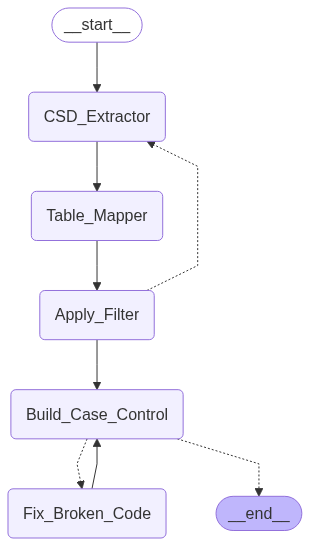

In [10]:

# ---- Simplify CSD for Extraction ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state

    

csd_step_planner_prompt = """
You are planning a cohort build from a clinical study document (CSD).
Read it line by line and output TWO ordered step lists: one for CASE and one for CONTROL.

Allowed step types and fields (these are LITERAL examples, not variables):
- "fetch": {{"entities": {{}}, "line": "..."}}
- "filter": {{"rule": {{}}, "line": "..."}}
- "dedupe": {{"keys": ["PATIENT_ID","EVENT_DTM"], "line": "..."}}
- "anchor": {{"signal":"ECHO","strategy":"most_recent","line":"..."}}
- "window": {{"target":"ECG","delta_days":90,"mode":"around","line":"..."}}
- "exclude": {{"flag_col":"EXCLUDE_FLAG","line":"..."}}
- "merge": {{"side_fetch": {{}}, "how":"inner","line":"..."}}
- "temporal_merge": {{"mode":"within","window_days":1,"line":"..."}}

Keep entities schema-aware (e.g., {{"source":"FACT_DIAGNOSIS","by":"ICD","codes":["I10","I11"],"dim":"DIAGNOSIS_DIM_DIAGNOSIS_CODE"}}).

Return ONLY valid JSON:
{{
  "case": [ {{}}, ... ],
  "control": [ {{}}, ... ]
}}

CSD:
{csd}
"""

def plan_steps(state):
    agent = make_agent(csd_step_planner_prompt)
    res = agent.invoke({"csd": state["csd"]})
    print("\n🧭 [Step_Planner] Output:\n", res.content)
    try:
        plan = json.loads(res.content)
        state["steps_case"] = plan.get("case", [])
        state["steps_control"] = plan.get("control", [])
    except json.JSONDecodeError:
        print("❌ Failed to parse planner JSON")
        state["steps_case"], state["steps_control"] = [], []
    return state




# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = /"/"/"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE
/"/"/"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

    

# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "")
    if "# Error:" not in raw_code or "cohort_df = pd.read_sql_query" in raw_code:
        return state


    agent = make_agent(code_fixer_prompt)
    result = agent.invoke({
        "code": raw_code,
        "table_schema": table_schema
    })
    print("\n🛠️ [Code_Fixer] Corrected Code:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

    
# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "")
    if "# Error:" not in raw_code or "cohort_df = pd.read_sql_query" in raw_code:
        return state


    agent = make_agent(code_fixer_prompt)
    result = agent.invoke({
        "code": raw_code,
        "table_schema": table_schema
    })
    print("\n🛠️ [Code_Fixer] Corrected Code:\n", result.content)
    state["table_fetch_code"] = result.content
    return state


# ---- Step-wise Validator ----
step_validator_prompt = """
You are validating the output of the step "{step}".
Here is the JSON result:
{output}

Respond with ONLY a JSON object using this format:
{{
  "valid": true or false,
  "errors": ["..."],
  "needs_human": true or false
}}
"""

def make_step_validator(step_key: str, output_key: str):
    def _validate(state):
        retry_count = state.get("retry_count", 0)
        output = state.get(output_key, {})

        print(f"\n🔎 Validation for step: {step_key}")
        print("Output being validated:\n", json.dumps(output, indent=2))

        try:
            result = make_agent(step_validator_prompt).invoke({
                "step": step_key,
                "output": json.dumps(output)
            })
            feedback = json.loads(result.content)
        except json.JSONDecodeError:
            print("❌ Failed to parse validator LLM response. Defaulting to 'valid: false'.")
            feedback = {"valid": False, "errors": ["Invalid JSON from validator"], "needs_human": True}

        if not feedback.get("valid"):
            print(f"\n❌ Validation failed for '{step_key}': {feedback.get('errors')}")
            user_input = input(f"🧑 Do you want to override and proceed anyway? (yes/no): ").strip().lower()
            if user_input in ["yes", "y"]:
                print("✅ Human override accepted. Proceeding to next step.")
                state["retry_count"] = 0
                return {"next_step": None}

            print(f"🔁 Retry #{retry_count + 1} for step '{step_key}'")
            state["last_step"] = step_key
            state["retry_count"] = retry_count + 1
            return {"next_step": step_key}

        state["retry_count"] = 0
        return {"next_step": None}
    return _validate

def execute_case_control(state):
    raw_case = state.get("steps_case", [])
    raw_ctrl = state.get("steps_control", [])

    steps_case = normalize_steps(raw_case)
    steps_control = normalize_steps(raw_ctrl)

    if not steps_case:
        print("❌ No valid CASE steps. Raw:", raw_case)
    if not steps_control:
        print("❌ No valid CONTROL steps. Raw:", raw_ctrl)

    print("\n🏁 Running CASE pipeline")
    case_df = run_pipeline(steps_case, table_schema)
    print("\n🏁 Running CONTROL pipeline")
    control_df = run_pipeline(steps_control, table_schema)

    # Optional post-processing hooks:
    # case_df = filter_one_ecg_per_patient(case_df)
    # control_df = filter_one_ecg_per_patient(control_df)

    case_path, ctrl_path = "case_df.parquet", "control_df.parquet"
    try:
        case_df.to_parquet(case_path, index=False)
        control_df.to_parquet(ctrl_path, index=False)
    except Exception:
        case_path, ctrl_path = "case_df.csv", "control_df.csv"
        case_df.to_csv(case_path, index=False)
        control_df.to_csv(ctrl_path, index=False)

    state["case_df_path"] = case_path
    state["control_df_path"] = ctrl_path
    return state 

    
def build_graph():
    builder = StateGraph(GraphState)
    builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
    builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
    # builder.add_node("Validate_Mappings", RunnableLambda(make_step_validator("Table_Mapper", "mappings")))
    
    builder.add_node("Apply_Filter", RunnableLambda(plan_steps))
    builder.add_node("Build_Case_Control", RunnableLambda(execute_case_control))
    
    # builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
    # builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
    builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))
    
    
    builder.set_entry_point("CSD_Extractor")
    builder.add_edge("CSD_Extractor", "Table_Mapper")
    builder.add_edge("Table_Mapper", "Apply_Filter")
    
    
    builder.add_conditional_edges("Apply_Filter", lambda state: state.get("next_step"), {
       
        None: "CSD_Extractor"
    })
    builder.add_edge("Apply_Filter", "Build_Case_Control")
    # builder.add_edge("Execute_Case_Control", "Fix_Broken_Code")
    builder.add_conditional_edges(
        "Build_Case_Control",
        lambda state: "Fix_Broken_Code" if state.get("execution_error") else None,
        {
            "Fix_Broken_Code": "Fix_Broken_Code",
            None: END  # Stop graph if execution_error is empty (i.e., success)
        }
    )
    builder.add_edge("Fix_Broken_Code", "Build_Case_Control") 
    
    # builder.add_edge("Execute_Case_Control", END)
    return builder.compile()

graph = build_graph()
# ---- Visualize Graph ----
display(Image(graph.get_graph().draw_mermaid_png()))

### Defined Functions to be used as tools

In [38]:
import pandas as pd
from typing import List, Any, Tuple
from __future__ import annotations
import numpy as np
from typing import List, Tuple
from tqdm import tqdm



ONE_DAY_SECONDS = 60 * 60 * 24
ONE_HOUR_SECONDS = 60 * 60

In [39]:
def get_age(
    df_event: pd.DataFrame,
    df_birth: pd.DataFrame,
    event_column: str,
    birth_column: str,
    age_column: str,
    pid_column: str="NFER_PID",
):
    """
    Calculate the age of patients at the time of the event.

    This function calculates the age of patients at the time of the event by subtracting their birth year from the event year.

    Parameters:

    - df_event (pd.DataFrame): The DataFrame containing the event data.
    - df_birth (pd.DataFrame): The DataFrame containing the birth year of patients.
    - event_column (str): The name of the column in `df_event` containing the event year.
    - age_column (str): The name of the column to store the calculated age.

    Returns:

    - pd.DataFrame: The DataFrame containing the calculated age of patients at the time of the event.

    """
    df_merged = pd.merge(
        df_event, 
        df_birth,
        how="left",
        on=pid_column,
    )
    df_merged[age_column] = (df_merged[event_column] - df_merged[birth_column])/(60*60*24*365.25)
    df_merged[age_column] = df_merged[age_column].round(4)
    df_merged = df_merged.drop(columns=[birth_column], axis=1)
    return df_merged

In [40]:
def filter_one_ecg_per_patient(
        df_ecg: pd.DataFrame,
        dtm_col: str = "ECG_TIME",
        random_state: int = 42,
)-> pd.DataFrame:
    """
    Filter DataFrame to retain only one record per patient while excluding rows with missing ECG timestamps. 

    Parameters

    - df_ecg (pd.DataFrame): The DataFrame containing ECG data.
    - dtm_col (str, optional): The name of the column with ECG timestamps. Defaults to "ECG_TIME".

    Returns:
    
    - pd.DataFrame: DataFrame with only one ECG record per patient, excluding rows with NaN in dtm_col.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import filter_one_ecg_per_patient
        >>> data = {
        ...     "NFER_PID": [101, 101, 102, 103, 103],
        ...     "ECG_VALUE": [0.8, 0.9, 1.2, 0.7, 1.0],
        ...     "NFER_DTM": [1679851600, 1679853000, 1679854200, 1679854600, 1679938200]
        ... }
        >>> df = pd.DataFrame(data)
        >>> filtered_df = filter_one_ecg_per_patient(df, dtm_col="NFER_DTM")
        >>> print(filtered_df)
           NFER_PID  ECG_VALUE    NFER_DTM
        1       101        0.9  1679853000
        4       103        1.0  1679938200
        2       102        1.2  1679854200
    """
    df_ecg = df_ecg.sample(frac=1, random_state=random_state)
    df_one_ecg_per_patient = df_ecg.drop_duplicates(subset=["NFER_PID"])
    df_one_ecg_per_patient.dropna(subset=[dtm_col], inplace=True)
    return df_one_ecg_per_patient

In [41]:
def perform_within_event_merge(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    bound_columns: List[str],
    filter_column: str,
    left_inclusive: bool = True,
    right_inclusive: bool = True,
) -> pd.DataFrame:
    """
    This function merges two  DataFrames, df_anchor and df_window, using a common NFER_PID column.
    It utilizes two timestamp columns specified in bound_columns to define separate time intervals for two different events in the dataframes. 
    It then selects rows from the merged DataFrame where the timestamp in the filter_column falls within both the defined time intervals in the bound_columns.
    This feature allows for the identification and analysis of events that occur within the specified time ranges for different events from two dataframe.

    Parameters:

    - df_anchor (pd.DataFrame): The anchor DataFrame.
    - df_window (pd.DataFrame): The window DataFrame.
    - bound_columns (List[str]): A list of column names for bounds.
    - filter_column (str): The column to filter on.
    - left_inclusive (bool): Whether the left comparison is inclusive (default is True).
    - right_inclusive (bool): Whether the right comparison is inclusive (default is True).

    Returns:

    - pd.DataFrame: A DataFrame containing the merged and filtered data.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import perform_within_event_merge
        >>> df_anchor = pd.DataFrame({'NFER_PID': [1, 2, 3], 'DRUG_A':[1668902400, 1651708800, 1664496000] ,'DRUG_A_date':["2022-11-20", "2022-05-05", "2022-09-30"], 'DISEASE_DTM':[1685577600, 1676332800, 1697760000],'DISEASE_date':["2023-06-01", "2023-02-14", "2023-10-20"]})
        >>> df_window = pd.DataFrame({'NFER_PID': [2, 3, 1], 'DRUG_B':[1681516800, 1692921600, 1702166400] ,'DRUG_B_date':["2023-04-15", "2023-08-25", "2023-12-10"]})
        >>> bound_columns = ['DRUG_A', 'DRUG_B']
        >>> filter_column = 'DISEASE_DTM'
        >>> perform_within_event_merge(
                df_anchor=df_anchor, 
                df_window=df_window, 
                bound_columns=bound_columns, 
                filter_column=filter_column
            )
        	NFER_PID	DRUG_A	DRUG_A_date	DISEASE_DTM	DISEASE_date	DRUG_B	DRUG_B_date
            0	1	1668902400	2022-11-20	1685577600	2023-06-01	1702166400	2023-12-10
            1	2	1651708800	2022-05-05	1676332800	2023-02-14	1681516800	2023-04-15
            
    """

    df_merged = pd.merge(df_anchor, df_window, how="inner", on="NFER_PID").drop_duplicates()

    if bound_columns[0] == filter_column:
        bound_columns[0] = bound_columns[0] + "_x"
        filter_column = filter_column + "_y"
    if bound_columns[1] == filter_column:
        bound_columns[0] = bound_columns[0] + "_x"
        filter_column = filter_column + "_y"
    
    if left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] >= df_merged[bound_columns[0]]) &
            (df_merged[filter_column] <= df_merged[bound_columns[1]])
        ]
    elif left_inclusive and not right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] >= df_merged[bound_columns[0]]) &
            (df_merged[filter_column] < df_merged[bound_columns[1]])
        ]
    elif not left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] > df_merged[bound_columns[0]]) &
            (df_merged[filter_column] <= df_merged[bound_columns[1]])
        ]
    else:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] > df_merged[bound_columns[0]]) &
            (df_merged[filter_column] < df_merged[bound_columns[1]])
        ]
    
    return df_merged_filtered

In [42]:
def perform_outside_event_merge(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    bound_columns: List[str],
    filter_column: str,
    left_inclusive: bool = True,
    right_inclusive: bool = True,
) -> pd.DataFrame:
    """
    This function merges two  DataFrames, df_anchor and df_window, using a common NFER_PID column.
    It utilizes two timestamp columns specified in bound_columns to define separate time intervals for two different events in the dataframes. 
    It then selects rows from the merged DataFrame where the timestamp in the filter_column falls outside both the defined time intervals in the bound_columns.
    This feature allows for the identification and analysis of events that occur outside the specified time ranges for different events from two dataframe.

    Parameters:

    - df_anchor (pd.DataFrame): The anchor DataFrame.
    - df_window (pd.DataFrame): The window DataFrame.
    - bound_columns (List[str]): A list of column names for bounds.
    - filter_column (str): The column to filter on.
    - left_inclusive (bool): Whether the left comparison is inclusive (default is True).
    - right_inclusive (bool): Whether the right comparison is inclusive (default is True).

    Returns:

    - pd.DataFrame: A DataFrame containing the merged and filtered data.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import perform_outside_event_merge
        >>> df_anchor = pd.DataFrame({'NFER_PID': [1, 2, 3], 'DRUG_A':[1668902400, 1651708800, 1664496000] ,'DRUG_A_date':["2022-11-20", "2022-05-05", "2022-09-30"], 'DISEASE_DTM':[1685577600, 1676332800, 1697760000],'DISEASE_date':["2023-06-01", "2023-02-14", "2023-10-20"]})
        >>> df_window = pd.DataFrame({'NFER_PID': [2, 3, 1], 'DRUG_B':[1681516800, 1692921600, 1702166400] ,'DRUG_B_date':["2023-04-15", "2023-08-25", "2023-12-10"]})
        >>> bound_columns = ['DRUG_A', 'DRUG_B']
        >>> filter_column = 'DISEASE_DTM'
        >>> perform_outside_event_merge(
                df_anchor=df_anchor, 
                df_window=df_window, 
                bound_columns=bound_columns, 
                filter_column=filter_column
            )
        	NFER_PID	DRUG_A	DRUG_A_date	DISEASE_DTM	DISEASE_date	DRUG_B	DRUG_B_date
            2	3	1664496000	2022-09-30	1697760000	2023-10-20	1692921600	2023-08-25

    """

    df_merged = pd.merge(df_anchor, df_window, how="inner", on="NFER_PID").drop_duplicates()

    if bound_columns[0] == filter_column:
        bound_columns[0] = bound_columns[0] + "_x"
        filter_column = filter_column + "_y"
    if bound_columns[1] == filter_column:
        bound_columns[0] = bound_columns[0] + "_x"
        filter_column = filter_column + "_y"
    
    if left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] <= df_merged[bound_columns[0]]) |
            (df_merged[filter_column] >= df_merged[bound_columns[1]])
        ]
    elif left_inclusive and not right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] <= df_merged[bound_columns[0]]) |
            (df_merged[filter_column] > df_merged[bound_columns[1]])
        ]
    elif not left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] < df_merged[bound_columns[0]]) |
            (df_merged[filter_column] >= df_merged[bound_columns[1]])
        ]
    else:
        df_merged_filtered = df_merged[
            (df_merged[filter_column] < df_merged[bound_columns[0]]) |
            (df_merged[filter_column] > df_merged[bound_columns[1]])
        ]
    
    return df_merged_filtered

In [43]:
def accumulate_window_patients(
        df_windows : List[pd.DataFrame],
        operation: str,
)-> pd.DataFrame:
    """
    Accumulate patients from the list of DataFrames based on the specified operation.

    This function takes a list of DataFrames `df_windows`, each containing ECG data for a specific window.
    It performs an accumulation of patient IDs based on the specified `operation`. The operation can be either "or" or "and".

    The "or" operation merges the patient IDs present in all DataFrames, resulting in a union of all patients.
    The "and" operation finds the common patient IDs across all DataFrames, resulting in an intersection.

    Parameters:
    
    - df_windows (List[pd.DataFrame]): A list of DataFrames, each containing ECG data for a specific window.
    - operation (str): The operation to perform for accumulating patients. Valid values are "or" and "and".

    Returns:
        
    - set: A set containing the accumulated patient IDs based on the specified operation.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import accumulate_window_patients
        >>> data1 = {
        ...     "NFER_PID": [101, 102, 103],
        ...     "LABTEST_A": [0.8, 0.9, 1.2]
        ... }
        >>> data2 = {
        ...     "NFER_PID": [102, 103, 104],
        ...     "LABTEST_B": [1.1, 0.7, 1.0]
        ... }
        >>> df1 = pd.DataFrame(data1)
        >>> df2 = pd.DataFrame(data2)
        >>> window_patients = accumulate_window_patients([df1, df2], "or")
        >>> print(window_patients)
        {101, 102, 103, 104}
        >>> window_patients = accumulate_window_patients([df1, df2], "and")
        >>> print(window_patients)
        {102, 103}
    """

    window_patients = set()
    if operation == "or":
        for df_window in df_windows:
            window_patients = window_patients | set(df_window["NFER_PID"])
    elif operation == "and":
        set_pids = [set(df_window["NFER_PID"]) for df_window in df_windows]
        window_patients = set.intersection(*set_pids)
    return window_patients

In [44]:
def filter_patients(
        df_anchor: pd.DataFrame,      
        *df_windows : List[pd.DataFrame],
        operation: str = "or",
)-> pd.DataFrame:
    """
    Filter patients in df_anchor from df_windows based on the specified operation.

    This function filters patients in the DataFrame `df_anchor` based on the patient IDs accumulated from multiple
    DataFrames provided in `df_windows`. The accumulation of patient IDs is performed based on the specified
    `operation`, which can be either "or" or "and".

    The "or" operation includes patients that are present in any of the DataFrames in `df_windows`.
    The "and" operation includes patients that are common across all DataFrames in `df_windows`.

    Parameters:

    - df_anchor (pd.DataFrame): The DataFrame containing ECG data for the anchor group of patients.
    - *df_windows (List[pd.DataFrame]): Variable-length argument list of DataFrames, each containing patient ID ("NFER_PID") and timestamp ("NFER_DTM").
    - operation (str, optional): The operation to perform for filtering patients. Defaults to "or".

    Returns:

    - pd.DataFrame: A new DataFrame containing only the patients present in `df_anchor` that match the accumulated patient IDs from `df_windows`.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import filter_patients
        >>> data_anchor = {
        ...     "NFER_PID": [101, 102, 103, 104],
        ...     "NFER_DTM": [1679851600, 1679853000, 1679854200, 1679854600]
        ... }
        >>> data_window1 = {
        ...     "NFER_PID": [102, 103, 104, 105],
        ...     "NFER_DTM": [1679853000, 1679854200, 1679854600, 1679856000]
        ... }
        >>> data_window2 = {
        ...     "NFER_PID": [101, 103, 105, 106],
        ...     "NFER_DTM": [1679851600, 1679854200, 1679856000, 1679858000]
        ... }
        >>> df_anchor = pd.DataFrame(data_anchor)
        >>> df_window1 = pd.DataFrame(data_window1)
        >>> df_window2 = pd.DataFrame(data_window2)
        >>> filtered_df = filter_patients(df_anchor, df_window1, df_window2, operation="or")
        >>> print(filtered_df)
           NFER_PID    NFER_DTM
        0       101  1679851600
        1       102  1679853000
        2       103  1679854200
        3       104  1679854600
        >>> filtered_df = filter_patients(df_anchor, df_window1, df_window2, operation="and")
        >>> print(filtered_df)
           NFER_PID    NFER_DTM
        0       103  1679854200

    """
    window_patients = accumulate_window_patients(df_windows, operation)
    df_anchor_filtered = df_anchor[df_anchor["NFER_PID"].isin(window_patients)]
    return df_anchor_filtered

In [45]:
def remove_patients(
        df_anchor: pd.DataFrame,
        *df_windows : List[pd.DataFrame],
        operation: str = "or",
)-> pd.DataFrame:
    """
    Remove patients in df_anchor based on the specified operation.
    
    This function removes patients from the DataFrame `df_anchor` based on the patient IDs accumulated from multiple
    DataFrames provided in `df_windows`. The accumulation of patient IDs is performed based on the specified
    `operation`, which can be either "or" or "and".

    The "or" operation includes patients that are present in any of the DataFrames in `df_windows`.
    The "and" operation includes patients that are common across all DataFrames in `df_windows`.

    Parameters:

    - df_anchor (pd.DataFrame): The DataFrame containing patient data for the anchor group of patients.
    - *df_windows (List[pd.DataFrame]): Variable-length argument list of DataFrames, each containing patient ID ("NFER_PID") and timestamp ("NFER_DTM").
    - operation (str, optional): The operation to perform for removing patients. Defaults to "or".

    Returns:

    - pd.DataFrame: A new DataFrame containing the remaining patients in `df_anchor` after removing the ones that match the accumulated patient IDs from `df_windows`.

    Examples:

        >>> import pandas as pd
        >>> from from kedrokit.data_utils import remove_patients
        >>> data_anchor = {
        ...     "NFER_PID": [101, 102, 103, 104, 107],
        ...     "NFER_DTM": [1679851600, 1679853000, 1679854200, 1679854600, 1679858000]
        ... }
        >>> data_window1 = {
        ...     "NFER_PID": [102, 103, 104, 105],
        ...     "NFER_DTM": [1679853000, 1679854200, 1679854600, 1679856000]
        ... }
        >>> data_window2 = {
        ...     "NFER_PID": [101, 103, 105, 106],
        ...     "NFER_DTM": [1679851600, 1679854200, 1679856000, 1679858000]
        ... }
        >>> df_anchor = pd.DataFrame(data_anchor)
        >>> df_window1 = pd.DataFrame(data_window1)
        >>> df_window2 = pd.DataFrame(data_window2)
        >>> filtered_df_or = remove_patients(df_anchor, df_window1, df_window2, operation="or")
        >>> print("Filtered DataFrame using 'or' operation:")
        >>> print(filtered_df_or)
           NFER_PID    NFER_DTM
        4       107  1679858000
        >>> filtered_df_and = remove_patients(df_anchor, df_window1, df_window2, operation="and")
        >>> print("Filtered DataFrame using 'and' operation:")
        >>> print(filtered_df_and)
           NFER_PID    NFER_DTM
        0       101  1679851600
        1       102  1679853000
        3       104  1679854600
        4       107  1679858000
    
    """
    window_patients = accumulate_window_patients(df_windows, operation)
    df_anchor_filtered = df_anchor[~df_anchor["NFER_PID"].isin(window_patients)]
    return df_anchor_filtered

In [46]:
def filter_with_window_patients_intersected(
        df_anchor: pd.DataFrame,
        *df_windows : List[pd.DataFrame],
)-> pd.DataFrame:
    
    return filter_patients(df_anchor, *df_windows, operation="and")

In [47]:
def remove_with_window_patients_intersected(
        df_anchor: pd.DataFrame,
        *df_windows : List[pd.DataFrame],
)-> pd.DataFrame:
    
    return remove_patients(df_anchor, *df_windows, operation="and")

In [48]:
def format_time_window(
    time_window: List[int | float], time_unit: str
) -> Tuple[float | int, float | int]:
    """
    Format a time window specified as a list of two values.

    Parameters:
        
    - time_window (List[int | float]): A list containing two values representing the time window.
    - time_unit (str): The unit of time for the window. Should be 'days' or 'hours'.

    Returns:
        
    - Tuple[float | int, float | int]: A tuple containing the formatted time window boundaries.

    Raises:

    - ValueError: If the time_unit is not 'days' or 'hours'.
    - ValueError: If the time_window is not a list with a length of 2.
    - ValueError: If left_window or right_window is not a valid number or '-inf'/'inf'.

    """

    conversions = {"days": ONE_DAY_SECONDS, "hours": ONE_HOUR_SECONDS}

    if time_unit not in conversions:
        raise ValueError(
            f"Invalid time_unit '{time_unit}'. Expected 'days' or 'hours'."
        )

    if not isinstance(time_window, list) or len(time_window) != 2:
        raise ValueError("The time_window must be a list with a length of 2.")

    left_window, right_window = time_window[0], time_window[1]

    if not (isinstance(left_window, (int, float)) or left_window == "-inf"):
        raise ValueError(
            "The left_window must be an integer, float, or the string '-inf'."
        )

    if not (isinstance(right_window, (int, float)) or right_window == "inf"):
        raise ValueError(
            "The right_window must be an integer, float, or the string 'inf'."
        )

    # inf str to numpy inf
    if left_window == "-inf":
        left_window = -np.inf
    if right_window == "inf":
        right_window = np.inf

    # convert window in seconds
    if time_unit == "days":
        left_window = left_window * ONE_DAY_SECONDS
        right_window = right_window * ONE_DAY_SECONDS
    elif time_unit == "hours":
        left_window = left_window * ONE_HOUR_SECONDS
        right_window = right_window * ONE_HOUR_SECONDS

    return left_window, right_window

In [49]:
def apply_within_temporal_filter(
    df_merged: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = True,
) -> pd.DataFrame:

    """
    Apply a temporal filter to a DataFrame based on anchor and window columns.

    This function filters rows in the input DataFrame `df_merged` based on the difference between
    the `window_column` and the `anchor_column`. Rows whose time difference falls within the specified
    time window between `anchor_column` and `window_column` are included in the result.

    Parameters:
        
    - df_merged (pd.DataFrame): The DataFrame to be filtered.
    - anchor_column (str): The name of the column representing the anchor timestamp.
    - window_column (str): The name of the column representing the timestamp to compare with the anchor.
    - time_window (List[int]): The time window for filtering. Should be a list with two elements,specifying the lower and upper bounds.
    - left_inclusive (bool): Whether the left boundary of the time window is inclusive. Default is True.
    - right_inclusive (bool): Whether the right boundary of the time window is inclusive. Default is True.
    - time_unit (str): The unit of time for the window. Should be 'days' or 'hours'. Default is 'days'.
    - print_stat (bool): Whether to print statistics about the filtering. Default is True.

    Returns:
    
    - pd.DataFrame: The filtered DataFrame containing rows whose time difference is within the time window.

    Examples:
        >>> import pandas as pd
        >>> from kedrokit.data_utils import apply_within_temporal_filter
        >>> df = pd.DataFrame({
        ... 'NFER_PID': [1, 2, 3, 4, 5],
        ... 'NFER_DTM': [1627442400, 1627443000, 1627443600, 1627444200, 1627444800],
        ... 'NFER_DTM_date': ['2021-07-28 03:20:00', '2021-07-28 03:30:00', '2021-07-28 03:40:00', '2021-07-28 03:50:00', '2021-07-28 04:00:00'],
        ... 'DISEASE_DTM': [1627532400, 1627512000, 1627488000, 1627490400, 1627471200],
        ... 'DISEASE_DTM_date':['2021-07-29 04:20:00','2021-07-28 22:40:00','2021-07-28 16:00:00','2021-07-28 16:40:00','2021-07-28 11:20:00']})
        >>> time_window = [-1, 1]  # Filtering rows with time difference between -1 and 1 days.
        >>> filtered_df = apply_within_temporal_filter(
                df_merged=df, 
                anchor_column='NFER_DTM', 
                window_column='DISEASE_DTM', 
                time_window=time_window,
                print_stat=False
            )
        >>> filtered_df
        	NFER_PID	NFER_DTM	NFER_DTM_date	DISEASE_DTM	DISEASE_DTM_date
            1	2	1627443000	2021-07-28 03:30:00	1627512000	2021-07-28 22:40:00
            2	3	1627443600	2021-07-28 03:40:00	1627488000	2021-07-28 16:00:00
            3	4	1627444200	2021-07-28 03:50:00	1627490400	2021-07-28 16:40:00
            4	5	1627444800	2021-07-28 04:00:00	1627471200	2021-07-28 11:20:00
        
    """

    left_window, right_window = format_time_window(time_window, time_unit)

    df_merged["time_diff"] = df_merged[window_column] - df_merged[anchor_column]

    if left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] >= left_window)
            & (df_merged["time_diff"] <= right_window)
        ]
    elif left_inclusive and not right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] >= left_window)
            & (df_merged["time_diff"] < right_window)
        ]
    elif not left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] > left_window)
            & (df_merged["time_diff"] <= right_window)
        ]
    else:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] > left_window)
            & (df_merged["time_diff"] < right_window)
        ]

    df_merged_filtered.drop(["time_diff"], axis=1, inplace=True)

    if print_stat:
        log_stats(df_merged_filtered)

    return df_merged_filtered

In [50]:
def apply_outside_temporal_filter(
    df_merged: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int] = ["-inf", "inf"],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = True,
) -> pd.DataFrame:

    """
    Apply a temporal filter to a DataFrame based on anchor and window columns.

    This function filters rows in the input DataFrame `df_merged` based on the difference between
    the `window_column` and the `anchor_column`. Rows whose time difference falls outside
    the specified time window between `window_column` and `anchor_column` are included in the result.

    Parameters:
    
    - df_merged (pd.DataFrame): The DataFrame to be filtered.
    - anchor_column (str): The name of the column representing the anchor timestamp.
    - window_column (str): The name of the column representing the timestamp to compare with the anchor.
    - time_window (List[float]): The time window for filtering. Should be a list with two elements,specifying the lower and upper bounds. Default is [-inf, inf].
    - left_inclusive (bool): Whether the left boundary of the time window is inclusive. Default is True.
    - right_inclusive (bool): Whether the right boundary of the time window is inclusive. Default is True.
    - time_unit (str): The unit of time for the window. Should be 'days' or 'hours'. Default is 'days'.
    - print_stat (bool): Whether to print statistics about the filtering. Default is True.

    Returns:

    - pd.DataFrame: The filtered DataFrame containing rows whose time difference is outside the time window.

    Examples:
        >>> import pandas as pd
        >>> from kedrokit.data_utils import apply_outside_temporal_filter
        >>> df = pd.DataFrame({
        ... 'NFER_PID': [1, 2, 3, 4, 5],
        ... 'NFER_DTM': [1627442400, 1627443000, 1627443600, 1627444200, 1627444800],
        ... 'NFER_DTM_date': ['2021-07-28 03:20:00', '2021-07-28 03:30:00', '2021-07-28 03:40:00', '2021-07-28 03:50:00', '2021-07-28 04:00:00'],
        ... 'DISEASE_DTM': [1627532400, 1627512000, 1627488000, 1627490400, 1627471200],
        ... 'DISEASE_DTM_date':['2021-07-29 04:20:00','2021-07-28 22:40:00','2021-07-28 16:00:00','2021-07-28 16:40:00','2021-07-28 11:20:00']})
        >>> time_window = [-1, 1]  # Filtering rows with time difference between -1 and 1 days.
        >>> filtered_df = apply_outside_temporal_filter(
                df_merged=df, 
                anchor_column='NFER_DTM', 
                window_column'DISEASE_DTM', 
                time_window=time_window,
                print_stat=False
            )
        >>> filtered_df
        	NFER_PID	NFER_DTM	NFER_DTM_date	DISEASE_DTM	DISEASE_DTM_date
            0	1	1627442400	2021-07-28 03:20:00	1627532400	2021-07-29 04:20:00
    """
        

    left_window, right_window = format_time_window(time_window, time_unit)

    df_merged["time_diff"] = df_merged[window_column] - df_merged[anchor_column]

    if left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] <= left_window)
            | (df_merged["time_diff"] >= right_window)
        ]
    elif left_inclusive and not right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] <= left_window)
            | (df_merged["time_diff"] > right_window)
        ]
    elif not left_inclusive and right_inclusive:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] < left_window)
            | (df_merged["time_diff"] >= right_window)
        ]
    else:
        df_merged_filtered = df_merged[
            (df_merged["time_diff"] < left_window)
            | (df_merged["time_diff"] > right_window)
        ]

    df_merged_filtered.drop(["time_diff"], axis=1, inplace=True)

    if print_stat:
        log_stats(df_merged_filtered)

    return df_merged_filtered

In [51]:
def perform_within_temporal_merge(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int] = ["-inf", "inf"],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = True,
) -> pd.DataFrame:
    """
    Perform a temporal merge between two dataframes and apply within temporal filter.

    This function performs an inner merge between the two input DataFrames `df_anchor` and `df_window`
    based on the common column 'NFER_PID'. Then, it applies a temporal filter to the merged DataFrame
    using the `apply_within_temporal_filter` function, which filters rows based on the difference between
    the `window_column` and the `anchor_column`. Rows whose time difference falls within the specified
    time window are included in the result.

    Parameters:
        
    - df_anchor (pd.DataFrame): The DataFrame which contains anchor timestamp.
    - df_window (pd.DataFrame): The DataFrame which contains window timestamp.
    - anchor_column (str): The column in `df_anchor` to apply temporal merge on.
    - window_column (str): The column in `df_window` to apply temporal merge on.
    - time_window (List[int]): The time window for the temporal filter. Should be a list with two elements,
                                 specifying the lower and upper bounds. Default is ["-inf", "inf"].
    - left_inclusive (bool): Whether the left boundary of the time window is inclusive. Default is True.
    - right_inclusive (bool): Whether the right boundary of the time window is inclusive. Default is True.
    - time_unit (str): The unit of time for the window. Should be 'days' or 'hours'. Default is 'days'.
    - print_stat (bool): Whether to print statistics about the filtering. Default is True.

    Returns:

    - pd.DataFrame: The merged and filtered DataFrame containing rows whose time difference is within the time window.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import perform_within_temporal_merge
        >>> df_anchor = pd.DataFrame({
        ...     'NFER_PID': [1, 2, 3, 4, 5],
        ...     'NFER_DTM': [1627442400, 1627443000, 1627443600, 1627444200, 1627444800],
        ...     'NFER_DTM_date':['2021-07-28 03:20:00', '2021-07-28 03:30:00', '2021-07-28 03:40:00', '2021-07-28 03:50:00', '2021-07-28 04:00:00']
        ... })
        >>> df_window = pd.DataFrame({
        ...     'NFER_PID': [2, 3, 4, 5, 6],
        ...     'DISEASE_DTM': [1627443300, 1627443900, 1627444100, 1627444900, 1627445400],
        ...     'DISEASE_DTM_date' :   ['2021-07-29 03:35:00', '2021-07-28 03:45:00', '2021-08-28 03:48:20', '2021-07-28 04:01:40', '2022-07-28 04:10:00']
        ... })
        >>> time_window = [-1, 1] 
        >>> merged_and_filtered_df = perform_within_temporal_merge(
                df_anchor=df_anchor, 
                df_window=df_window, 
                anchor_column='NFER_DTM', 
                window_column='DISEASE_DTM', 
                time_window=time_window,
                print_stat=False
            )
        >>> merged_and_filtered_df
        	NFER_PID	NFER_DTM	NFER_DTM_date	DISEASE_DTM	DISEASE_DTM_date
            1	3	1627443600	2021-07-28 03:40:00	1627443900	2021-07-28 03:45:00
            3	5	1627444800	2021-07-28 04:00:00	1627444900	2021-07-28 04:01:40
            """

    assert df_anchor[anchor_column].dtype in [
        "int",
        "float",
    ], "Anchor column must be of type int or float"
    assert df_window[window_column].dtype in [
        "int",
        "float",
    ], "Window column must be of type int or float"

    df_merged = pd.merge(
        df_anchor, df_window, how="inner", on="NFER_PID"
    ).drop_duplicates()

    if anchor_column == window_column:
        anchor_column = anchor_column + "_x"
        window_column = window_column + "_y"

    df_merged_filtered = apply_within_temporal_filter(
        df_merged=df_merged,
        anchor_column=anchor_column,
        window_column=window_column,
        time_window=time_window,
        left_inclusive=left_inclusive,
        right_inclusive=right_inclusive,
        time_unit=time_unit,
        print_stat=print_stat,
    )

    return df_merged_filtered

In [52]:
def perform_outside_temporal_merge(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = True,
) -> pd.DataFrame:
    """

    This function performs an inner merge between the two input DataFrames `df_anchor` and `df_window`
    based on the common column 'NFER_PID'. Then, it applies a temporal filter to the merged DataFrame
    using the `apply_outside_temporal_filter` function, which filters rows based on the difference between
    the `window_column` and the `anchor_column`. Rows whose time difference falls outside the specified
    time window are included in the result.

    Parameters:

    - df_anchor (pd.DataFrame): The DataFrame which contains anchor timestamp.
    - df_window (pd.DataFrame): The DataFrame which contains window timestamp.
    - anchor_column (str): The column in `df_anchor` to apply temporal merge on.
    - window_column (str): The column in `df_window` to apply temporal merge on.
    - time_window (List[int]): The time window for the outside temporal filter. Should be a list with two elements,specifying the lower and upper bounds.
    - left_inclusive (bool): Whether the left boundary of the time window is inclusive. Default is True.
    - right_inclusive (bool): Whether the right boundary of the time window is inclusive. Default is True.
    - time_unit (str): The unit of time for the window. Should be 'days' or 'hours'. Default is 'days'.
    - print_stat (bool): Whether to print statistics about the filtering. Default is True.

    Returns:

    - pd.DataFrame: The merged and filtered DataFrame containing rows whose time difference is outside the time window.

    Examples:

        >>> import pandas as pd
        >>> from kedrokit.data_utils import perform_outside_temporal_merge
        >>> df_anchor = pd.DataFrame({
        ... 'NFER_PID': [1, 2, 3, 4, 5],
        ... 'NFER_DTM': [1627442400, 1627443000, 1627443600, 1627444200, 1627444800],
        ... 'NFER_DTM_date':['2021-07-28 03:20:00', '2021-07-28 03:30:00', '2021-07-28 03:40:00', '2021-07-28 03:50:00', '2021-07-28 04:00:00'],    })
        >>> df_window = pd.DataFrame({
        ... 'NFER_PID': [2, 3, 4, 5, 6],
        ... 'DISEASE_DTM': [1627532400, 1627512000, 1627488000, 1627490400, 1627471200],
        ... 'DISEASE_DTM_date': ['2021-07-29 04:20:00','2021-07-28 22:40:00','2021-07-28 16:00:00','2021-07-28 16:40:00','2021-07-28 11:20:00']})
        >>> time_window = ["-inf", 1]
        >>> merged_and_filtered_df = perform_outside_temporal_merge(
                df_anchor=df_anchor, 
                df_window=df_window, 
                anchor_column='NFER_DTM', 
                window_column='DISEASE_DTM', 
                time_window=time_window,
                print_stat=False
            )
        >>> merged_and_filtered_df
        	NFER_PID	NFER_DTM	NFER_DTM_date	DISEASE_DTM	DISEASE_DTM_date
            0	2	1627443000	2021-07-28 03:30:00	1627532400	2021-07-29 04:20:00
    """

    assert df_anchor[anchor_column].dtype in [
        "int",
        "float",
    ], "Anchor column must be of type int or float"
    assert df_window[window_column].dtype in [
        "int",
        "float",
    ], "Window column must be of type int or float"

    df_merged = pd.merge(
        df_anchor, df_window, how="inner", on="NFER_PID"
    ).drop_duplicates()

    if anchor_column == window_column:
        anchor_column = anchor_column + "_x"
        window_column = window_column + "_y"

    df_merged_filtered = apply_outside_temporal_filter(
        df_merged=df_merged,
        anchor_column=anchor_column,
        window_column=window_column,
        time_window=time_window,
        left_inclusive=left_inclusive,
        right_inclusive=right_inclusive,
        time_unit=time_unit,
        print_stat=print_stat,
    )

    return df_merged_filtered

In [53]:
def chunk_dataframe(dataframe, chunk_size=100000):
    """
    Chunk a DataFrame into smaller dataframes of a specified size.

    Parameters:
        
    - dataframe (pd.DataFrame): The input DataFrame to be chunked.
    - chunk_size (int, optional): The size of each chunk (default is 100,000).

    Returns:
        
    - List[pd.DataFrame]: A list of smaller DataFrames, each containing a chunk of the original data.

    Raises:
        
    - ValueError: If chunk_size is not a positive integer.
    """
    chunks = []
    for i in range(0, len(dataframe), chunk_size):
        chunks.append(dataframe[i : i + chunk_size])
    return chunks

In [54]:
def perform_within_temporal_merge_by_chunk(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int] = ["-inf", "inf"],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = False,
) -> pd.DataFrame:
    """
    This function performs perform_within_temporal_merge after chunking the dataframe and result will be concatenated.
    This is done for big dataframes to avoid memory issues.

    """
    df_window = df_window[df_window["NFER_PID"].isin(df_anchor["NFER_PID"])]
    df_chunks = chunk_dataframe(df_window)
    df_merged_filtered = []
    for df_chunk in tqdm(df_chunks):
        df_chunk_merged_filtered = perform_within_temporal_merge(
            df_anchor=df_anchor,
            df_window=df_chunk,
            anchor_column=anchor_column,
            window_column=window_column,
            time_window=time_window,
            left_inclusive=left_inclusive,
            right_inclusive=right_inclusive,
            time_unit=time_unit,
            print_stat=print_stat,
        )
        df_merged_filtered.append(df_chunk_merged_filtered)
    df_merged_filtered = pd.concat(df_merged_filtered)

    log_stats(df_merged_filtered)

    return df_merged_filtered

In [55]:

def perform_outside_temporal_merge_by_chunk(
    df_anchor: pd.DataFrame,
    df_window: pd.DataFrame,
    anchor_column: str,
    window_column: str,
    time_window: List[int],
    left_inclusive: bool = True,
    right_inclusive: bool = True,
    time_unit: str = "days",
    print_stat: bool = False,
) -> pd.DataFrame:
    """
    This function performs perform_outside_temporal_merge after chunking the dataframe and result will be concatenated
    This is done for big dataframes to avoid memory issues.
    """

    df_window = df_window[df_window["NFER_PID"].isin(df_anchor["NFER_PID"])]
    df_chunks = chunk_dataframe(df_window)
    df_merged_filtered = []
    for df_chunk in tqdm(df_chunks):
        df_chunk_merged_filtered = perform_outside_temporal_merge(
            df_anchor=df_anchor,
            df_window=df_chunk,
            anchor_column=anchor_column,
            window_column=window_column,
            time_window=time_window,
            left_inclusive=left_inclusive,
            right_inclusive=right_inclusive,
            time_unit=time_unit,
            print_stat=print_stat,
        )
        df_merged_filtered.append(df_chunk_merged_filtered)
    df_merged_filtered = pd.concat(df_merged_filtered)

    log_stats(df_merged_filtered)

    return df_merged_filtered

In [28]:
table_schema = {
    "DIM_PATIENT": {
        "PATIENT_ID": "TEXT PRIMARY KEY",
        "PATIENT_BIRTH_DATE": "TEXT",
        "PATIENT_GENDER_NAME": "TEXT",
        "PATIENT_RACE_NAME": "TEXT",
        "PATIENT_DEATH_DATE": "TEXT",
        "PATIENT_MERGED_FLAG": "TEXT"
    },
    "DIAGNOSIS_DIM_DIAGNOSIS_CODE": {
        "DIAGNOSIS_CODE_DK": "INTEGER PRIMARY KEY",
        "DIAGNOSIS_CODE": "TEXT",
        "DIAGNOSIS_DESCRIPTION": "TEXT"
    },
    "PROCEDURES_DIM_PROCEDURE_CODE": {
        "PROCEDURE_CODE_DK": "INTEGER PRIMARY KEY",
        "PROCEDURE_CODE": "TEXT",
        "PROCEDURE_DESCRIPTION": "TEXT"
    },
    "LAB_SPECIMEN_DIM_LAB_TEST": {
        "LAB_TEST_DK": "INTEGER PRIMARY KEY",
        "LAB_TEST_DESCRIPTION": "TEXT",
        "STANDARD_LAB_TEST_DESCRIPTION": "TEXT"
    },
    "MAR_DIM_MED_NAME": {
        "MED_NAME_DK": "INTEGER PRIMARY KEY",
        "MED_NAME_DESCRIPTION": "TEXT",
        "STANDARD_MED_NAME_CODE": "TEXT",
        "MED_GENERIC_NAME_DESCRIPTION": "TEXT",
        "STANDARD_MED_GENERIC_NAME_DESCRIPTION": "TEXT"
    },
    "DIM_FLOWSHEET_NAME": {
        "FLOWSHEET_NAME_DK": "INTEGER PRIMARY KEY",
        "STANDARD_FLOWSHEET_NAME_DK": "TEXT"
    },
    "ECHOCARDIOGRAM_DIM_ECHO_TEST_RESULT_TYPE": {
        "ECHO_TEST_RESULT_TYPE_DK": "INTEGER PRIMARY KEY",
        "ECHO_TEST_RESULT_DESCRIPTION": "TEXT"
    },
    "FACT_DIAGNOSIS": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "DIAGNOSIS_CODE_DK": "INTEGER"
    },
    "FACT_PROCEDURES": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "PROCEDURE_CODE_DK": "INTEGER"
    },
    "FACT_LAB_TEST": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "LAB_TEST_DK": "INTEGER",
        "LAB_STATUS": "TEXT",
        "RESULT_TXT": "TEXT",
        "UNIT_OF_MEASURE_TXT": "TEXT"
    },
    "FACT_MEDICATIONS": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "MED_NAME_DK": "INTEGER"
    },
    "FACT_FLOWSHEETS": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "FLOWSHEET_NAME_DK": "INTEGER",
        "FLOWSHEET_RESULT_TXT": "TEXT",
        "FLOWSHEET_UNIT_OF_MEASURE_TXT": "TEXT",
        "FLOWSHEET_TYPE_DESCRIPTION": "TEXT"
    },
    "FACT_ECG": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "ECG_INTERPRET_FULL_TEXT": "TEXT"
    },
    "FACT_ECHO_TEST": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "ECHO_TEST_FPK": "INTEGER"
    },
    "FACT_ECHOCARDIOGRAM": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "RESULT_TYPE": "TEXT",
        "VALUE": "TEXT"
    },
    "FACT_ECHO_RESULTS": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "ECHO_TEST_FPK": "INTEGER",
        "ECHO_RESULT_VALUE": "TEXT",
        "ECHO_RESULTS_VALUE_UNIT_OF_MEASURE": "TEXT",
        "ECHO_TEST_RESULT_TYPE_DK": "INTEGER",
        "PHASE_NAME": "TEXT"
    },
    "FACT_RADIOLOGY": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "RADIOLOGY_IMPRESSION": "TEXT",
        "RADIOLOGY_NARRATIVE": "TEXT",
        "RADIOLOGY_REPORT": "TEXT"
    },
    "FACT_PATHOLOGY": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "SPECIMEN_NOTE": "TEXT",
        "SPECIMEN_COMMENT": "TEXT"
    },
    "FACT_ENCOUNTERS": {
        "PATIENT_ID": "TEXT",
        "ADMIT_DTM": "INTEGER",
        "DISCHARGE_DTM": "INTEGER",
        "EMERGENCY_FLAG": "TEXT",
        "ENCOUNTER_TYPE": "TEXT",
        "LENGTH_OF_STAY": "INTEGER"
    },
    "FACT_ORDERS": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "MED_GENERIC": "TEXT",
        "ORDER_ALIAS_DESCRIPTION": "TEXT",
        "ORDER_FORM_DESCRIPTION": "TEXT",
        "ORDER_STATUS": "TEXT",
        "ORDER_TYPE_DESCRIPTION": "TEXT"
    },
    "FACT_CLINICAL_DOCUMENTS": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "CLINICAL_DOCUMENT_TEXT": "TEXT",
        "CLINICAL_DOCUMENT_EVENT_TYPE_TXT": "TEXT",
        "CLINICAL_DOCUMENT_TITLE": "TEXT"
    },
    "FACT_MEDS_ADMINISTERED": {
        "PATIENT_ID": "TEXT",
        "EVENT_DTM": "INTEGER",
        "MED_NAME_DK": "INTEGER",
        "ADMINISTERED_STATUS": "TEXT",
        "ADMINISTERED_DOSE": "TEXT",
        "ADMINISTERED_DOSE_UNITS": "TEXT"
    }
}


In [ ]:
filter_functions =  [get_age,filter_one_ecg_per_patient,perform_within_event_merge,perform_outside_event_merge,
                            accumulate_window_patients,filter_patients,remove_patients,filter_with_window_patients_intersected,
                            remove_with_window_patients_intersected,format_time_window,apply_within_temporal_filter,apply_outside_temporal_filter,
                            perform_within_temporal_merge,perform_outside_temporal_merge,chunk_dataframe,perform_within_temporal_merge_by_chunk,
                            perform_outside_temporal_merge_by_chunk]

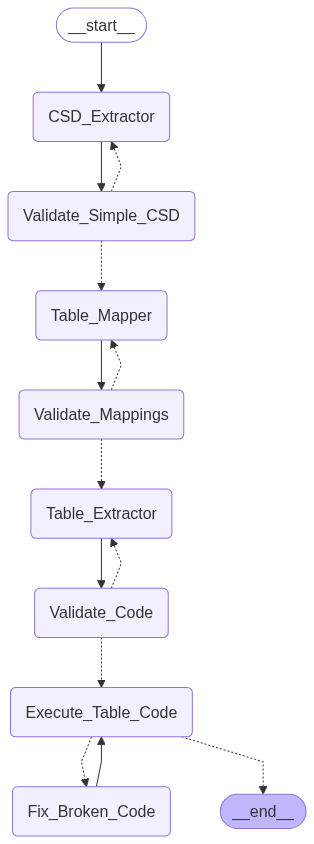


🚀 [CSD_Extractor] Output:
[
  {"csd": "Cohort Creation Steps", "entities": "ICD codes for hypertension, hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, hypertensive encephalopathy\nLab tests for LAVI and LVMI\nProcedure codes for ECHO and ECG\nDrugs for hypertension"},
  {"csd": "Case", "entities": "Lab tests for abnormal LAVI and abnormal LVMI\nProcedure codes for ECG and ECHO"},
  {"csd": "Control", "entities": "Lab tests for normal LAVI and normal LVMI\nICD codes for HHD disease\nProcedure codes for ECG and ECHO"}
]

🔎 Validation for step: CSD_Extractor
JOB: Extract fundamental data entities to fetch (ICD codes, lab tests, drugs, procedure codes). Ignore temporal logic and ECG-based requests; return a JSON list with an 'entities' string per item.
Input being validated:
 Cohort Creation Steps
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hy

🧑 Override and proceed anyway? (yes/no):  no


🔁 Retry #1 for step 'Table_Extractor'

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION, 
    LSD.LAB_TEST_DESCRIPTION, 
    PDC.PROCEDURE_CODE, 
    PDC.PROCEDURE_DESCRIPTION, 
    MN.MED_NAME_DESCRIPTION, 
    FLT.RESULT_TXT, 
    FD.DIAGNOSIS_CODE_DK, 
    FP.PROCEDURE_CODE_DK, 
    FER.ECHO_RESULT_VALUE
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC
JOIN 
    FACT_DIAGNOSIS AS FD
ON 
    DDC.DIAGNOSIS_CODE_DK = FD.DIAGNOSIS_CODE_DK
JOIN 
    LAB_SPECIMEN_DIM_LAB_TEST AS LSD
JOIN 
    FACT_LAB_TEST AS FLT
ON 
    LSD.LAB_TEST_DK = FLT.LAB_TEST_DK
JOIN 
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
JOIN 
    FACT_PROCEDURES AS FP
ON 
    PDC.PROCEDURE_CODE_DK = FP.PROCEDURE_CODE_DK
JOIN 
    MAR_DIM_MED_NAME AS MN
JOIN 
    FACT_MEDICATIONS AS FM
ON 
    MN.MED_NAME_DK = FM.MED_NAME_DK
JOIN 
    FACT_ECHO_RESULTS AS FER


🧑 Override and proceed anyway? (yes/no):  no


🔁 Retry #1 for step 'Table_Extractor'

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION,
    LSD.LAB_TEST_DESCRIPTION,
    PDC.PROCEDURE_CODE,
    PDC.PROCEDURE_DESCRIPTION,
    MN.MED_NAME_DESCRIPTION,
    FLT.RESULT_TXT,
    FPR.PROCEDURE_CODE_DK,
    FD.DIAGNOSIS_CODE_DK,
    FER.ECHO_RESULT_VALUE
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC
JOIN
    FACT_DIAGNOSIS AS FD
ON
    DDC.DIAGNOSIS_CODE_DK = FD.DIAGNOSIS_CODE_DK
JOIN
    LAB_SPECIMEN_DIM_LAB_TEST AS LSD
JOIN
    FACT_LAB_TEST AS FLT
ON
    LSD.LAB_TEST_DK = FLT.LAB_TEST_DK
JOIN
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
JOIN
    FACT_PROCEDURES AS FPR
ON
    PDC.PROCEDURE_CODE_DK = FPR.PROCEDURE_CODE_DK
JOIN
    MAR_DIM_MED_NAME AS MN
JOIN
    FACT_MEDICATIONS AS FM
ON
    MN.MED_NAME_DK = FM.MED_NAME_DK
JOIN
    FACT_ECHO_RESULTS AS FER
ON
    FD.PATIENT

🧑 Override and proceed anyway? (yes/no):  no


🔁 Retry #1 for step 'Table_Extractor'

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION,
    LSD.LAB_TEST_DESCRIPTION,
    PDC.PROCEDURE_CODE,
    PDC.PROCEDURE_DESCRIPTION,
    MN.MED_NAME_DESCRIPTION,
    FLT.RESULT_TXT,
    FPR.PROCEDURE_CODE_DK,
    FD.DIAGNOSIS_CODE_DK,
    FER.ECHO_RESULT_VALUE
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC
JOIN
    FACT_DIAGNOSIS AS FD
ON
    DDC.DIAGNOSIS_CODE_DK = FD.DIAGNOSIS_CODE_DK
JOIN
    LAB_SPECIMEN_DIM_LAB_TEST AS LSD
JOIN
    FACT_LAB_TEST AS FLT
ON
    LSD.LAB_TEST_DK = FLT.LAB_TEST_DK
JOIN
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
JOIN
    FACT_PROCEDURES AS FPR
ON
    PDC.PROCEDURE_CODE_DK = FPR.PROCEDURE_CODE_DK
JOIN
    MAR_DIM_MED_NAME AS MN
JOIN
    FACT_MEDICATIONS AS FM
ON
    MN.MED_NAME_DK = FM.MED_NAME_DK
JOIN
    FACT_ECHO_RESULTS AS FER
ON
    FD.PATIENT

🧑 Override and proceed anyway? (yes/no):  no


🔁 Retry #1 for step 'Table_Extractor'

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION, 
    LSDT.LAB_TEST_DESCRIPTION, 
    PDC.PROCEDURE_CODE, 
    PDC.PROCEDURE_DESCRIPTION, 
    MDMN.MED_NAME_DESCRIPTION,
    FLT.RESULT_TXT,
    FD.DIAGNOSIS_CODE_DK,
    FP.PROCEDURE_CODE_DK,
    FER.ECHO_RESULT_VALUE
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC
JOIN
    FACT_DIAGNOSIS AS FD
ON
    DDC.DIAGNOSIS_CODE_DK = FD.DIAGNOSIS_CODE_DK
JOIN
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
JOIN
    FACT_PROCEDURES AS FP
ON
    PDC.PROCEDURE_CODE_DK = FP.PROCEDURE_CODE_DK
JOIN
    LAB_SPECIMEN_DIM_LAB_TEST AS LSDT
JOIN
    FACT_LAB_TEST AS FLT
ON
    LSDT.LAB_TEST_DK = FLT.LAB_TEST_DK
JOIN
    MAR_DIM_MED_NAME AS MDMN
JOIN
    FACT_MEDICATIONS AS FM
ON
    MDMN.MED_NAME_DK = FM.MED_NAME_DK
JOIN
    FACT_ECHO_RESULTS AS FER
ON
    

🧑 Override and proceed anyway? (yes/no):  no


🔁 Retry #1 for step 'Table_Extractor'

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION,
    LSD.LAB_TEST_DESCRIPTION,
    PDC.PROCEDURE_CODE,
    PDC.PROCEDURE_DESCRIPTION,
    MN.MED_NAME_DESCRIPTION,
    FLT.RESULT_TXT,
    FDIAG.DIAGNOSIS_CODE_DK,
    FPROC.PROCEDURE_CODE_DK,
    FER.ECHO_RESULT_VALUE
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC
JOIN
    LAB_SPECIMEN_DIM_LAB_TEST AS LSD
ON
    DDC.PATIENT_ID = LSD.PATIENT_ID
JOIN
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
ON
    DDC.PATIENT_ID = PDC.PATIENT_ID
JOIN
    MAR_DIM_MED_NAME AS MN
ON
    DDC.PATIENT_ID = MN.PATIENT_ID
JOIN
    FACT_LAB_TEST AS FLT
ON
    DDC.PATIENT_ID = FLT.PATIENT_ID
JOIN
    FACT_DIAGNOSIS AS FDIAG
ON
    DDC.PATIENT_ID = FDIAG.PATIENT_ID
JOIN
    FACT_PROCEDURES AS FPROC
ON
    DDC.PATIENT_ID = FPROC.PATIENT_ID
JOIN
    FACT_ECHO_RE

🧑 Override and proceed anyway? (yes/no):  no


🔁 Retry #1 for step 'Table_Extractor'

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION,
    LSD.LAB_TEST_DESCRIPTION,
    PDC.PROCEDURE_CODE,
    PDC.PROCEDURE_DESCRIPTION,
    MN.MED_NAME_DESCRIPTION,
    FLT.RESULT_TXT,
    FPR.PROCEDURE_CODE_DK,
    FD.DIAGNOSIS_CODE_DK,
    FER.ECHO_RESULT_VALUE
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC
JOIN
    LAB_SPECIMEN_DIM_LAB_TEST AS LSD
ON
    DDC.PATIENT_ID = LSD.PATIENT_ID
JOIN
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
ON
    DDC.PATIENT_ID = PDC.PATIENT_ID
JOIN
    MAR_DIM_MED_NAME AS MN
ON
    DDC.PATIENT_ID = MN.PATIENT_ID
JOIN
    FACT_LAB_TEST AS FLT
ON
    DDC.PATIENT_ID = FLT.PATIENT_ID
JOIN
    FACT_PROCEDURES AS FPR
ON
    DDC.PATIENT_ID = FPR.PATIENT_ID
JOIN
    FACT_DIAGNOSIS AS FD
ON
    DDC.PATIENT_ID = FD.PATIENT_ID
JOIN
    FACT_ECHO_RESULTS AS FER
ON

🧑 Override and proceed anyway? (yes/no):  no


🔁 Retry #1 for step 'Table_Extractor'

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DP.PATIENT_ID,
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION,
    LSDT.LAB_TEST_DESCRIPTION,
    PDC.PROCEDURE_CODE,
    PDC.PROCEDURE_DESCRIPTION,
    MDMN.MED_NAME_DESCRIPTION,
    FLT.RESULT_TXT,
    FER.ECHO_RESULT_VALUE
FROM 
    DIM_PATIENT AS DP
LEFT JOIN 
    FACT_DIAGNOSIS AS FD ON DP.PATIENT_ID = FD.PATIENT_ID
LEFT JOIN 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC ON FD.DIAGNOSIS_CODE_DK = DDC.DIAGNOSIS_CODE_DK
LEFT JOIN 
    FACT_LAB_TEST AS FLT ON DP.PATIENT_ID = FLT.PATIENT_ID
LEFT JOIN 
    LAB_SPECIMEN_DIM_LAB_TEST AS LSDT ON FLT.LAB_TEST_DK = LSDT.LAB_TEST_DK
LEFT JOIN 
    FACT_PROCEDURES AS FP ON DP.PATIENT_ID = FP.PATIENT_ID
LEFT JOIN 
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC ON FP.PROCEDURE_CODE_DK = PDC.PROCEDURE_CODE_DK
LEFT JOIN 
    FACT_MEDICATIONS AS

🧑 Override and proceed anyway? (yes/no):  no


🔁 Retry #1 for step 'Table_Extractor'

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION,
    LSD.LAB_TEST_DESCRIPTION,
    PDC.PROCEDURE_CODE,
    PDC.PROCEDURE_DESCRIPTION,
    MN.MED_NAME_DESCRIPTION,
    FLT.RESULT_TXT,
    FPR.PROCEDURE_CODE_DK,
    FD.DIAGNOSIS_CODE_DK,
    FER.ECHO_RESULT_VALUE
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC
JOIN
    FACT_DIAGNOSIS AS FD
ON
    DDC.DIAGNOSIS_CODE_DK = FD.DIAGNOSIS_CODE_DK
JOIN
    LAB_SPECIMEN_DIM_LAB_TEST AS LSD
JOIN
    FACT_LAB_TEST AS FLT
ON
    LSD.LAB_TEST_DK = FLT.LAB_TEST_DK
JOIN
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
JOIN
    FACT_PROCEDURES AS FPR
ON
    PDC.PROCEDURE_CODE_DK = FPR.PROCEDURE_CODE_DK
JOIN
    MAR_DIM_MED_NAME AS MN
JOIN
    FACT_MEDICATIONS AS FM
ON
    MN.MED_NAME_DK = FM.MED_NAME_DK
JOIN
    FACT_ECHO_RESULTS AS FER
ON
    FD.PATIENT

🧑 Override and proceed anyway? (yes/no):  no


🔁 Retry #1 for step 'Table_Extractor'

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION,
    LS.LAB_TEST_DESCRIPTION,
    PDC.PROCEDURE_CODE,
    PDC.PROCEDURE_DESCRIPTION,
    MN.MED_NAME_DESCRIPTION,
    FLT.RESULT_TXT,
    FD.DIAGNOSIS_CODE_DK,
    FP.PROCEDURE_CODE_DK,
    FER.ECHO_RESULT_VALUE
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC
JOIN
    FACT_DIAGNOSIS AS FD
ON
    DDC.DIAGNOSIS_CODE_DK = FD.DIAGNOSIS_CODE_DK
JOIN
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
JOIN
    FACT_PROCEDURES AS FP
ON
    PDC.PROCEDURE_CODE_DK = FP.PROCEDURE_CODE_DK
JOIN
    LAB_SPECIMEN_DIM_LAB_TEST AS LS
JOIN
    FACT_LAB_TEST AS FLT
ON
    LS.LAB_TEST_DK = FLT.LAB_TEST_DK
JOIN
    MAR_DIM_MED_NAME AS MN
JOIN
    FACT_MEDICATIONS AS FM
ON
    MN.MED_NAME_DK = FM.MED_NAME_DK
JOIN
    FACT_ECHO_RESULTS AS FER
ON
    FD.PATIENT_ID = 

🧑 Override and proceed anyway? (yes/no):  no


🔁 Retry #1 for step 'Table_Extractor'

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION,
    LSD.LAB_TEST_DESCRIPTION,
    PDC.PROCEDURE_CODE,
    PDC.PROCEDURE_DESCRIPTION,
    MN.MED_NAME_DESCRIPTION,
    FLT.RESULT_TXT,
    FPR.PROCEDURE_CODE_DK,
    FD.DIAGNOSIS_CODE_DK,
    FER.ECHO_RESULT_VALUE
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC
JOIN
    LAB_SPECIMEN_DIM_LAB_TEST AS LSD
ON
    DDC.PATIENT_ID = LSD.PATIENT_ID
JOIN
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
ON
    DDC.PATIENT_ID = PDC.PATIENT_ID
JOIN
    MAR_DIM_MED_NAME AS MN
ON
    DDC.PATIENT_ID = MN.PATIENT_ID
JOIN
    FACT_LAB_TEST AS FLT
ON
    DDC.PATIENT_ID = FLT.PATIENT_ID
JOIN
    FACT_PROCEDURES AS FPR
ON
    DDC.PATIENT_ID = FPR.PATIENT_ID
JOIN
    FACT_DIAGNOSIS AS FD
ON
    DDC.PATIENT_ID = FD.PATIENT_ID
JOIN
    FACT_ECHO_RESULTS AS FER
ON

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [18]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path
    next_step: str           # control signal for conditional routing (set by validators)


# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Simplify CSD for Extraction ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]}) #Calls the agent with state["csd"]
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state



# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""
def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["simple_csd"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

    
# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = /"/"/"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE
/"/"/"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

    

# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "")
    if "# Error:" not in raw_code or "cohort_df = pd.read_sql_query" in raw_code:
        return state


    agent = make_agent(code_fixer_prompt)
    result = agent.invoke({
        "code": raw_code,
        "table_schema": table_schema
    })
    print("\n🛠️ [Code_Fixer] Corrected Code:\n", result.content)
    state["table_fetch_code"] = result.content
    return state





# ---- Execution Agent ----
def clean_code_block(code: str) -> str:
    import re

    # Remove markdown code fences if present
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE)
    code = code.replace("```", "")

    lines = code.strip().splitlines()
    cleaned_lines = []
    found_start = False
    sql_block_open = False

    for i, line in enumerate(lines):
        # Start copying after we hit import/sql/conn
        if not found_start and (line.strip().startswith("import") or line.strip().startswith("conn") or line.strip().startswith("sql_query")):
            found_start = True
        if found_start:
            cleaned_lines.append(line)

        # Track if we are inside the SQL string
        if 'sql_query' in line and '"""' in line:
            sql_block_open = True
        elif sql_block_open and line.strip() == '"""':
            sql_block_open = False
            # Append LIMIT if not present
            if not any("LIMIT" in l.upper() for l in cleaned_lines[-5:]):
                cleaned_lines.insert(len(cleaned_lines) - 1, "LIMIT 1000")

    # Deduplicate trailing execution lines
    seen_exec = set()
    final_lines = []
    for line in cleaned_lines:
        if line.strip() in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if line.strip() in seen_exec:
                continue
            seen_exec.add(line.strip())
        final_lines.append(line)

    # Ensure execution lines exist
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        final_lines.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        final_lines.append("conn.close()")

    code = "\n".join(final_lines).strip()

    # Replace ambiguous DataFrame truth checks (the main fix)
    code = re.sub(
        r"\bif\s*\(?\s*cohort_df\s*\)?\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )

    # Also cover cases with spacing or multiline if statements
    code = re.sub(
        r"\bif\s*\(?\s*cohort_df\s*==\s*True\s*\)?\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )

    # Catch misuse like: `if cohort_df != None:`
    code = re.sub(
        r"\bif\s+cohort_df\s*(!=|==)\s*None\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )
    # At the end of clean_code_block()
    code = "\n".join([line.rstrip() for line in code.splitlines() if line.strip() != ""]).strip()

    return code



def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))

    

def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)

    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    # --- Show numbered code for debugging ---
    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        # repr(line) → shows the Python representation of the string, including quotes and escapes. That means tabs, trailing spaces, and weird characters are visible
        # format the number right-aligned in a field at least 2 characters wide.
        print(f"{i:>2}: {repr(line)}") 
    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {
            "sqlite3": sqlite3,
            "pd": pd,
        }

        # Setup connection
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        # Try executing the code
        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            # ✅ Set error for routing logic
            state["execution_error"] = str(e)
            return state  # 🛑 exit here after catching exec failure

        # Extract resulting DataFrame
        df = local_vars.get("cohort_df")
        if df is None:
            df = global_context.get("cohort_df")

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if df is not None and not df.empty:
                print("✅ DataFrame has data.")
            elif df is not None and df.empty:
                print("⚠️ Warning: cohort_df is empty.")
            else:
                print("⚠️ DataFrame may not have executed properly.")
                
            state["table_fetch_code"] = code
            state["execution_error"] = ""  # ✅ Clear the error — this signals success
        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"

        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        # ✅ Store error separately — again
        state["execution_error"] = str(e)


    return state

# =========================
# UNIVERSAL VALIDATOR (NEW)
# =========================
universal_validator_prompt = """
You are validating the output of the step "{step}" against the given INPUT and the JOB specification.

JOB (what the step must achieve):
{job}

INPUT (the source this step should honor):
{input_text}

OUTPUT produced by the step:
{output}

Respond with ONLY a JSON object like:
{{"valid": true, "errors": [], "needs_human": false}}

Rules:
- Judge whether the OUTPUT correctly and sufficiently satisfies the JOB relative to the INPUT.
- If invalid, list concrete reasons in "errors".
- Do not include any prose outside the JSON object.
"""

def make_universal_validator(step_key: str, input_key: str, output_key: str, job_spec: str, interactive: bool = True):
    """
    Creates a validator node that compares state[input_key] and state[output_key]
    against a job specification. Returns {"next_step": <step_key>|None}.
    """
    def _validate(state):
        retry_count = state.get("retry_count", 0)
        input_obj = state.get(input_key, {})
        output_obj = state.get(output_key, {})

        # Normalise to strings for the prompt
        input_text = input_obj if isinstance(input_obj, str) else json.dumps(input_obj, indent=2)
        output_text = output_obj if isinstance(output_obj, str) else json.dumps(output_obj, indent=2)

        print(f"\n🔎 Validation for step: {step_key}")
        print("JOB:", job_spec)
        print("Input being validated:\n", input_text)
        print("Output being validated:\n", output_text)

        try:
            result = make_agent(universal_validator_prompt).invoke({
                "step": step_key,
                "job": job_spec,
                "input_text": input_text,
                "output": output_text
            })
            feedback = json.loads(result.content)
        except json.JSONDecodeError:
            print("❌ Failed to parse validator LLM response. Defaulting to 'valid: false'.")
            feedback = {"valid": False, "errors": ["Invalid JSON from validator"], "needs_human": True}

        if not feedback.get("valid"):
            print(f"\n❌ Validation failed for '{step_key}': {feedback.get('errors')}")
            if interactive:
                try:
                    user_input = input("🧑 Override and proceed anyway? (yes/no): ").strip().lower()
                except Exception:
                    user_input = "no"
                if user_input in ["yes", "y"]:
                    print("✅ Human override accepted. Proceeding to next step.")
                    state["retry_count"] = 0
                    state["next_step"] = None
                    return {"next_step": None}

            print(f"🔁 Retry #{retry_count + 1} for step '{step_key}'")
            state["last_step"] = step_key
            state["retry_count"] = retry_count + 1
            state["next_step"] = step_key
            return {"next_step": step_key}

        state["retry_count"] = 0
        state["next_step"] = None
        return {"next_step": None}
    return _validate

# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))

# NEW: Validate the CSD simplification
builder.add_node(
    "Validate_Simple_CSD",
    RunnableLambda(make_universal_validator(
        step_key="CSD_Extractor",
        input_key="csd",
        output_key="simple_csd",
        job_spec="Extract fundamental data entities to fetch (ICD codes, lab tests, drugs, procedure codes). Ignore temporal logic and ECG-based requests; return a JSON list with an 'entities' string per item."
    ))
)

builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))

# Replace old validator with universal validator for mappings
builder.add_node(
    "Validate_Mappings",
    RunnableLambda(make_universal_validator(
        step_key="Table_Mapper",
        input_key="simple_csd",
        output_key="mappings",
        job_spec="For each item in simple_csd, produce a single JSON object listing 'tables' and 'columns' that exist in the provided schema; no SQL, no explanations, one object per item."
    ))
)

builder.add_node("Table_Extractor", RunnableLambda(table_extractor))

# NEW: Validate generated code before executing
builder.add_node(
    "Validate_Code",
    RunnableLambda(make_universal_validator(
        step_key="Table_Extractor",
        input_key="mappings",
        output_key="table_fetch_code",
        job_spec="Return executable Python that uses sqlite3+pandas, defines sql_query as a triple-quoted SELECT using only names from schema, uses table aliases consistently, and assigns cohort_df via pd.read_sql_query(sql_query, conn); no markdown fences."
    ))
)

builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))

builder.set_entry_point("CSD_Extractor")
builder.add_edge("CSD_Extractor", "Validate_Simple_CSD")
builder.add_conditional_edges("Validate_Simple_CSD", lambda state: state.get("next_step"), {
    "CSD_Extractor": "CSD_Extractor",
    None: "Table_Mapper"
})

builder.add_edge("Table_Mapper", "Validate_Mappings")
builder.add_conditional_edges("Validate_Mappings", lambda state: state.get("next_step"), {
    "Table_Mapper": "Table_Mapper",
    None: "Table_Extractor"
})

builder.add_edge("Table_Extractor", "Validate_Code")
builder.add_conditional_edges("Validate_Code", lambda state: state.get("next_step"), {
    "Table_Extractor": "Table_Extractor",
    None: "Execute_Table_Code"
})

builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda state: "Fix_Broken_Code" if state.get("execution_error") else None,
    {"Fix_Broken_Code": "Fix_Broken_Code", None: END}
)
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code")

graph = builder.compile()

# ---- Visualize Graph ----
display(Image(graph.get_graph().draw_mermaid_png()))

# ---- Run Graph (example) ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,
    "simple_csd": [],
    "mappings": [],
    "table_fetch_code": "",
    "last_step": "",
    "retry_count": 0,
    "execution_error": "",
    "next_step": None
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state.get("table_fetch_code", ""))


    


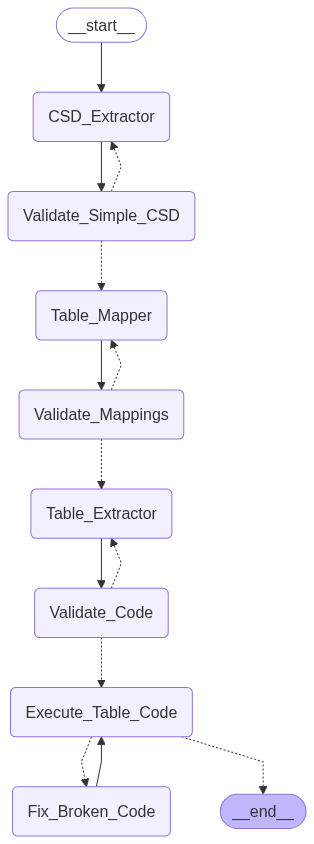


🚀 [CSD_Extractor] Output:
[
  {"csd": "Cohort Creation Steps", "entities": "ICD codes for hypertension and its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, hypertensive encephalopathy)\nLab tests for LAVI and LVMI\nProcedure codes for ECHO and ECG\nDrugs for hypertension"},
  {"csd": "Case", "entities": "Lab tests for abnormal LAVI and LVMI\nProcedure codes for ECG and ECHO"},
  {"csd": "Control", "entities": "Lab tests for normal LAVI and LVMI\nICD codes for HHD disease\nProcedure codes for ECG and ECHO"}
]

🔎 Validation for step: CSD_Extractor
JOB: Extract fundamental data entities to fetch (ICD codes, lab tests, drugs, procedure codes). Ignore temporal logic and ECG-based requests; return a JSON list with an 'entities' string per item.
Input being validated:
 Cohort Creation Steps
Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy

🧑 Override and proceed anyway? (yes/no):  yes


✅ Human override accepted. Proceeding to next step.

🚀 [Table_Extractor] Output:
 ```python
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = """
SELECT 
    DDC.DIAGNOSIS_CODE, 
    DDC.DIAGNOSIS_DESCRIPTION,
    LSD.LAB_TEST_DESCRIPTION,
    PDC.PROCEDURE_CODE,
    PDC.PROCEDURE_DESCRIPTION,
    MN.MED_NAME_DESCRIPTION,
    FD.DIAGNOSIS_CODE_DK,
    FLT.LAB_TEST_DK,
    FP.PROCEDURE_CODE_DK,
    FM.MED_NAME_DK,
    FLT.RESULT_TXT
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC
JOIN
    LAB_SPECIMEN_DIM_LAB_TEST AS LSD
ON
    DDC.DIAGNOSIS_CODE = LSD.LAB_TEST_DK
JOIN
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
ON
    DDC.DIAGNOSIS_CODE = PDC.PROCEDURE_CODE_DK
JOIN
    MAR_DIM_MED_NAME AS MN
ON
    DDC.DIAGNOSIS_CODE = MN.MED_NAME_DK
JOIN
    FACT_DIAGNOSIS AS FD
ON
    DDC.DIAGNOSIS_CODE = FD.DIAGNOSIS_CODE_DK
JOIN
    FACT_LAB_TEST AS FLT
ON
    DDC.DIAGNOSIS_CODE = FLT.LAB_TEST_DK
JOIN
    FACT_PROCEDURES AS FP
ON
    DDC.D

🧑 Override and proceed anyway? (yes/no):  yes


✅ Human override accepted. Proceeding to next step.
📜 Code to be executed:

 1: 'import sqlite3'
 2: 'import pandas as pd'
 3: "conn = sqlite3.connect('synthetic_ehr.db')"
 4: 'cursor = conn.cursor()'
 5: 'sql_query = """'
 6: 'SELECT'
 7: '    DDC.DIAGNOSIS_CODE,'
 8: '    DDC.DIAGNOSIS_DESCRIPTION,'
 9: '    LSD.LAB_TEST_DESCRIPTION,'
10: '    PDC.PROCEDURE_CODE,'
11: '    PDC.PROCEDURE_DESCRIPTION,'
12: '    MN.MED_NAME_DESCRIPTION,'
13: '    FD.DIAGNOSIS_CODE_DK,'
14: '    FLT.LAB_TEST_DK,'
15: '    FP.PROCEDURE_CODE_DK,'
16: '    FM.MED_NAME_DK,'
17: '    FLT.RESULT_TXT'
18: 'FROM'
19: '    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDC'
20: 'JOIN'
21: '    LAB_SPECIMEN_DIM_LAB_TEST AS LSD'
22: 'ON'
23: '    DDC.DIAGNOSIS_CODE = LSD.LAB_TEST_DK'
24: 'JOIN'
25: '    PROCEDURES_DIM_PROCEDURE_CODE AS PDC'
26: 'ON'
27: '    DDC.DIAGNOSIS_CODE = PDC.PROCEDURE_CODE_DK'
28: 'JOIN'
29: '    MAR_DIM_MED_NAME AS MN'
30: 'ON'
31: '    DDC.DIAGNOSIS_CODE = MN.MED_NAME_DK'
32: 'JOIN'
33: '    FACT_DIAGNO

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [46]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str                 # raw multi-line CSD text
    simple_csd: List[str]    # simplified "entities to fetch" (strings)
    mappings: List[dict]     # per-criterion table/column JSON
    table_fetch_code: str    # generated Python code containing SQL
    last_step: str           # last node that failed validation
    retry_count: int         # how many times we retried a step
    execution_error: str     # non-empty string triggers the fix path
    next_step: str           # control signal for conditional routing (set by validators)

# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Simplify CSD for Extraction ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]})
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    # parse JSON and extract the simplified CSD
    try:
        state["simple_csd"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["simple_csd"] = []
    return state

# ---- Extract Table and column names relevant for the given CSD ----
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""

def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state.get("simple_csd", []):
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state

# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = \"\"\"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE
\"\"\"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The Table and column names must be only from this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "")
    if "# Error:" not in raw_code or "cohort_df = pd.read_sql_query" in raw_code:
        return state
    agent = make_agent(code_fixer_prompt)
    result = agent.invoke({"code": raw_code, "table_schema": table_schema})
    print("\n🛠️ [Code_Fixer] Corrected Code:\n", result.content)
    state["table_fetch_code"] = result.content
    return state

# ---- Execution Agent ----
def clean_code_block(code: str) -> str:
    import re
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE)
    code = code.replace("```", "")

    lines = code.strip().splitlines()
    cleaned_lines, found_start, sql_block_open = [], False, False

    for i, line in enumerate(lines):
        if not found_start and (line.strip().startswith("import") or line.strip().startswith("conn") or line.strip().startswith("sql_query")):
            found_start = True
        if found_start:
            cleaned_lines.append(line)

        if 'sql_query' in line and '"""' in line:
            sql_block_open = True
        elif sql_block_open and line.strip() == '"""':
            sql_block_open = False
            if not any("LIMIT" in l.upper() for l in cleaned_lines[-5:]):
                cleaned_lines.insert(len(cleaned_lines) - 1, "LIMIT 1000")

    seen_exec, final_lines = set(), []
    for line in cleaned_lines:
        if line.strip() in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if line.strip() in seen_exec:
                continue
            seen_exec.add(line.strip())
        final_lines.append(line)

    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        final_lines.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        final_lines.append("conn.close()")

    code = "\n".join(final_lines).strip()

    code = re.sub(r"\bif\s*\(?\s*cohort_df\s*\)?\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.IGNORECASE)
    code = re.sub(r"\bif\s*\(?\s*cohort_df\s*==\s*True\s*\)?\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.IGNORECASE)
    code = re.sub(r"\bif\s+cohort_df\s*(!=|==)\s*None\s*:", "if cohort_df is not None and not cohort_df.empty:", code, flags=re.IGNORECASE)

    code = "\n".join([line.rstrip() for line in code.splitlines() if line.strip() != ""]).strip()
    return code

def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))

def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    code = clean_code_block(code)
    code = "\n".join([line for line in code.splitlines() if not line.strip().startswith("# Error:")]).strip()

    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        state["execution_error"] = "unaliased table usage"  # ensure fixer path triggers
        return state

    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        print(f"{i:>2}: {repr(line)}")

    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {"sqlite3": sqlite3, "pd": pd}
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            state["execution_error"] = str(e)
            return state

        df = local_vars.get("cohort_df") or global_context.get("cohort_df")

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            print("✅ DataFrame has data." if not df.empty else "⚠️ Warning: cohort_df is empty.")
            state["table_fetch_code"] = code
            state["execution_error"] = ""  # success
            
        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")
            state["execution_error"] = "Invalid cohort_df type"

        conn.close()
    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        state["execution_error"] = str(e)
    return state

# =========================
# UNIVERSAL VALIDATOR (NEW)
# =========================
universal_validator_prompt = """
You are validating the output of the step "{step}" against the given INPUT and the JOB specification.

JOB (what the step must achieve):
{job}

INPUT (the source this step should honor):
{input_text}

OUTPUT produced by the step:
{output}

Respond with ONLY a JSON object like:
{{"valid": true, "errors": [], "needs_human": false}}

Rules:
- Judge whether the OUTPUT correctly and sufficiently satisfies the JOB relative to the INPUT.
- If invalid, list concrete reasons in "errors".
- Do not include any prose outside the JSON object.
"""

def make_universal_validator(step_key: str, input_key: str, output_key: str, job_spec: str, interactive: bool = True):
    """
    Creates a validator node that compares state[input_key] and state[output_key]
    against a job specification. Returns {"next_step": <step_key>|None}.
    """
    def _validate(state):
        retry_count = state.get("retry_count", 0)
        input_obj = state.get(input_key, {})
        output_obj = state.get(output_key, {})

        # Normalise to strings for the prompt
        input_text = input_obj if isinstance(input_obj, str) else json.dumps(input_obj, indent=2)
        output_text = output_obj if isinstance(output_obj, str) else json.dumps(output_obj, indent=2)

        print(f"\n🔎 Validation for step: {step_key}")
        print("JOB:", job_spec)
        print("Input being validated:\n", input_text)
        print("Output being validated:\n", output_text)

        try:
            result = make_agent(universal_validator_prompt).invoke({
                "step": step_key,
                "job": job_spec,
                "input_text": input_text,
                "output": output_text
            })
            feedback = json.loads(result.content)
        except json.JSONDecodeError:
            print("❌ Failed to parse validator LLM response. Defaulting to 'valid: false'.")
            feedback = {"valid": False, "errors": ["Invalid JSON from validator"], "needs_human": True}

        if not feedback.get("valid"):
            print(f"\n❌ Validation failed for '{step_key}': {feedback.get('errors')}")
            if interactive:
                try:
                    user_input = input("🧑 Override and proceed anyway? (yes/no): ").strip().lower()
                except Exception:
                    user_input = "no"
                if user_input in ["yes", "y"]:
                    print("✅ Human override accepted. Proceeding to next step.")
                    state["retry_count"] = 0
                    state["next_step"] = None
                    return {"next_step": None}

            print(f"🔁 Retry #{retry_count + 1} for step '{step_key}'")
            state["last_step"] = step_key
            state["retry_count"] = retry_count + 1
            state["next_step"] = step_key
            return {"next_step": step_key}

        state["retry_count"] = 0
        state["next_step"] = None
        return {"next_step": None}
    return _validate

# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))

# NEW: Validate the CSD simplification
builder.add_node(
    "Validate_Simple_CSD",
    RunnableLambda(make_universal_validator(
        step_key="CSD_Extractor",
        input_key="csd",
        output_key="simple_csd",
        job_spec="Extract fundamental data entities to fetch (ICD codes, lab tests, drugs, procedure codes). Ignore temporal logic and ECG-based requests; return a JSON list with an 'entities' string per item."
    ))
)

builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))

# Replace old validator with universal validator for mappings
builder.add_node(
    "Validate_Mappings",
    RunnableLambda(make_universal_validator(
        step_key="Table_Mapper",
        input_key="simple_csd",
        output_key="mappings",
        job_spec="For each item in simple_csd, produce a single JSON object listing 'tables' and 'columns' that exist in the provided schema; no SQL, no explanations, one object per item."
    ))
)

builder.add_node("Table_Extractor", RunnableLambda(table_extractor))

# NEW: Validate generated code before executing
builder.add_node(
    "Validate_Code",
    RunnableLambda(make_universal_validator(
        step_key="Table_Extractor",
        input_key="mappings",
        output_key="table_fetch_code",
        job_spec="Return executable Python that uses sqlite3+pandas, defines sql_query as a triple-quoted SELECT using only names from schema, uses table aliases consistently, and assigns cohort_df via pd.read_sql_query(sql_query, conn); no markdown fences."
    ))
)

builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))

builder.set_entry_point("CSD_Extractor")
builder.add_edge("CSD_Extractor", "Validate_Simple_CSD")
builder.add_conditional_edges("Validate_Simple_CSD", lambda state: state.get("next_step"), {
    "CSD_Extractor": "CSD_Extractor",
    None: "Table_Mapper"
})

builder.add_edge("Table_Mapper", "Validate_Mappings")
builder.add_conditional_edges("Validate_Mappings", lambda state: state.get("next_step"), {
    "Table_Mapper": "Table_Mapper",
    None: "Table_Extractor"
})

builder.add_edge("Table_Extractor", "Validate_Code")
builder.add_conditional_edges("Validate_Code", lambda state: state.get("next_step"), {
    "Table_Extractor": "Table_Extractor",
    None: "Execute_Table_Code"
})

builder.add_conditional_edges(
    "Execute_Table_Code",
    lambda state: "Fix_Broken_Code" if state.get("execution_error") else None,
    {"Fix_Broken_Code": "Fix_Broken_Code", None: END}
)
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code")

graph = builder.compile()

# ---- Visualize Graph ----
display(Image(graph.get_graph().draw_mermaid_png()))

# ---- Run Graph (example) ----
from textwrap import dedent

csd_text = dedent("""
    Cohort Creation Steps
    Identify patients with disease codes for hypertension or its complications (hypertensive heart disease, hypertensive retinopathy, hypertensive nephropathy, or hypertensive encephalopathy)
    Include patients with LAVI and LVMI available 24 hours from each other
    Identify the most recent ECHO with ECGs around it in a +/- 3 month window (Anchor: most recent ECHO)
    Exclude patients whose anchor ECHO has multiple LAVI or LVMI values at the exact same timestamp
    Include patients on treatment for hypertension anytime before to 1 year after the anchor

    Case
    Patients whose anchor ECHO has either an abnormal LAVI or an abnormal LVMI
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years

    Control
    Patients whose anchor ECHO has normal LAVI and normal LVMI
    Exclude patients with HHD disease codes before the anchor
    Take all ECGs in a +/- 3 month interval from the anchor and evaluate model performance
    Exclude patients whose ECGs have a conflicting ECHO class in a +/- 3 month interval
    Ensure that age at the time of ECG ≥ 18 years
""").strip()

csd_input = {
    "csd": csd_text,
    "simple_csd": [],
    "mappings": [],
    "table_fetch_code": "",
    "last_step": "",
    "retry_count": 0,
    "execution_error": "",
    "next_step": None
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state.get("table_fetch_code", ""))


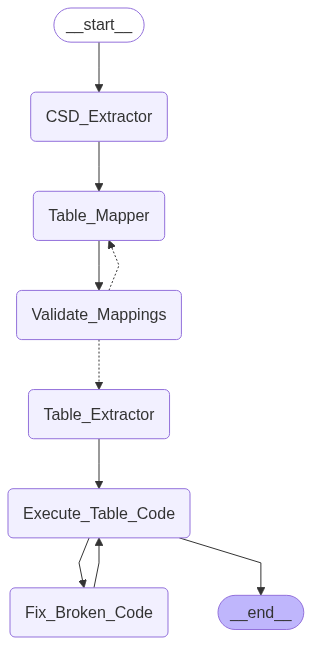


🚀 [CSD_Extractor] Output:
[
  {"csd": "Include patients aged 40–75 with hypertension", "entities": "ICD codes for hypertension"},
  {"csd": "LDL > 100", "entities": "Lab tests for LDL"},
  {"csd": "Exclude those with prior heart failure", "entities": "ICD codes for heart failure"}
]

🚀 [Table_Mapper] Output:
{
  "csd": "ICD codes for hypertension",
  "tables": ["DIAGNOSIS_DIM_DIAGNOSIS_CODE"],
  "columns": ["DIAGNOSIS_CODE", "DIAGNOSIS_DESCRIPTION"]
}

🚀 [Table_Mapper] Output:
{
  "csd": "Lab tests for LDL",
  "tables": ["LAB_SPECIMEN_DIM_LAB_TEST", "FACT_LAB_TEST"],
  "columns": ["LAB_TEST_DESCRIPTION", "PATIENT_ID", "EVENT_DTM", "LAB_TEST_DK", "LAB_STATUS", "RESULT_TXT", "UNIT_OF_MEASURE_TXT"]
}

🚀 [Table_Mapper] Output:
{
  "csd": "ICD codes for heart failure",
  "tables": ["DIAGNOSIS_DIM_DIAGNOSIS_CODE", "FACT_DIAGNOSIS"],
  "columns": ["DIAGNOSIS_DIM_DIAGNOSIS_CODE.DIAGNOSIS_CODE", "DIAGNOSIS_DIM_DIAGNOSIS_CODE.DIAGNOSIS_DESCRIPTION", "FACT_DIAGNOSIS.DIAGNOSIS_CODE_DK"]
}

🔎 Vali

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [12]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json
import re

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str
    criteria: List[str]
    mappings: List[dict]
    table_fetch_code: str
    validation: dict
    history: List[dict]
    last_step: str
    retry_count: int

# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ----Simplified CSD Extractor ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""
def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]})
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    try:
        state["criteria"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["criteria"] = []
    return state

# ---- Table & Column Identifier ----    
schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""

def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["criteria"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state




# ---- Table Extractor ----
table_extractor_prompt = """
You are given a list of table/column mappings from a cohort definition task.
Generate a unified SQL query (in Python using sqlite3 and pandas) that fetches all relevant data from these tables.
- JOIN on `PATIENT_ID` or `NFER_PID` if needed
- ALWAYS use aliases for all tables and refer to them consistently
- NEVER reference unaliased table names in JOIN conditions
- Example: if you define `FACT_LAB_TEST AS FLT`, then use `FLT.PATIENT_ID`, NOT `FACT_LAB_TEST.PATIENT_ID`
- Store final result in a pandas DataFrame called `cohort_df`
- Make sure that table names and column names are taken ONLY from {table_schema}
- Do NOT include explanations or comments

The code must reference only this schema:
{table_schema}

Example:
import sqlite3
import pandas as pd

conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()

sql_query = /"/"/"
SELECT 
    DIAGNOSIS_CODE, 
    DIAGNOSIS_DESCRIPTION
FROM 
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDD
/"/"/"

cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

Mappings:
{mappings}

Return ONLY Python code (no markdown code blocks) properly indented and executable.
"""

def table_extractor(state):
    agent = make_agent(table_extractor_prompt)
    result = agent.invoke({
        "mappings": json.dumps(state["mappings"]),
        "table_schema": table_schema
    })
    print("\n🚀 [Table_Extractor] Output:\n", result.content)
    state["table_fetch_code"] = result.content
    return state


# ---- Table Executor + Fixer ----
code_fixer_prompt = """
You are given a block of Python code that is meant to be executed using sqlite3 and pandas but it failed.
Your job is to correct the syntax or logic errors so that the code becomes executable.
Only return corrected Python code.

The code must reference only this schema:
{table_schema}

Original (failing) code:
{code}

Corrected code:
"""

def fix_broken_sql_code(state):
    raw_code = state.get("table_fetch_code", "")
    if "# Error:" not in raw_code or "cohort_df = pd.read_sql_query" in raw_code:
        return state


    agent = make_agent(code_fixer_prompt)
    result = agent.invoke({
        "code": raw_code,
        "table_schema": table_schema
    })
    print("\n🛠️ [Code_Fixer] Corrected Code:\n", result.content)
    state["table_fetch_code"] = result.content
    return state



def clean_code_block(code: str) -> str:
    import re

    # Remove markdown code fences if present
    code = re.sub(r"```(?:python)?", "", code.strip(), flags=re.IGNORECASE)
    code = code.replace("```", "")

    lines = code.strip().splitlines()
    cleaned_lines = []
    found_start = False
    sql_block_open = False

    for i, line in enumerate(lines):
        # Start copying after we hit import/sql/conn
        if not found_start and (line.strip().startswith("import") or line.strip().startswith("conn") or line.strip().startswith("sql_query")):
            found_start = True
        if found_start:
            cleaned_lines.append(line)

        # Track if we are inside the SQL string
        if 'sql_query' in line and '"""' in line:
            sql_block_open = True
        elif sql_block_open and line.strip() == '"""':
            sql_block_open = False
            # Append LIMIT if not present
            if not any("LIMIT" in l.upper() for l in cleaned_lines[-5:]):
                cleaned_lines.insert(len(cleaned_lines) - 1, "LIMIT 1000")

    # Deduplicate trailing execution lines
    seen_exec = set()
    final_lines = []
    for line in cleaned_lines:
        if line.strip() in ("cohort_df = pd.read_sql_query(sql_query, conn)", "conn.close()"):
            if line.strip() in seen_exec:
                continue
            seen_exec.add(line.strip())
        final_lines.append(line)

    # Ensure execution lines exist
    if "cohort_df = pd.read_sql_query(sql_query, conn)" not in seen_exec:
        final_lines.append("cohort_df = pd.read_sql_query(sql_query, conn)")
    if "conn.close()" not in seen_exec:
        final_lines.append("conn.close()")

    code = "\n".join(final_lines).strip()

    # Replace ambiguous DataFrame truth checks (the main fix)
    code = re.sub(
        r"\bif\s*\(?\s*cohort_df\s*\)?\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )

    # Also cover cases with spacing or multiline if statements
    code = re.sub(
        r"\bif\s*\(?\s*cohort_df\s*==\s*True\s*\)?\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )

    # Catch misuse like: `if cohort_df != None:`
    code = re.sub(
        r"\bif\s+cohort_df\s*(!=|==)\s*None\s*:",
        "if cohort_df is not None and not cohort_df.empty:",
        code,
        flags=re.IGNORECASE
    )
    # At the end of clean_code_block()
    code = "\n".join([line.rstrip() for line in code.splitlines() if line.strip() != ""]).strip()

    return code



def detect_invalid_alias_usage(code: str) -> List[str]:
    pattern = re.compile(r"\b(FACT_[A-Z_]+)\.(PATIENT_ID|NFER_PID|.*?_DK)\b")
    declared_aliases = re.findall(r"FROM\s+(\w+)\s+AS\s+(\w+)|JOIN\s+(\w+)\s+AS\s+(\w+)", code, re.IGNORECASE)
    declared_aliases = {alias for groups in declared_aliases for alias in groups if alias}

    issues = []
    for match in pattern.findall(code):
        full, _ = match
        if full not in declared_aliases:
            issues.append(full)
    return list(set(issues))

    

def execute_table_fetch(state):
    code = state.get("table_fetch_code", "")
    if not code.strip():
        print("⚠️ No code to execute.")
        return state

    # --- Clean the code block ---
    code = clean_code_block(code)

    code_lines = code.splitlines()
    code_lines = [line for line in code_lines if not line.strip().startswith("# Error:")]
    code = "\n".join(code_lines).strip()

    # --- Check for invalid alias usage before execution ---
    invalid_aliases = detect_invalid_alias_usage(code)
    if invalid_aliases:
        print(f"❌ Invalid SQL: unaliased usage of tables: {invalid_aliases}")
        state["table_fetch_code"] += f"\n# Error: unaliased table usage: {invalid_aliases}"
        return state

    # --- Show numbered code for debugging ---
    print("📜 Code to be executed:\n")
    for i, line in enumerate(code.splitlines(), 1):
        print(f"{i:>2}: {repr(line)}")

    try:
        with open("last_executed_sql_code.py", "w") as f:
            f.write(code)

        local_vars = {}
        global_context = {
            "sqlite3": sqlite3,
            "pd": pd,
        }

        # Setup connection
        conn = sqlite3.connect("synthetic_ehr.db")
        cursor = conn.cursor()
        global_context.update({"conn": conn, "cursor": cursor})

        # Try executing the code
        try:
            exec(code, global_context, local_vars)
        except Exception as e:
            print("❌ Error while executing SQL block:\n", str(e))
            raise

        # Extract resulting DataFrame
        df = local_vars.get("cohort_df")
        if df is None:
            df = global_context.get("cohort_df")

        if isinstance(df, pd.DataFrame):
            print("✅ cohort_df shape:", df.shape)
            if df is not None and not df.empty:
                print("✅ DataFrame has data.")
                state["cohort_df"] = df.copy()
            elif df is not None and df.empty:
                print("⚠️ Warning: cohort_df is empty.")
            else:
                print("⚠️ DataFrame may not have executed properly.")
        else:
            print(f"❌ cohort_df is not a valid DataFrame. Got: {type(df)}")


        conn.close()

    except Exception as e:
        print("❌ Error executing table fetch code:\n", str(e))
        # Store error separately instead of modifying executable code
        state["execution_error"] = str(e)


    return state


    
    
# ---- Step-wise Validator ----
step_validator_prompt = """
You are validating the output of the step "{step}".
Here is the JSON result:
{output}

Respond with ONLY a JSON object using this format:
{{
  "valid": true or false,
  "errors": ["..."],
  "needs_human": true or false
}}
"""

def make_step_validator(step_key: str, output_key: str):
    def _validate(state):
        retry_count = state.get("retry_count", 0)
        output = state.get(output_key, {})

        print(f"\n🔎 Validation for step: {step_key}")
        print("Output being validated:\n", json.dumps(output, indent=2))

        try:
            result = make_agent(step_validator_prompt).invoke({
                "step": step_key,
                "output": json.dumps(output)
            })
            feedback = json.loads(result.content)
        except json.JSONDecodeError:
            print("❌ Failed to parse validator LLM response. Defaulting to 'valid: false'.")
            feedback = {"valid": False, "errors": ["Invalid JSON from validator"], "needs_human": True}

        if not feedback.get("valid"):
            print(f"\n❌ Validation failed for '{step_key}': {feedback.get('errors')}")
            user_input = input(f"🧑 Do you want to override and proceed anyway? (yes/no): ").strip().lower()
            if user_input in ["yes", "y"]:
                print("✅ Human override accepted. Proceeding to next step.")
                state["retry_count"] = 0
                return {"next_step": None}

            print(f"🔁 Retry #{retry_count + 1} for step '{step_key}'")
            state["last_step"] = step_key
            state["retry_count"] = retry_count + 1
            return {"next_step": step_key}

        state["retry_count"] = 0
        return {"next_step": None}
    return _validate

# ---- Graph Assembly ----
builder = StateGraph(GraphState)
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(make_step_validator("Table_Mapper", "mappings")))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Execute_Table_Code", RunnableLambda(execute_table_fetch))
builder.add_node("Fix_Broken_Code", RunnableLambda(fix_broken_sql_code))


builder.set_entry_point("CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")
builder.add_conditional_edges("Validate_Mappings", lambda state: state.get("next_step"), {
    "Table_Mapper": "Table_Mapper",
    None: "Table_Extractor"
})
builder.add_edge("Table_Extractor", "Execute_Table_Code")
builder.add_edge("Execute_Table_Code", "Fix_Broken_Code")
builder.add_edge("Fix_Broken_Code", "Execute_Table_Code") 
builder.add_edge("Execute_Table_Code", END)

graph = builder.compile()
# ---- Visualize Graph ----
display(Image(graph.get_graph().draw_mermaid_png()))

# ---- Run Graph ----
csd_input = {
    "csd": "Include patients aged 40–75 with hypertension ICD codes and LDL > 100. Exclude those with prior heart failure.",
    "criteria": [], "mappings": [], "validation": {}, "history": [], "table_fetch_code": "",
    "last_step": "", "retry_count": 0
}

final_state = graph.invoke(csd_input)
print("\n✅ Final SQL Extraction Code:\n")
print(final_state["table_fetch_code"])


In [10]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('synthetic_ehr.db')
cursor = conn.cursor()
sql_query = """
SELECT
    DDD.DIAGNOSIS_CODE,
    DDD.DIAGNOSIS_DESCRIPTION,
    LSDT.LAB_TEST_DESCRIPTION,
    PDC.PROCEDURE_CODE,
    PDC.PROCEDURE_DESCRIPTION,
    MDMN.MED_NAME_DESCRIPTION,
    FLTT.RESULT_TXT,
    DP.PATIENT_BIRTH_DATE
FROM
    DIAGNOSIS_DIM_DIAGNOSIS_CODE AS DDD
JOIN
    LAB_SPECIMEN_DIM_LAB_TEST AS LSDT
JOIN
    PROCEDURES_DIM_PROCEDURE_CODE AS PDC
JOIN
    MAR_DIM_MED_NAME AS MDMN
JOIN
    FACT_LAB_TEST AS FLTT ON LSDT.LAB_TEST_DK = FLTT.LAB_TEST_DK
JOIN
    FACT_PROCEDURES AS FP ON PDC.PROCEDURE_CODE_DK = FP.PROCEDURE_CODE_DK
JOIN
    DIM_PATIENT AS DP ON DP.PATIENT_ID = FP.PATIENT_ID
LIMIT 1000
"""
cohort_df = pd.read_sql_query(sql_query, conn)
conn.close()

In [11]:
cohort_df.head()

,DIAGNOSIS_CODE,DIAGNOSIS_DESCRIPTION,LAB_TEST_DESCRIPTION,PROCEDURE_CODE,PROCEDURE_DESCRIPTION,MED_NAME_DESCRIPTION,RESULT_TXT,PATIENT_BIRTH_DATE
0,E11.9,Type 2 diabetes mellitus without complications,6690-2,99203,"Office or other outpatient visit, new patient",1049630,144.5,2001-02-01
1,E11.9,Type 2 diabetes mellitus without complications,6690-2,99203,"Office or other outpatient visit, new patient",617314,144.5,2001-02-01
2,E11.9,Type 2 diabetes mellitus without complications,6690-2,99203,"Office or other outpatient visit, new patient",617320,144.5,2001-02-01
3,E11.9,Type 2 diabetes mellitus without complications,6690-2,99203,"Office or other outpatient visit, new patient",617318,144.5,2001-02-01
4,E11.9,Type 2 diabetes mellitus without complications,6690-2,99203,"Office or other outpatient visit, new patient",197361,144.5,2001-02-01


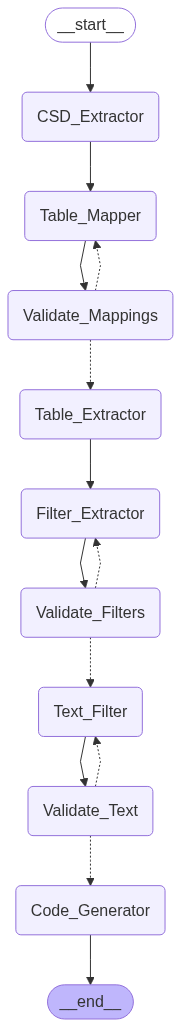


🚀 [CSD_Extractor] Output:
[
  {"csd": "Include patients aged 40–75 with hypertension", "entities": "ICD codes for hypertension"},
  {"csd": "LDL > 100", "entities": "Lab tests for LDL"},
  {"csd": "Exclude those with prior heart failure", "entities": "ICD codes for heart failure"}
]


KeyboardInterrupt: 

In [89]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import display, Image
import json

# ---- LangGraph state schema ----
class GraphState(TypedDict):
    csd: str
    criteria: List[str]
    mappings: List[dict]
    filters: List[dict]
    text_filters: List[str]
    validation: dict
    python_code: str
    history: List[dict]
    last_step: str
    retry_count: int
    table_fetch_code: str

# ---- LLM ----
llm = ChatOpenAI(model="gpt-4", temperature=0.1)

# ---- Agent builder ----
def make_agent(prompt_template):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    return prompt | llm

# ---- Prompts ----
csd_extractor_prompt = """
You are a data scientist tasked with analyzing a cohort creation request. 
From the request, extract the fundamental data entities to fetch, such as ICD codes, lab tests, drugs, or procedure codes.
Ignore temporal logic or complex inclusion/exclusion rules.
Return a JSON list like:
[
  {{"csd": "...", "entities": "ICD codes for diabetes\nDrugs for diabetes"}},
  {{"csd": "...", "entities": "Lab tests for dyslipidemia"}}
]
CSD:
{csd}
"""

schema_mapper_prompt = """
You are a data engineer. Given a user statement and the SQL schema, return only structured JSON specifying which tables and columns to use.
1. **SQL Data Extraction**: Use SQL queries to extract the needed data according to the cohort instruction.
2. **Data Transfer to Python**: Transfer this extracted data into a Python-friendly format (like Pandas DataFrame).

Instructions:
- DO NOT include explanations.
- DO NOT include SQL.
- ONLY return a single valid JSON object.

Schema:
{table_schema}

User Request:
{statement}

Return ONLY this format:
{{
  "csd": "{statement}",
  "tables": [...],
  "columns": [...]
}}
"""


table_extractor_prompt = """
You are given a set of SQL tables and columns required to extract data relevant to a cohort definition. 
Generate Python code that uses `sqlite3` and `pandas` to fetch data from those tables, 
using appropriate JOINs if multiple tables are involved. 

Use:
```python
conn = sqlite3.connect("synthetic_ehr.db")
cursor = conn.cursor()
```

Then for each table, use SQL SELECT statements to fetch the relevant columns.

If more than one table is listed, JOIN on `NFER_PID` unless stated otherwise.

Input JSON:
{mapping}

Return valid Python code block (no explanations, just code).
"""
filter_extractor_prompt = """
You are a data scientist tasked with writing pipeline using Python. 

YOU HAVE TO READ all_llm_context.docx to understand how to create the code. 
You have been given "all_llm_context.docx", which has the steps of creating 2 disease model cohorts - HHD and Hypertension. For this example please understand that the data has already been fetched.

Understand the cohort creation steps from the given file. In the example file you are going to find comments mentioning where a particular step is being performed.
Create data transformation code in python blocks. In this file you will do data transformation steps.

I am also giving you an additional context for the available data
Use following data instead fetching from SQL - 
If we need primary care bp data, use: '/path/to/primary_care_patients.parquet' : columns - NFER_PID, BP_TIME - 
If we need outpatient bp data, use: '/path/to/outpatient_dta.parquet' : columns - NFER_PID, BP_TIME 
If we need Troponin I data, use: '/path/to/troponin_i_data.parquet' : columns - NFER_PID, TROPONIN_I_TIME
If we need Troponin T data, use: '/path/to/troponin_t_data.parquet' : columns - NFER_PID, TROPONIN_T_TIME 
If we need CKMB data, use: '/path/to/ckmb_data.parquet' : columns - NFER_PID, CKMB_TIME 
If we need Abnormal BP data, use: '/path/to/abnormal_bp_data.parquet': columns - NFER_PID, BP_TIME
If we need ECG timestamp data, use: '/path/to/ecg_data.csv': columns - NFER_PID, ECG_TIME, NFER_AGE
If we need look forward data, use: '/path/to/look_forward_data.parquet': columns - NFER_PID, NFER_DTM_MAX
If we need look backward data, use: '/path/to/look_back_data.parquet': columns - NFER_PID, NFER_DTM_MIN - If we need hospital data, use: 'path/to/hosp_data.parquet'

Follow the provided cohort creation steps and create corresponding code blocks for any new user input
"""

text_filter_prompt = """
Extract keywords or regex filters from this criterion:
"{statement}"
Return list.
"""

validator_prompt = """
Validate the full cohort extraction state. Return JSON:
{{"valid": true/false, "corrections": []}}

Input:
{state_json}
"""

loop_detector_prompt = """
Given the history below, detect if there's a logical loop. Return JSON:
{{"loop_detected": true/false, "escalate": true/false, "reason": "..."}}

History:
{trace}
"""

code_gen_prompt = """
Generate Python Pandas code to extract a cohort based on:

Schema:
{schema}

Criteria:
{criteria}

Filters:
{filters}

ICD:
{icd}
Procedures:
{procedures}
Text:
{text_filters}

Return complete Python code that produces a DataFrame `cohort`.
"""

# ---- Agent Functions ----
def csd_statement_extractor(state):
    result = make_agent(csd_extractor_prompt).invoke({"csd": state["csd"]})
    print("\n🚀 [CSD_Extractor] Output:")
    print(result.content)
    try:
        state["criteria"] = [entry["entities"] for entry in json.loads(result.content)]
    except json.JSONDecodeError:
        print("❌ Failed to parse JSON in CSD_Extractor")
        state["criteria"] = []
    return state



def table_column_identifier(state):
    mappings = []
    agent = make_agent(schema_mapper_prompt)
    for s in state["criteria"]:
        response = agent.invoke({"statement": s, "table_schema": table_schema})
        print("\n🚀 [Table_Mapper] Output:")
        print(response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"tables": [], "columns": [], "error": "invalid JSON from LLM"}
        mappings.append(parsed)
    state["mappings"] = mappings
    return state
def filter_extractor(state):
    filters = []
    agent = make_agent(filter_extractor_prompt)
    for s in state["criteria"]:
        response = agent.invoke({"statement": s})
        print("\n🚀 [Filter_Extractor] Output:\n", response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = {"error": "invalid JSON from LLM"}
        filters.append(parsed)
    state["filters"] = filters
    return state


def text_filter_extractor(state):
    filters = []
    agent = make_agent(text_filter_prompt)
    for s in state["criteria"]:
        response = agent.invoke({"statement": s})
        print("\n🚀 [Text_Filter] Output:\n", response.content)
        try:
            parsed = json.loads(response.content)
        except json.JSONDecodeError:
            parsed = []
        filters.append(parsed)
    state["text_filters"] = list(set(t for sublist in filters for t in sublist))
    return state


def code_generator(state):
    args = {
        "schema": table_schema,
        "criteria": json.dumps(state["criteria"]),
        "filters": json.dumps(state["filters"]),
        "icd": json.dumps(state["icd_codes"]),
        "procedures": json.dumps(state["procedure_codes"]),
        "text_filters": json.dumps(state["text_filters"]),
    }
    result = make_agent(code_gen_prompt).invoke(args)
    print("\n🚀 [Code_Generator] Output:\n", result.content)
    state["python_code"] = result.content
    return state

# ---- Step-wise Validator (with human override always) ----
step_validator_prompt = """
You are validating the output of the step "{step}".
Here is the JSON result:
{output}

Return JSON: {{"valid": true/false, "errors": [...], "needs_human": true/false}}
"""

def make_step_validator(step_key: str, output_key: str):
    def _validate(state):
        retry_count = state.get("retry_count", 0)
        output = state.get(output_key, {})

        print(f"\n🔎 Validation for step: {step_key}")
        print("Output being validated:\n", json.dumps(output, indent=2))

        result = make_agent(step_validator_prompt).invoke({
            "step": step_key,
            "output": json.dumps(output)
        })

        feedback = json.loads(result.content)

        if not feedback.get("valid"):
            print(f"\n❌ Validation failed for '{step_key}': {feedback.get('errors')}")
            user_input = input(f"🧑 Do you want to override and proceed anyway? (yes/no): ").strip().lower()
            if user_input in ["yes", "y"]:
                print("✅ Human override accepted. Proceeding to next step.")
                state["retry_count"] = 0
                return {"next_step": None}

            print(f"🔁 Retry #{retry_count + 1} for step '{step_key}'")
            state["last_step"] = step_key
            state["retry_count"] = retry_count + 1
            return {"next_step": step_key}

        state["retry_count"] = 0
        return {"next_step": None}
    return _validate


# ---- Build LangGraph ----
builder = StateGraph(GraphState)
builder.add_node("CSD_Extractor", RunnableLambda(csd_statement_extractor))
builder.add_node("Table_Mapper", RunnableLambda(table_column_identifier))
builder.add_node("Validate_Mappings", RunnableLambda(make_step_validator("Table_Mapper", "mappings")))
builder.add_node("Table_Extractor", RunnableLambda(table_extractor))
builder.add_node("Filter_Extractor", RunnableLambda(filter_extractor))
builder.add_node("Validate_Filters", RunnableLambda(make_step_validator("Filter_Extractor", "filters")))
builder.add_node("Text_Filter", RunnableLambda(text_filter_extractor))
builder.add_node("Validate_Text", RunnableLambda(make_step_validator("Text_Filter", "text_filters")))
builder.add_node("Code_Generator", RunnableLambda(code_generator))


builder.set_entry_point("CSD_Extractor")
builder.add_edge("CSD_Extractor", "Table_Mapper")
builder.add_edge("Table_Mapper", "Validate_Mappings")

builder.add_conditional_edges(
    "Validate_Mappings",
    lambda state: state.get("next_step"),
    {
        "Table_Mapper": "Table_Mapper",
        None: "Table_Extractor"
    }
)

builder.add_edge("Table_Extractor", "Filter_Extractor")
builder.add_edge("Filter_Extractor", "Validate_Filters")
builder.add_conditional_edges("Validate_Filters", lambda state: state.get("next_step"), {
    "Filter_Extractor": "Filter_Extractor",
    None: "Text_Filter"
})

builder.add_edge("Text_Filter", "Validate_Text")
builder.add_conditional_edges("Validate_Text", lambda state: state.get("next_step"), {
    "Text_Filter": "Text_Filter",
    None: "Code_Generator"
})

builder.add_edge("Code_Generator", END)



# ---- Compile and Run ----
graph = builder.compile()

# ---- Visualize Graph ----
display(Image(graph.get_graph().draw_mermaid_png()))

csd_input = {
    "csd": "Include patients aged 40–75 with hypertension ICD codes and LDL > 100. Exclude those with prior heart failure.",
    "criteria": [], "mappings": [], "filters": [], "text_filters": [], "validation": {}, "python_code": "", "history": [],
    "last_step": "", "retry_count": 0
}

final_state = graph.invoke(csd_input)
print("\nGenerated Python Code:\n")
print(final_state["python_code"])